In [1]:
# %load_ext autoreload
import importlib
import pandas as pd
import os
import sys
import pwd
import numpy as np
from pathlib import Path
from tqdm import tqdm, trange
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt
import GEOparse
import scanpy as sc
from scipy import sparse as sp
import sparse as spa
import scipy as spy
from scipy.stats import linregress, entropy
sys.path.append('../')
from meth import tools as mtools
from meth import analytic_tools as anatools
from meth.meth_anndata import AnnDataSet
from scipy.stats import pearsonr 
from matplotlib import rcParams
%load_ext autoreload
%autoreload 2
plt.style.use('../Stochastic aging/pics/meth.mplstyle')

# Simulations 

In [2]:
def dropout_nans(x, ith=184):
    y = np.zeros((np.max(np.sum(~np.isnan(x), axis=0)) + 1, x.shape[1])) + np.nan
    for i in range(y.shape[1]):
        try:
            y[:np.sum(~np.isnan(x[:ith,i])),i] = x[:ith,i][~np.isnan(x[:ith,i])]
            y[np.sum(~np.isnan(x[:ith,i])):,i] = np.nan
        except:
            pass
    for i in range(y.shape[1]):
        try:
            y[-np.sum(~np.isnan(x[ith:,i])):,i] = x[ith:,i][~np.isnan(x[ith:,i])]
        except:
            pass
    return y

0.1


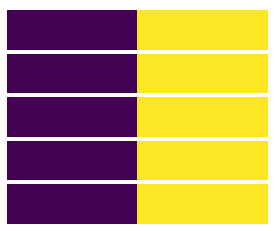

181.0 181.5 1815


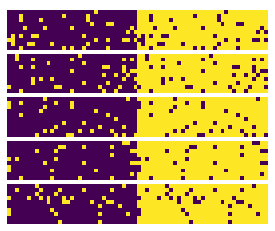

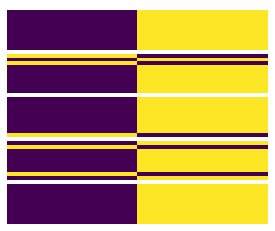

0.25


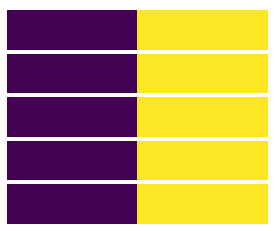

453.0 453.75 1815


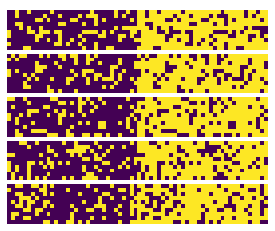

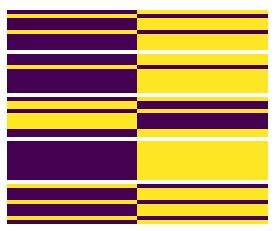

0.5


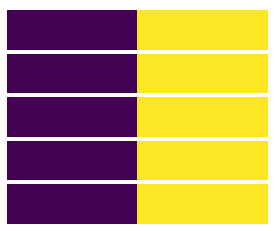

907.0 907.5 1815


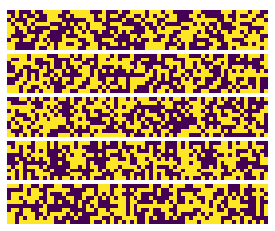

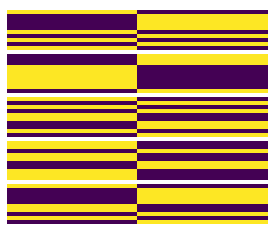

In [16]:
perc = 0.1
CpS = 11
S = 5
Sx = 3
N = CpS * S
Nx = CpS * Sx
def plot_pics(perc):    
    y = np.zeros((N,Nx))
    y2 = np.zeros((N,Nx)) + 1
    y[::(CpS),:] = np.nan
    y2[::(CpS),:] = np.nan
    plt.imshow(np.hstack((y, y2)))
    # for i in range(S + 1):
    #     plt.plot([0,2*Nx],[CpS * i,CpS * i], color='w', lw=5)
    plt.axis('off')
    plt.show()

    y = np.zeros((N,Nx))
    y2 = np.zeros((N,Nx)) + 1
    # idx = np.random.randint(0, 2, y.flatten().shape[0])
    idx = np.zeros(N*Nx)
    idx[:int(N*Nx * perc)] = 1
    np.random.shuffle(idx)
    print(np.sum(idx), N*Nx*perc, N * Nx)
    y = (y.flatten() + 1 * idx).reshape((N,Nx))
    y2 = (y2.flatten() - 1 * idx).reshape((N,Nx))
    y[::(CpS),:] = np.nan
    y2[::(CpS),:] = np.nan

    # y[idx] = 1-y[idx]
    # y2[idx] = 1-y2[idx]

    fig = plt.imshow(np.hstack((y, y2)))
    # for i in range(S + 1):
    #     plt.plot([0,2*Nx],[CpS * i,CpS * i], color='w', lw=5)    
    plt.axis('off')
    plt.show()

    y = np.zeros((N,Nx))
    y2 = np.zeros((N,Nx)) + 1
    # idx = np.random.randint(0, 2, y.flatten().shape[0])
    idx = np.zeros(N)

    idx[:int(N * perc)] = 1
    np.random.shuffle(idx)
    idx = idx == 1
    y[idx,:] = 1 - y[idx,:]
    y2[idx,:] = 1 - y2[idx,:]
    # y[idx] = 1-y[idx]
    # y2[idx] = 1-y2[idx]
    y[::(CpS),:] = np.nan
    y2[::(CpS),:] = np.nan

    fig = plt.imshow(np.hstack((y, y2)))
    # for i in range(S + 1):
    #     plt.plot([0,2*Nx],[CpS * i,CpS * i], color='w', lw=5)    
    plt.axis('off')
    plt.show()

for perc in [0.1, 0.25, 0.5]:
    print(perc)
    plot_pics(perc)

In [242]:
# perc = 0.1
# CpS = 20
# S = 10
# N = CpS * S
# Ng = 100

CpS = 11
S = 5
Sx = 3
N = CpS * S
Ng = CpS * Sx
perc = 0.1
def plot_pics_mix(perc, perc_nan=0., mixed=False, simulated_samples=None):
    y = np.zeros((N,Ng))
    y2 = np.zeros((N,Ng)) + 1
    if simulated_samples is None:
        simulated_samples = {}
    
    idxnan = np.zeros(N*Ng)
    idxnan[:int(N*Ng * perc_nan)] = 1
    np.random.shuffle(idxnan)
    idxnan1 = idxnan.copy() == 1
    np.random.shuffle(idxnan)
    idxnan2 = idxnan.copy() == 1
    idxnan1 = idxnan1.reshape((N,Ng))
    idxnan2 = idxnan2.reshape((N,Ng))
    
    y[idxnan1] = np.nan
    y2[idxnan2] = np.nan
    y[::(CpS),:] = np.nan
    y2[::(CpS),:] = np.nan
    simulated_samples[f'Raw_{perc}_{perc_nan}'] = np.hstack((y, y2))
#     plt.imshow(np.hstack((y, y2)))
    
#     # for i in range(S + 1):
#     #     plt.plot([0,2*Ng],[CpS * i,CpS * i], color='w', lw=5)    
#     plt.axis('off')
#     plt.show()

    y = np.zeros((N,Ng))
    y2 = np.zeros((N,Ng)) + 1
    idx = np.zeros(N*Ng)
    if mixed:
        # perc2 = perc/2.
        # perc2 = np.sqrt(perc/2.)

        if perc > 0.5:
            perc2 = 0.5 + 0.5*np.sqrt(np.abs(1 - 2 *perc))
        else:
            perc2 = 0.5 - 0.5*np.sqrt(np.abs(1 - 2 *perc))
        # perc2 /= 2.
    else:
        perc2 = perc
    idx[:int(N*Ng * perc2)] = 1

    np.random.shuffle(idx)
    idx1 = idx.copy()
    np.random.shuffle(idx)
    idx2 = idx.copy()
    idx1 = idx1.reshape((N,Ng)) == 1
    idx2 = idx2.reshape((N,Ng)) == 1
    # y = (y.flatten() + 1 * idx1).reshape((N,N))
    # y2 = (y2.flatten() - 1 * idx2).reshape((N,N))
    y[idx1] = 1 - y[idx1]
    y2[idx2] = 1 - y2[idx2]

    y[idxnan1] = np.nan
    y2[idxnan2] = np.nan

    if mixed == False:
        y[::(CpS),:] = np.nan
        y2[::(CpS),:] = np.nan
        simulated_samples[f'Raw_{perc}_{perc_nan}_{mixed}_dots'] = np.hstack((y, y2))
        # fig = plt.imshow(np.hstack((y, y2)))
        # # for i in range(S + 1):
        # #     plt.plot([0,2*Ng],[CpS * i,CpS * i], color='w', lw=5)    
        # plt.axis('off')
        # plt.show()

    if mixed == False:
        y = np.zeros((N,Ng))
        y2 = np.zeros((N,Ng)) + 1

    idx = np.zeros(N)

    idx[:int(N * perc2)] = 1
    np.random.shuffle(idx)
    idx1 = idx.copy() == 1
    # np.random.shuffle(idx)
    idx2 = idx.copy() == 1
    y[idx1,:] =1 - y[idx1,:]
    y2[idx2,:] =1 - y[idx2,:]
#     y[idx1,:] = np.max(np.vstack((1 - y[idx1,:], y[idx1,:])), axis=0)
#     y2[idx2,:] =np.min(np.vstack((1 - y[idx2,:], y[idx2,:])), axis=0)
    
    y[idxnan1] = np.nan
    y2[idxnan2] = np.nan
    y[::(CpS),:] = np.nan
    y2[::(CpS),:] = np.nan

    if mixed == False:
        simulated_samples[f'Raw_{perc}_{perc_nan}_{mixed}_lines'] = np.hstack((y, y2))
    else:
        simulated_samples[f'Raw_{perc}_{perc_nan}_{mixed}'] = np.hstack((y, y2))
    
    fig = plt.imshow(np.hstack((y, y2)))
    # for i in range(S + 1):
    #     plt.plot([0,2*Ng],[CpS * i,CpS * i], color='w', lw=5)    
    plt.axis('off')
    plt.show()
    return simulated_samples

0 0
Mixed


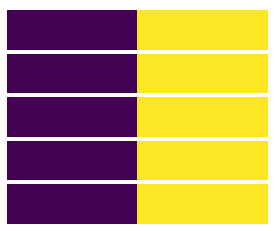

Separate


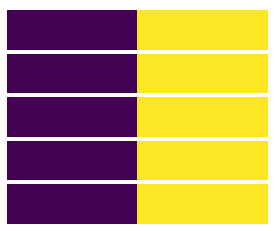

0 0.1
Mixed


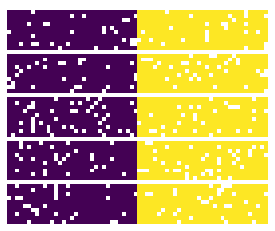

Separate


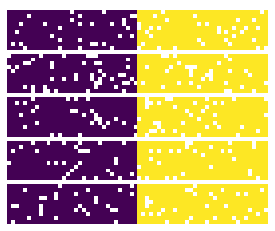

0 0.5
Mixed


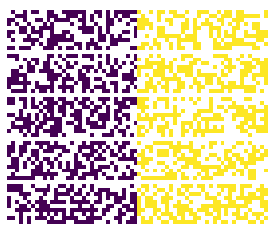

Separate


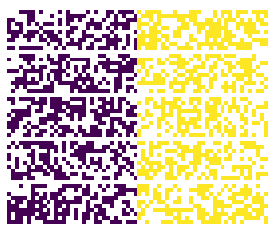

0 0.9
Mixed


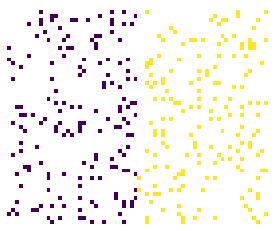

Separate


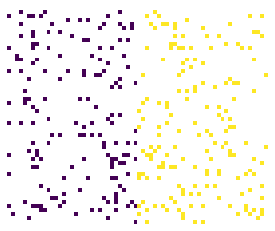

0.1 0
Mixed


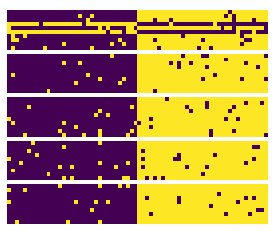

Separate


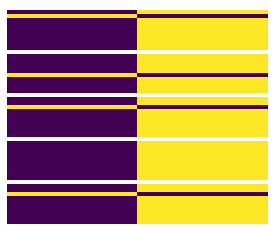

0.1 0.1
Mixed


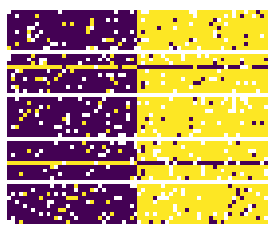

Separate


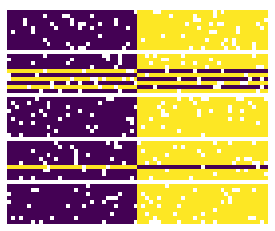

0.1 0.5
Mixed


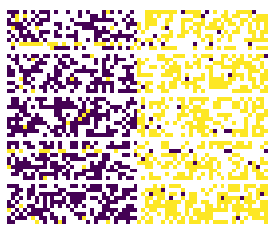

Separate


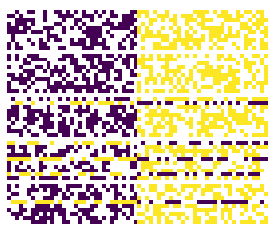

0.1 0.9
Mixed


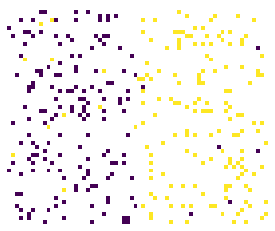

Separate


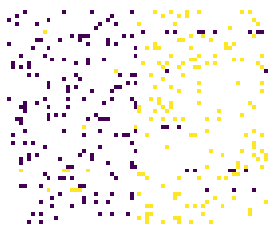

0.2 0
Mixed


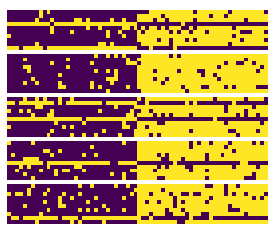

Separate


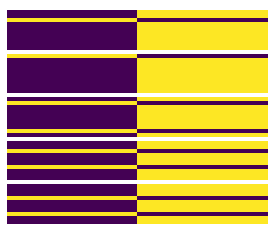

0.2 0.1
Mixed


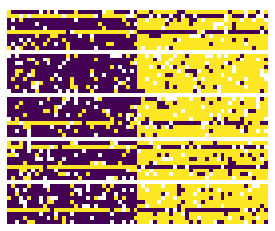

Separate


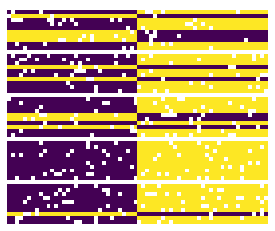

0.2 0.5
Mixed


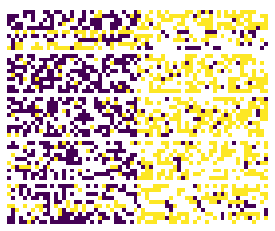

Separate


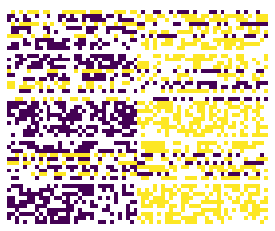

0.2 0.9
Mixed


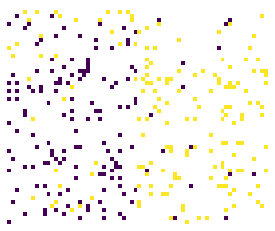

Separate


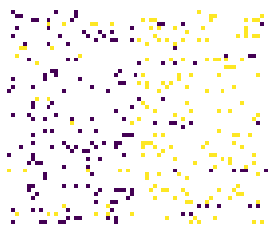

0.35 0
Mixed


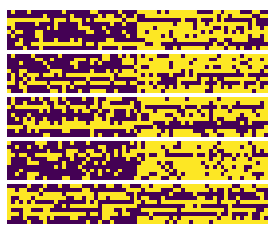

Separate


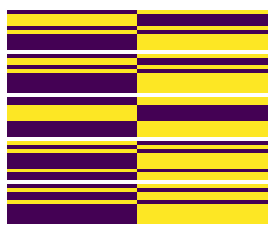

0.35 0.1
Mixed


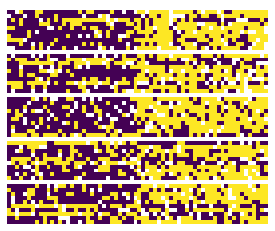

Separate


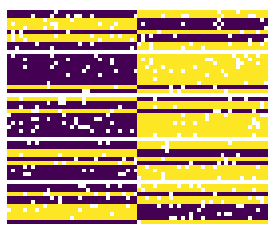

0.35 0.5
Mixed


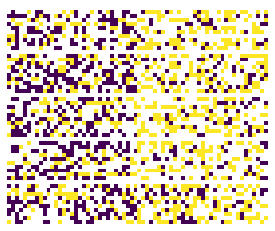

Separate


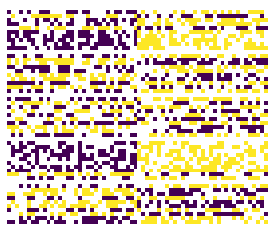

0.35 0.9
Mixed


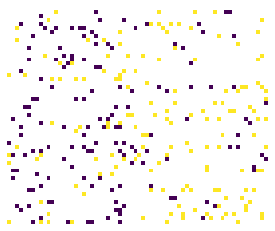

Separate


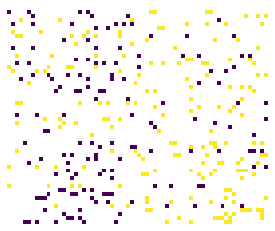

0.5 0
Mixed


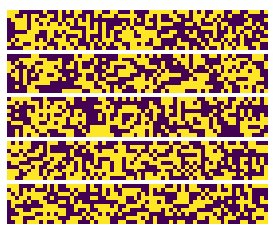

Separate


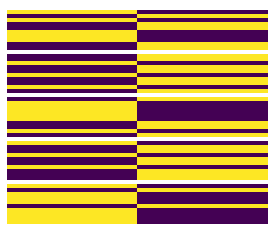

0.5 0.1
Mixed


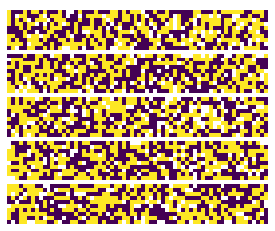

Separate


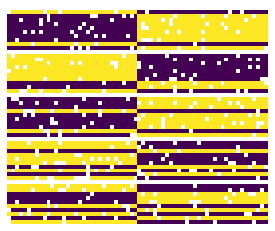

0.5 0.5
Mixed


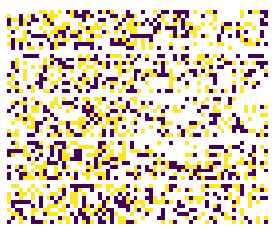

Separate


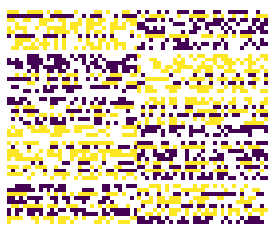

0.5 0.9
Mixed


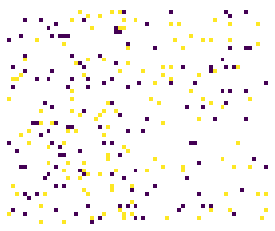

Separate


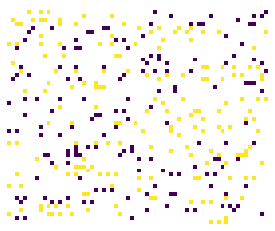

In [243]:
simuls = {}
# for perc in [0.1, 0.25, 0.5]:
#     for perc_nan in [0, 0.1, 0.5, 0.9]:        
#         print(perc, perc_nan)
#         print('Mixed')
#         simuls = plot_pics_mix(perc, perc_nan=perc_nan, mixed=True, simulated_samples=simuls)
#         print('Separate')
#         simuls = plot_pics_mix(perc, perc_nan=perc_nan, mixed=False, simulated_samples=simuls)
        
# for perc in [0.1, 0.25, 0.5]:
for perc in [0, 0.1, 0.2, 0.35, 0.5]:#0.25, 0.5]:
    for perc_nan in [0, 0.1, 0.5, 0.9]:        
    # for perc_nan in [0]:#, 0.1, 0.5, 0.9]:        
        print(perc, perc_nan)
        print('Mixed')
        simuls = plot_pics_mix(perc, perc_nan=perc_nan, mixed=True, simulated_samples=simuls)
        print('Separate')
        simuls = plot_pics_mix(perc, perc_nan=perc_nan, mixed=False, simulated_samples=simuls)

In [244]:
simuls_av = {}
for key in simuls.keys():
#    print(simuls[key].shape)
    simuls_av[key] = np.zeros((S,2*Ng))
    for i in range(S):
        simuls_av[key][i,:] = np.nanmean(simuls[key][10*i:10*(i+1),:], axis=0)

/var/folders/v_/gtsrj3xs0_131ltxwg51r_f40000gn/T/ipykernel_47151/929760510.py:6: RuntimeWarning: Mean of empty slice
  simuls_av[key][i,:] = np.nanmean(simuls[key][10*i:10*(i+1),:], axis=0)


In [245]:
simuls_av_sam = {}
for key in simuls.keys():
#    print(simuls[key].shape)
    simuls_av_sam[key] = np.nanmean(simuls_av[key], axis=0)

/var/folders/v_/gtsrj3xs0_131ltxwg51r_f40000gn/T/ipykernel_47151/124794092.py:4: RuntimeWarning: Mean of empty slice
  simuls_av_sam[key] = np.nanmean(simuls_av[key], axis=0)


In [246]:
b = np.zeros(2*Ng)
x0 = np.zeros(2*Ng)
b[:Ng] = 1.
b[Ng:] = -1.
x0[:Ng] = 0.
x0[Ng:] = 1.

In [247]:
simuls_ba = {}
for key in simuls.keys():
    # print(simuls[key].shape)
    sum_nonans = np.sum(~np.isnan(simuls_av_sam[key]) * 1.)
    nonans = ~np.isnan(simuls_av_sam[key]) * 1.
    simuls_ba[key] = np.dot(np.nan_to_num(simuls_av_sam[key]) - x0, nonans* b) / sum_nonans

{'Raw_0_0': 0.0, 'Raw_0_0_True': 0.0, 'Raw_0_0_False_dots': 0.0, 'Raw_0_0_False_lines': 0.0, 'Raw_0_0.1': 0.0, 'Raw_0_0.1_True': 0.0, 'Raw_0_0.1_False_dots': 0.0, 'Raw_0_0.1_False_lines': 0.0, 'Raw_0_0.5': 0.0, 'Raw_0_0.5_True': 0.0, 'Raw_0_0.5_False_dots': 0.0, 'Raw_0_0.5_False_lines': 0.0, 'Raw_0_0.9': 0.0, 'Raw_0_0.9_True': 0.0, 'Raw_0_0.9_False_dots': 0.0, 'Raw_0_0.9_False_lines': 0.0, 'Raw_0.1_0': 0.0, 'Raw_0.1_0_True': 0.09393939393939395, 'Raw_0.1_0_False_dots': 0.10134680134680135, 'Raw_0.1_0_False_lines': 0.08888888888888886, 'Raw_0.1_0.1': 0.0, 'Raw_0.1_0.1_True': 0.09216931216931216, 'Raw_0.1_0.1_False_dots': 0.10320466570466572, 'Raw_0.1_0.1_False_lines': 0.0877044252044252, 'Raw_0.1_0.5': 0.0, 'Raw_0.1_0.5_True': 0.07317821067821066, 'Raw_0.1_0.5_False_dots': 0.09423520923520923, 'Raw_0.1_0.5_False_lines': 0.1330627705627706, 'Raw_0.1_0.9': 0.0, 'Raw_0.1_0.9_True': 0.05787037037037037, 'Raw_0.1_0.9_False_dots': 0.10814393939393939, 'Raw_0.1_0.9_False_lines': 0.110101010101

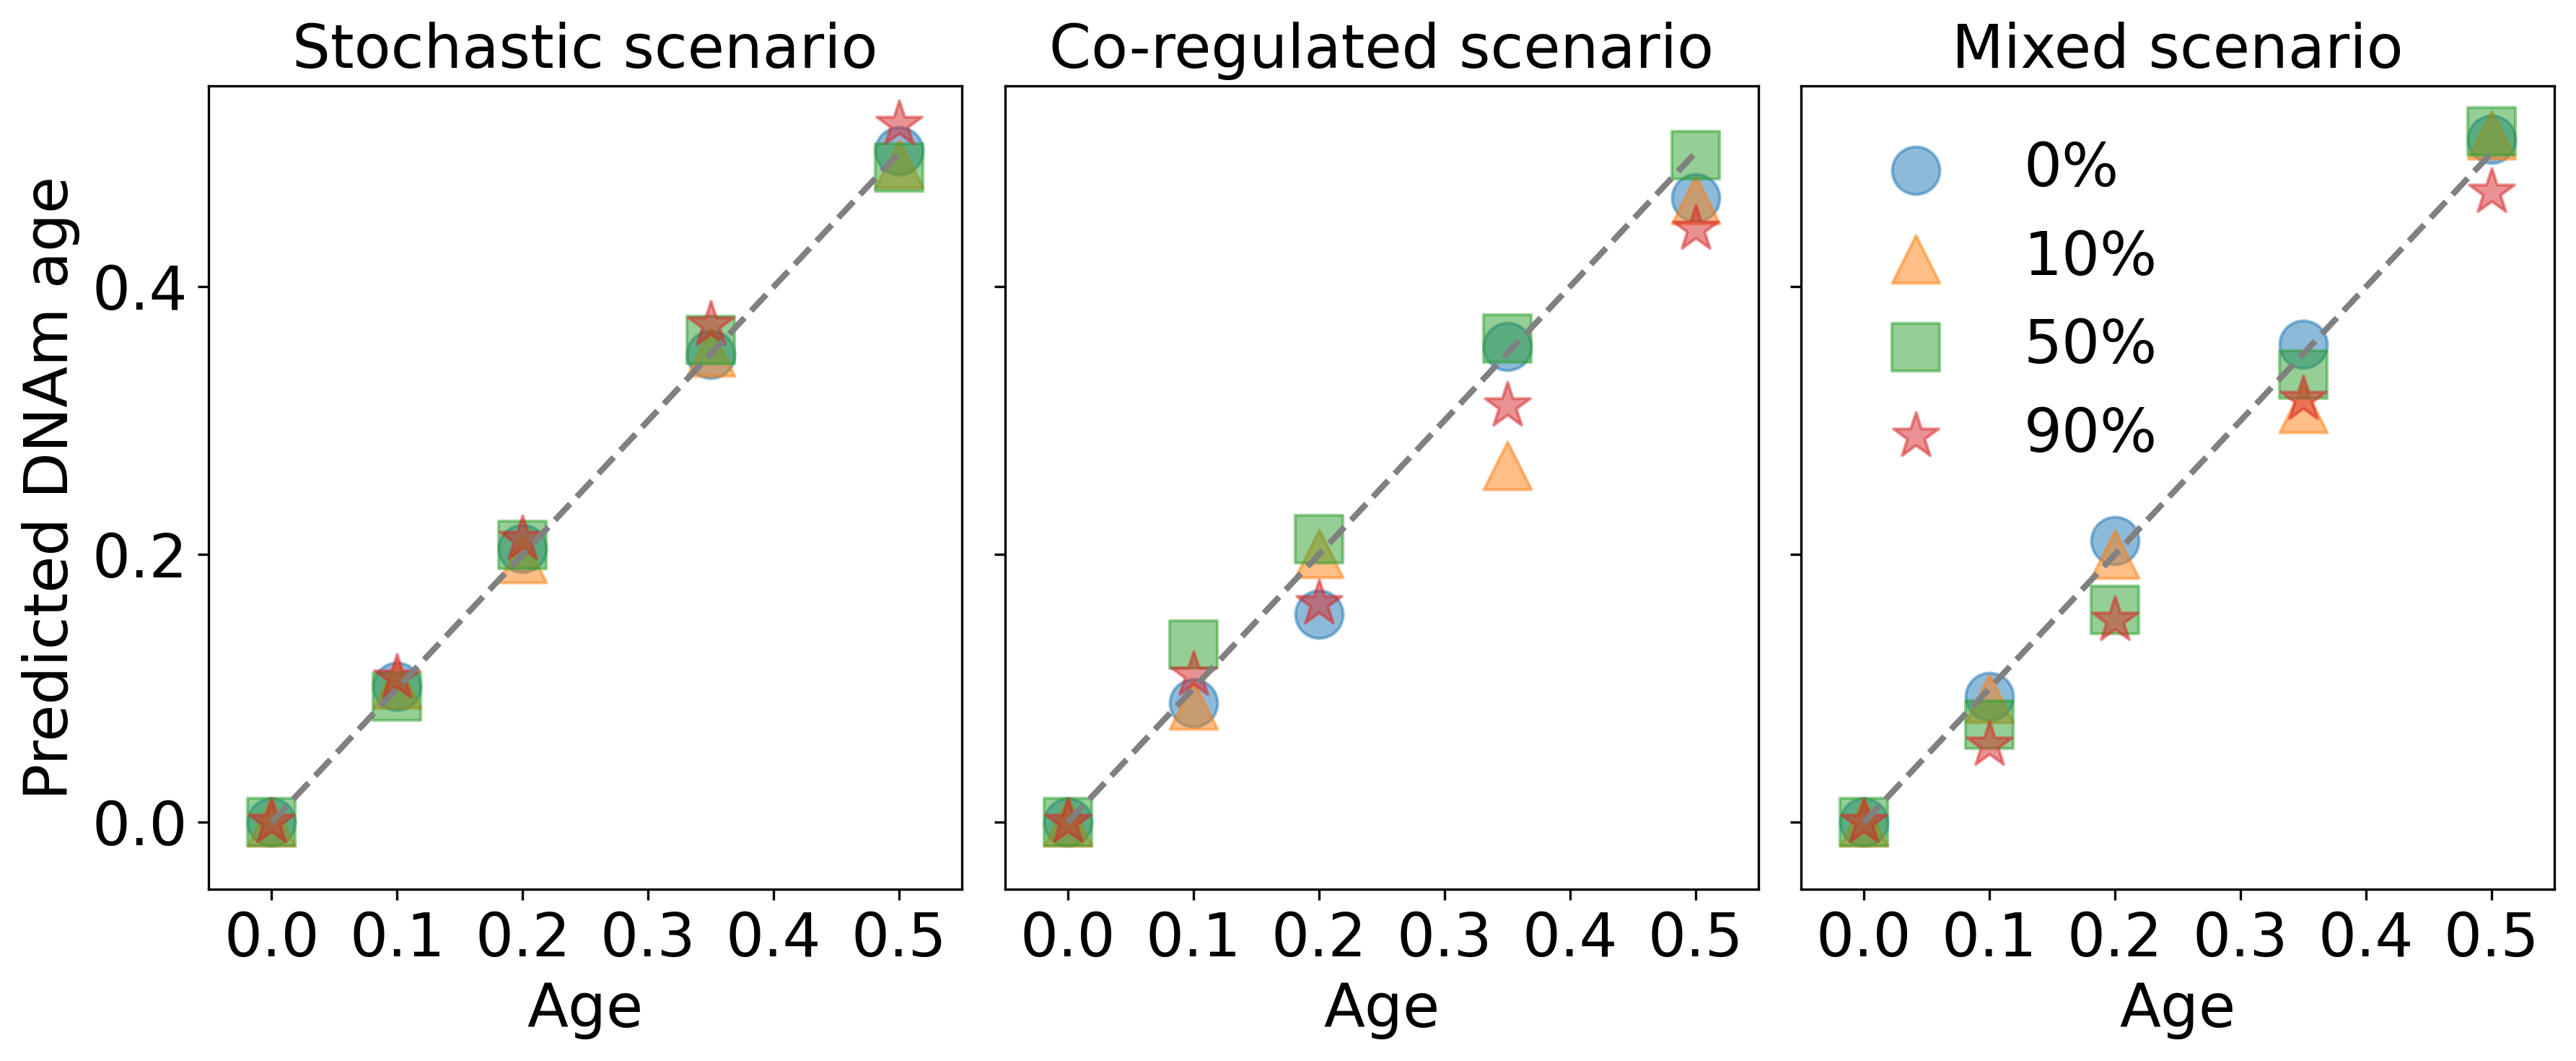

In [251]:
print(simuls_ba)


perc_nans = [0, 0.1, 0.5, 0.9]
# perc_nans = [0.9]
percs = [0, 0.1, 0.2, 0.35, 0.5]#, 0.7, 0.9]
mark = {'dots': 'o',
        'lines': '^'}
mark_sp = {0: 'o',
        0.1: '^',
        0.5:'s',
       0.9:'*'
       }

cols = {0: 'g',
        0.1: 'b',
        0.5:'brown',
       0.9:'r'
       }

fig, ax = plt.subplots(1,3,figsize=(4*3,5), dpi=300, sharex=True, sharey=True)
for perc_nan in perc_nans: 
    x,y = [],[]
    for mixed in [True, False]:
        if mixed == False:
            for dots_lines in ['lines', 'dots']:
                x,y = [],[]
                for perc in percs:#[0.1, 0.25, 0.5]:
                    key = f'Raw_{perc}_{perc_nan}_{mixed}_{dots_lines}'
                    x.append(perc)
                    y.append(simuls_ba[key])
                if dots_lines == 'dots':
                    ax[0].scatter(x,y, label=f'{int(perc_nan*100)}%', marker=mark_sp[perc_nan],#marker=mark[dots_lines],color=cols[perc_nan], 
                                  s=250, alpha=0.5)
                elif dots_lines == 'lines':
                    ax[1].scatter(x,y, label=f'{int(perc_nan*100)}%', marker=mark_sp[perc_nan],#mark[dots_lines],color=cols[perc_nan], 
                                  s=250, alpha=0.5)
        else:
            x,y = [],[]
            for perc in percs:#[0.1, 0.25, 0.5]:
                key = f'Raw_{perc}_{perc_nan}_{mixed}'
                x.append(perc)
                y.append(simuls_ba[key])
            ax[2].scatter(x, y, label=f'{int(perc_nan*100)}%', marker=mark_sp[perc_nan],#'s',color=cols[perc_nan], 
                          s=250, alpha=0.5)
            
[ax[i].plot([0,0.5],[0,0.5], lw=2, color='gray', linestyle='dashed') for i in range(3)]
[ax[i].legend(loc='upper left', fontsize=20, frameon=False) for i in range(2,3)]
ax[0].set_ylabel('Predicted DNAm age')
[ax[i].set_xlabel('Age') for i in range(3)]
[ax[i].set_xlim([-0.05,0.55]) for i in range(3)]
[ax[i].set_ylim([-0.05,0.55]) for i in range(3)]
[ax[i].set_xticks([0, 0.1, 0.2, 0.3,0.4,0.5]) for i in range(3)]
ax[0].set_title('Stochastic scenario')
ax[1].set_title('Co-regulated scenario')
ax[2].set_title('Mixed scenario')
plt.tight_layout()
for form in ['png', 'pdf', 'jpg']:
    plt.savefig(f'PICS/{form}/Scenarios_Predicted_DNAm_age.{form}', format=form, dpi=300)
plt.show()

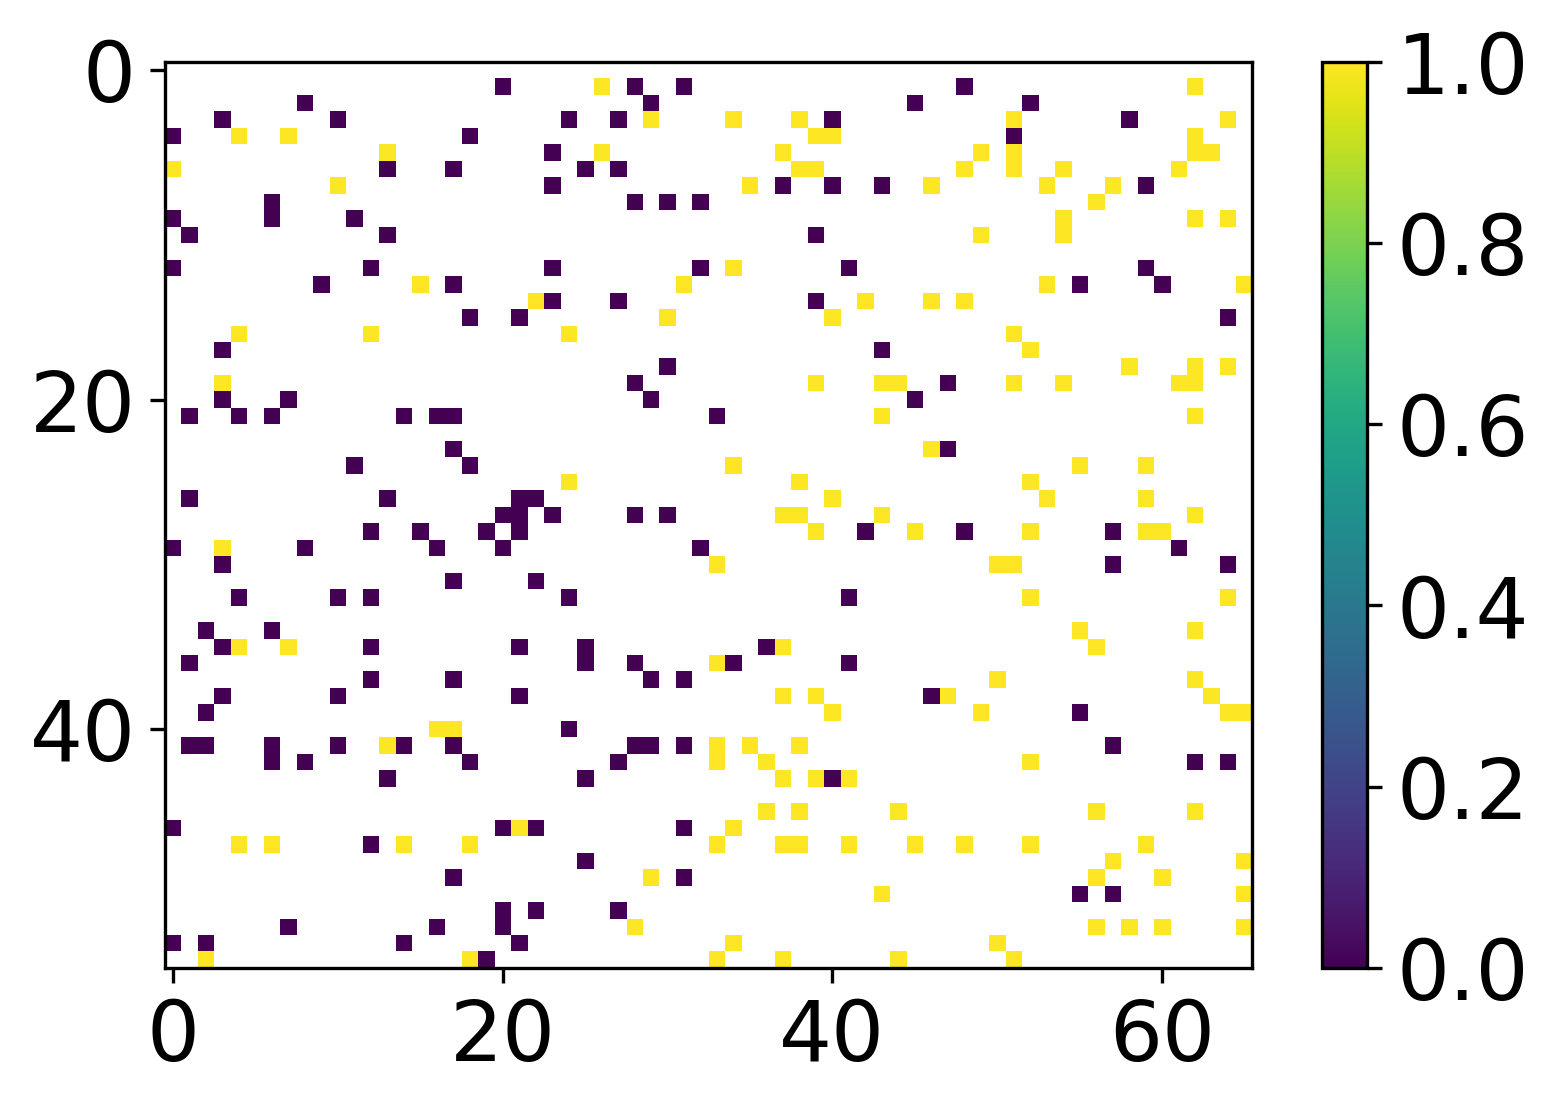

AttributeError: module 'meth.analytic_tools' has no attribute 'sparce_corr_mat'

In [187]:
simuls.keys()
# simuls[key]

for key in ['Raw_0.2_0.9_False_dots', 'Raw_0.2_0.9_False_lines', 'Raw_0.2_0.9_True']:
    x = simuls[key]
    plt.figure(dpi=300)
    plt.imshow(x)
    plt.colorbar()
    plt.show()
    
    xcov = 10.* (~np.isnan(x))
    xcov[np.isnan(x)] = 0.
    x = np.nan_to_num(x)
    x, xcov = sp.csr_matrix(x), sp.csr_matrix(xcov)
    cov0 = anatools.sparce_corr_mat(x,xcov)
    cov1 = anatools.sparce_corr_mat(x,xcov, axis=1)
    cov0 = np.array(cov0.todense())
    cov1 = np.array(cov1.todense())
    print('Gene correlations')
    plt.figure(dpi=300)
    plt.imshow(cov0)
    plt.colorbar()
    plt.show()
    plt.figure(dpi=300)
    plt.imshow(cov1)
    plt.colorbar()
    plt.show()
    cov0 = np.nan_to_num(cov0)
    cov1 = np.nan_to_num(cov1)

    print('Sample correlations')
    
    plt.figure(dpi=300)
    evals, evecs = sp.linalg.eigs(cov0,k=5)
    plt.plot(evecs[:,0])
    plt.xlabel('CpG')
    plt.ylabel('Eigenvector 1')
    plt.show()

    plt.figure(dpi=300)
    evals, evecs = sp.linalg.eigs(cov1,k=5)
    plt.plot(evecs[:,0])
    plt.xlabel('Sample ID')
    plt.ylabel('Eigenvector 1')
    plt.show()

In [ ]:
simuls.keys()
# simuls[key]

for key in ['Raw_0.2_0_False_dots', 'Raw_0.2_0_False_lines', 'Raw_0.2_0_True']:
    x = simuls[key]
    plt.figure(dpi=300)
    plt.imshow(x)
    plt.colorbar()
    plt.show()

    xcov = 10.* (~np.isnan(x))
    xcov[np.isnan(x)] = 0.
    x, xcov = sp.csr_matrix(x), sp.csr_matrix(xcov)
    cov0 = anatools.sparce_corr_mat(x,xcov)
    cov1 = anatools.sparce_corr_mat(x,xcov, axis=1)
    plt.figure(dpi=300)
    plt.imshow(cov0.todense())
    plt.colorbar()
    plt.show()
    plt.figure(dpi=300)
    plt.imshow(cov1.todense())
    plt.colorbar()
    plt.show()

    plt.figure(dpi=300)
    evals, evecs = sp.linalg.eigs(cov0.todense(),k=5)
    plt.plot(evecs[:,0])
    plt.xlabel('CpG')
    plt.ylabel('Eigenvector 1')
    plt.show()

    plt.figure(dpi=300)
    evals, evecs = sp.linalg.eigs(cov1.todense(),k=5)
    plt.plot(evecs[:,0])
    plt.xlabel('Sample ID')
    plt.ylabel('Eigenvector 1')
    plt.show()

In [ ]:
simuls.keys()
# simuls[key]

x = simuls['Raw_0.2_0_True']
plt.figure(dpi=300)
plt.imshow(x)
plt.colorbar()
plt.show()

xcov = 10.* (~np.isnan(x))
xcov[np.isnan(x)] = 0.
x, xcov = sp.csr_matrix(x), sp.csr_matrix(xcov)
cov0 = anatools.sparce_corr_mat(x,xcov)
cov1 = anatools.sparce_corr_mat(x,xcov, axis=1)
plt.figure(dpi=300)
plt.imshow(cov0.todense())
plt.colorbar()
plt.show()
plt.figure(dpi=300)
plt.imshow(cov1.todense())
plt.colorbar()
plt.show()

evals, evecs = sp.linalg.eigs(cov0.todense(),k=5)
plt.plot(evecs[:,0])
plt.show()

evals, evecs = sp.linalg.eigs(cov1.todense(),k=5)
plt.plot(evecs[:,0])
plt.show()

dict_keys(['Raw_0_0', 'Raw_0_0_True', 'Raw_0_0_False_dots', 'Raw_0_0_False_lines', 'Raw_0_0.1', 'Raw_0_0.1_True', 'Raw_0_0.1_False_dots', 'Raw_0_0.1_False_lines', 'Raw_0_0.5', 'Raw_0_0.5_True', 'Raw_0_0.5_False_dots', 'Raw_0_0.5_False_lines', 'Raw_0_0.9', 'Raw_0_0.9_True', 'Raw_0_0.9_False_dots', 'Raw_0_0.9_False_lines', 'Raw_0.1_0', 'Raw_0.1_0_True', 'Raw_0.1_0_False_dots', 'Raw_0.1_0_False_lines', 'Raw_0.1_0.1', 'Raw_0.1_0.1_True', 'Raw_0.1_0.1_False_dots', 'Raw_0.1_0.1_False_lines', 'Raw_0.1_0.5', 'Raw_0.1_0.5_True', 'Raw_0.1_0.5_False_dots', 'Raw_0.1_0.5_False_lines', 'Raw_0.1_0.9', 'Raw_0.1_0.9_True', 'Raw_0.1_0.9_False_dots', 'Raw_0.1_0.9_False_lines', 'Raw_0.2_0', 'Raw_0.2_0_True', 'Raw_0.2_0_False_dots', 'Raw_0.2_0_False_lines', 'Raw_0.2_0.1', 'Raw_0.2_0.1_True', 'Raw_0.2_0.1_False_dots', 'Raw_0.2_0.1_False_lines', 'Raw_0.2_0.5', 'Raw_0.2_0.5_True', 'Raw_0.2_0.5_False_dots', 'Raw_0.2_0.5_False_lines', 'Raw_0.2_0.9', 'Raw_0.2_0.9_True', 'Raw_0.2_0.9_False_dots', 'Raw_0.2_0.9_Fal

/var/folders/v_/gtsrj3xs0_131ltxwg51r_f40000gn/T/ipykernel_47151/2841846740.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(7,7),dpi=300)


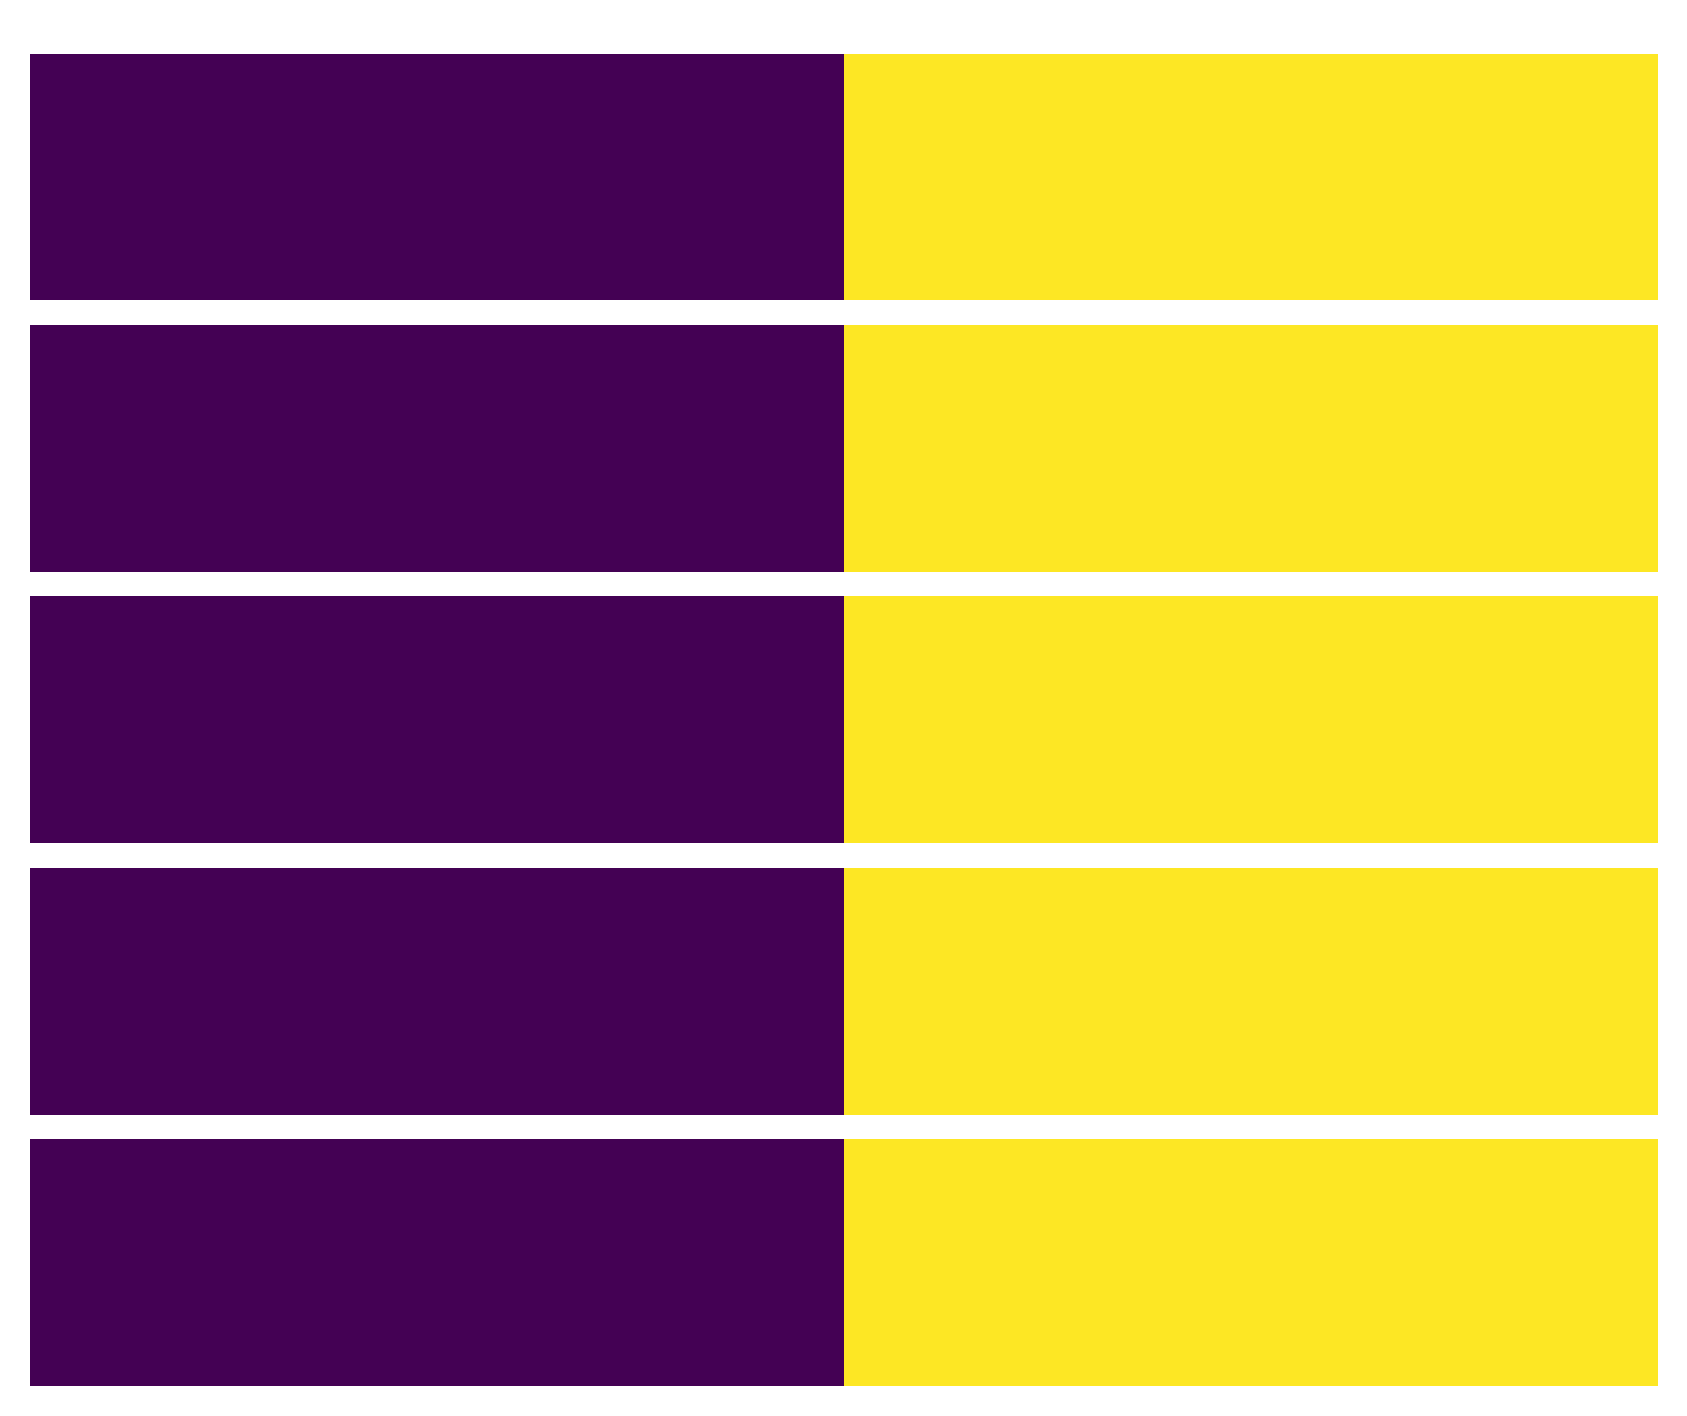

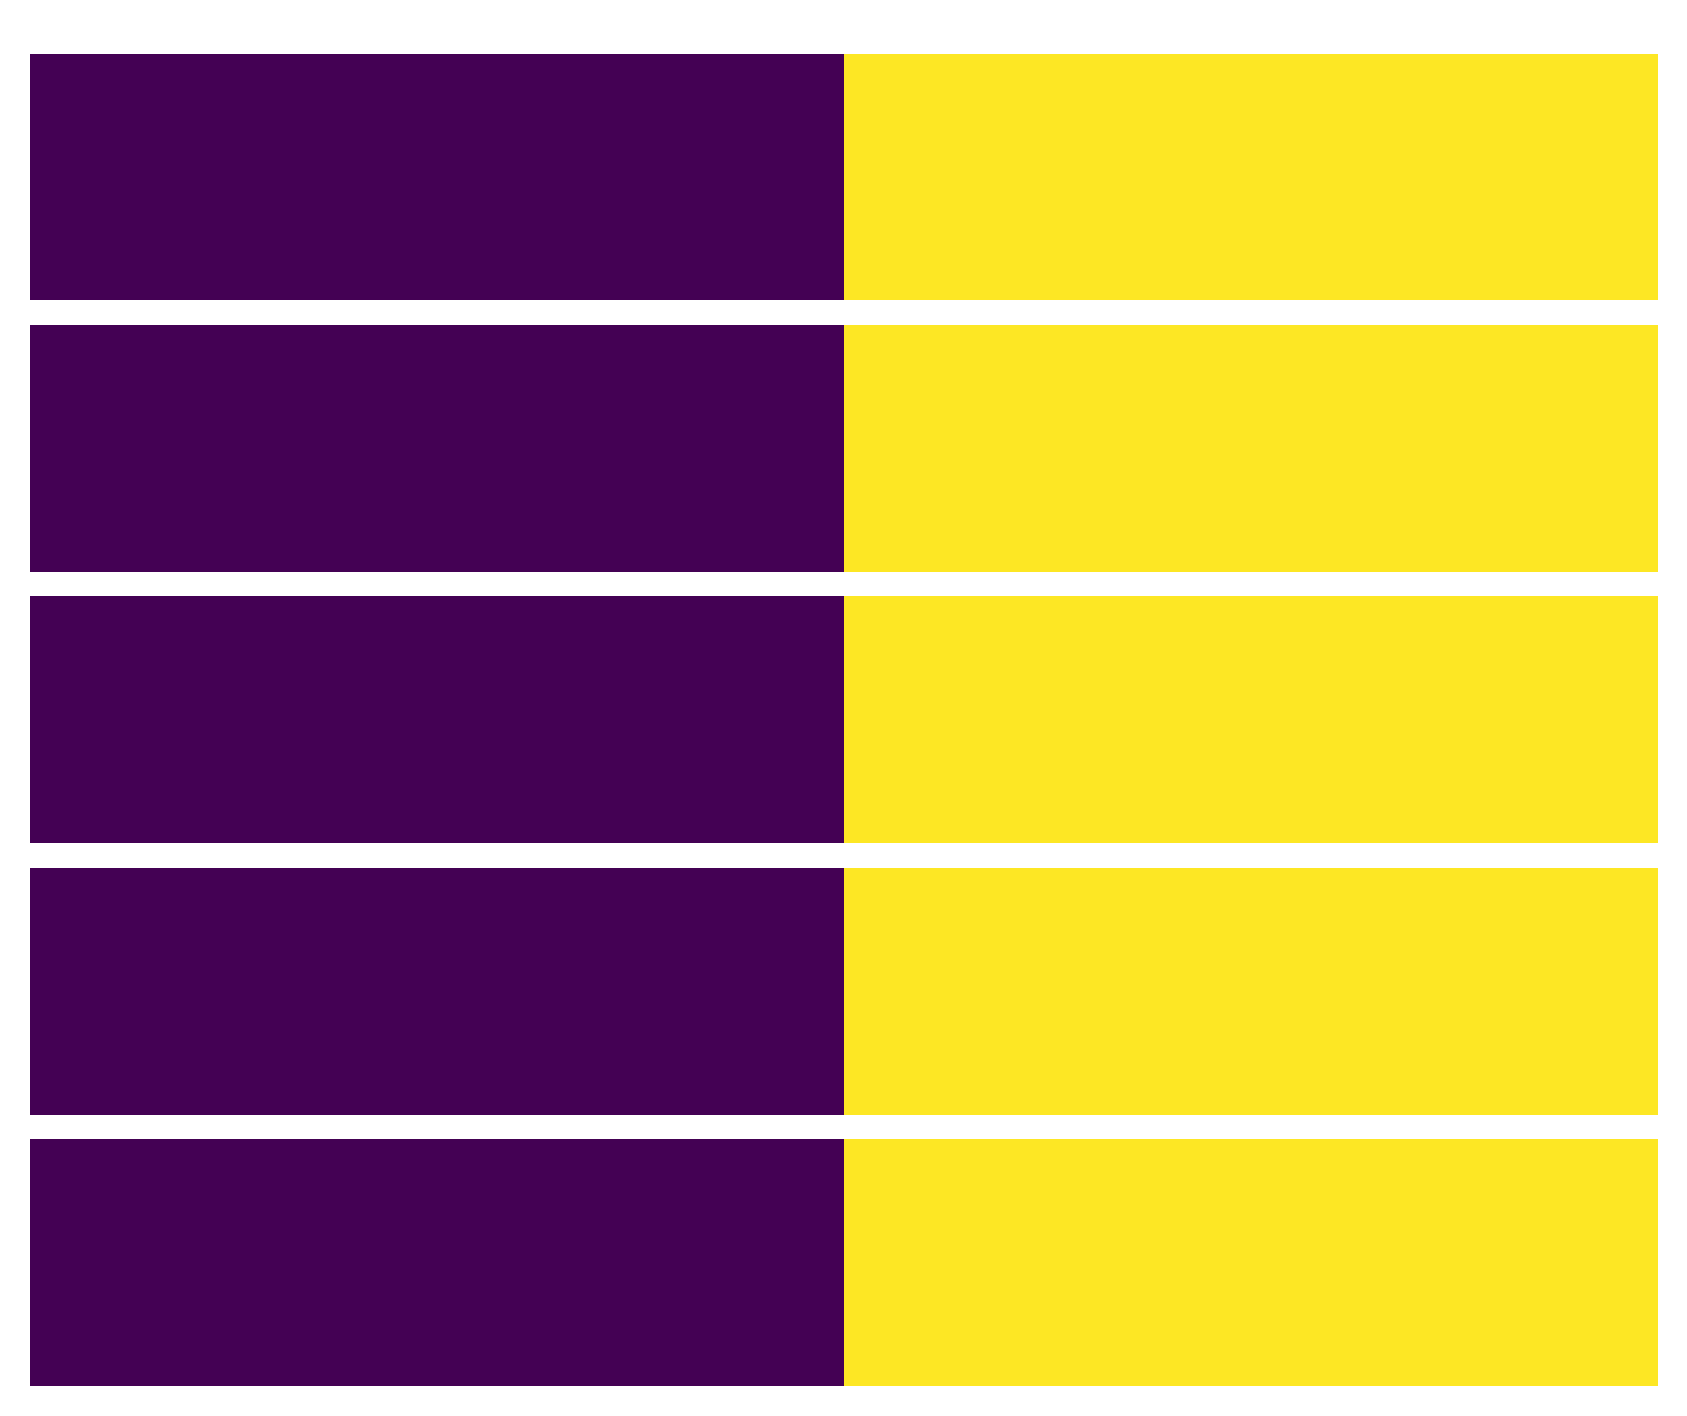

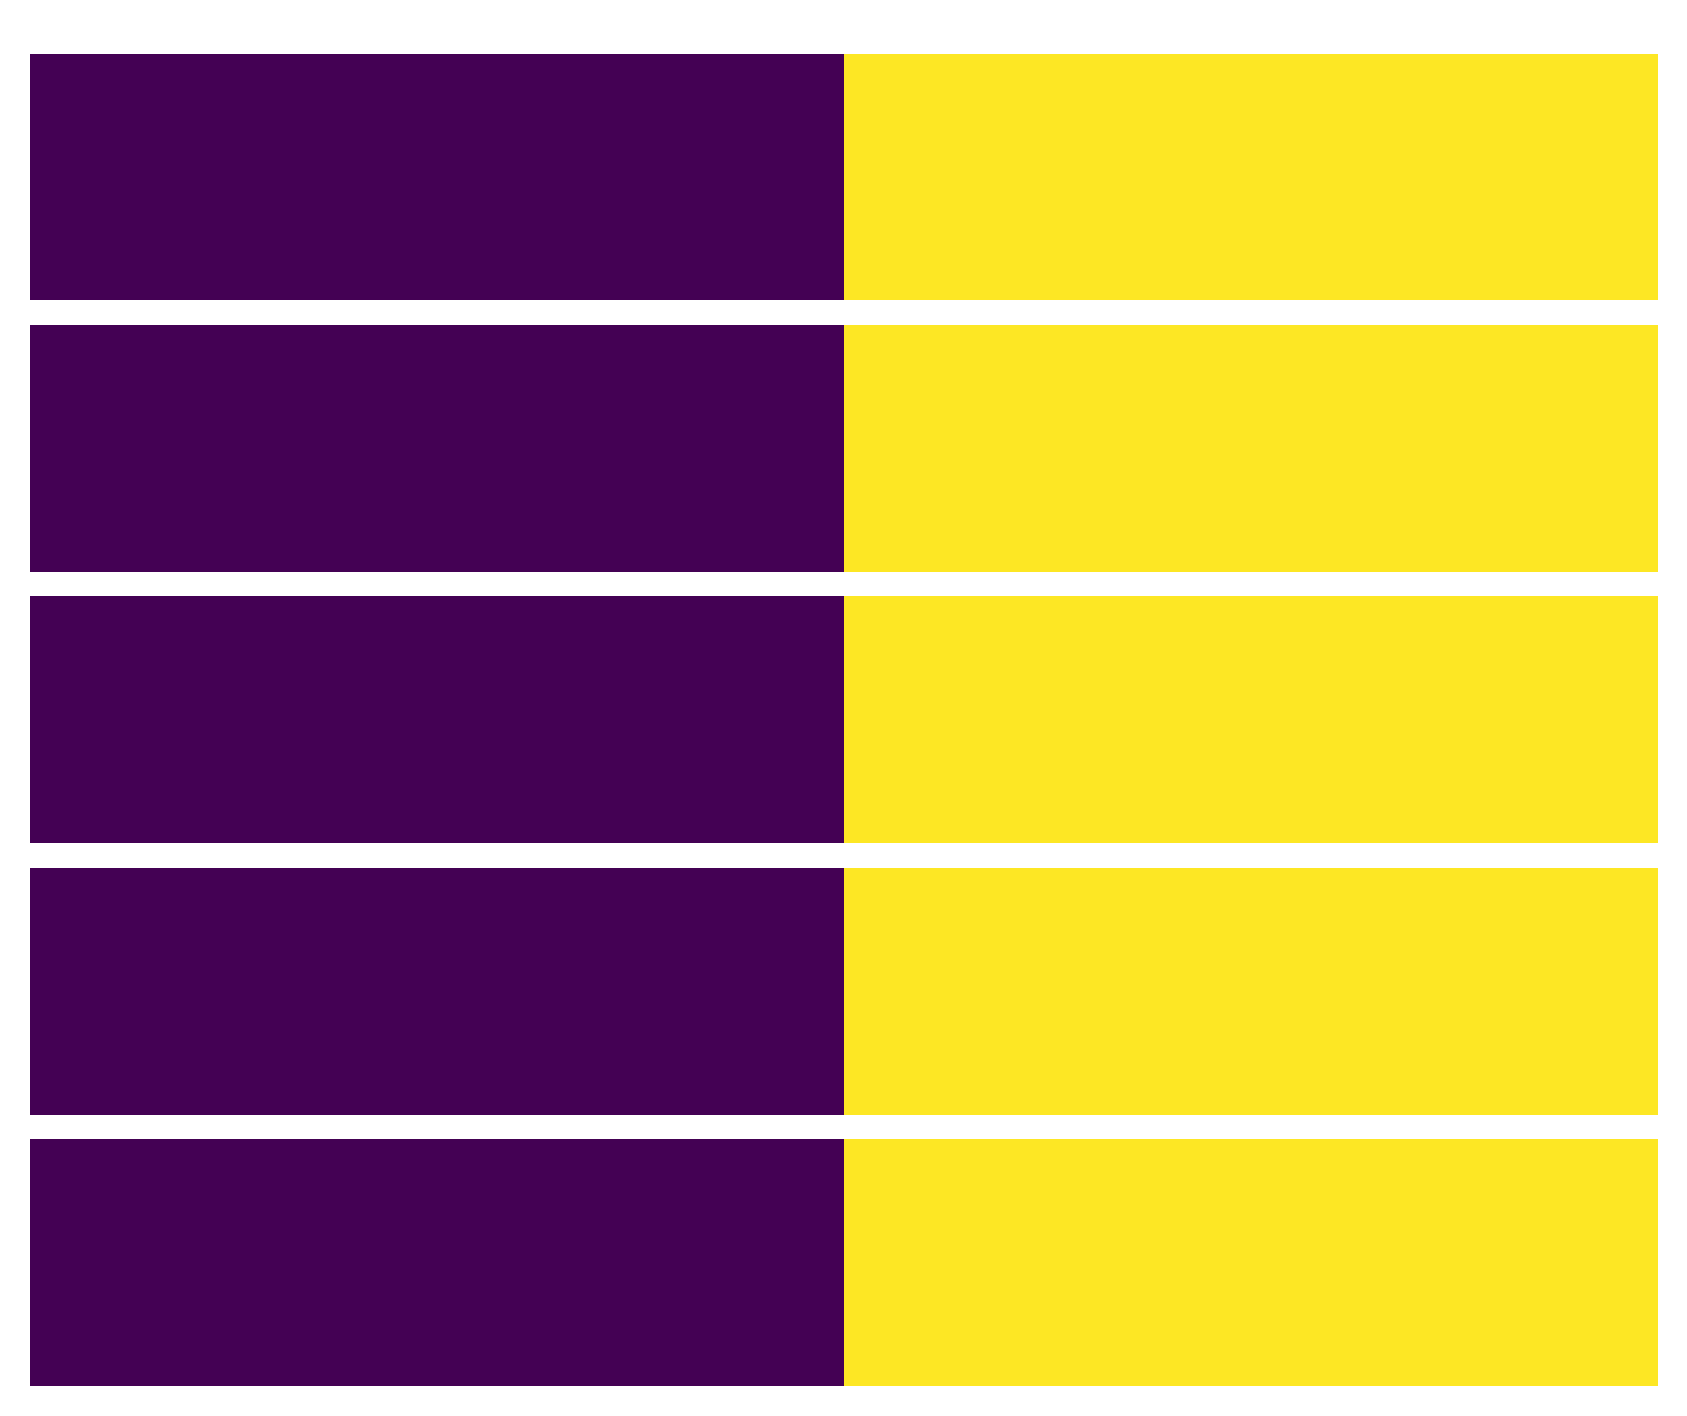

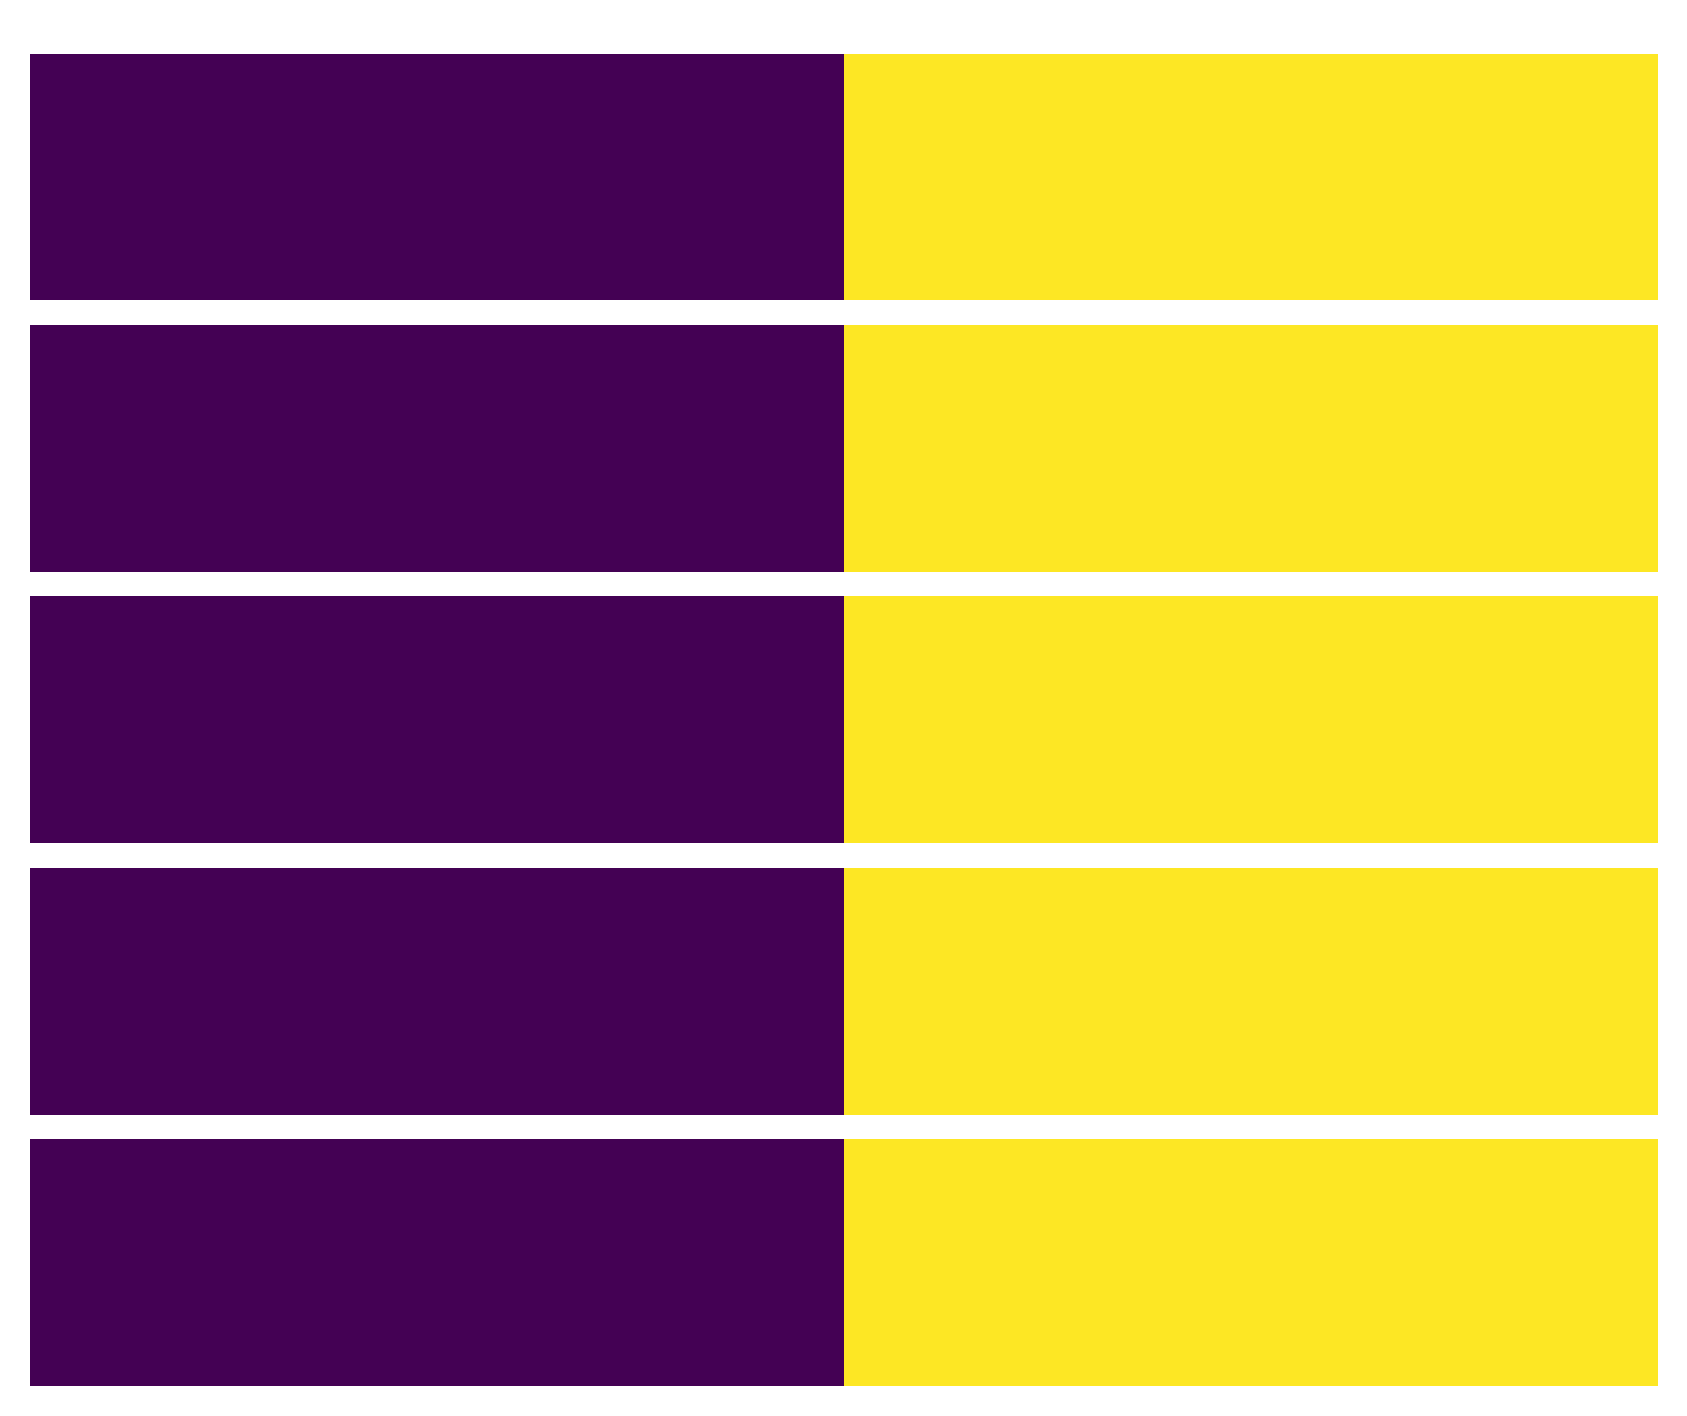

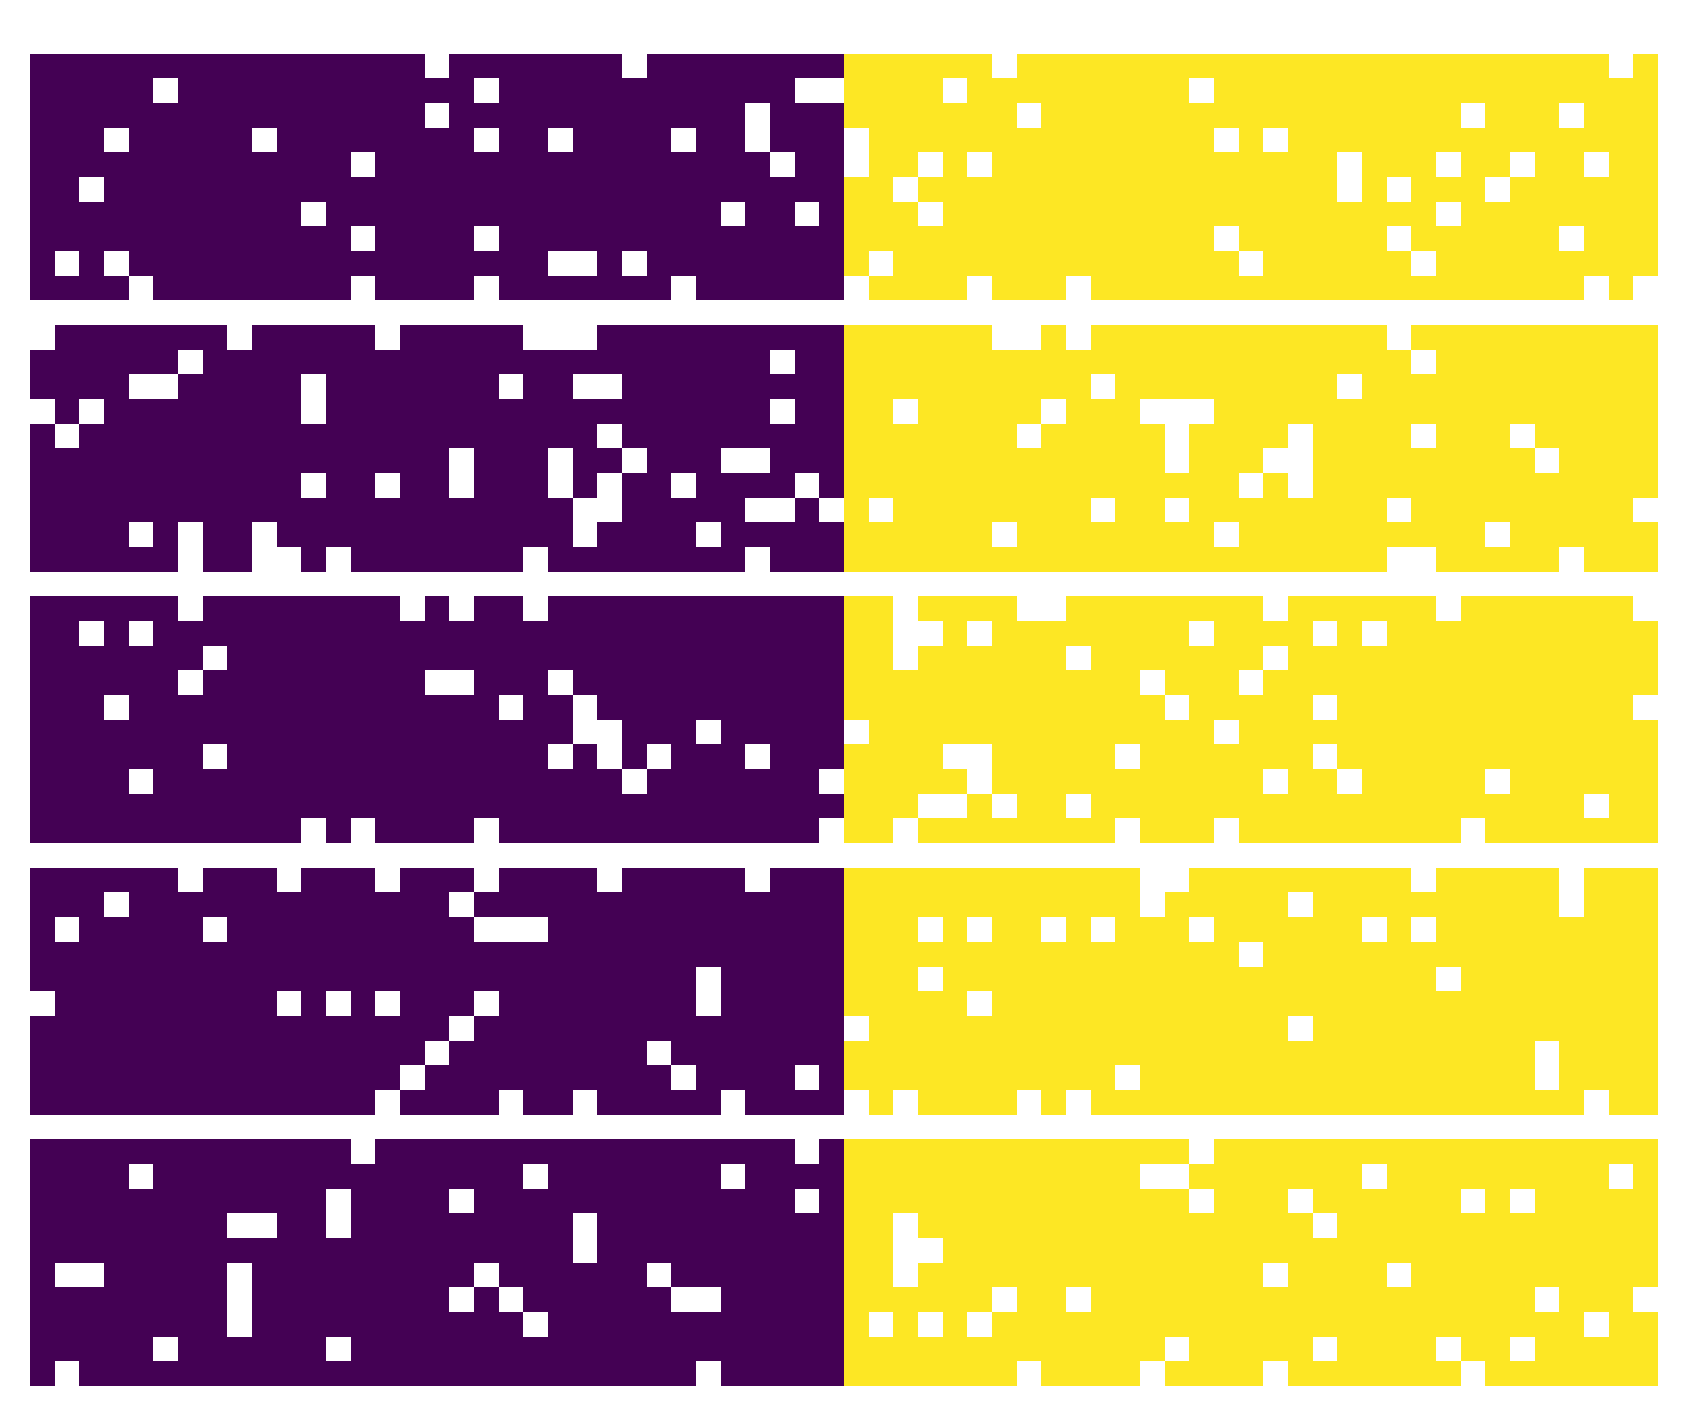

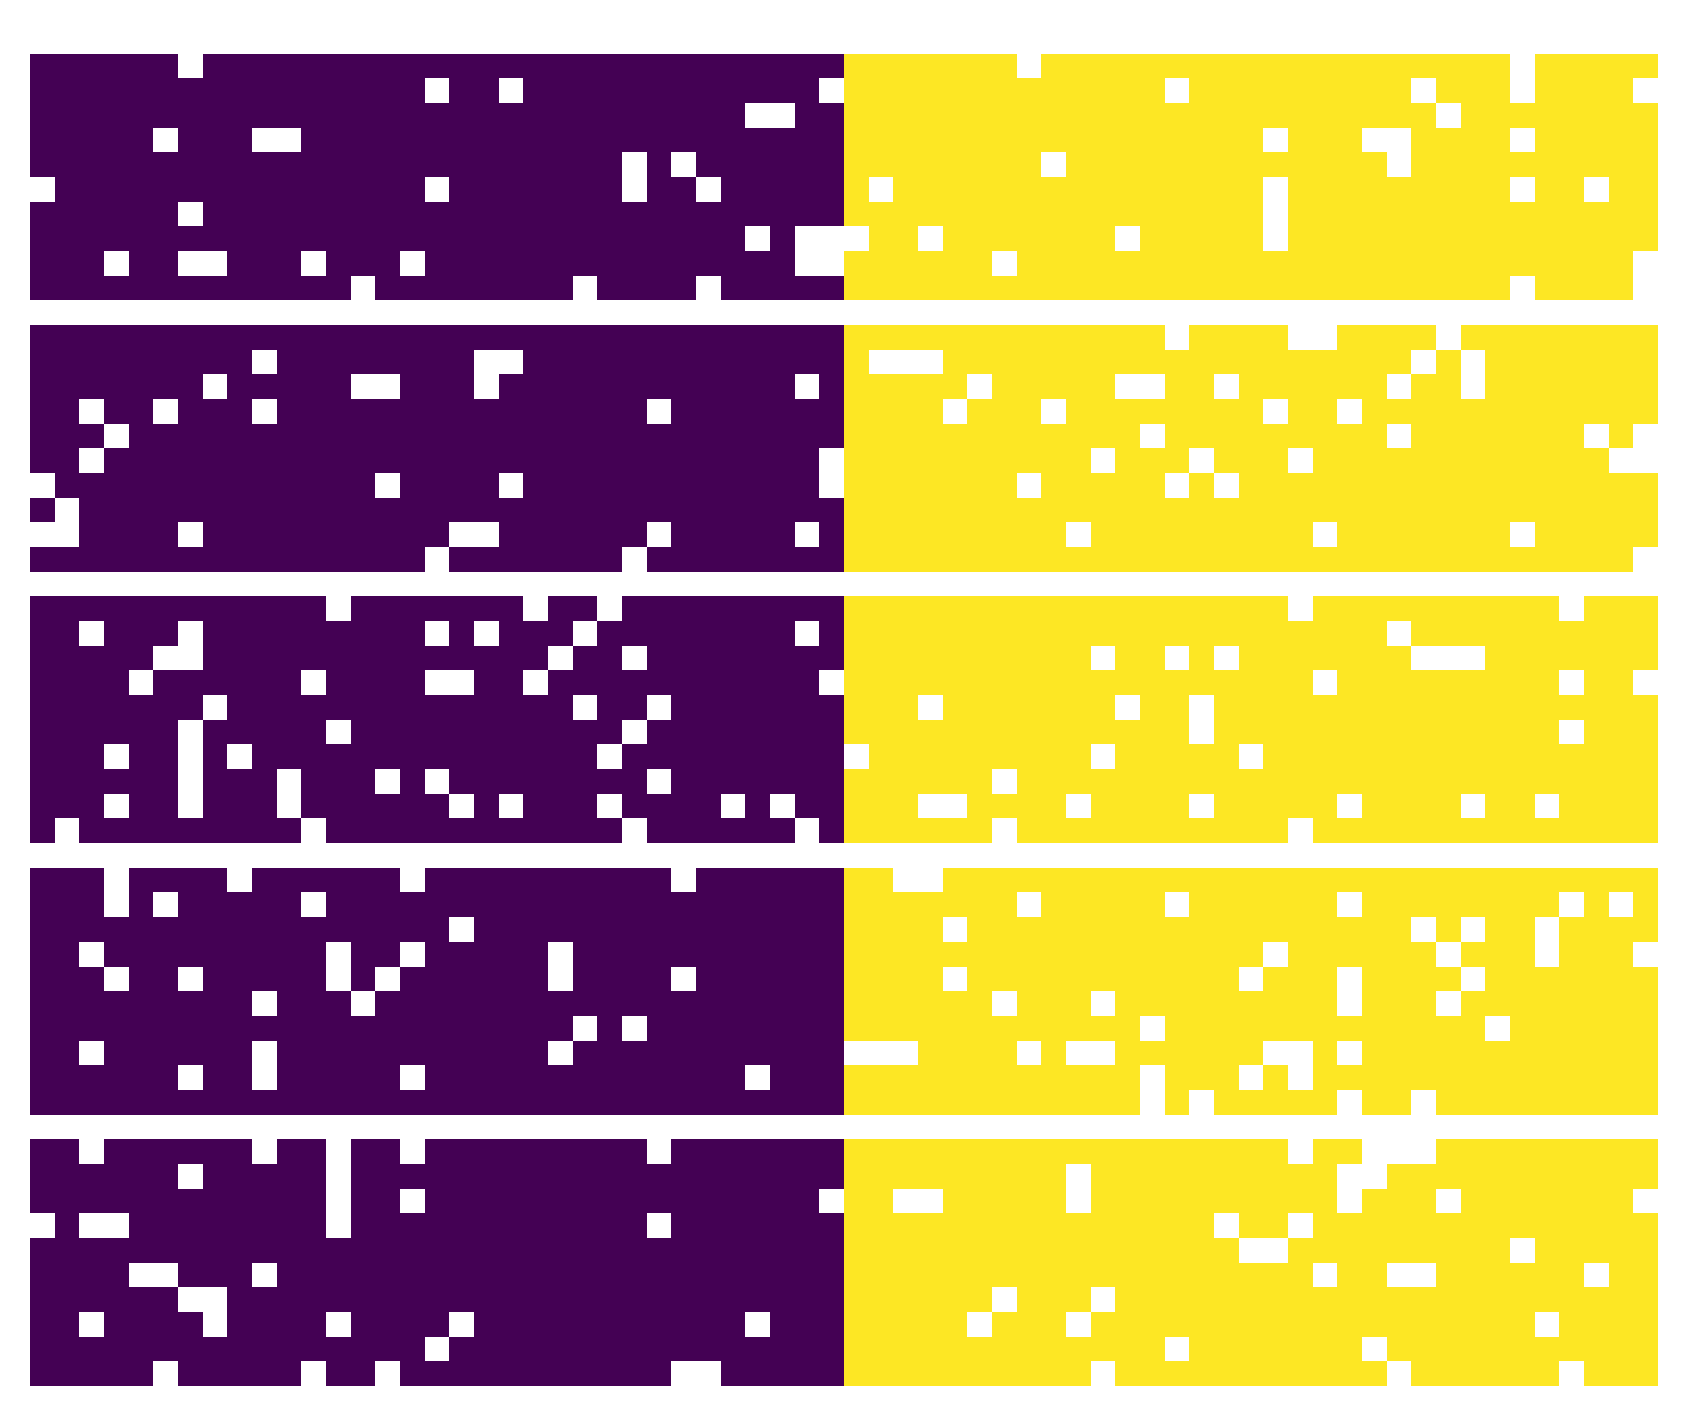

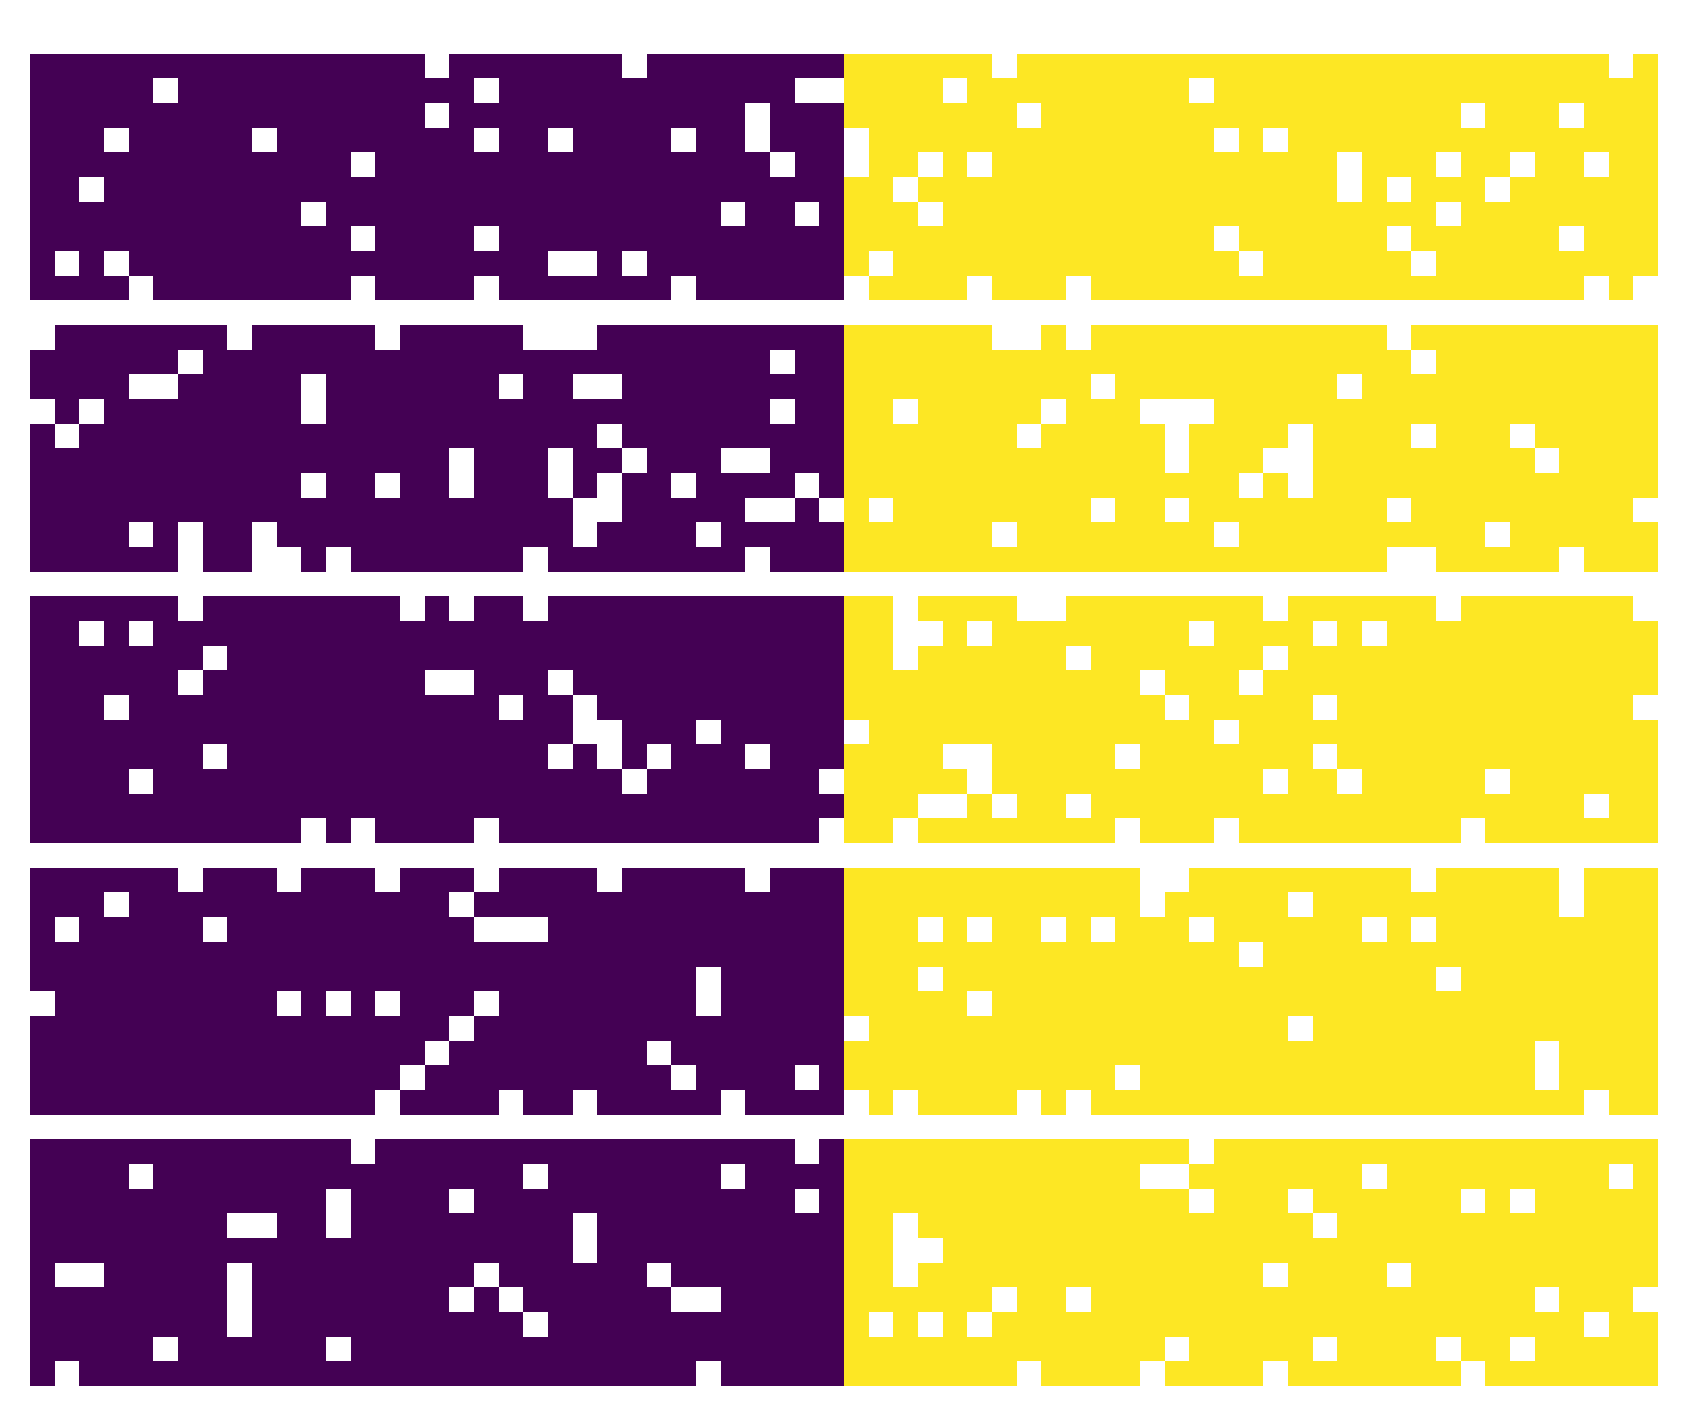

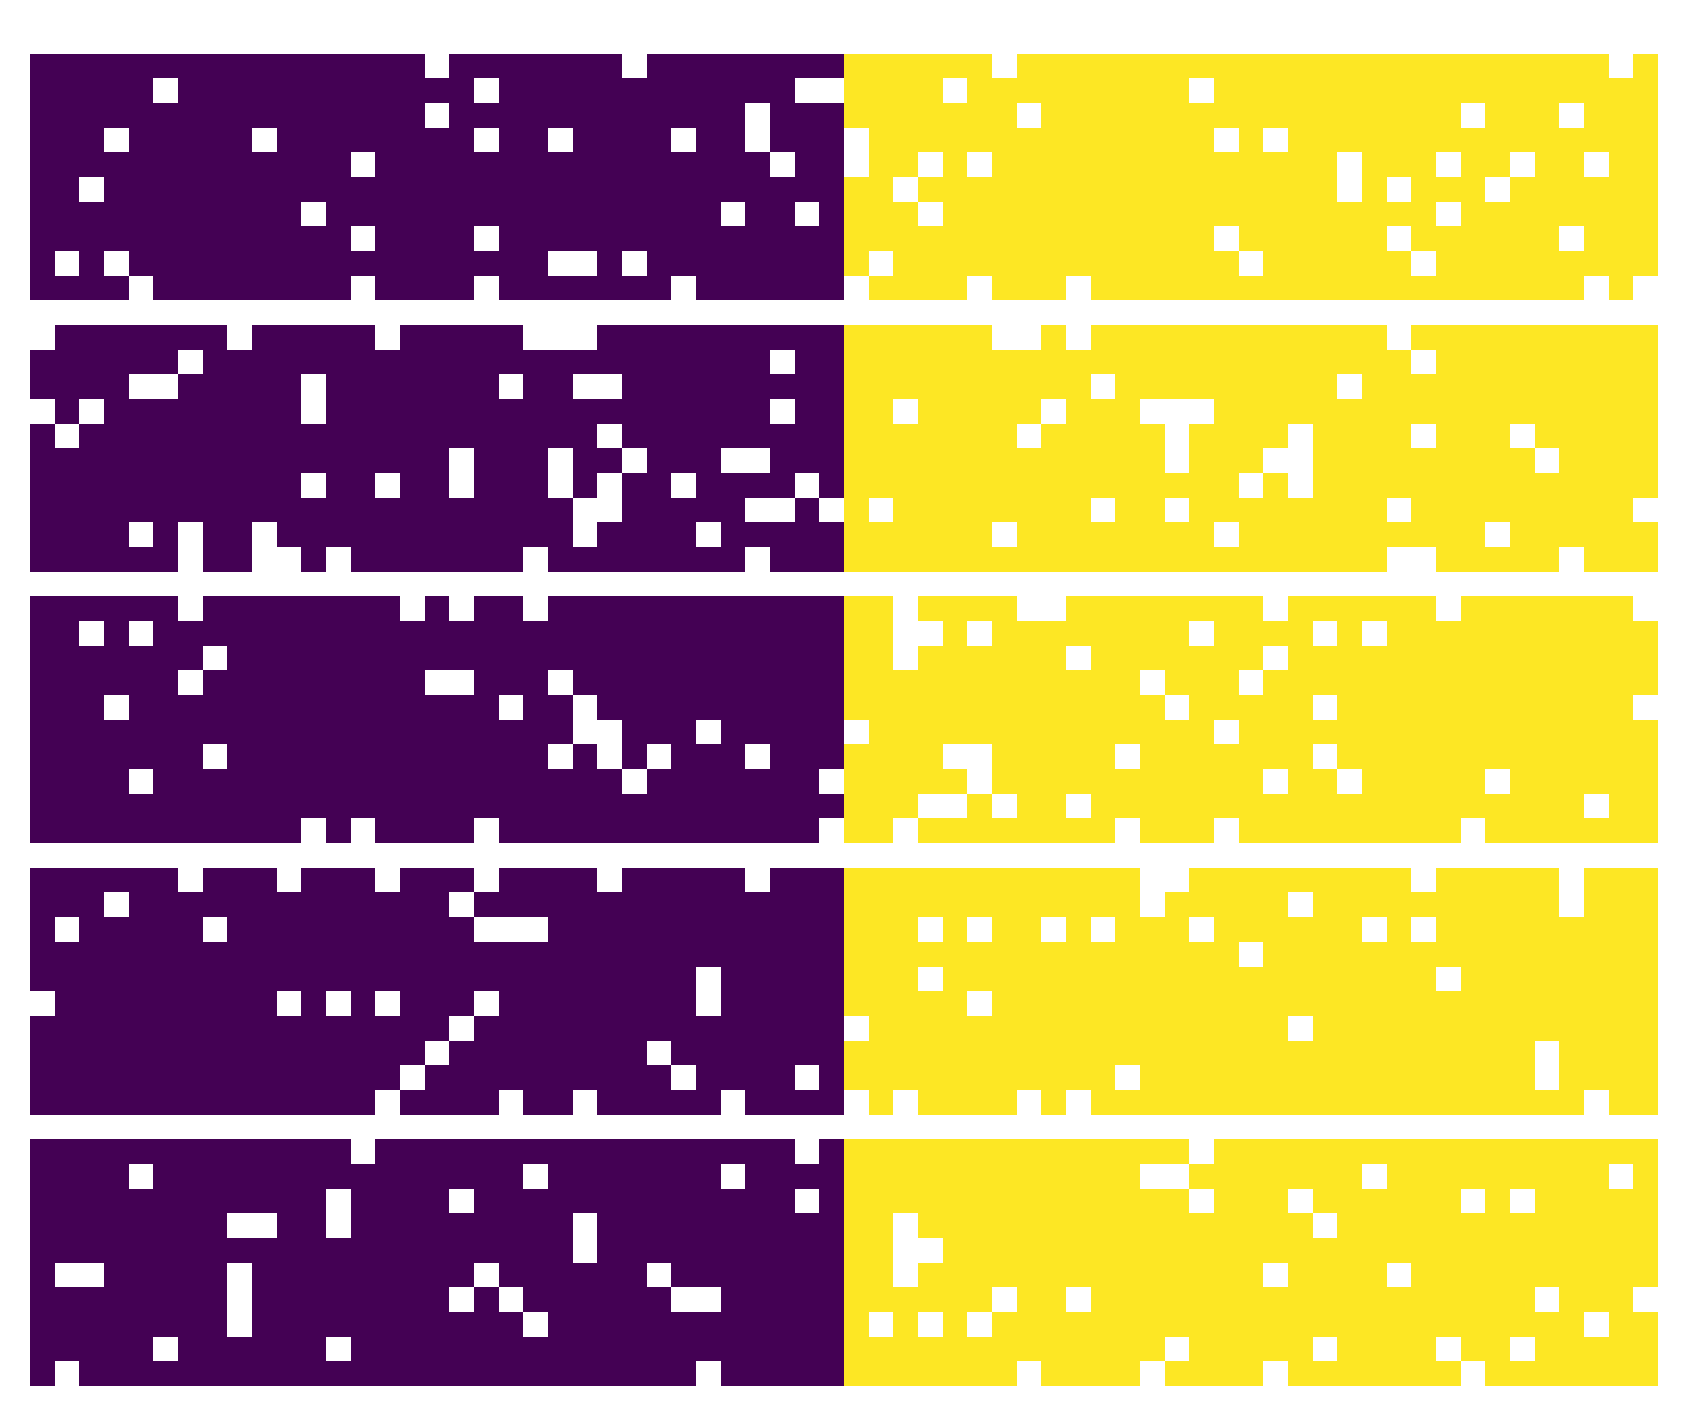

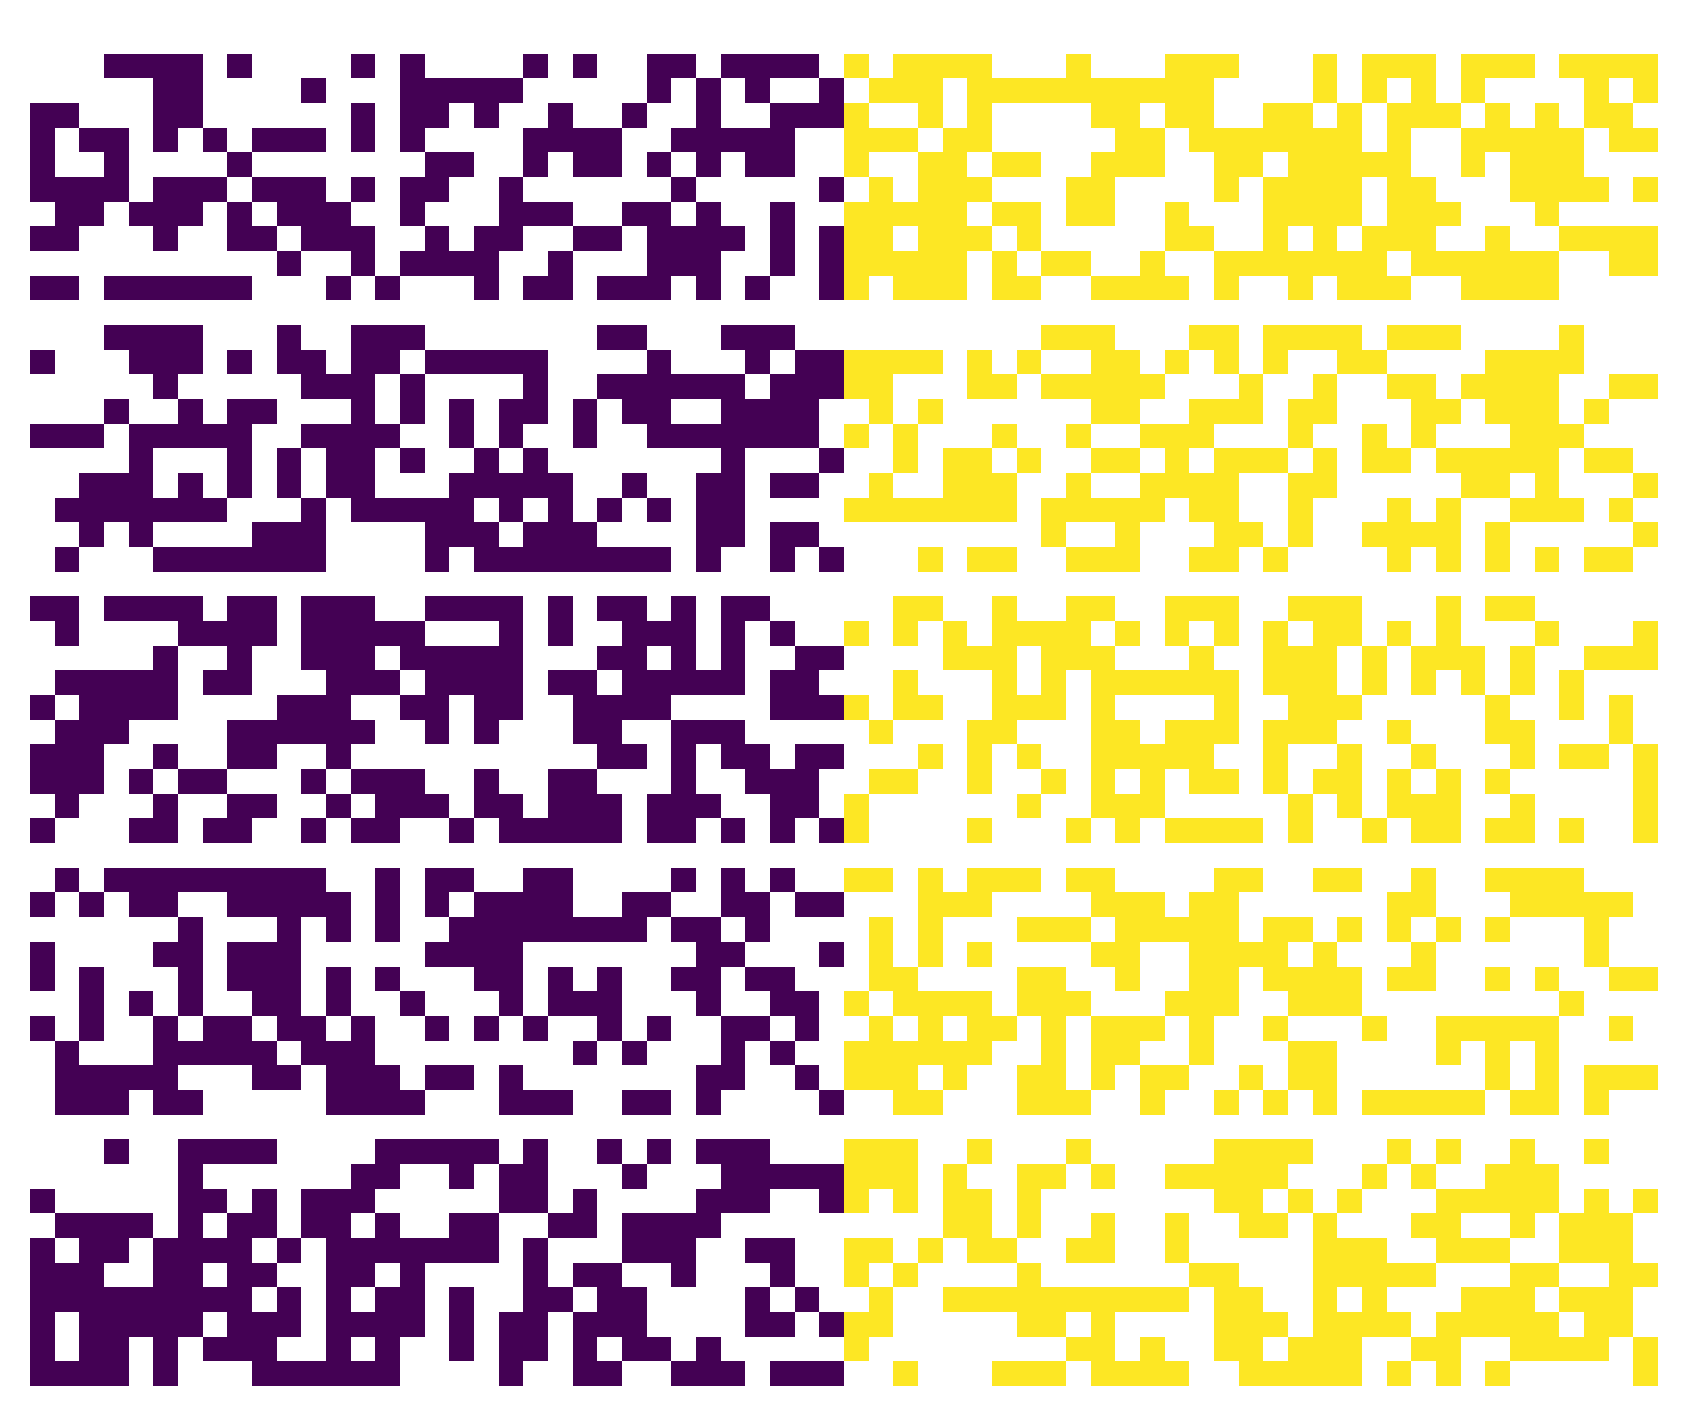

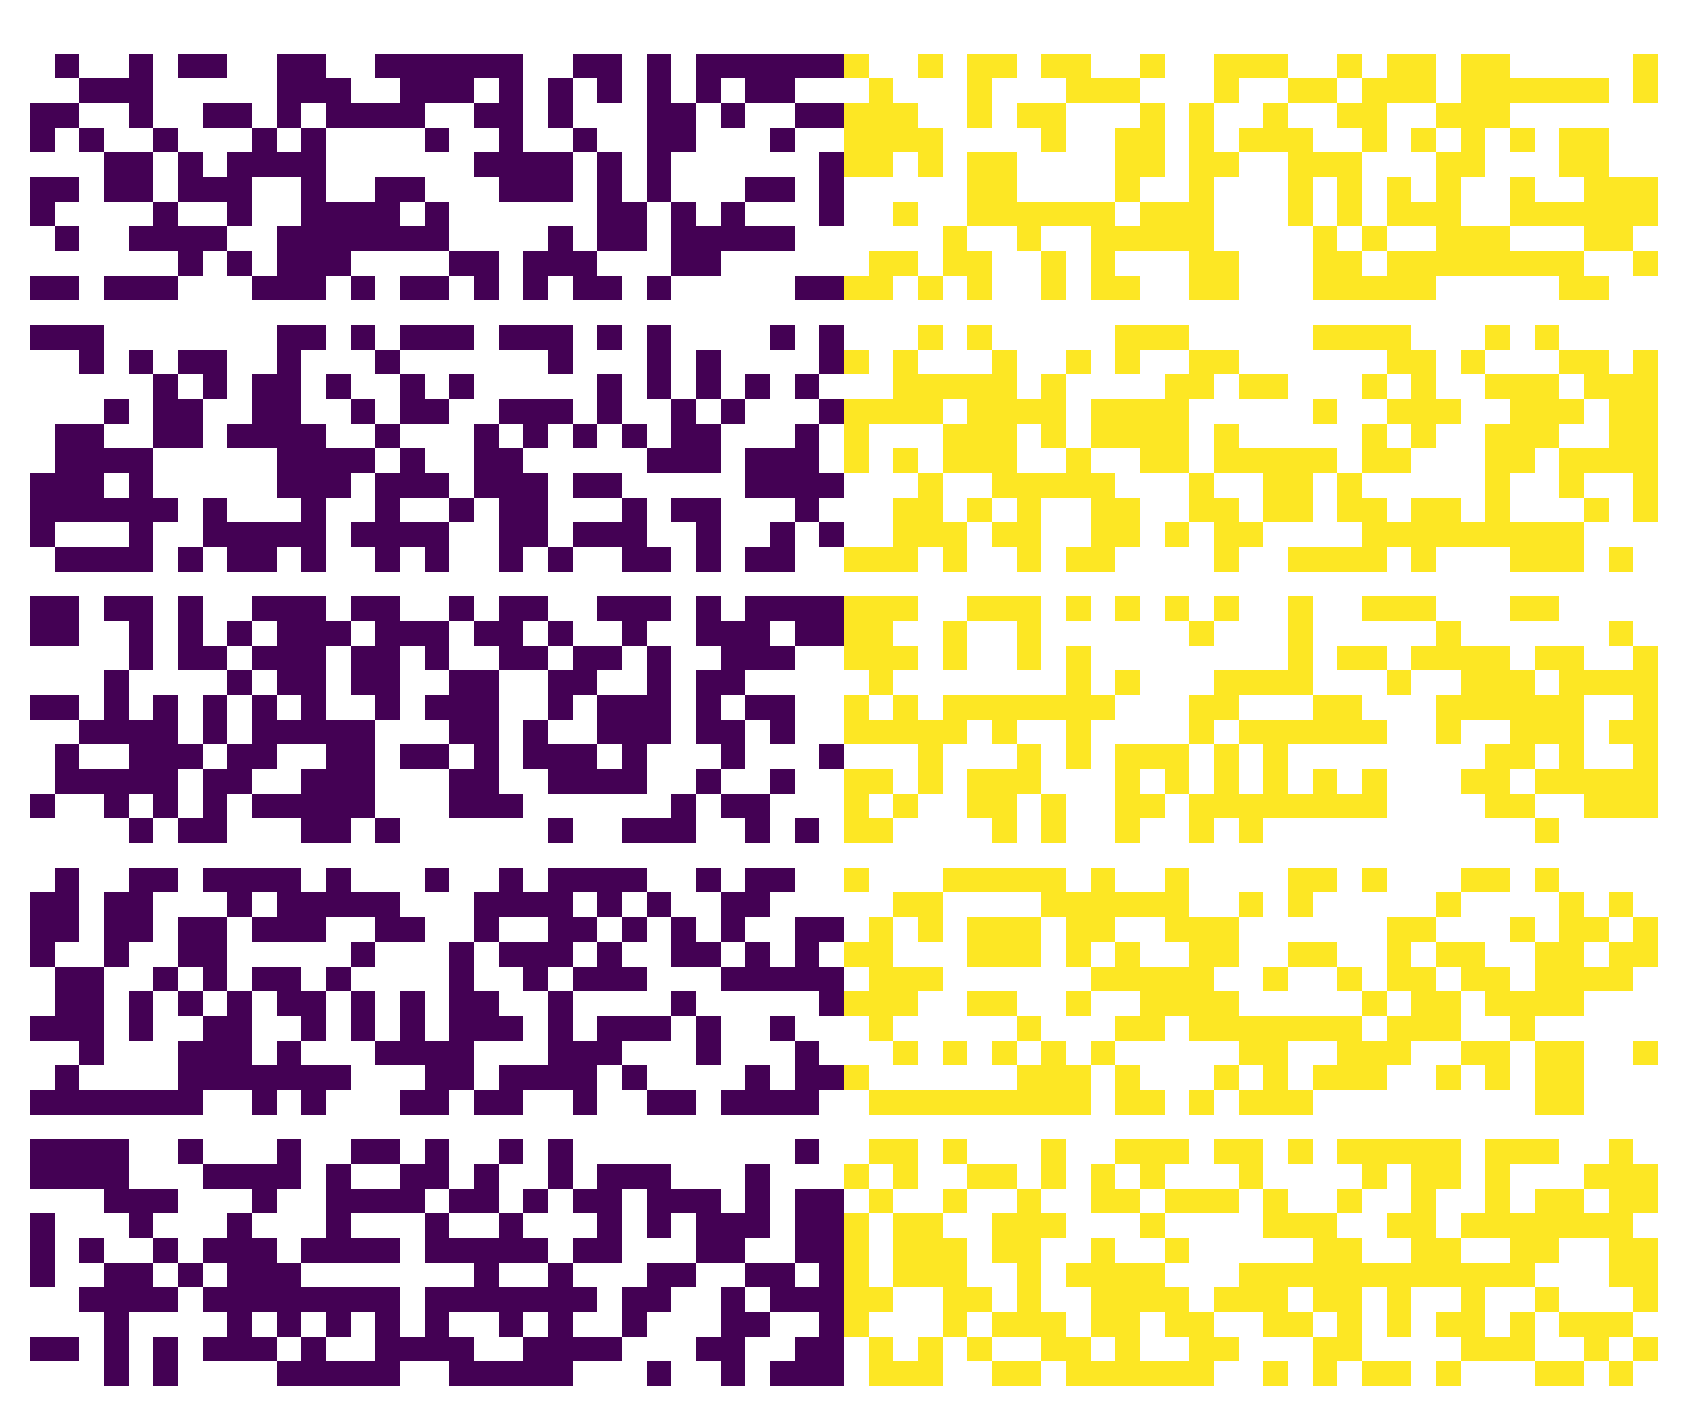

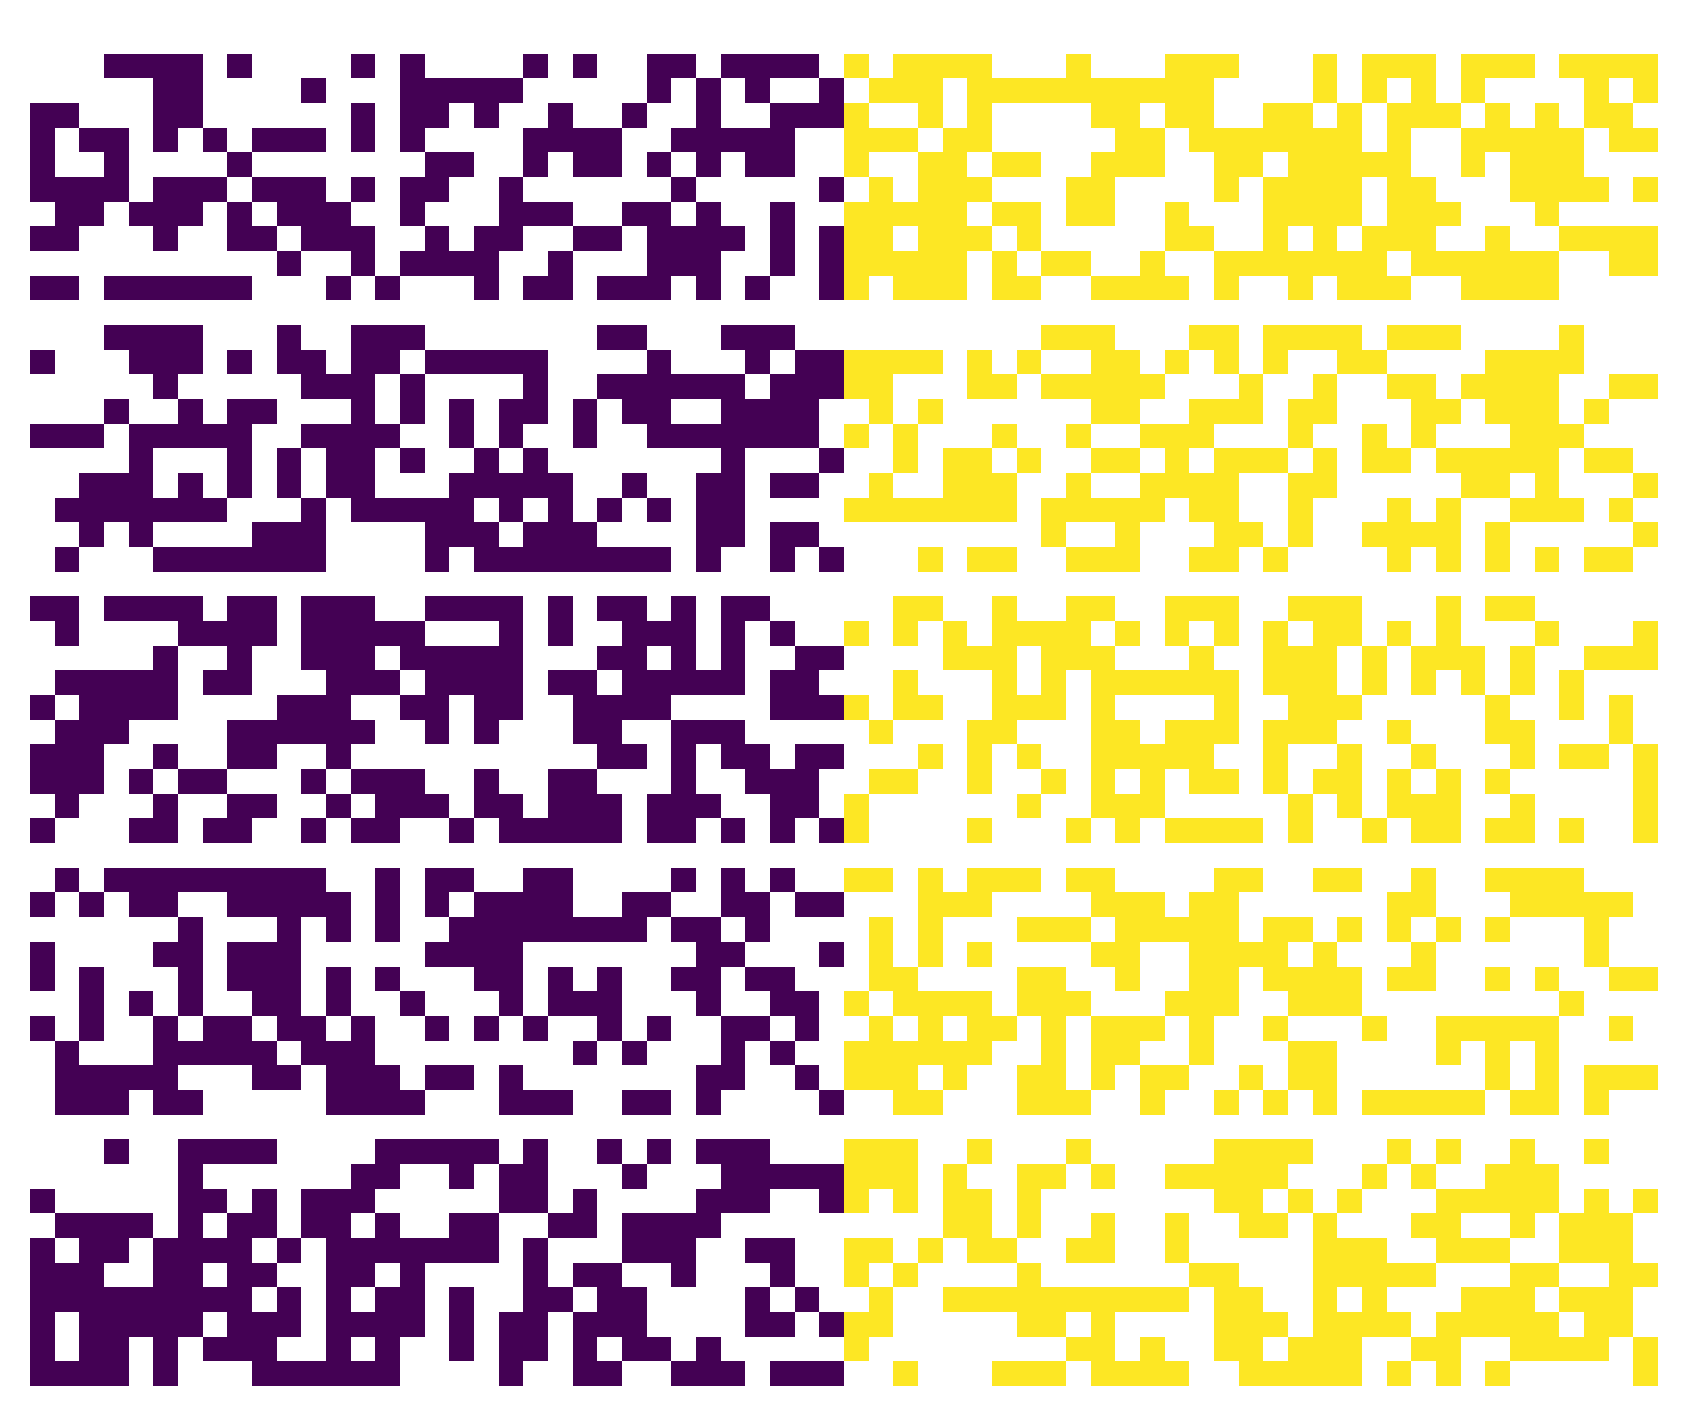

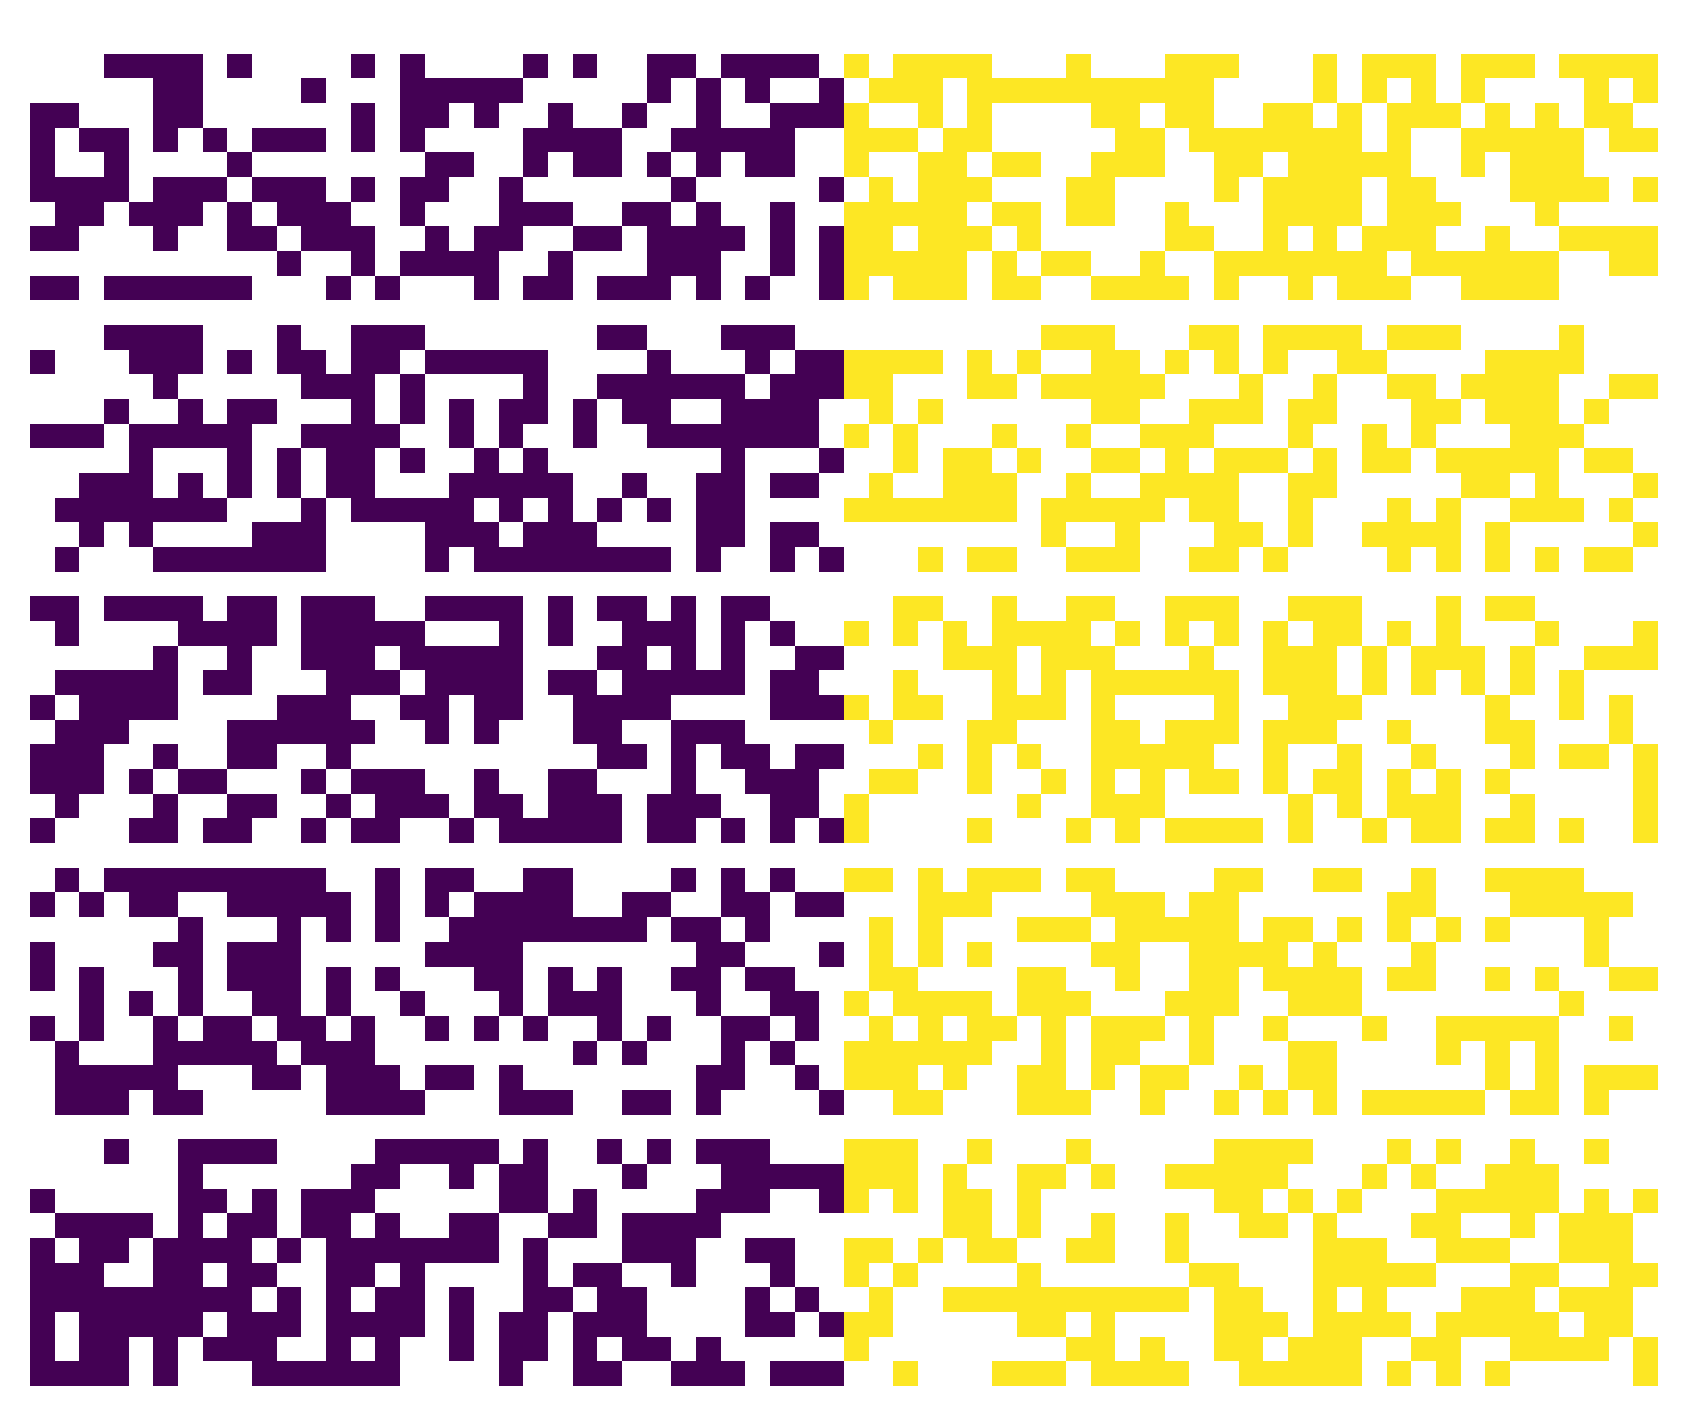

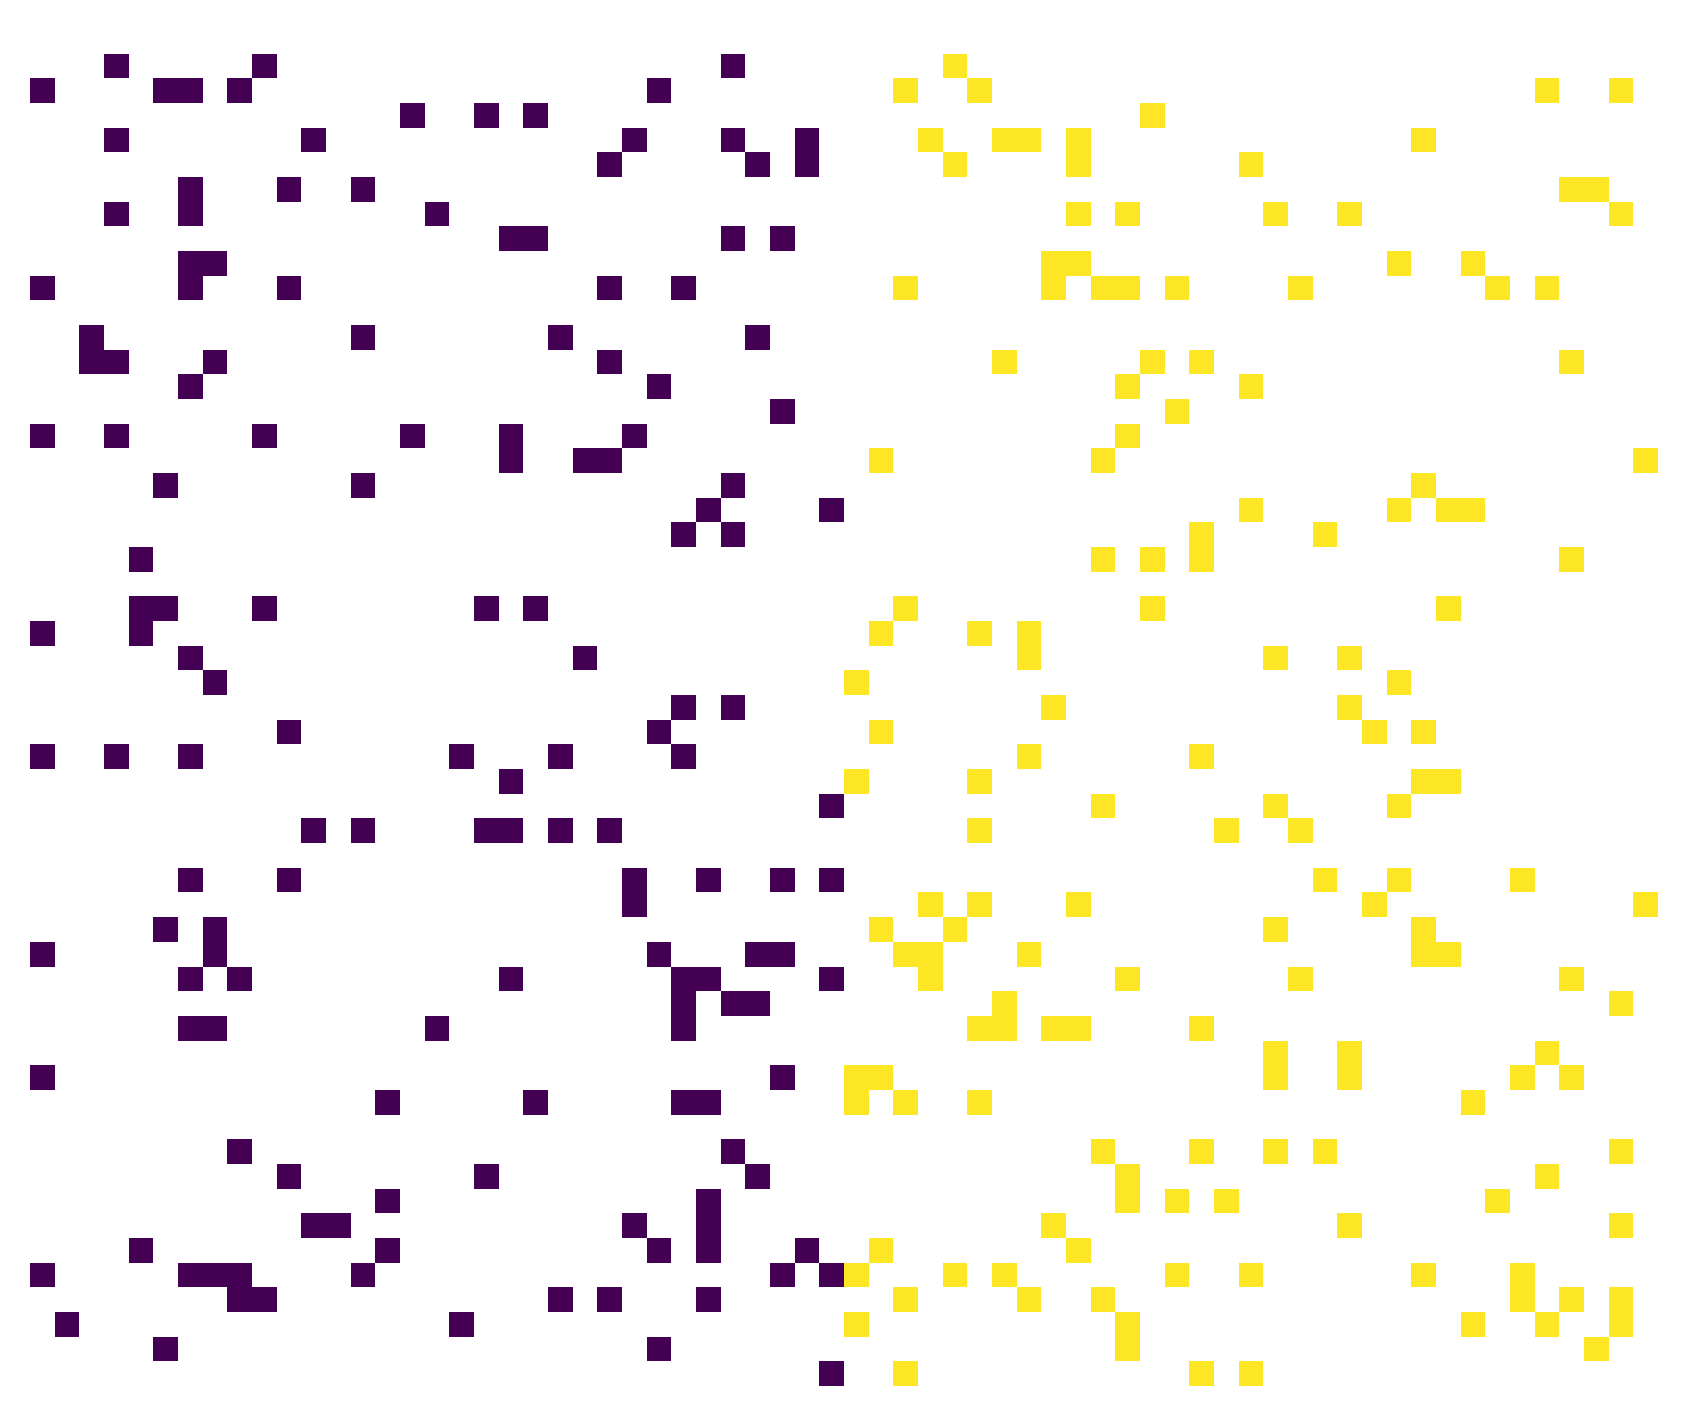

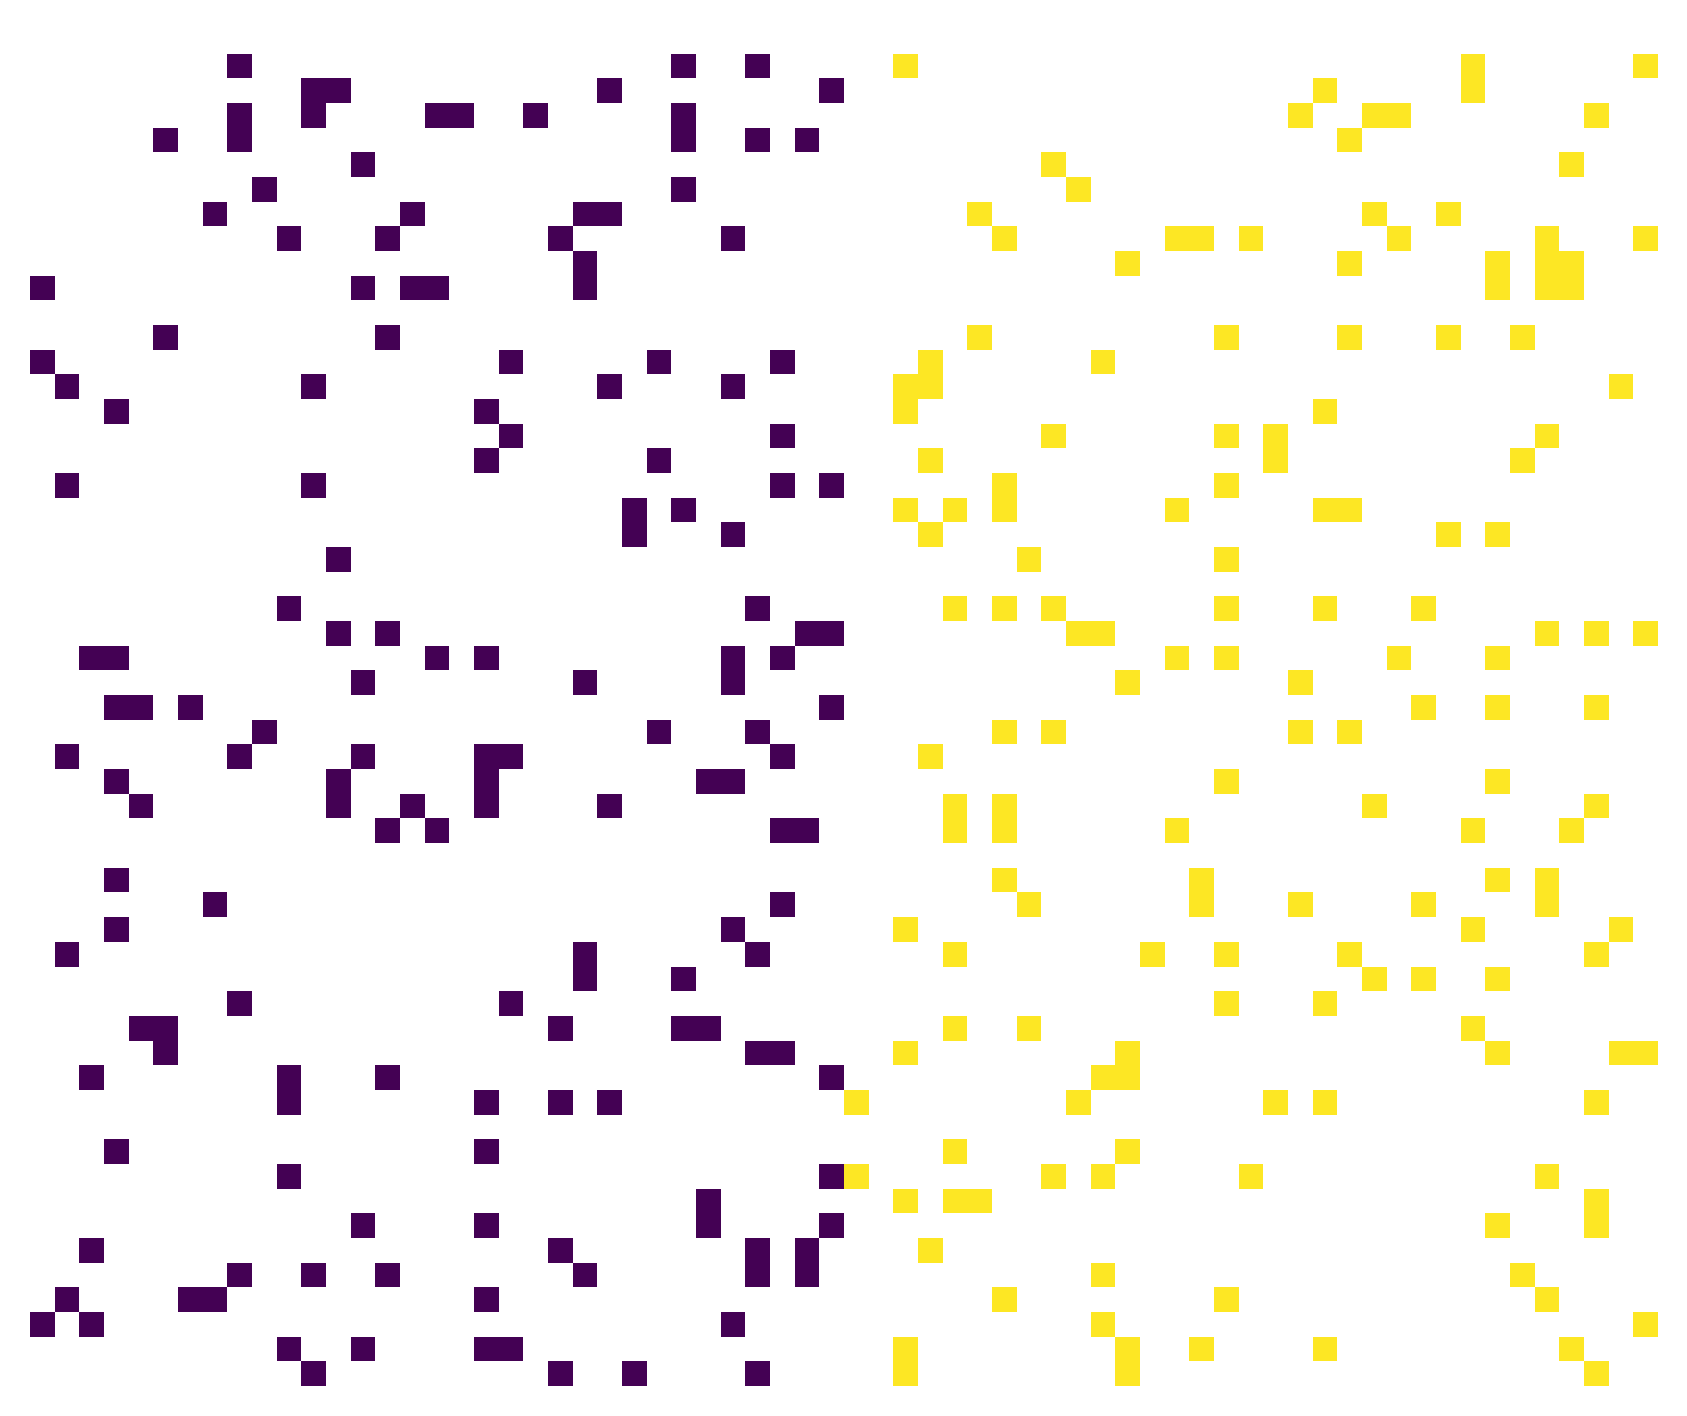

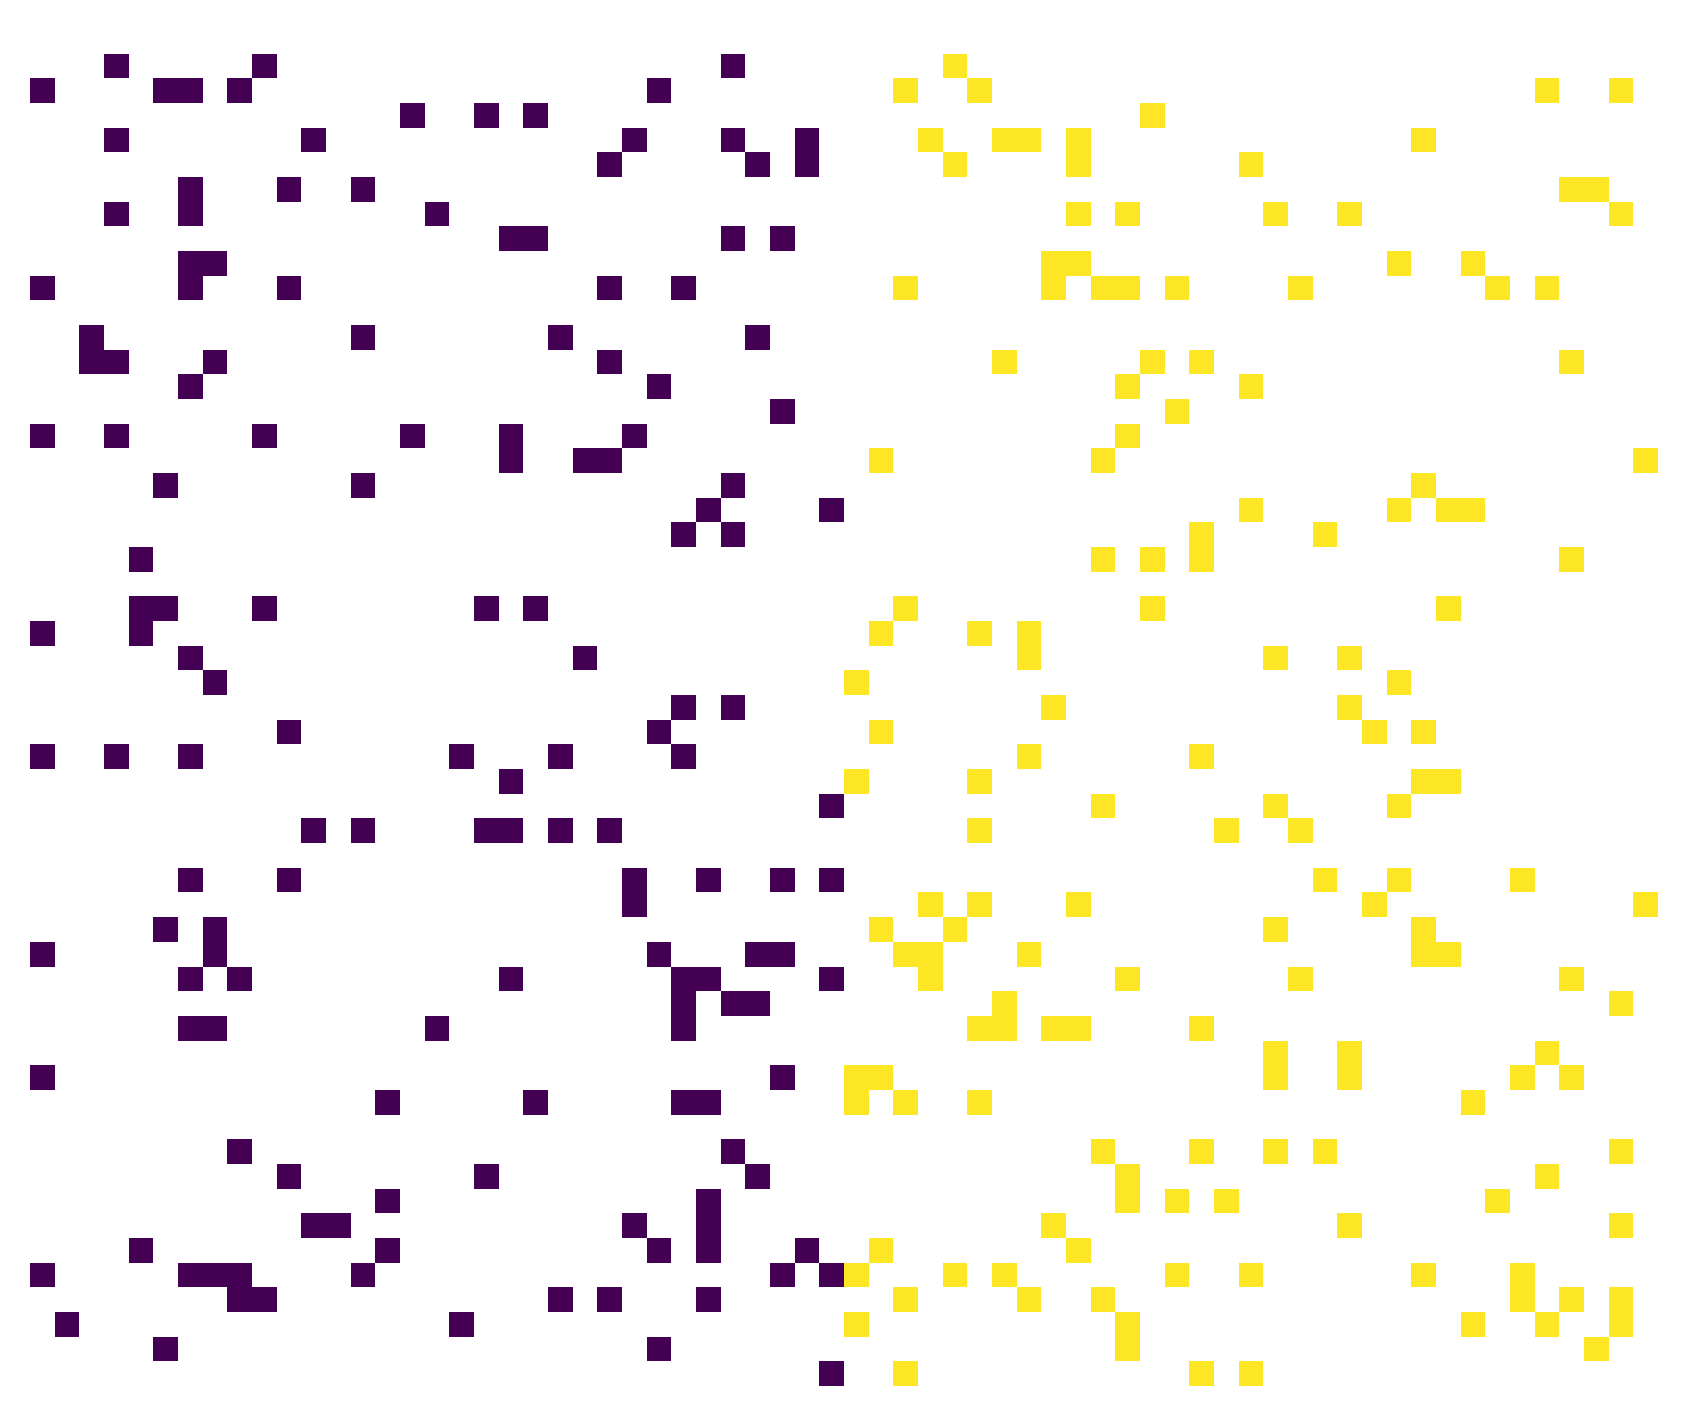

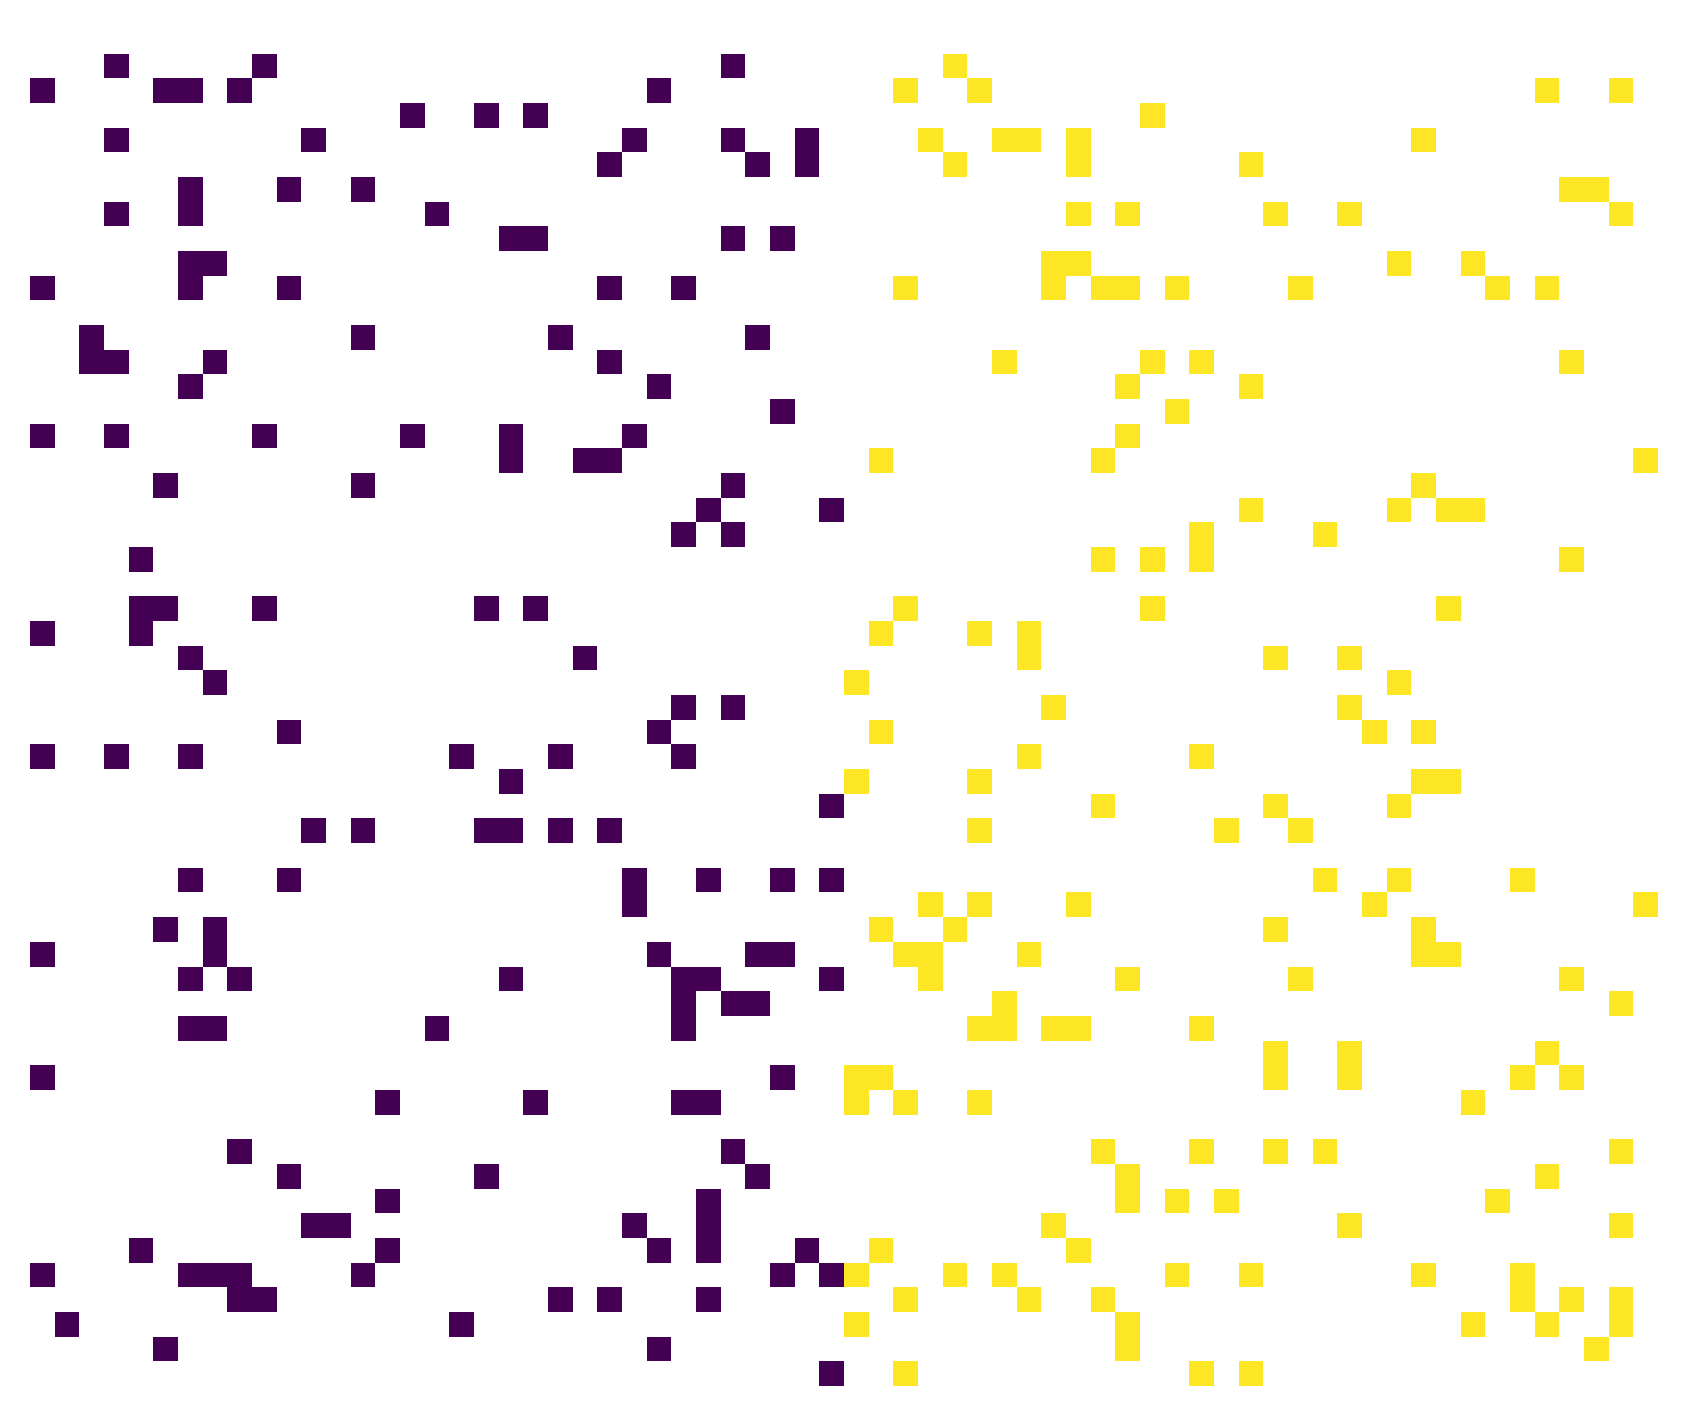

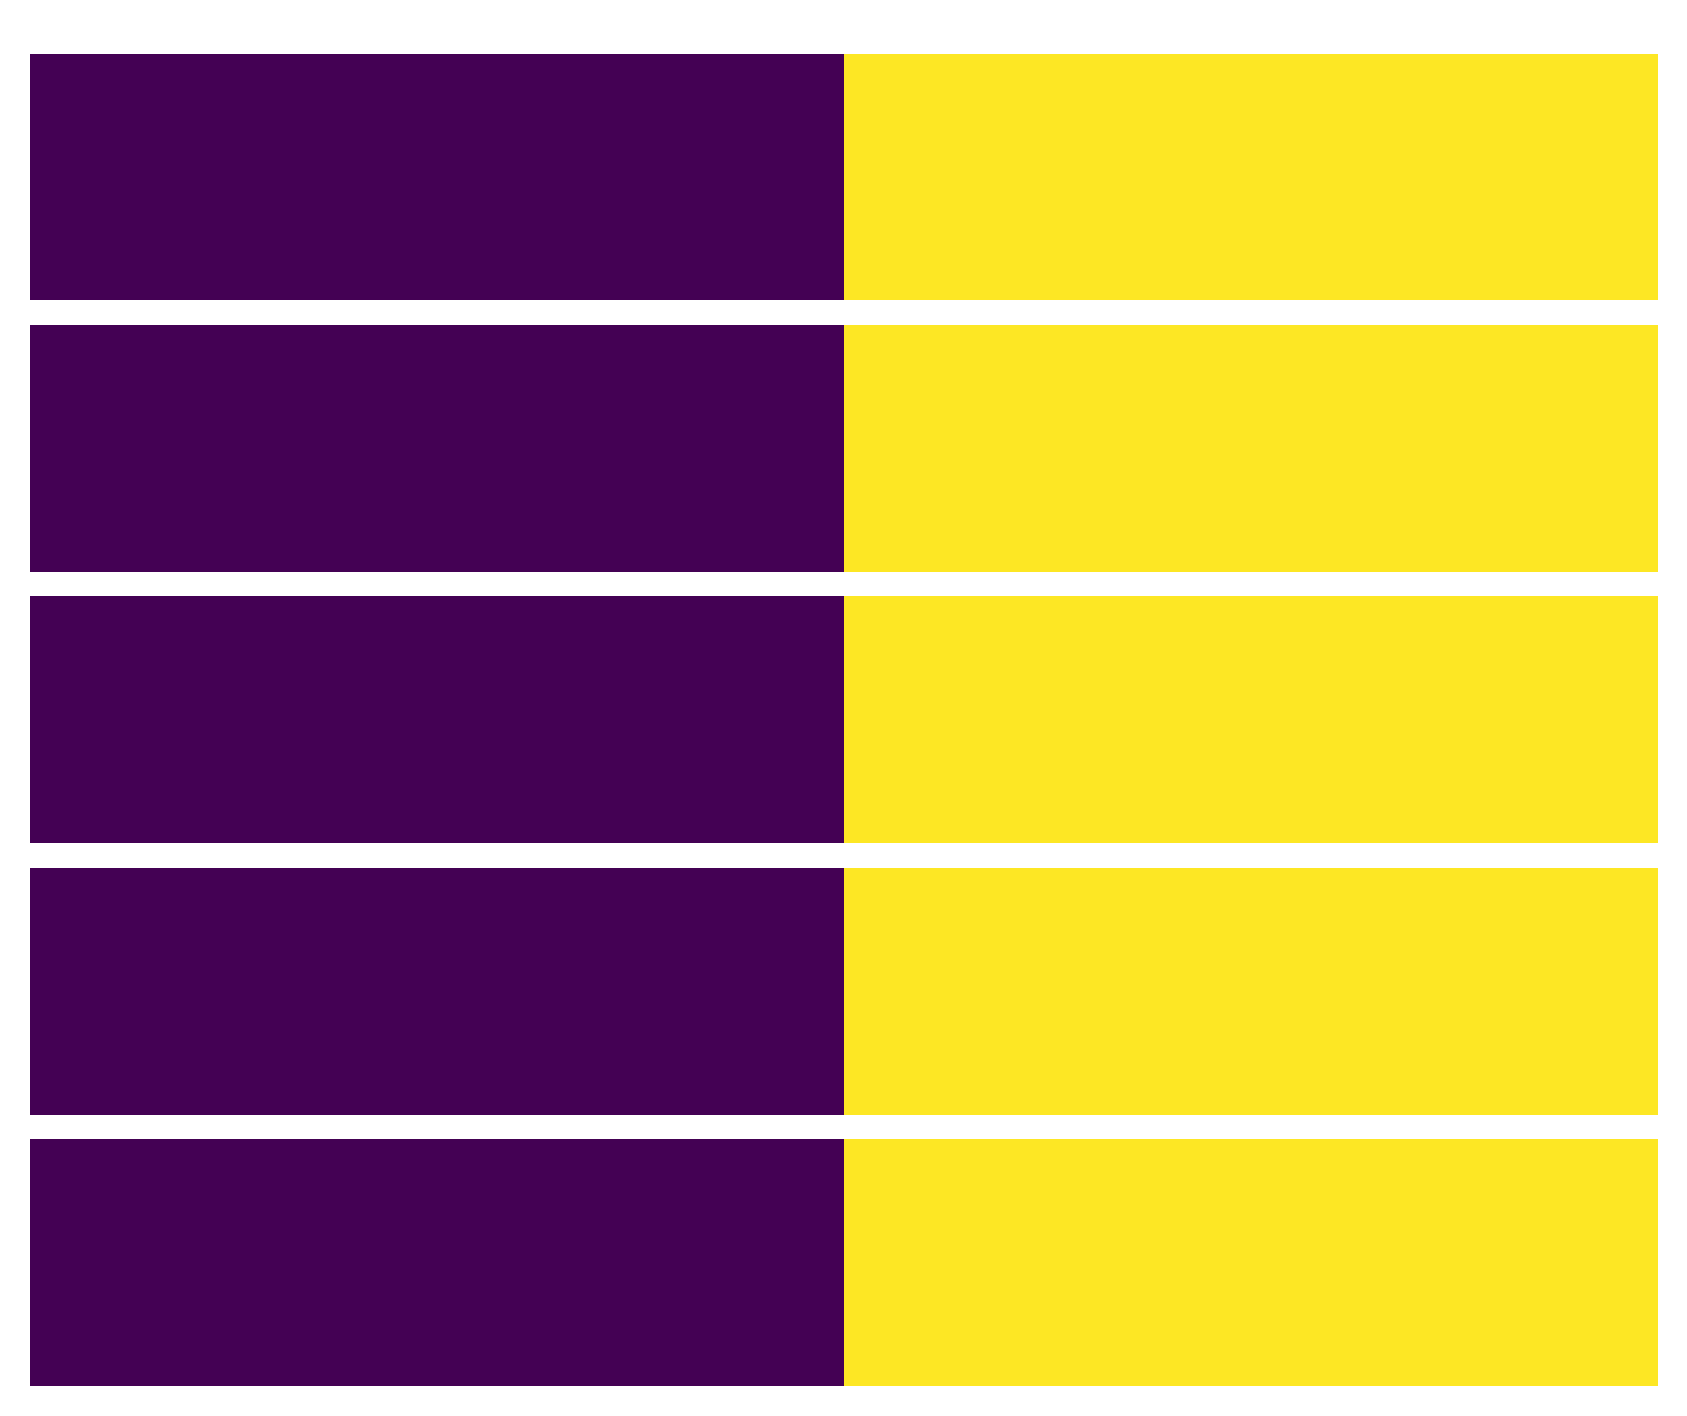

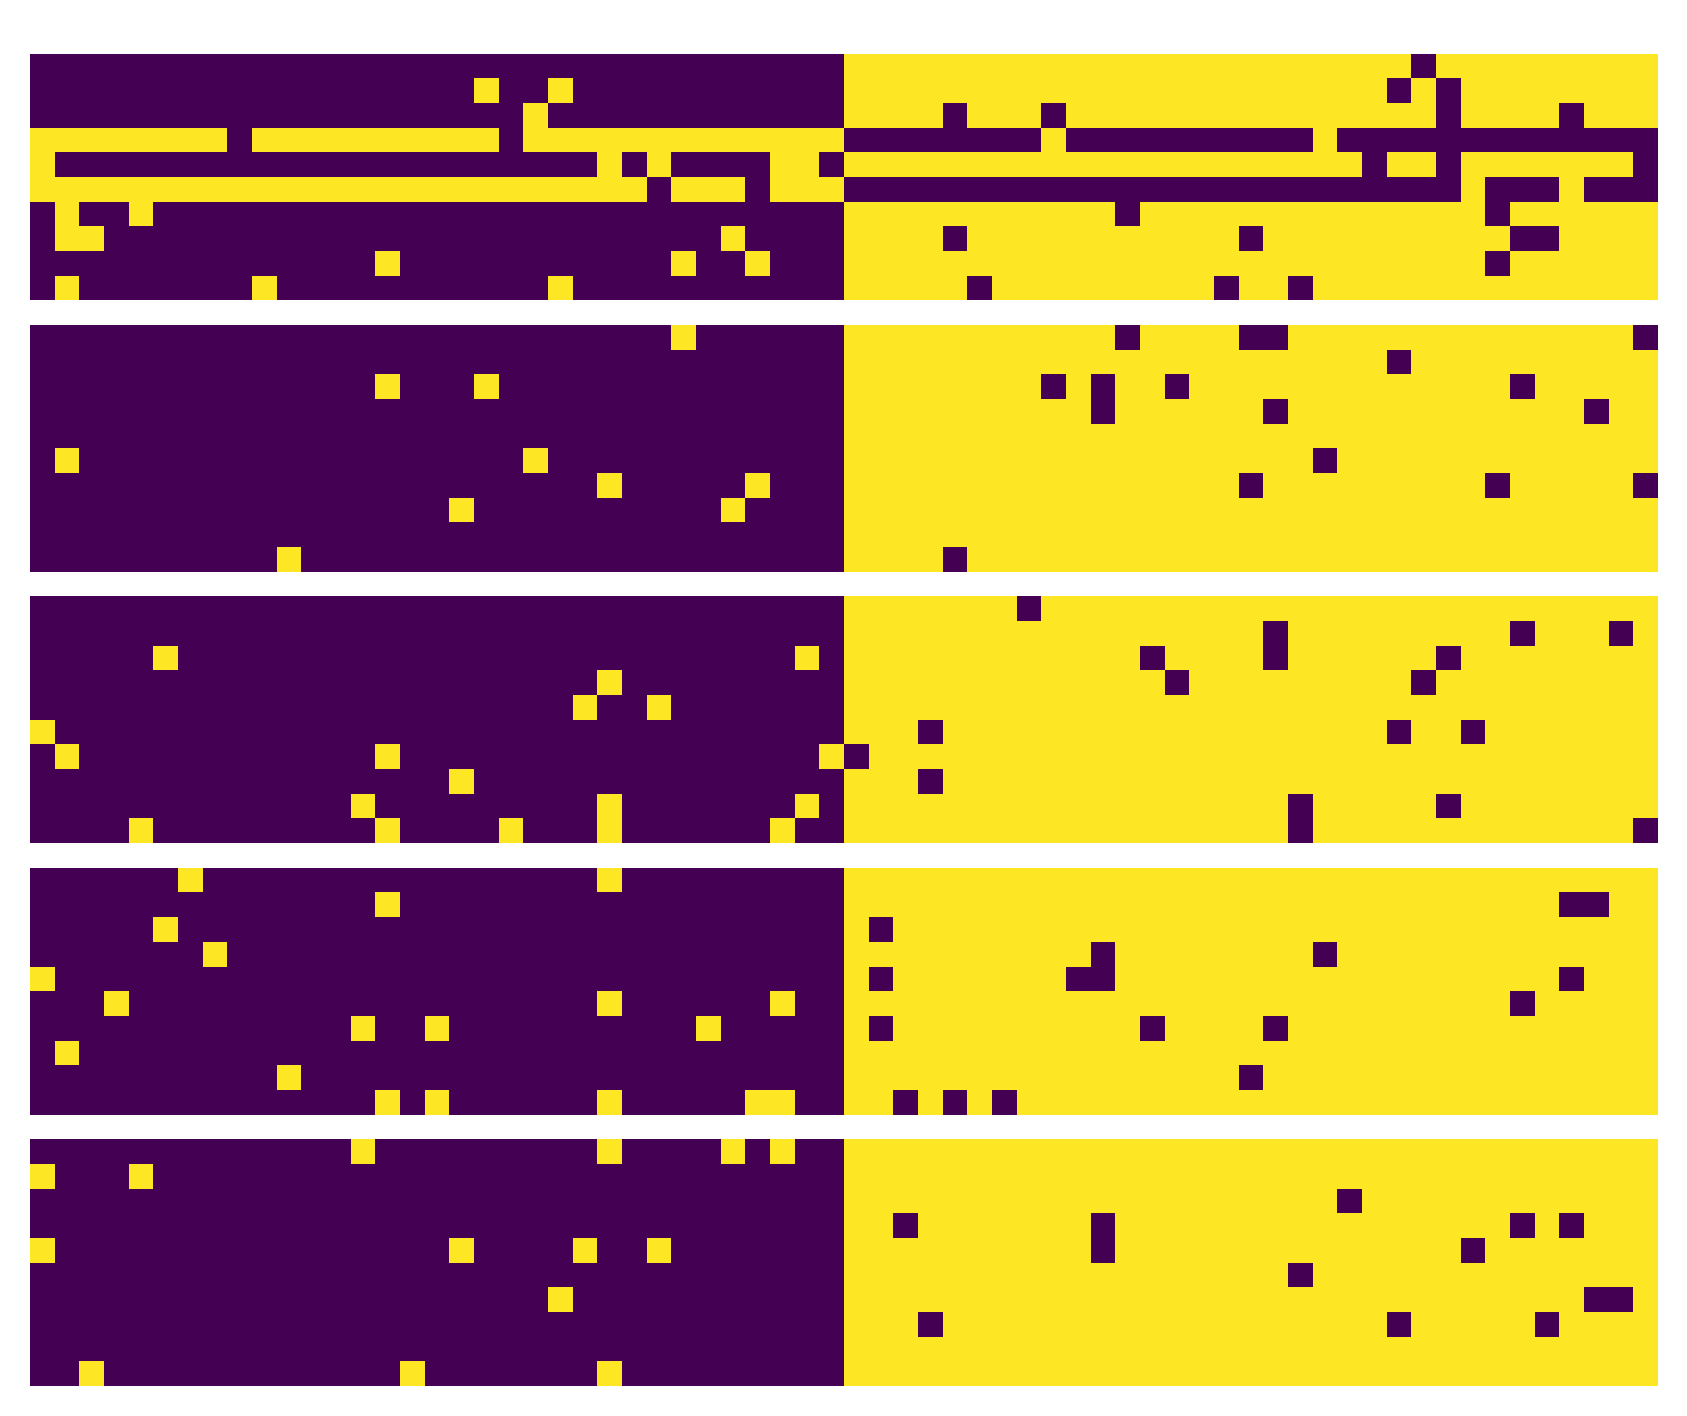

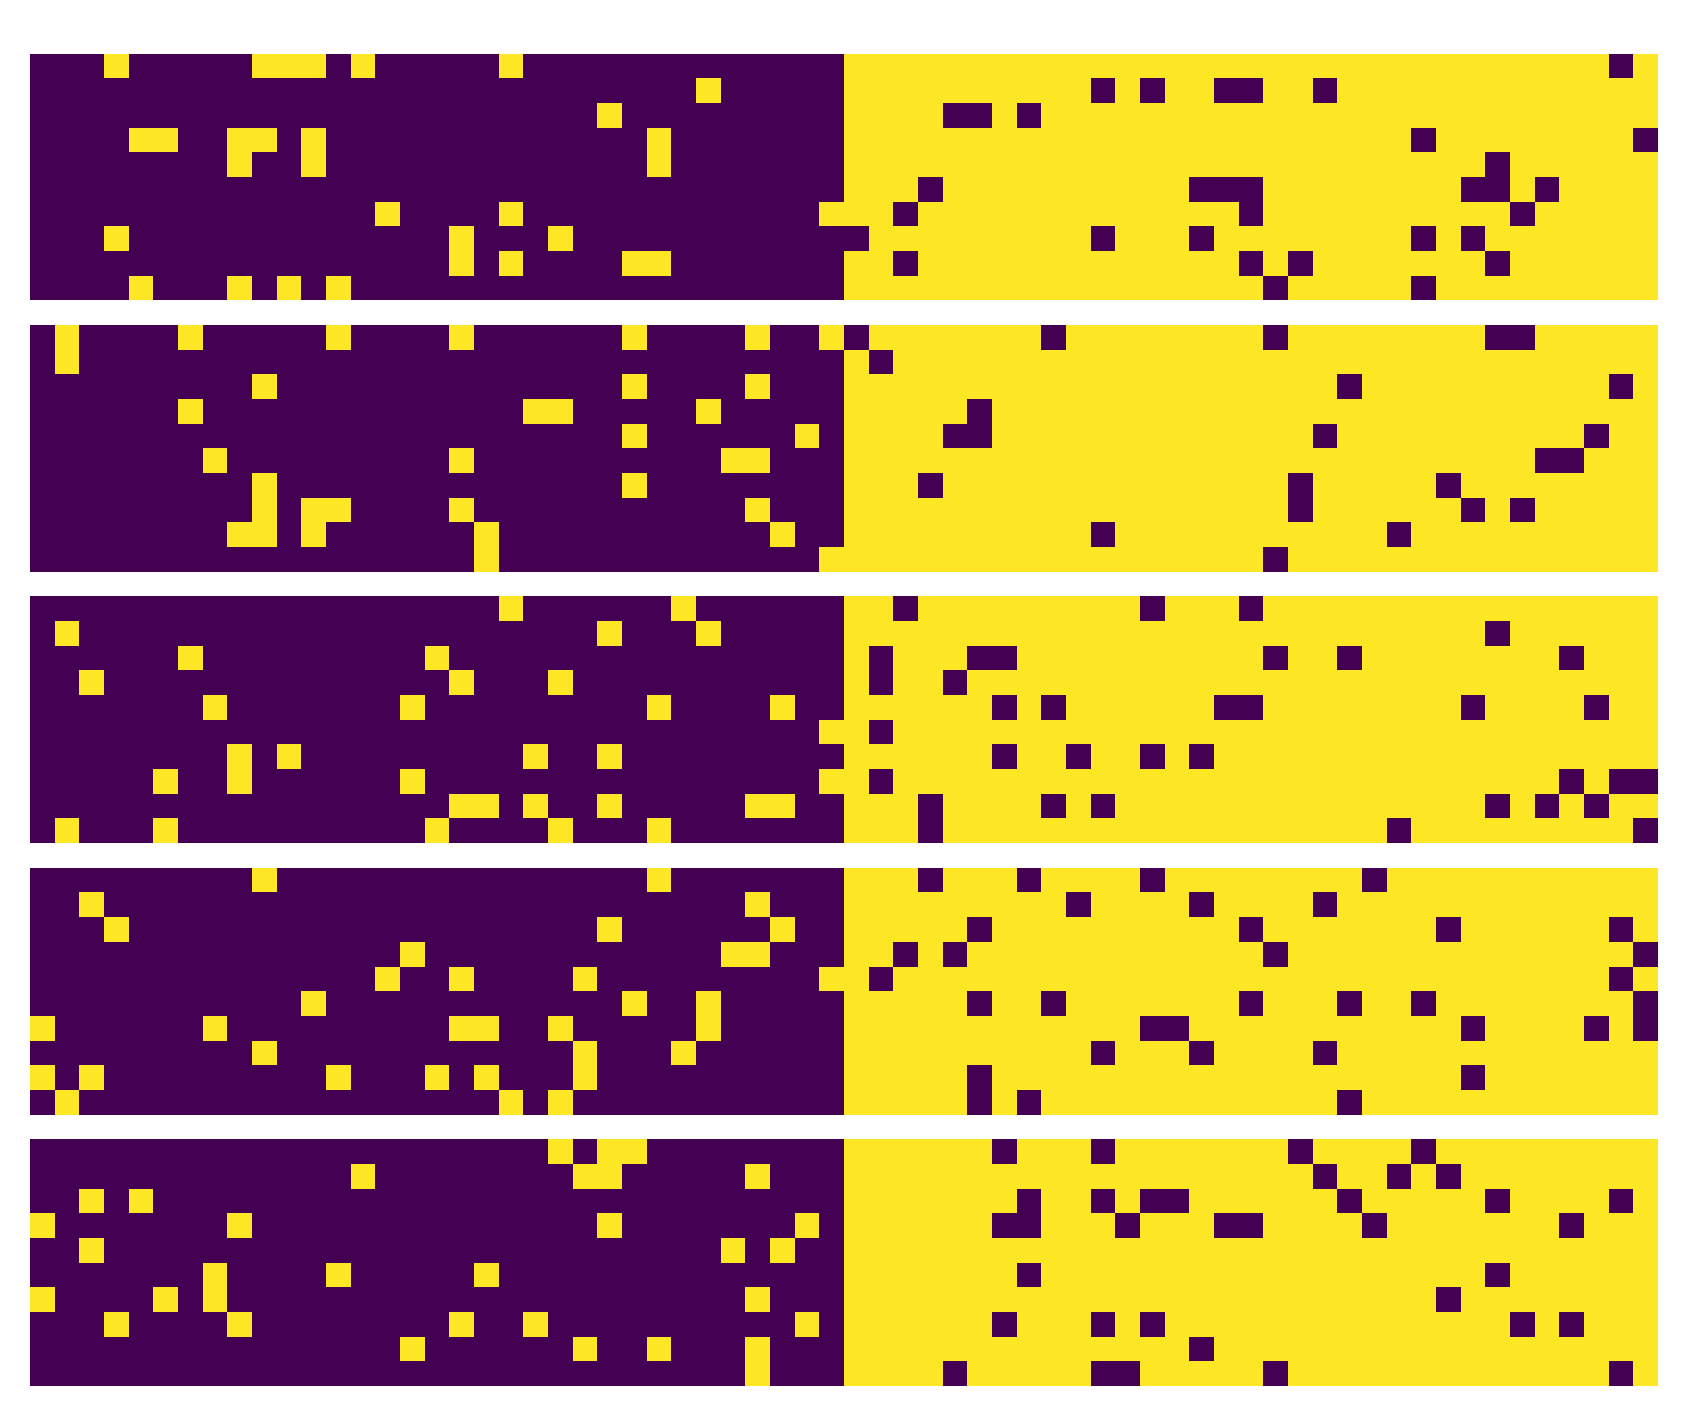

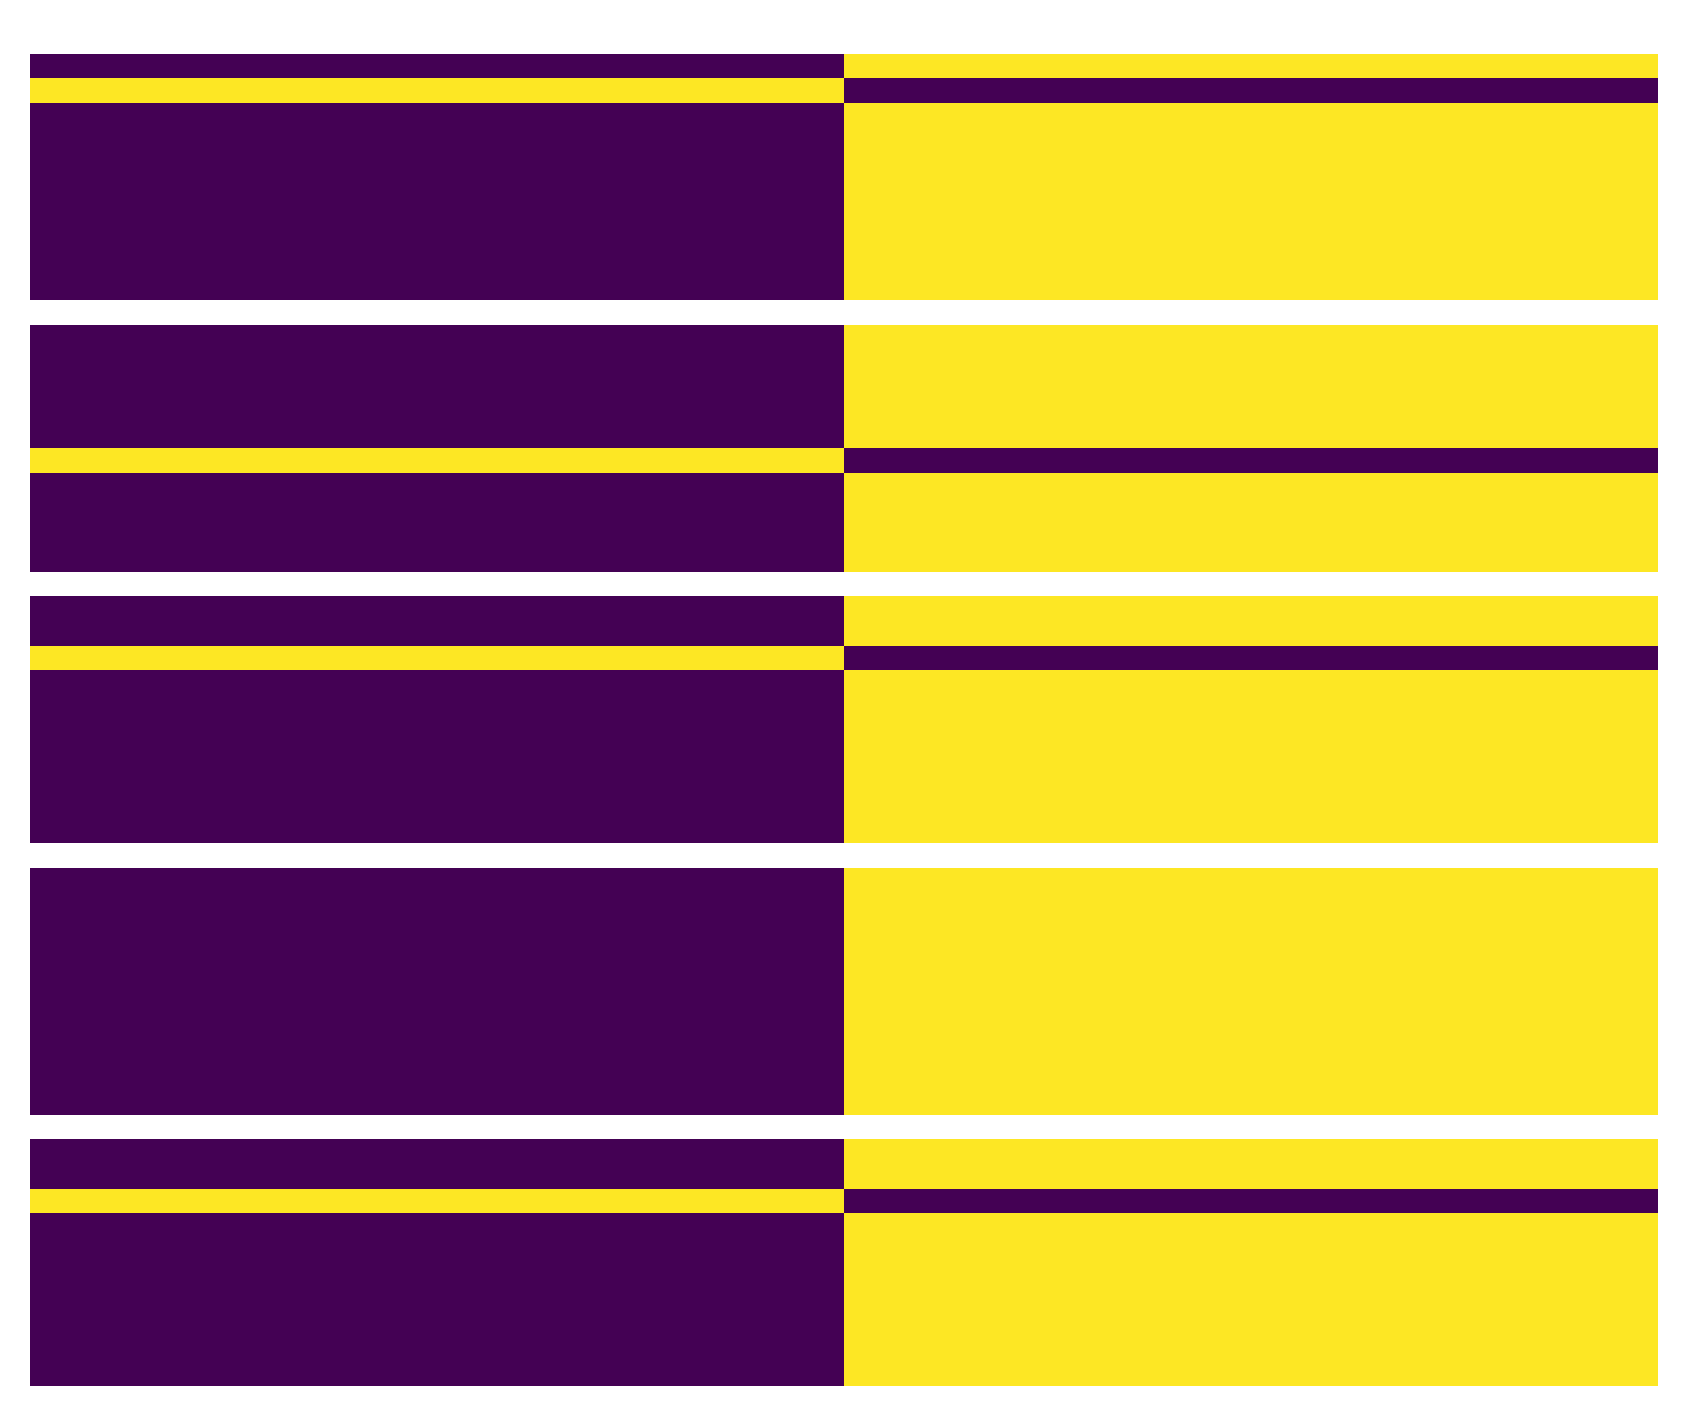

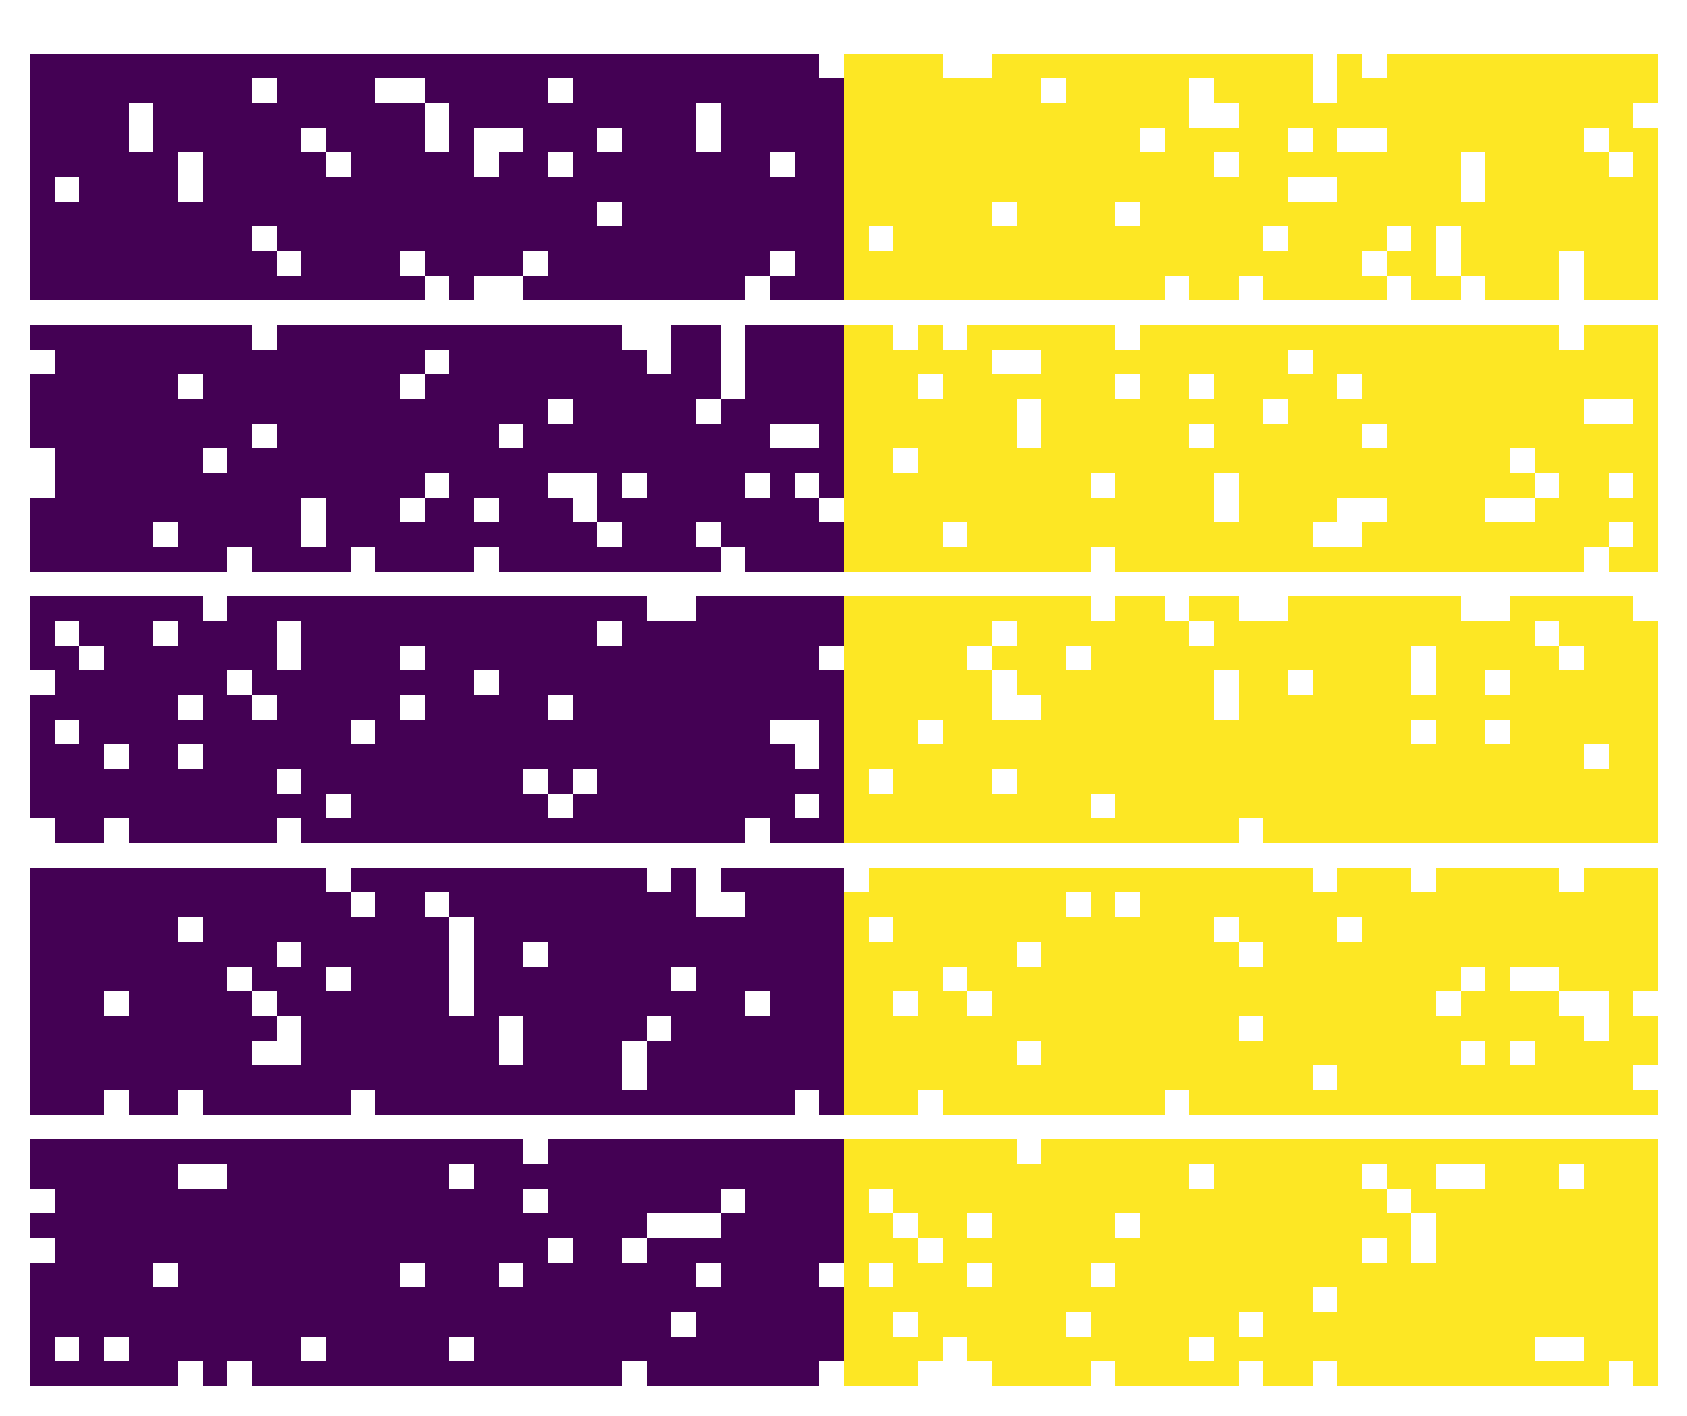

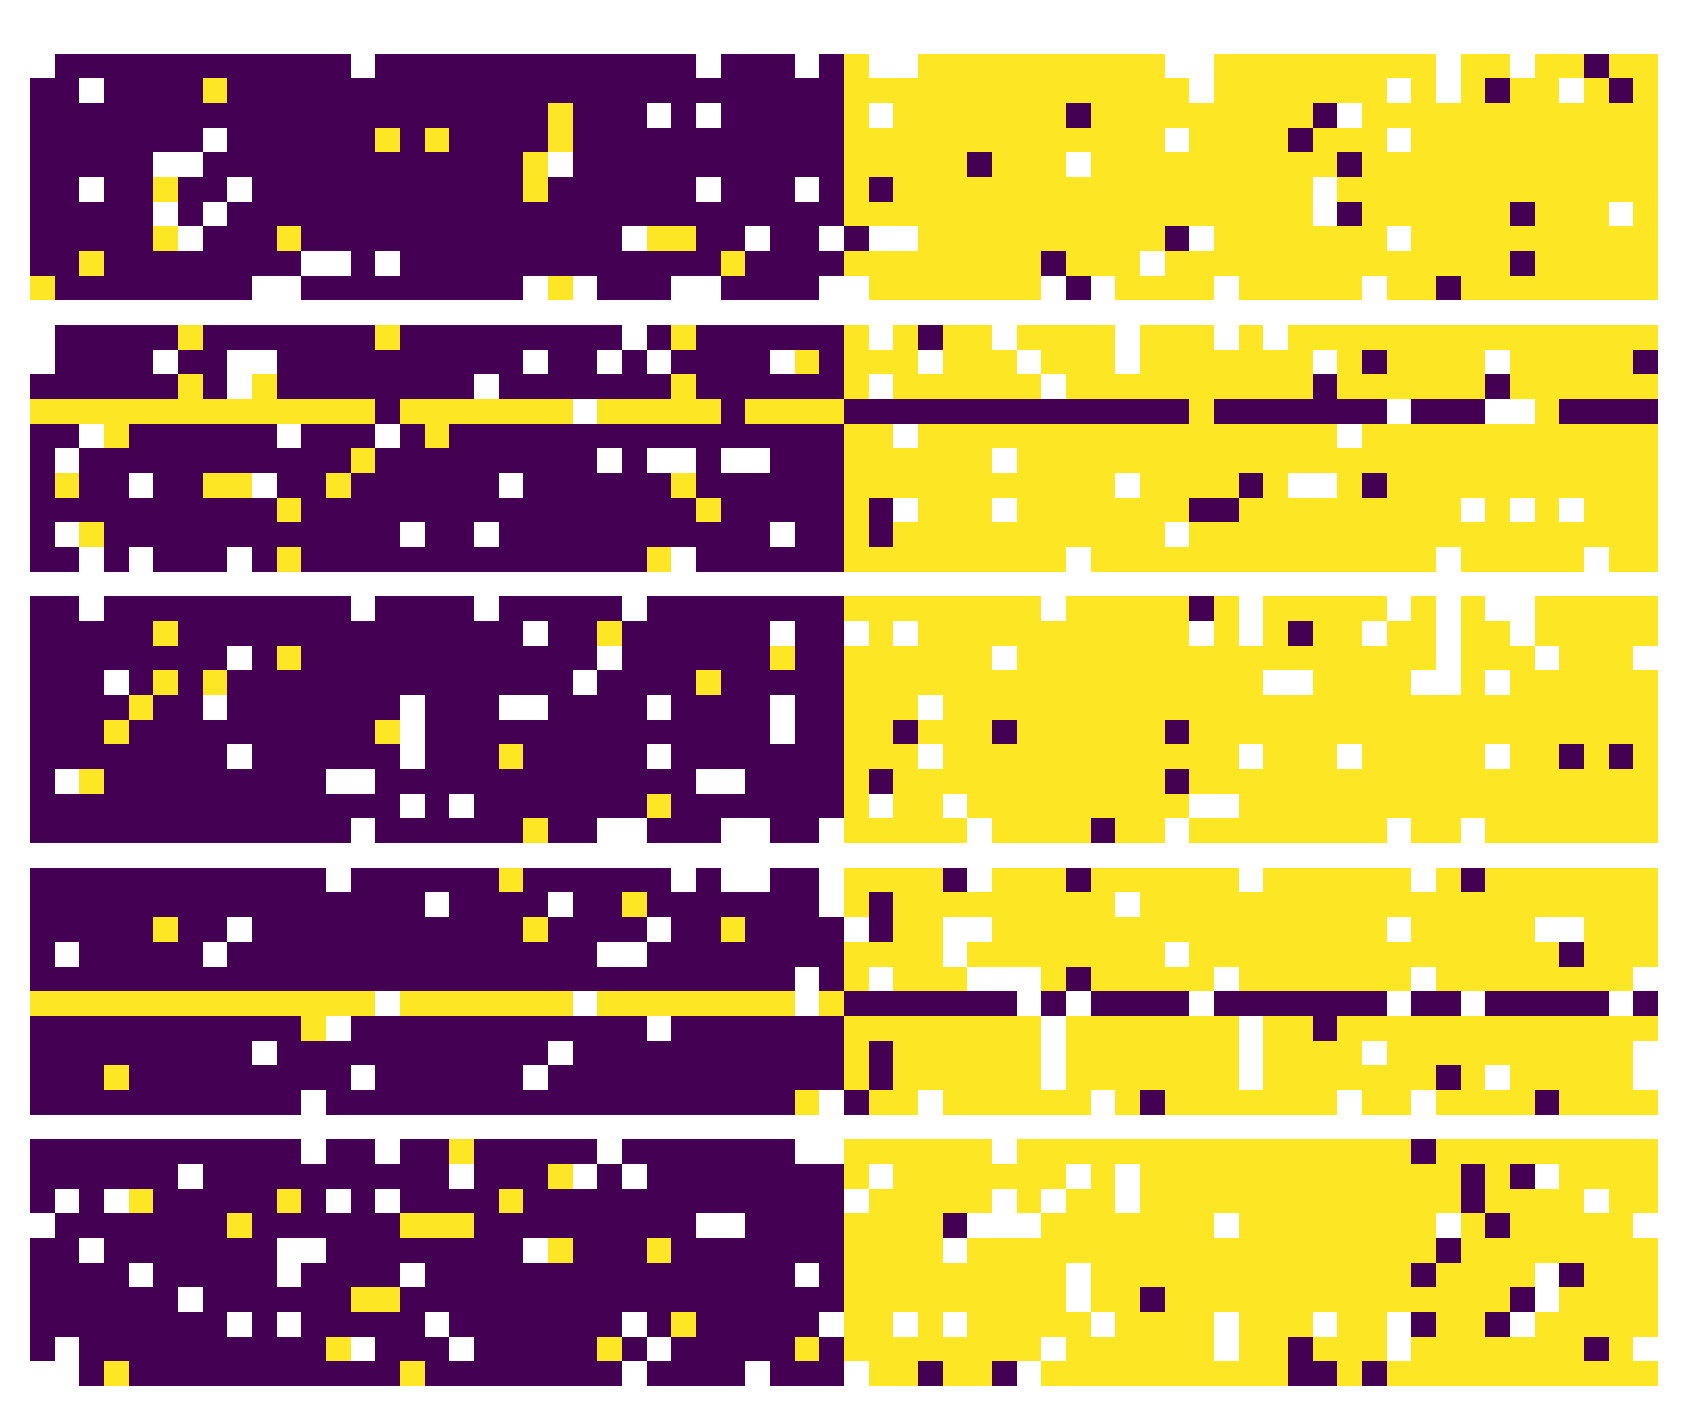

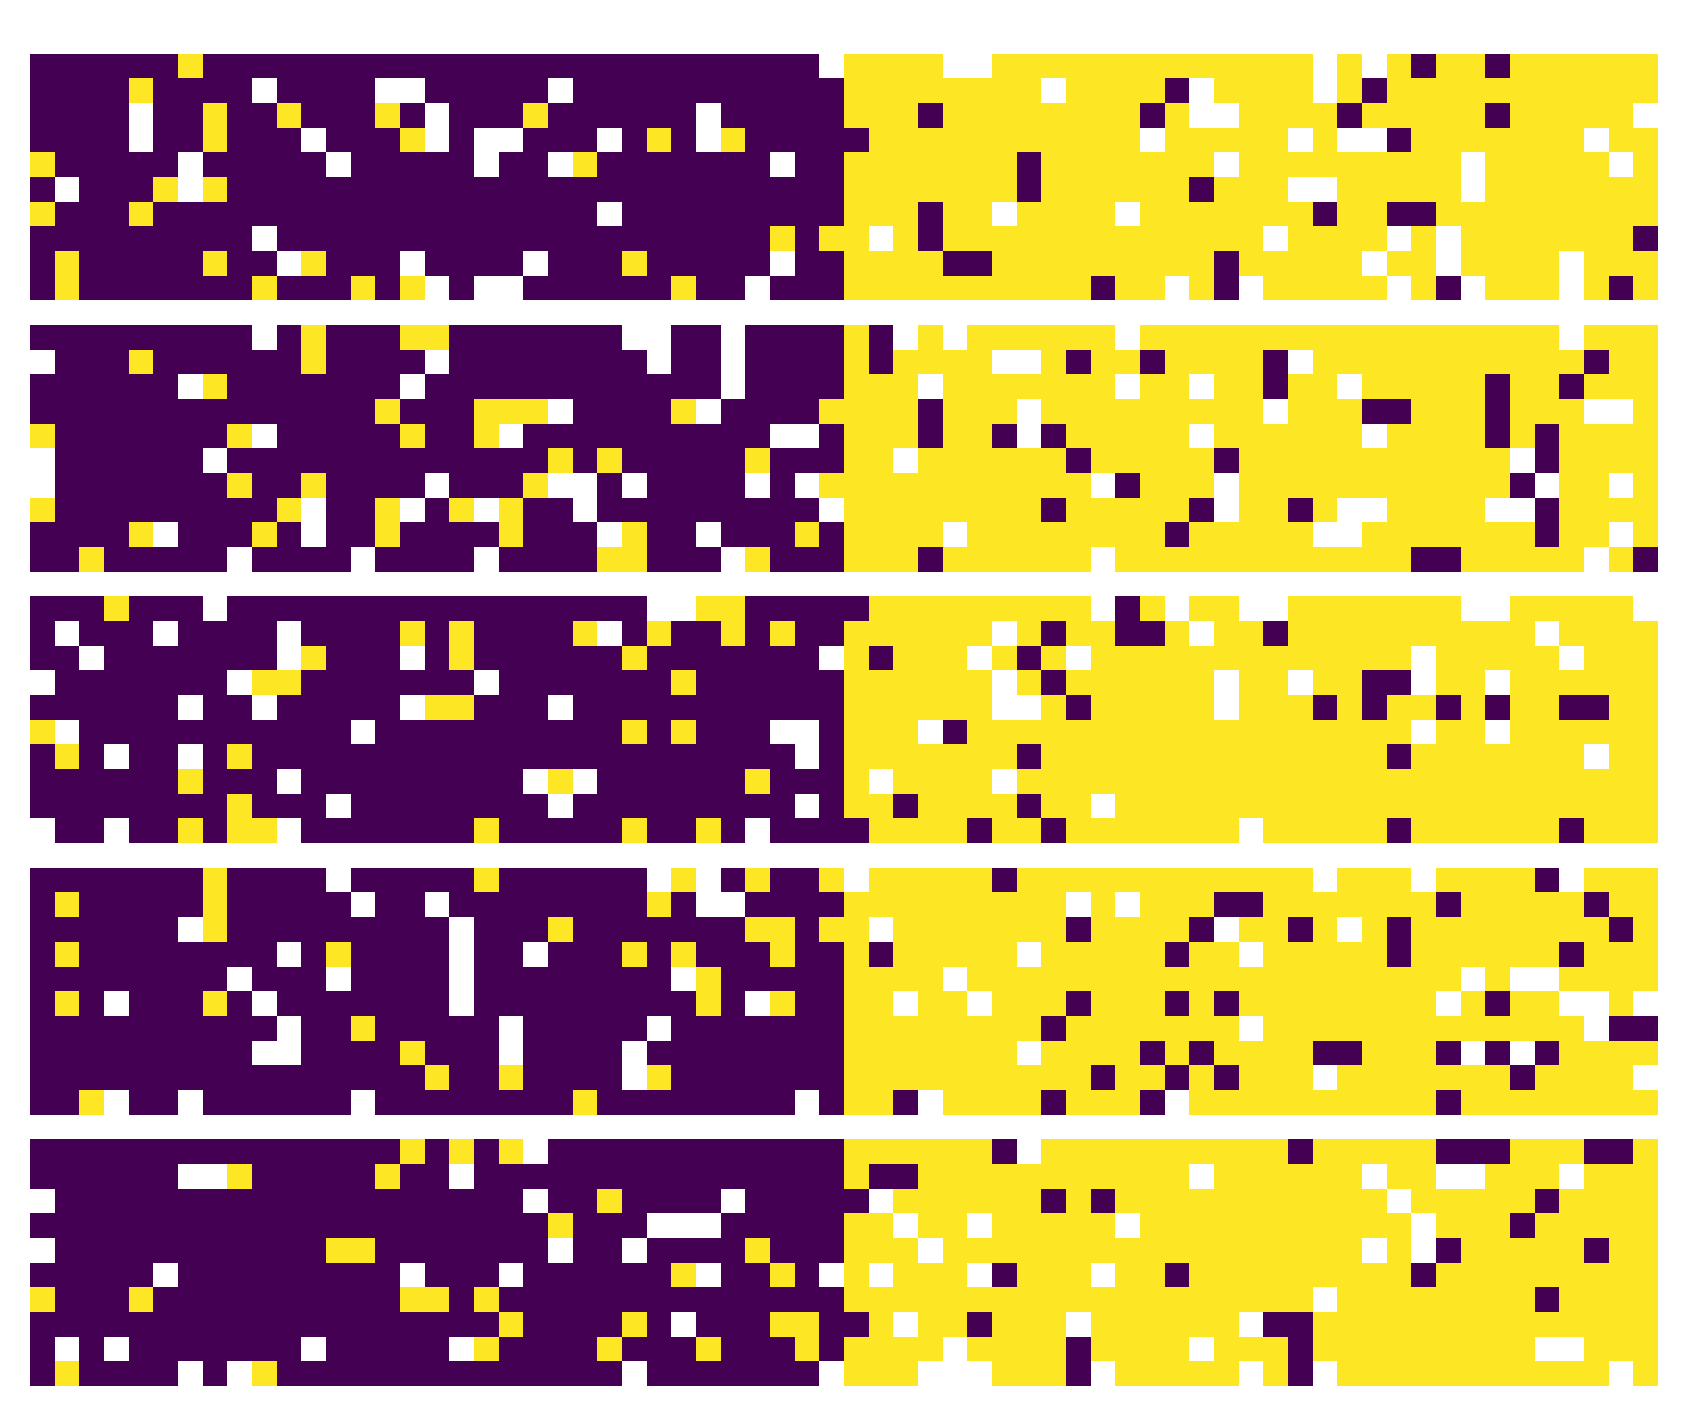

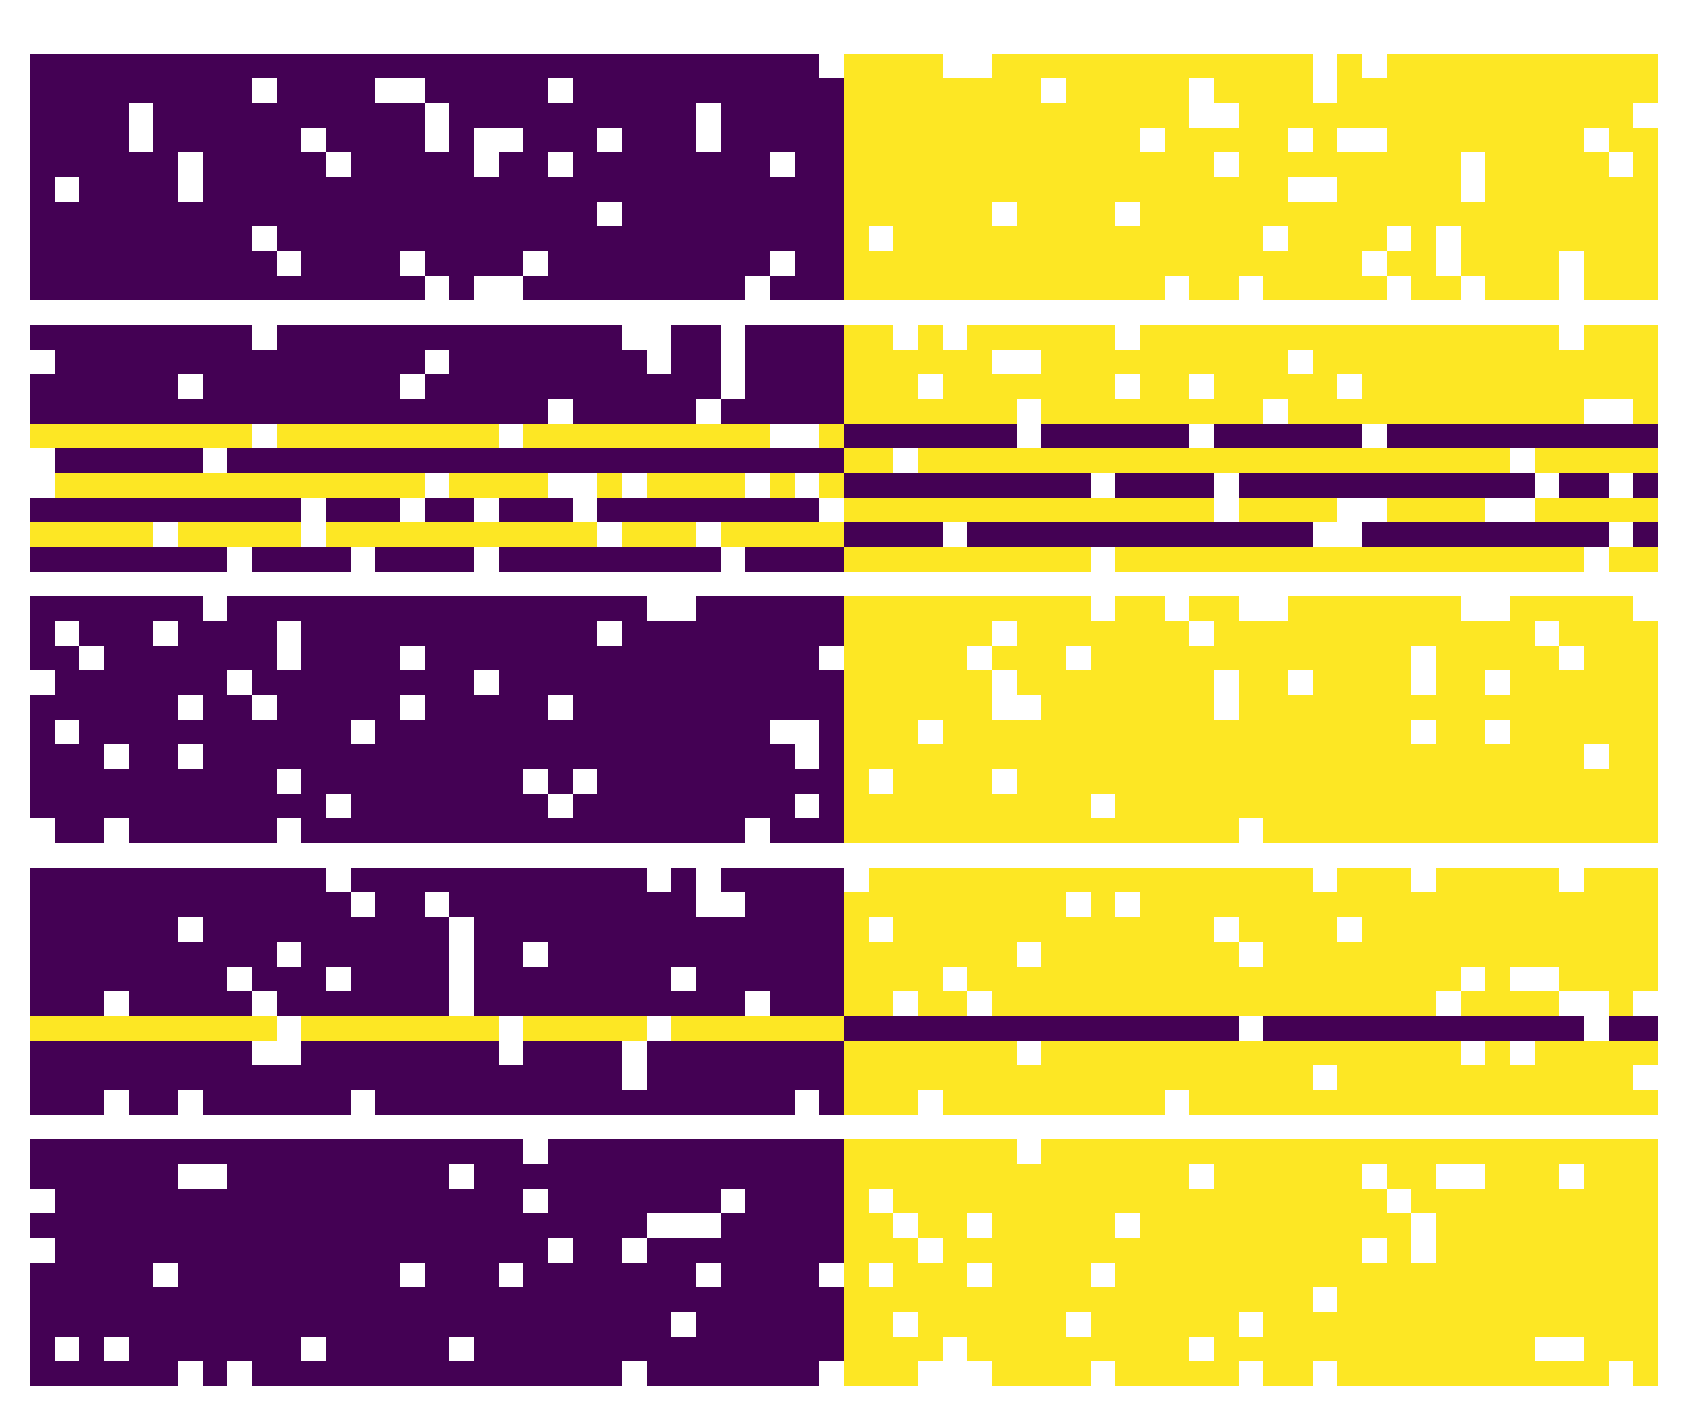

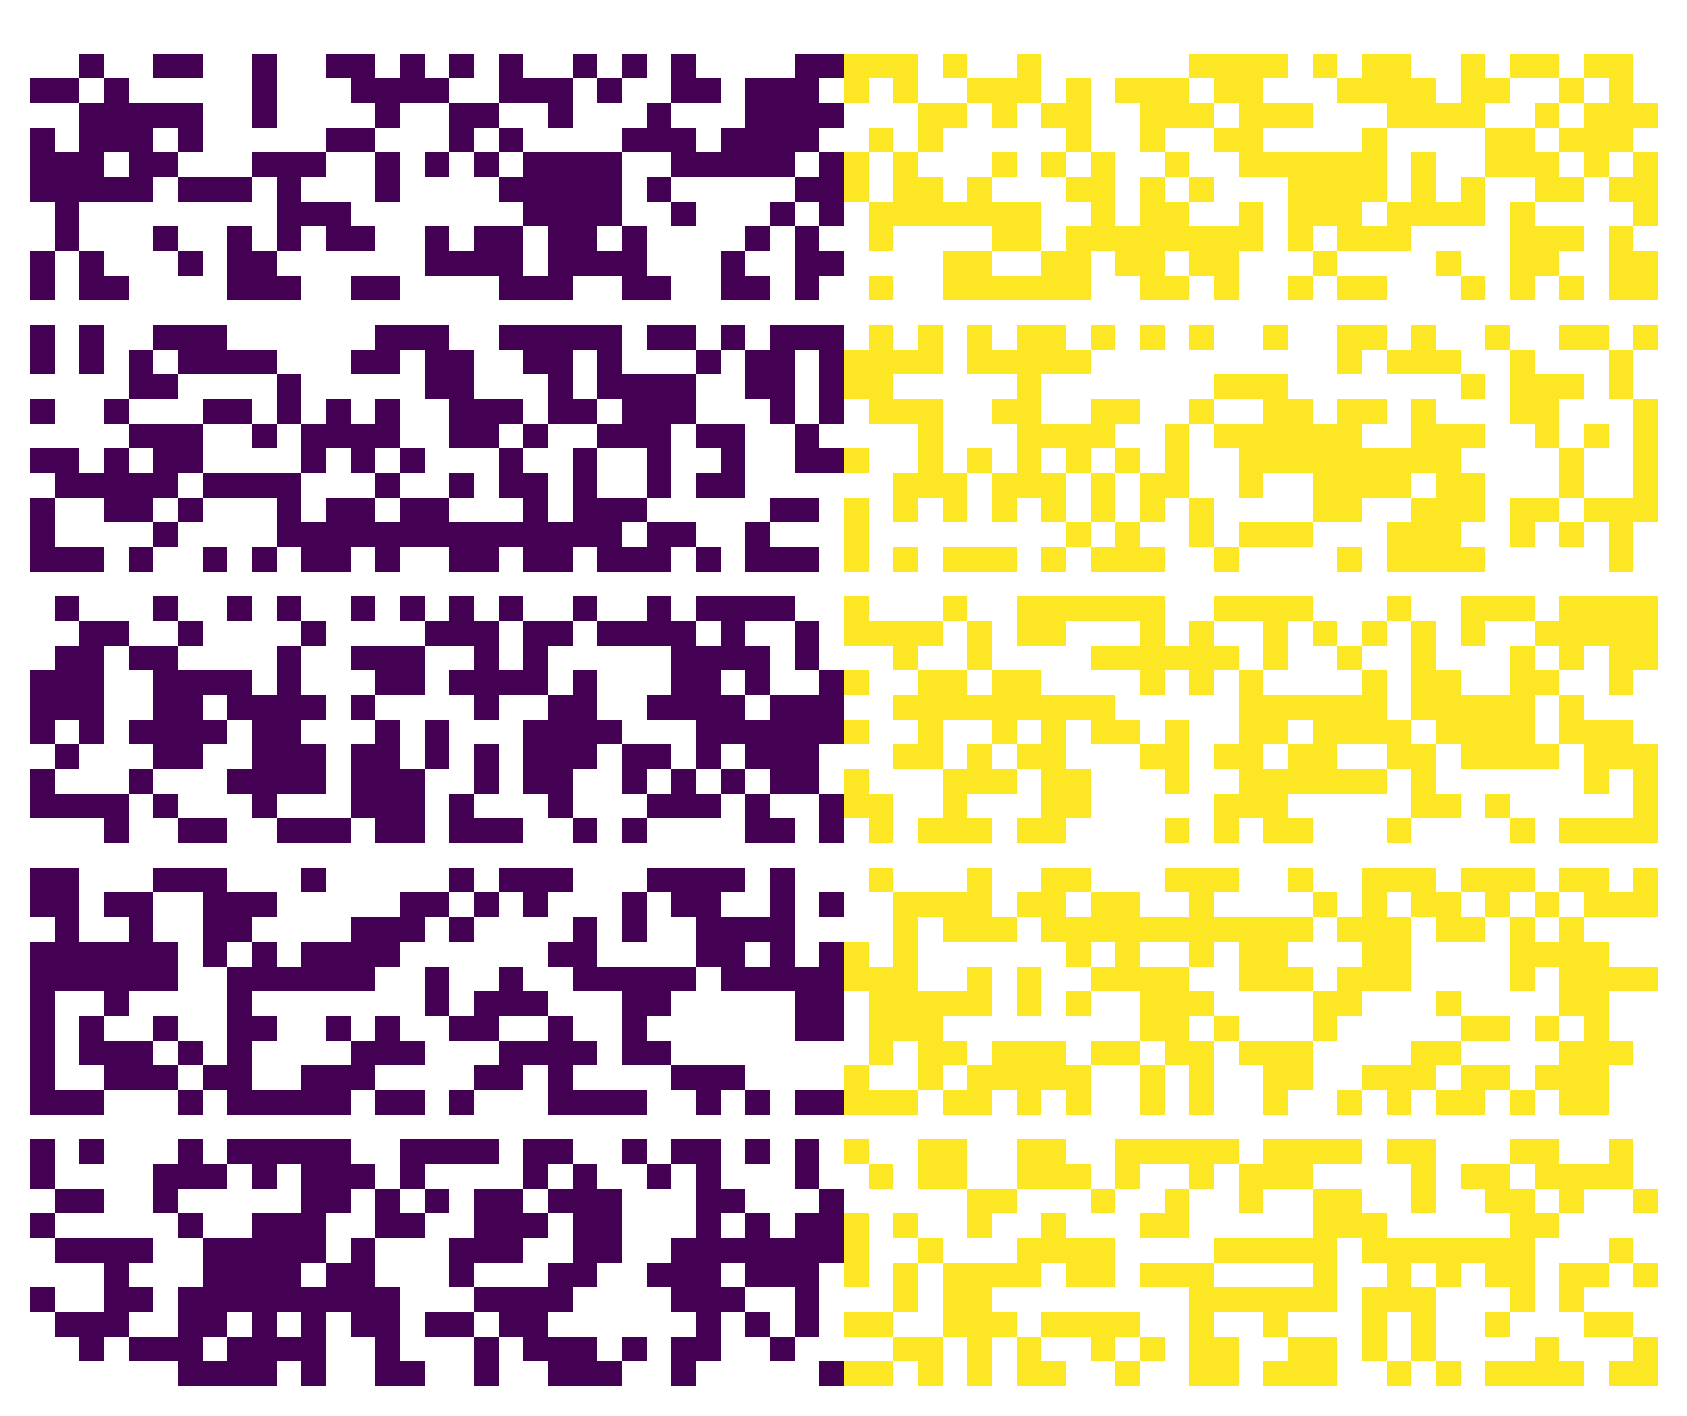

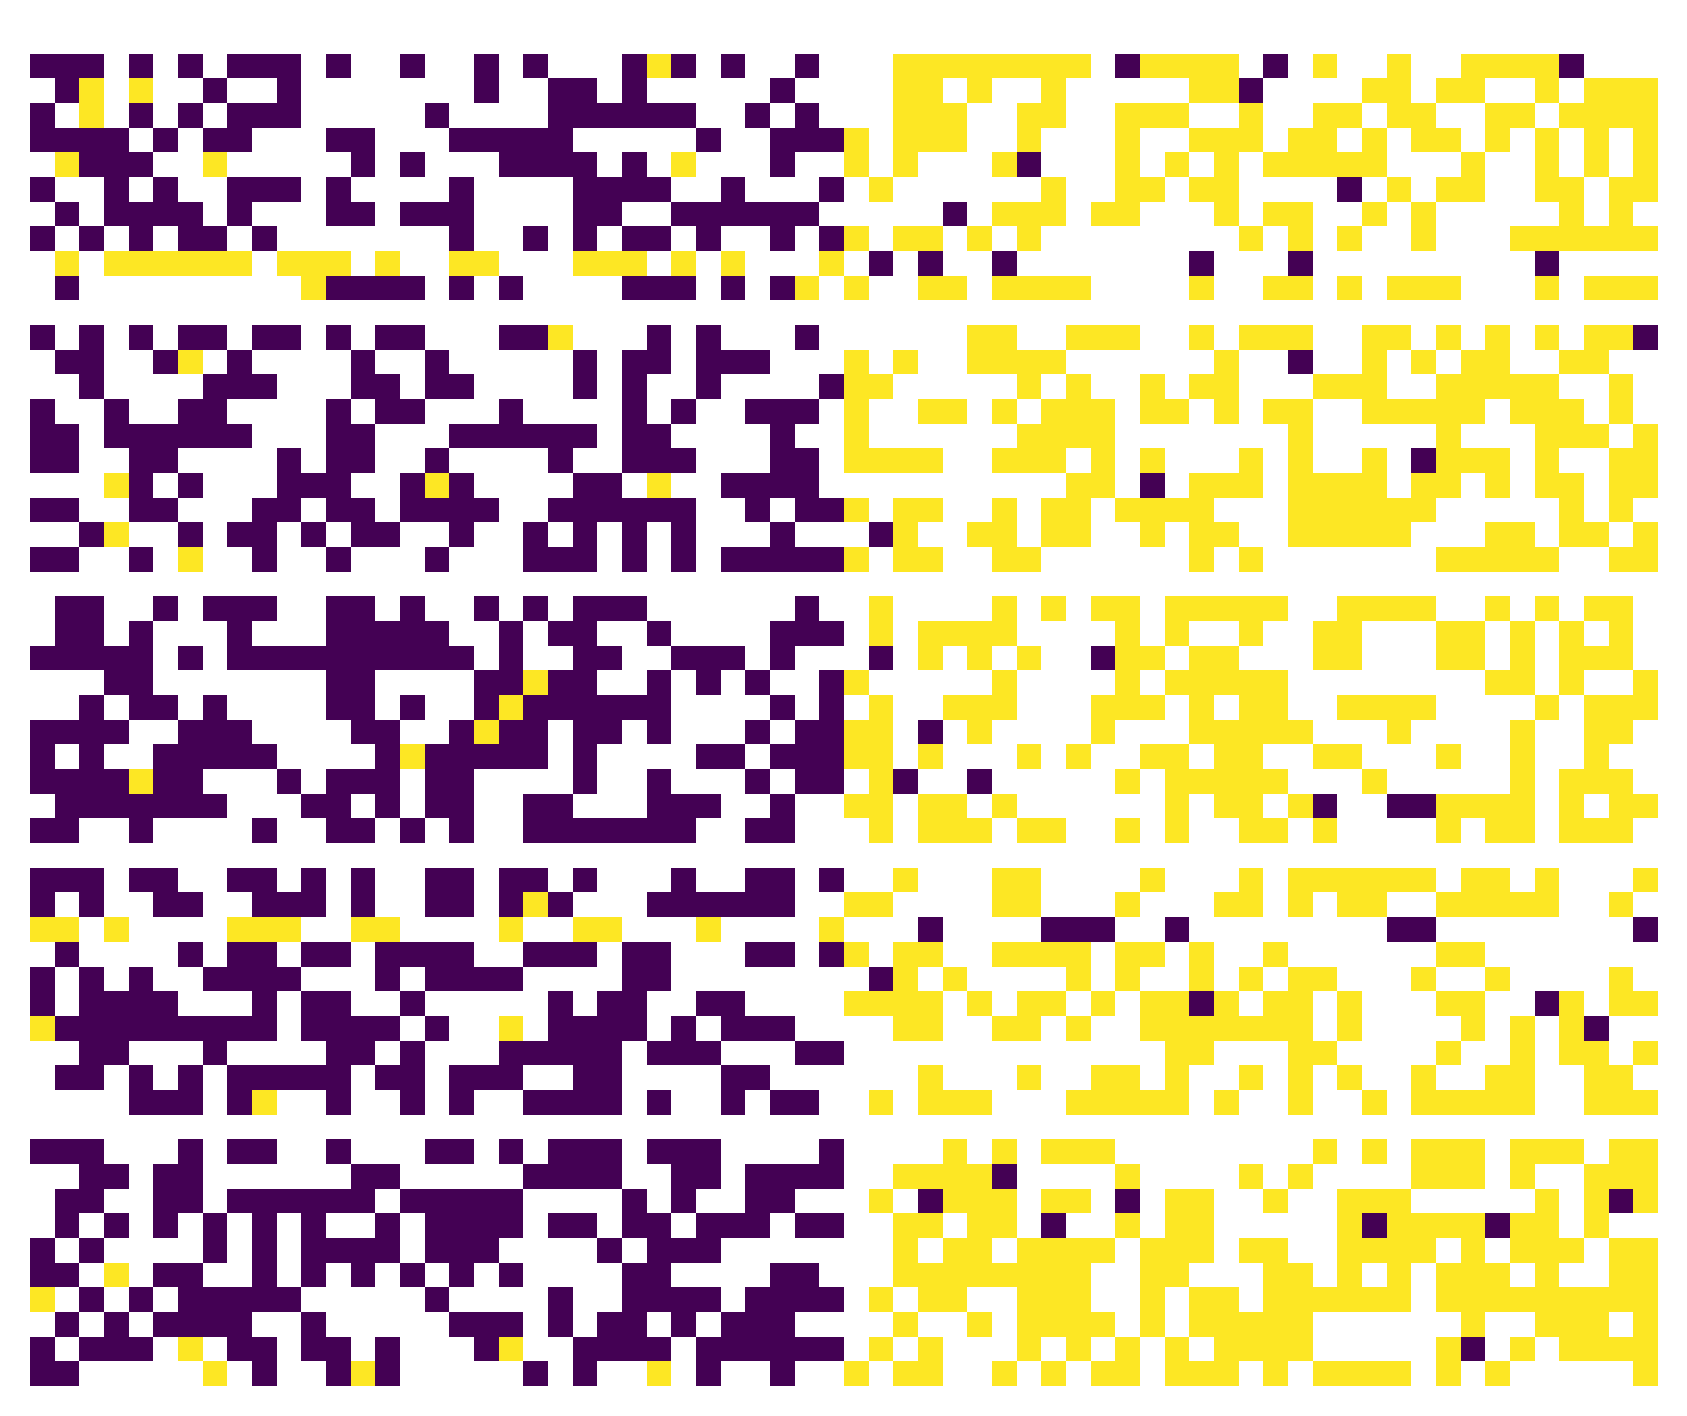

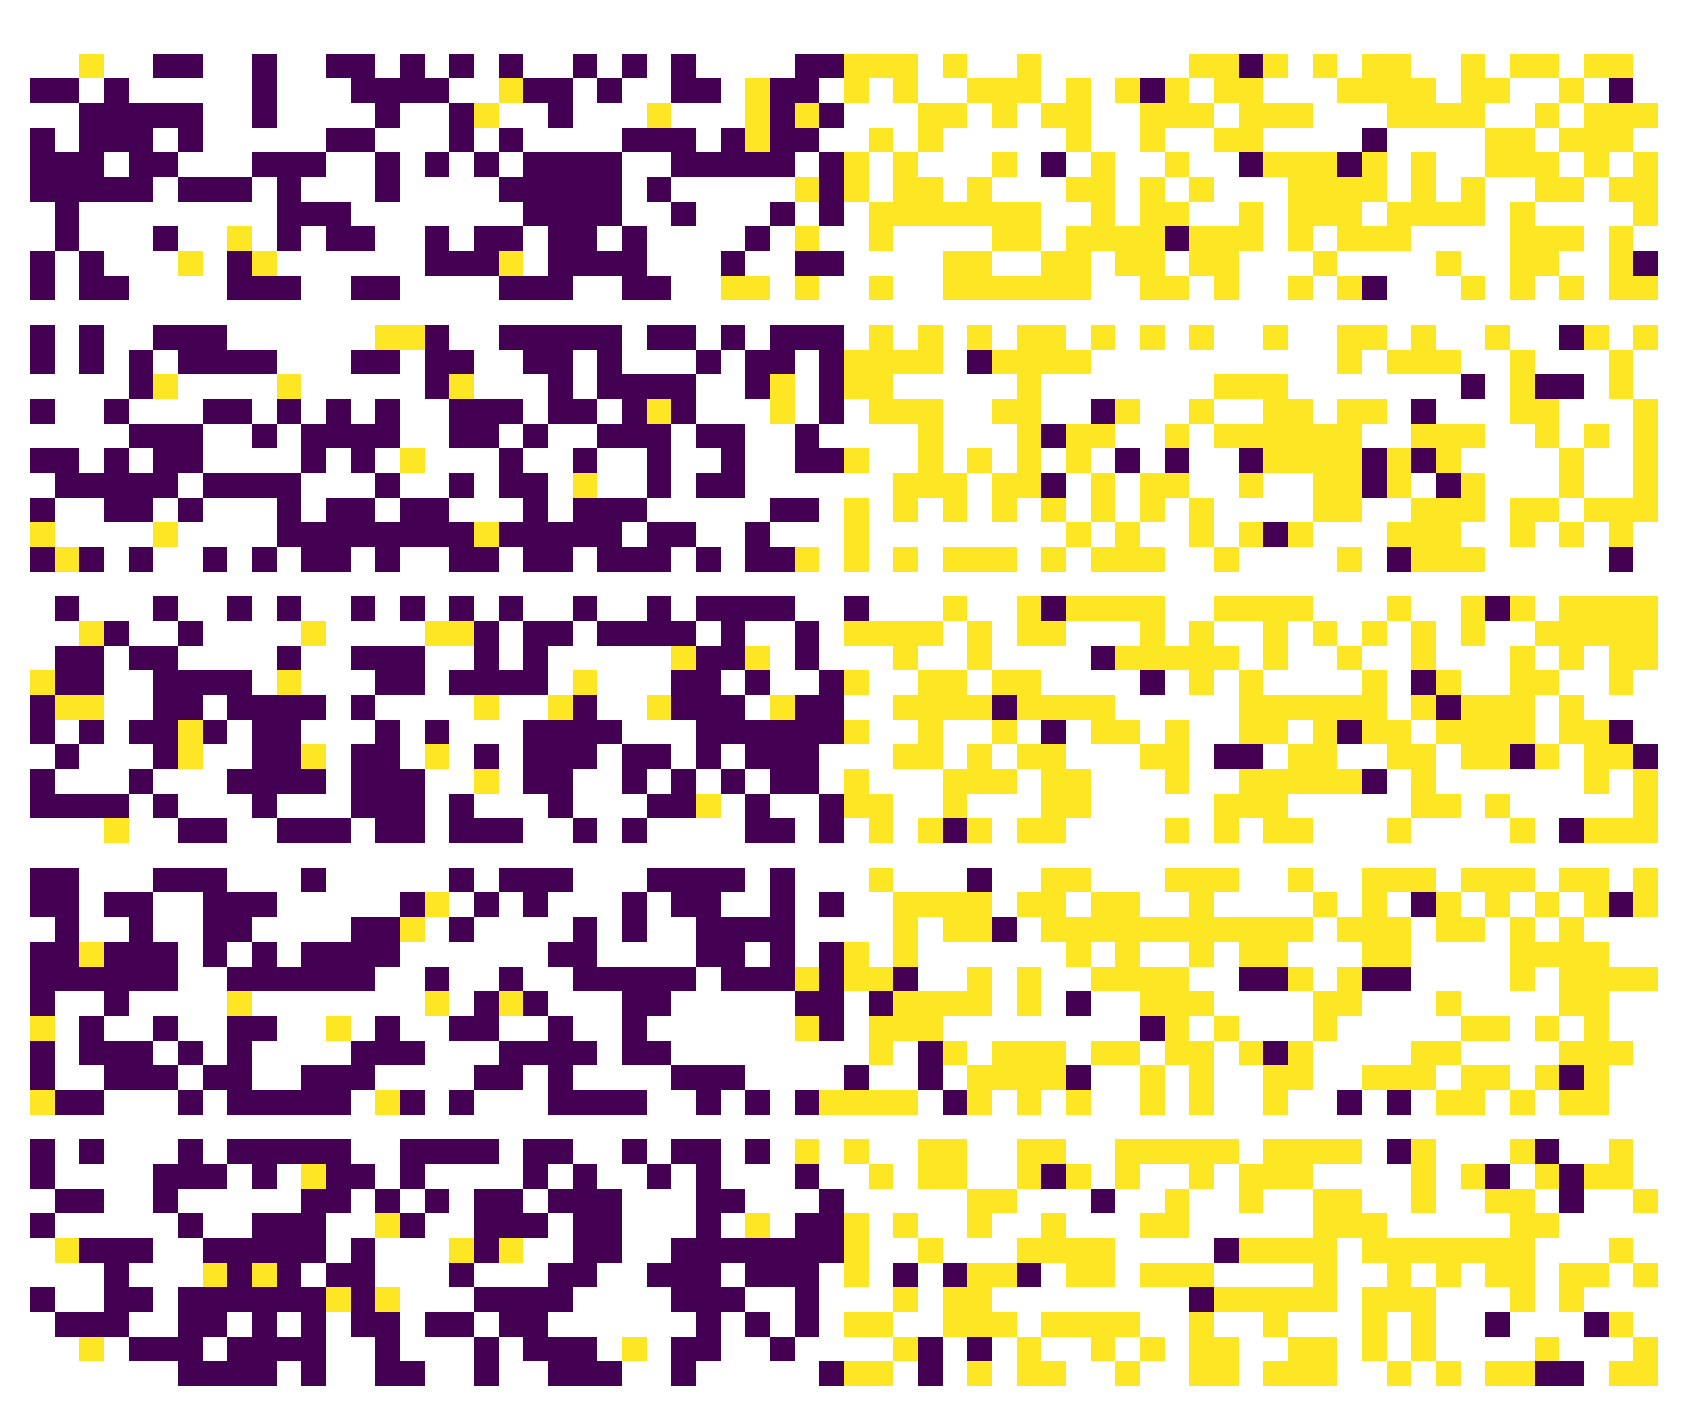

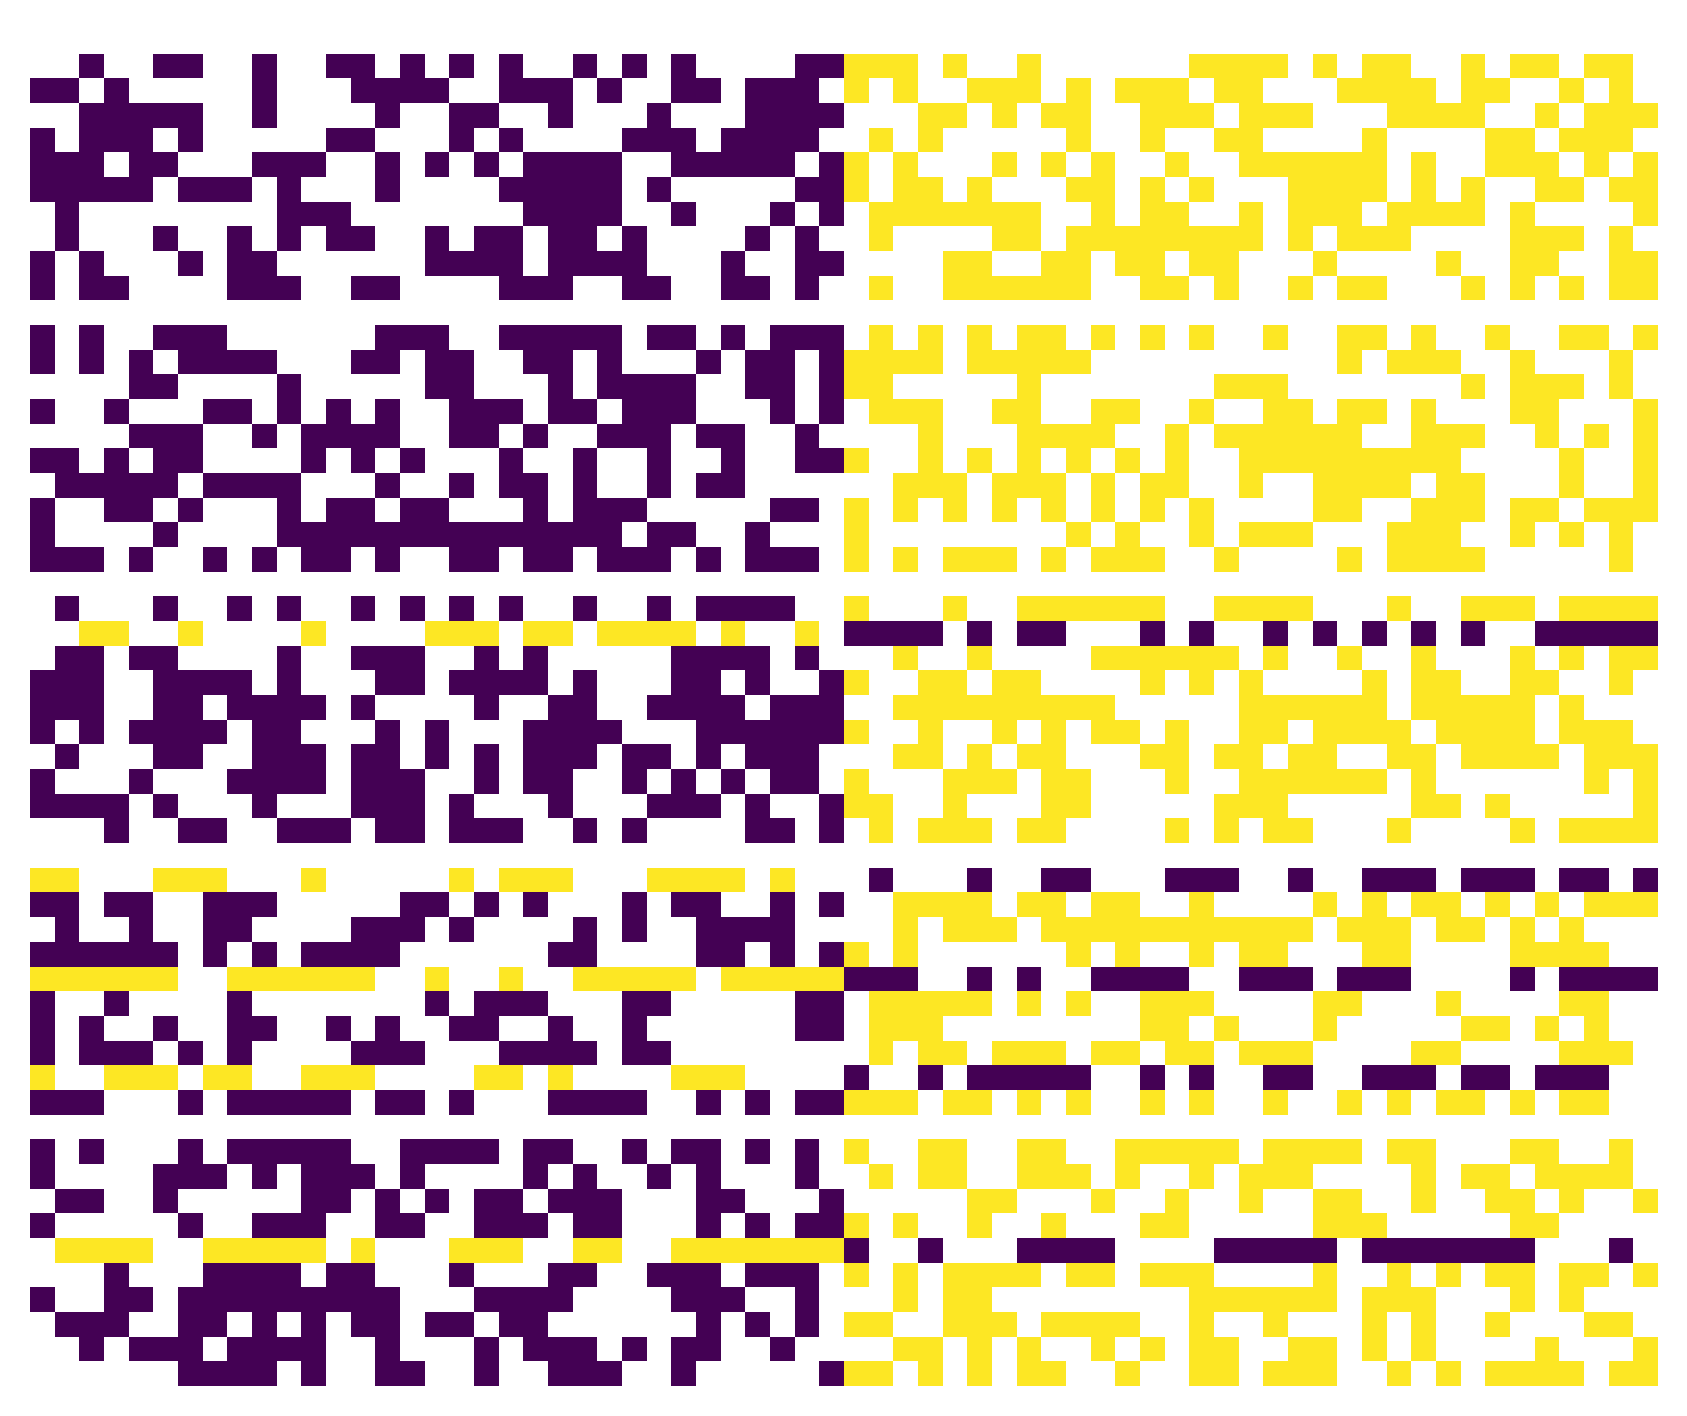

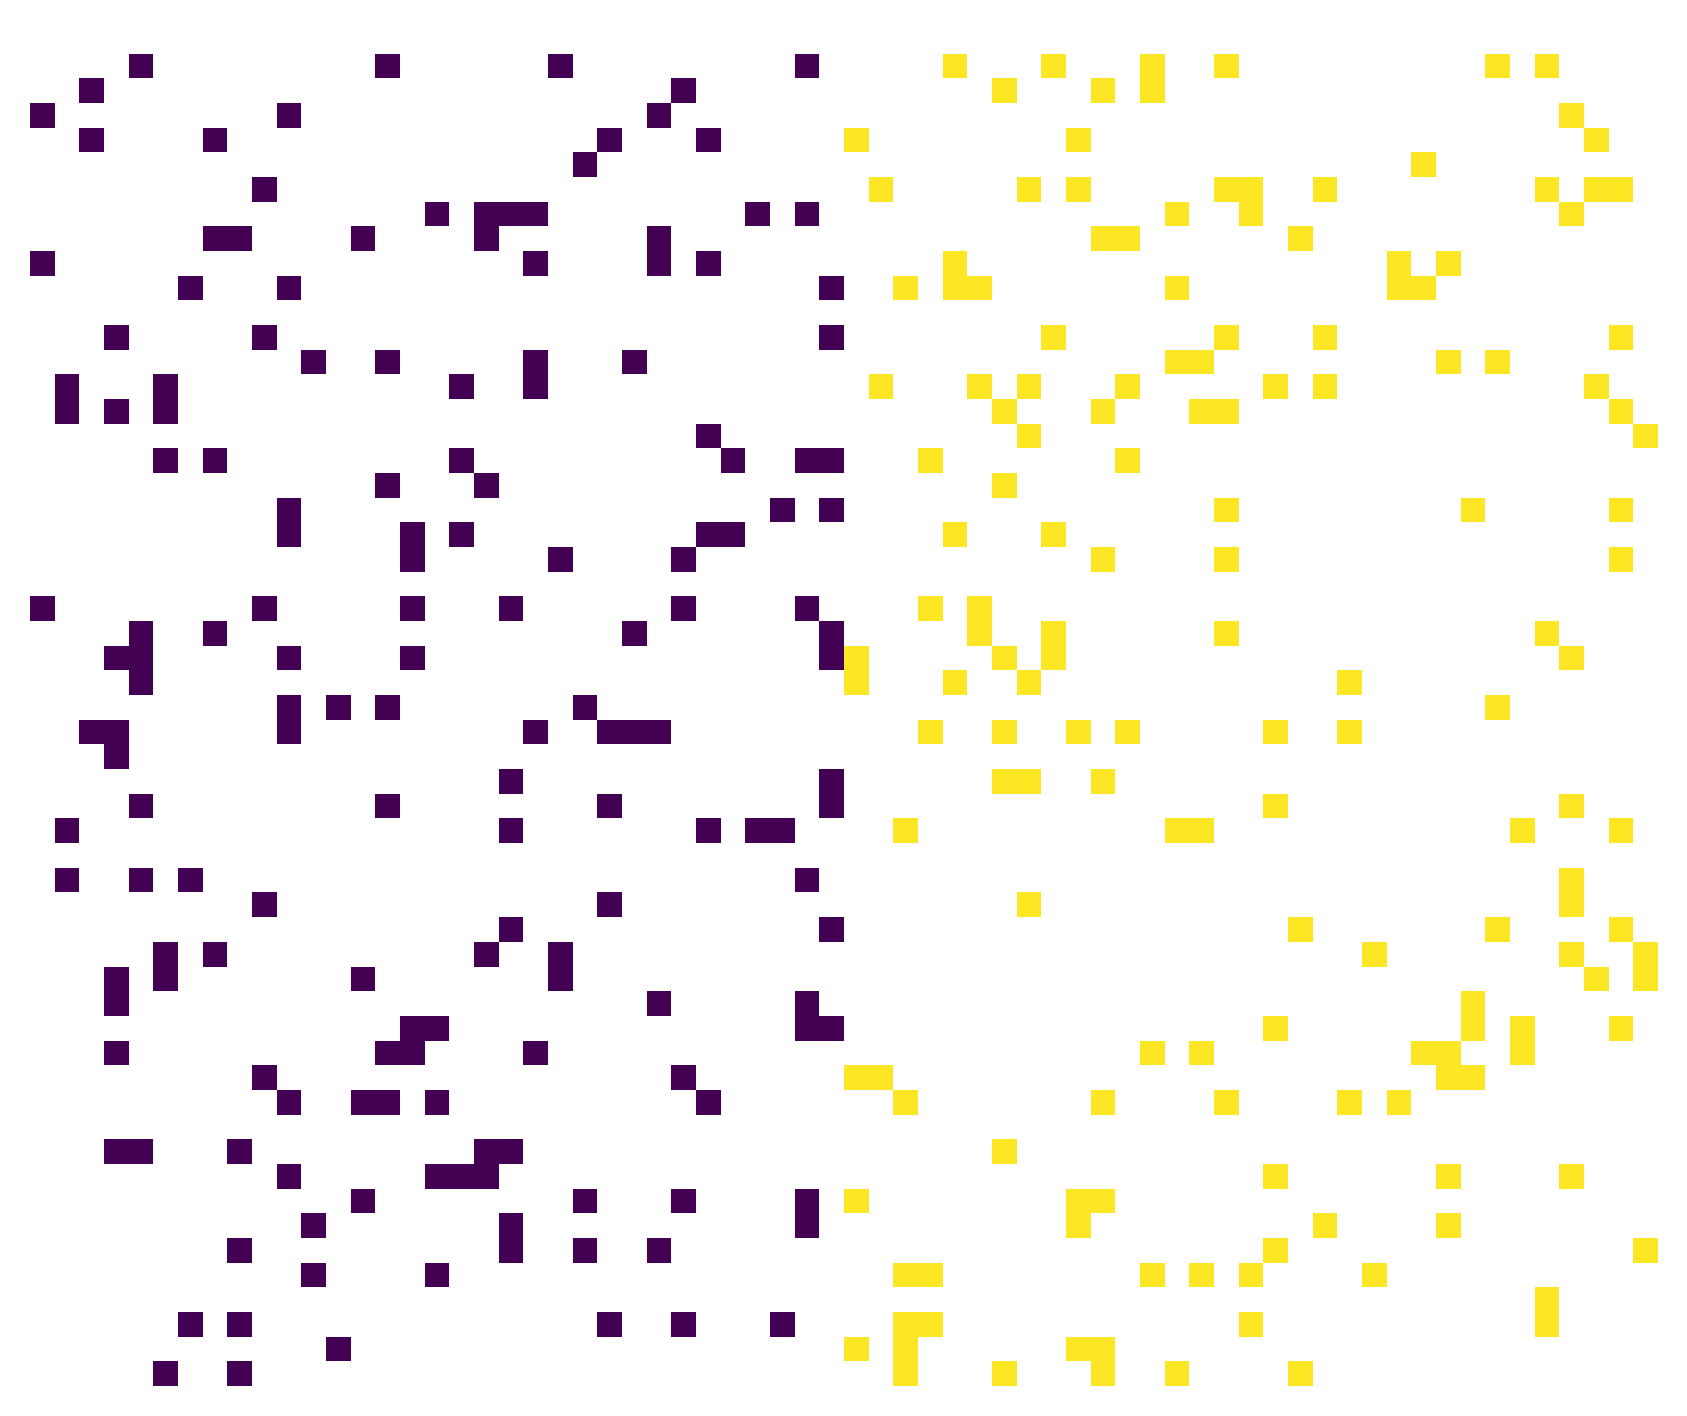

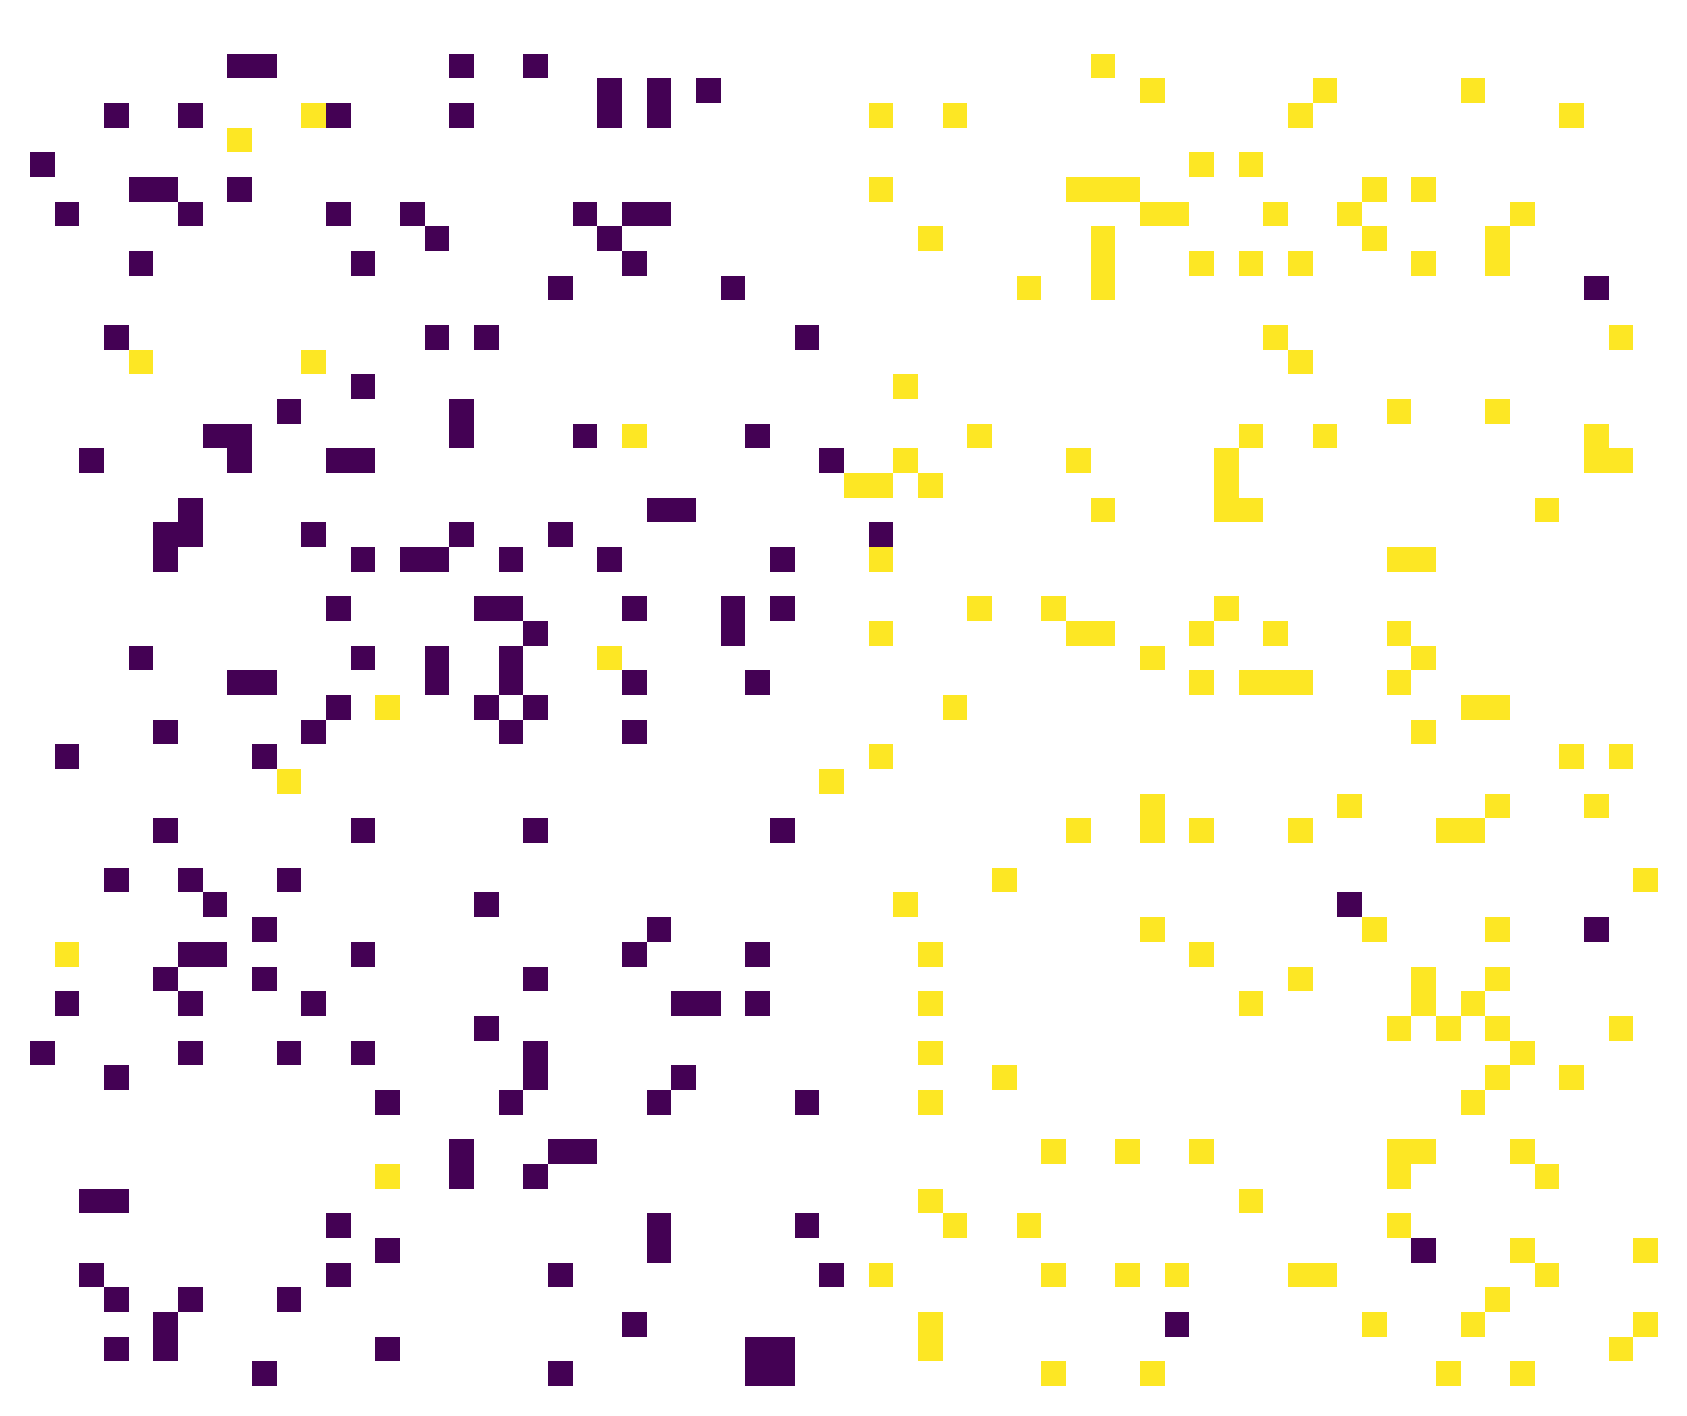

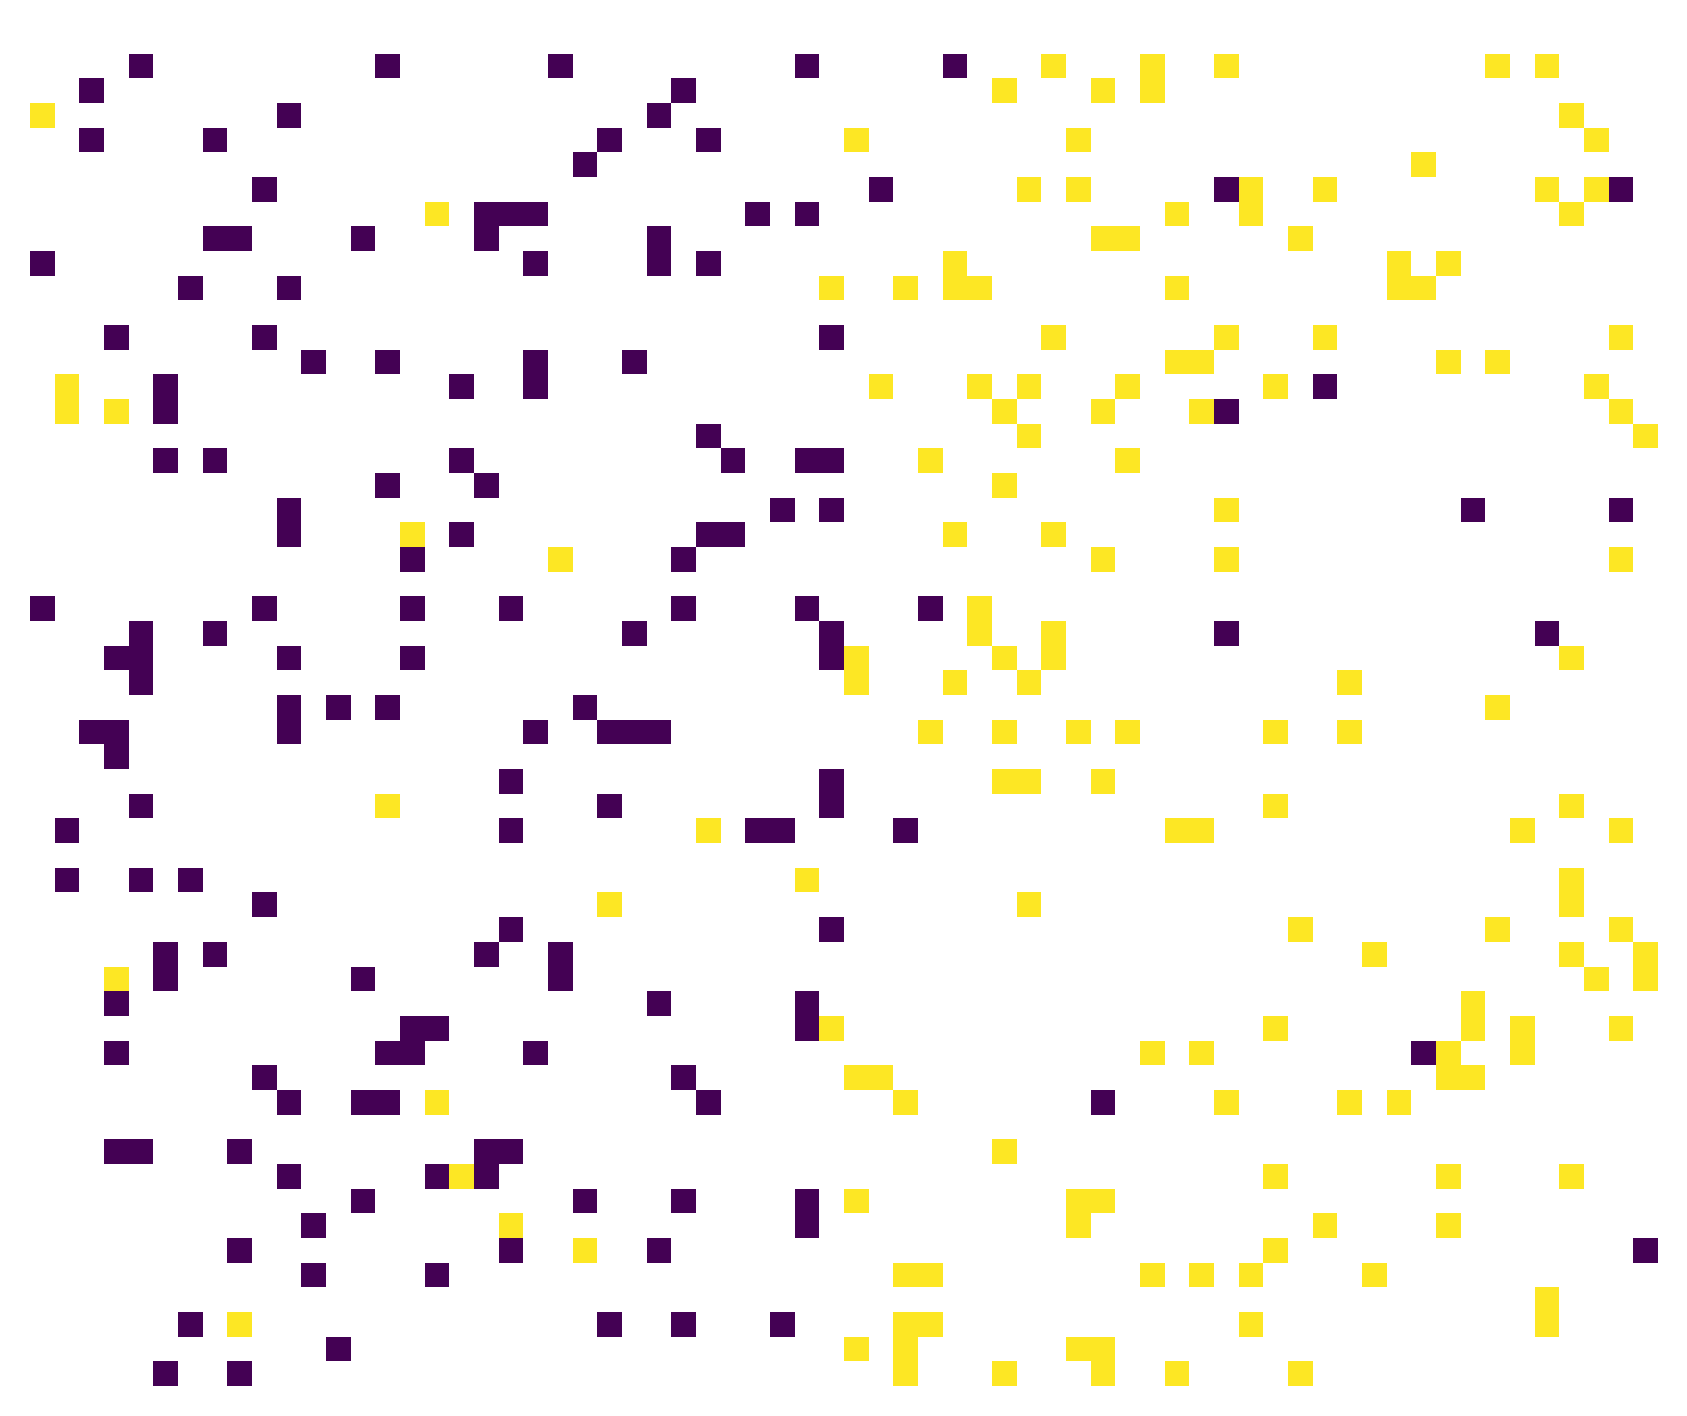

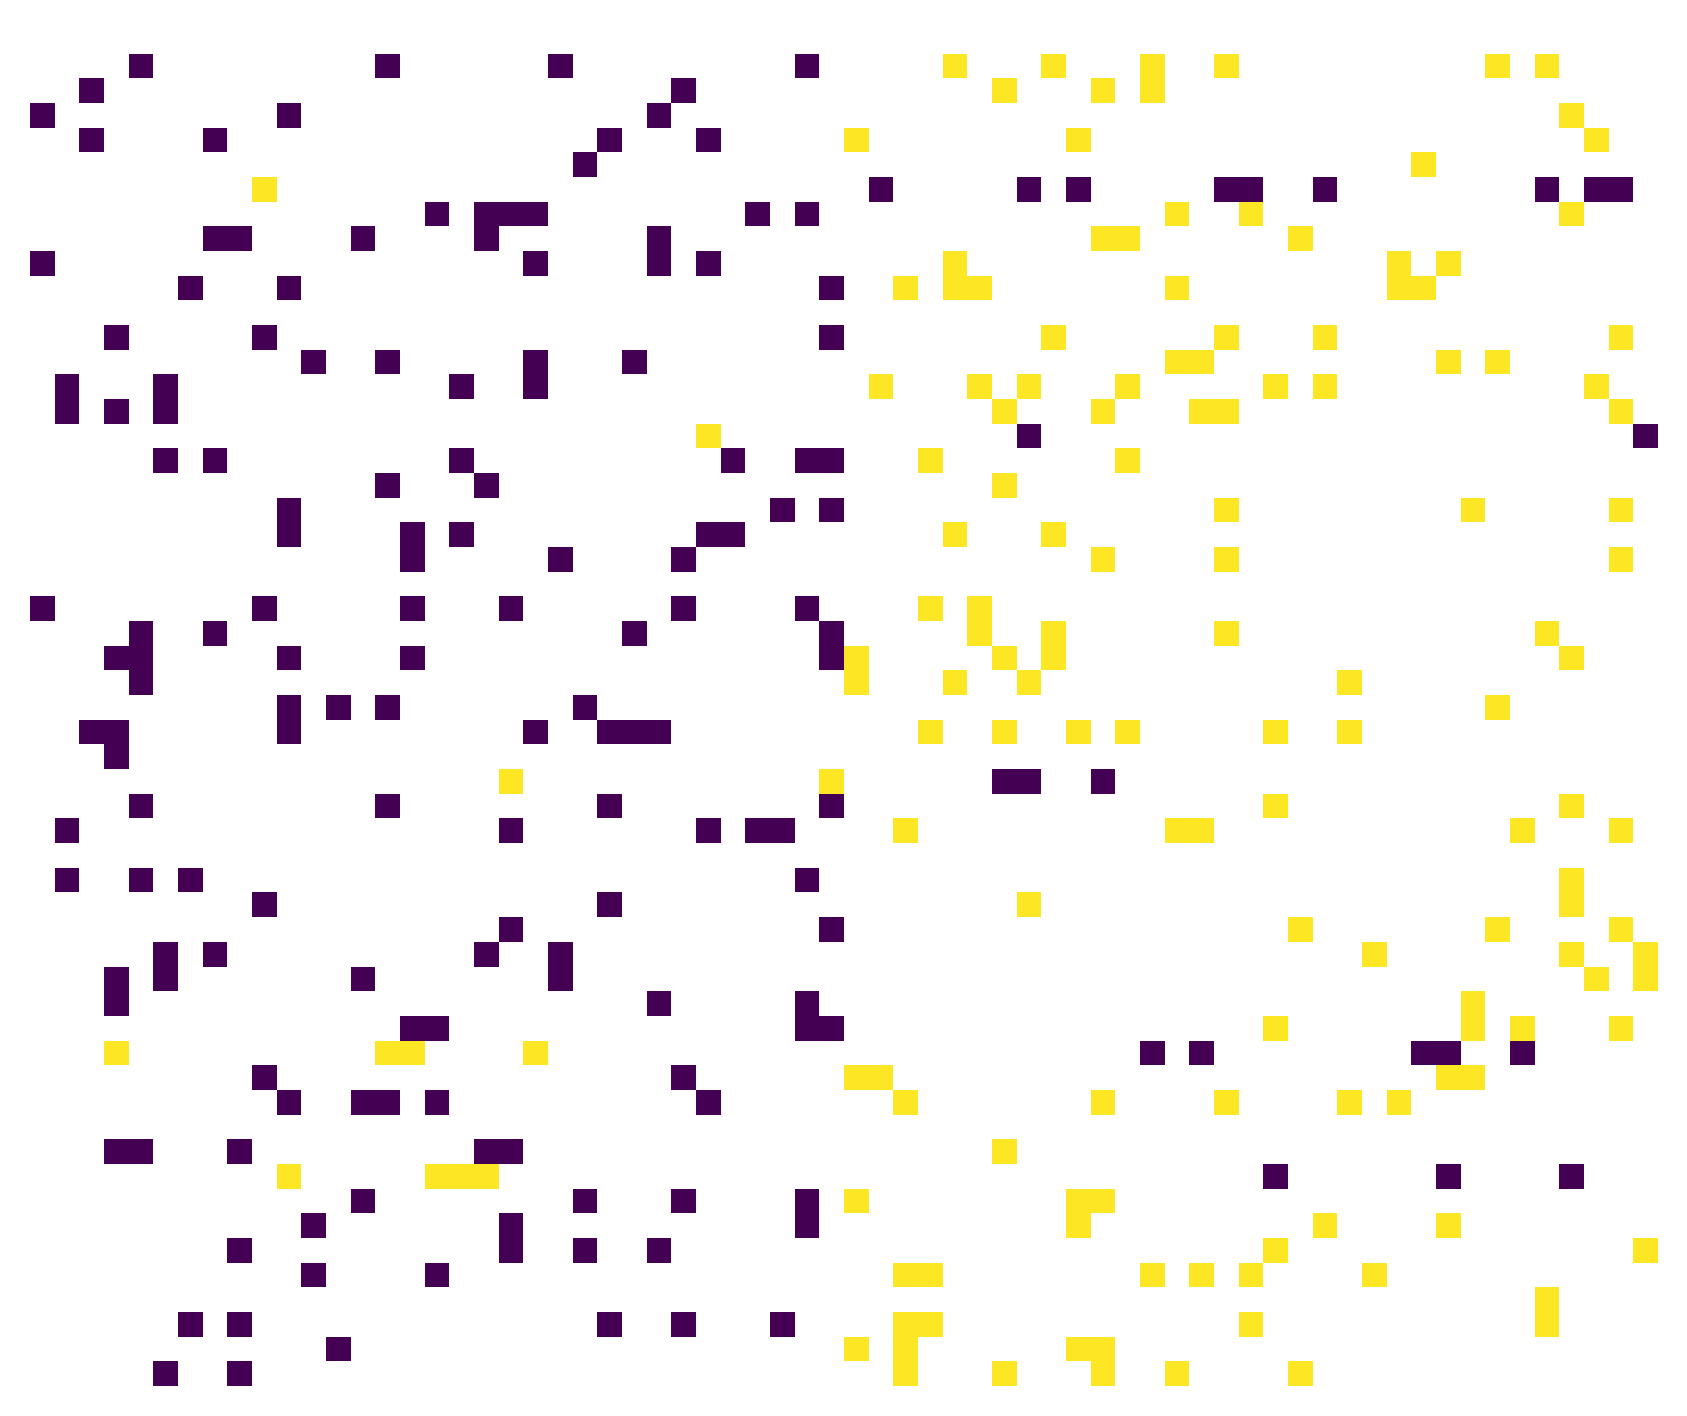

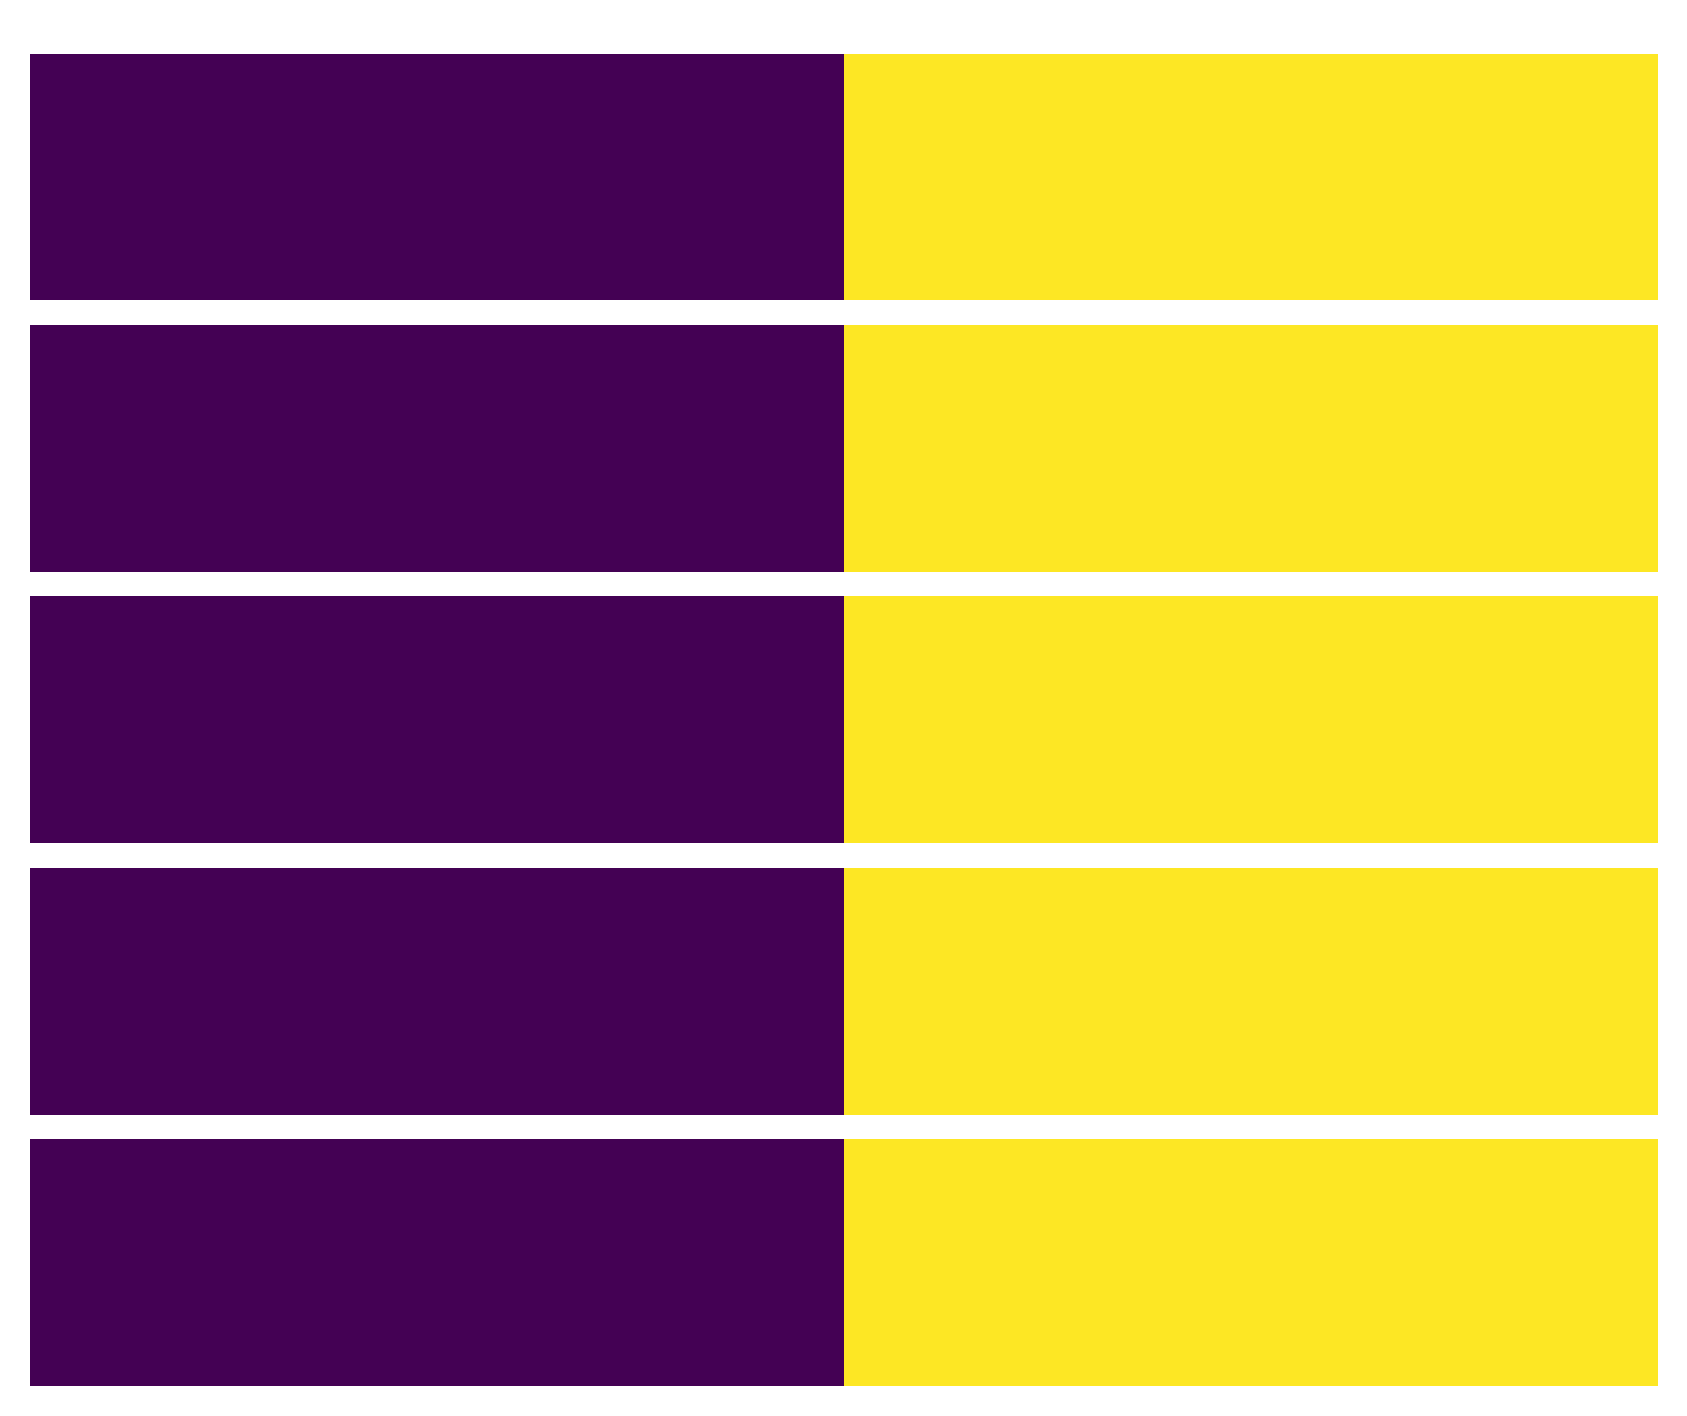

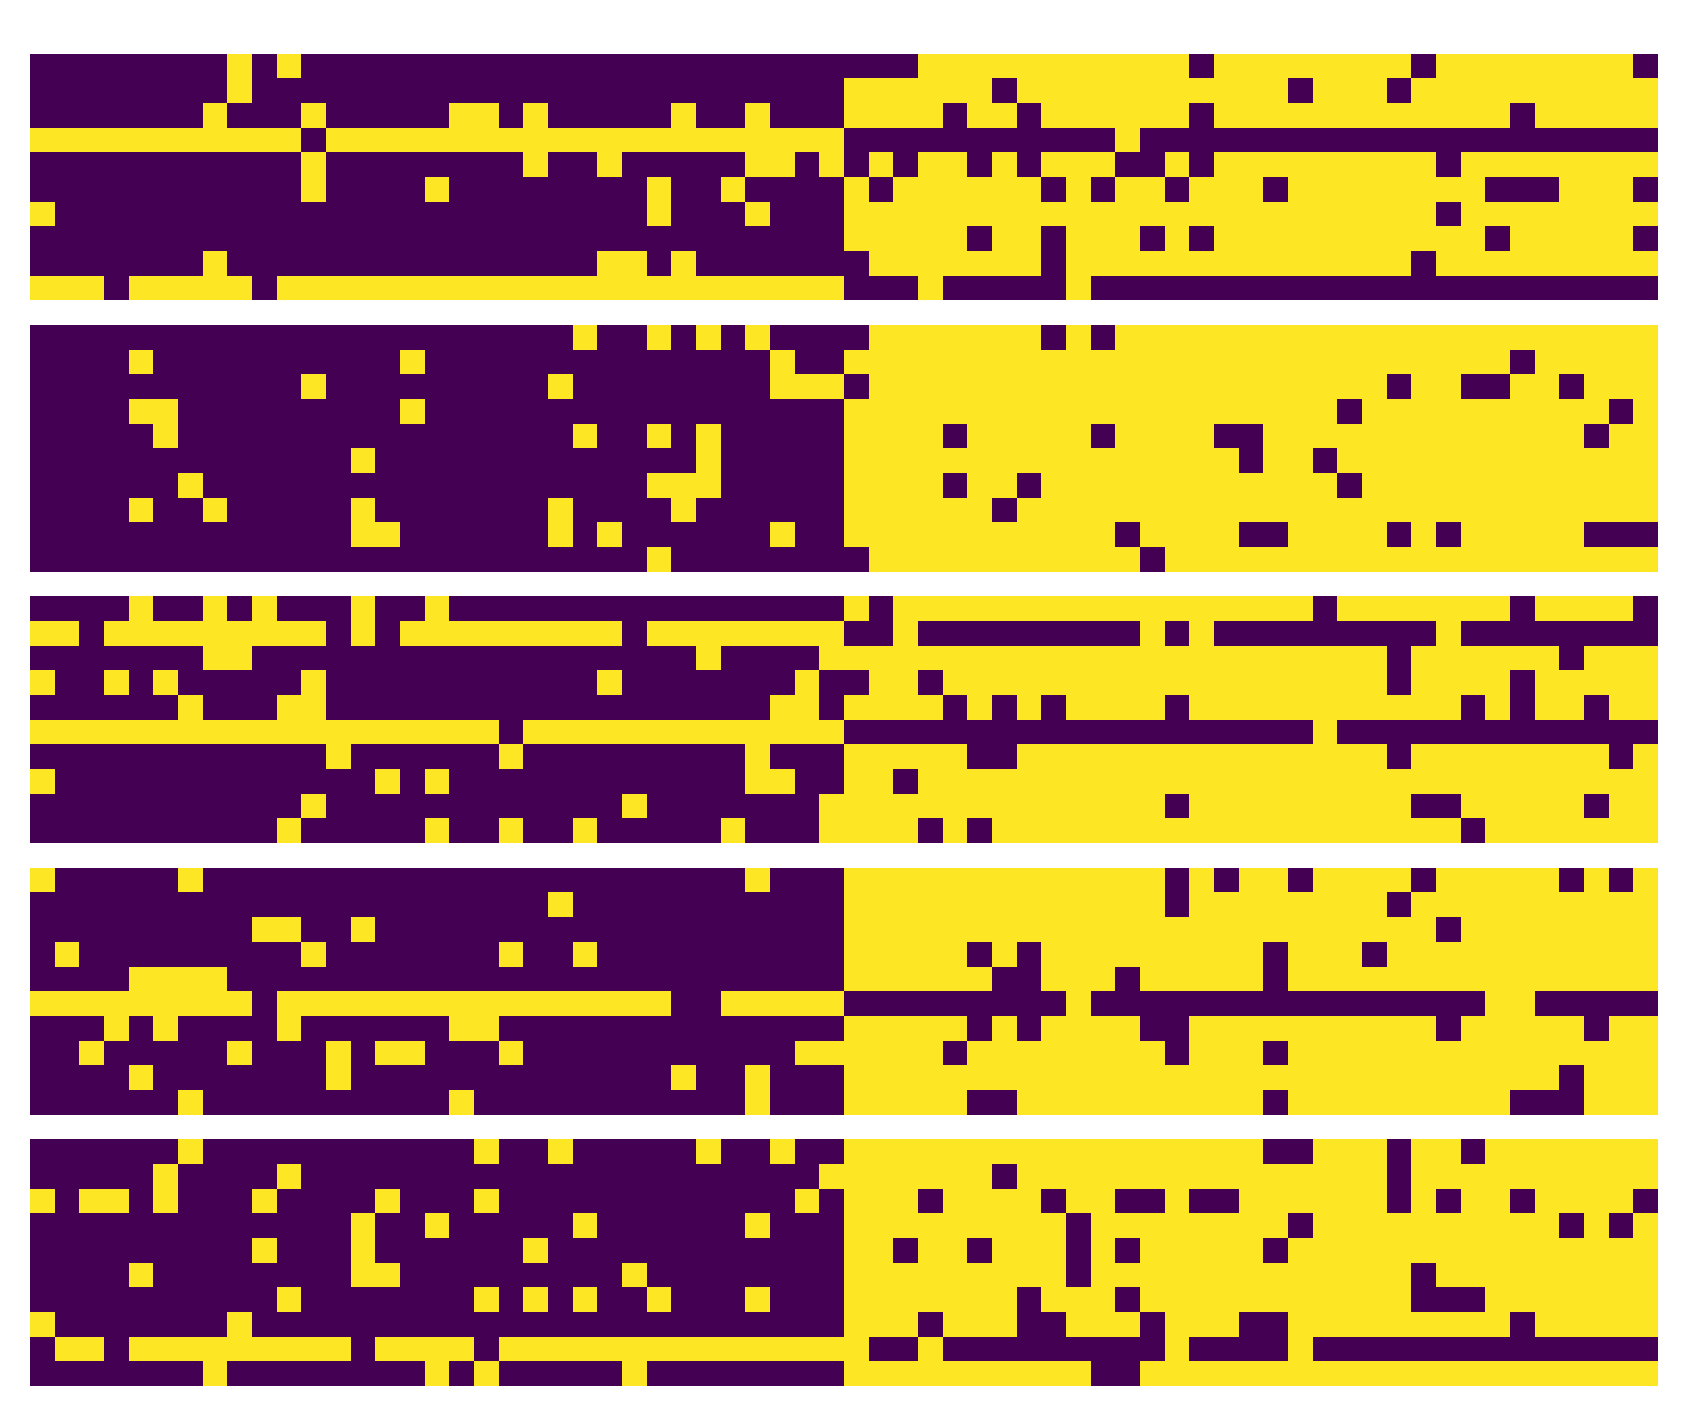

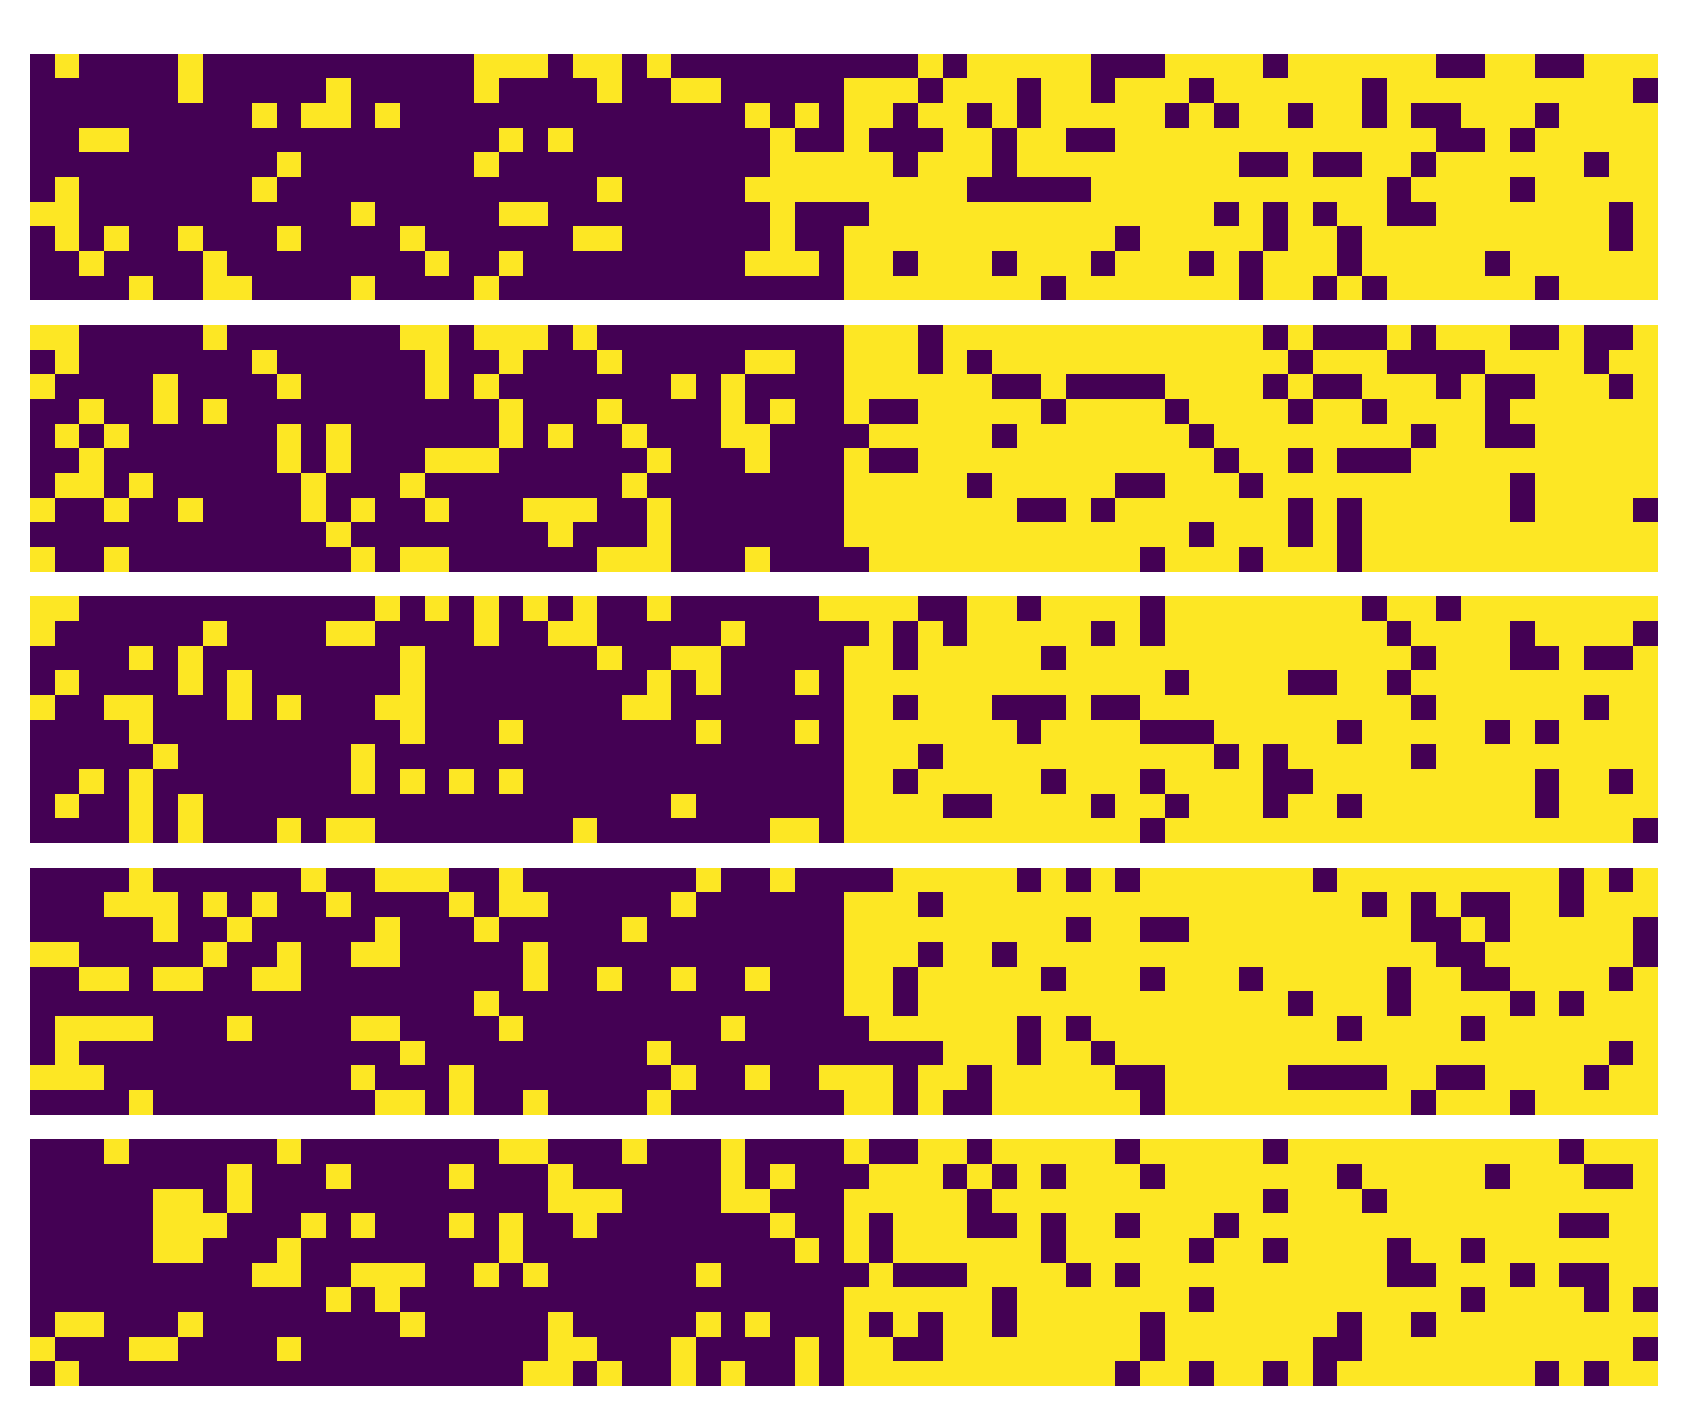

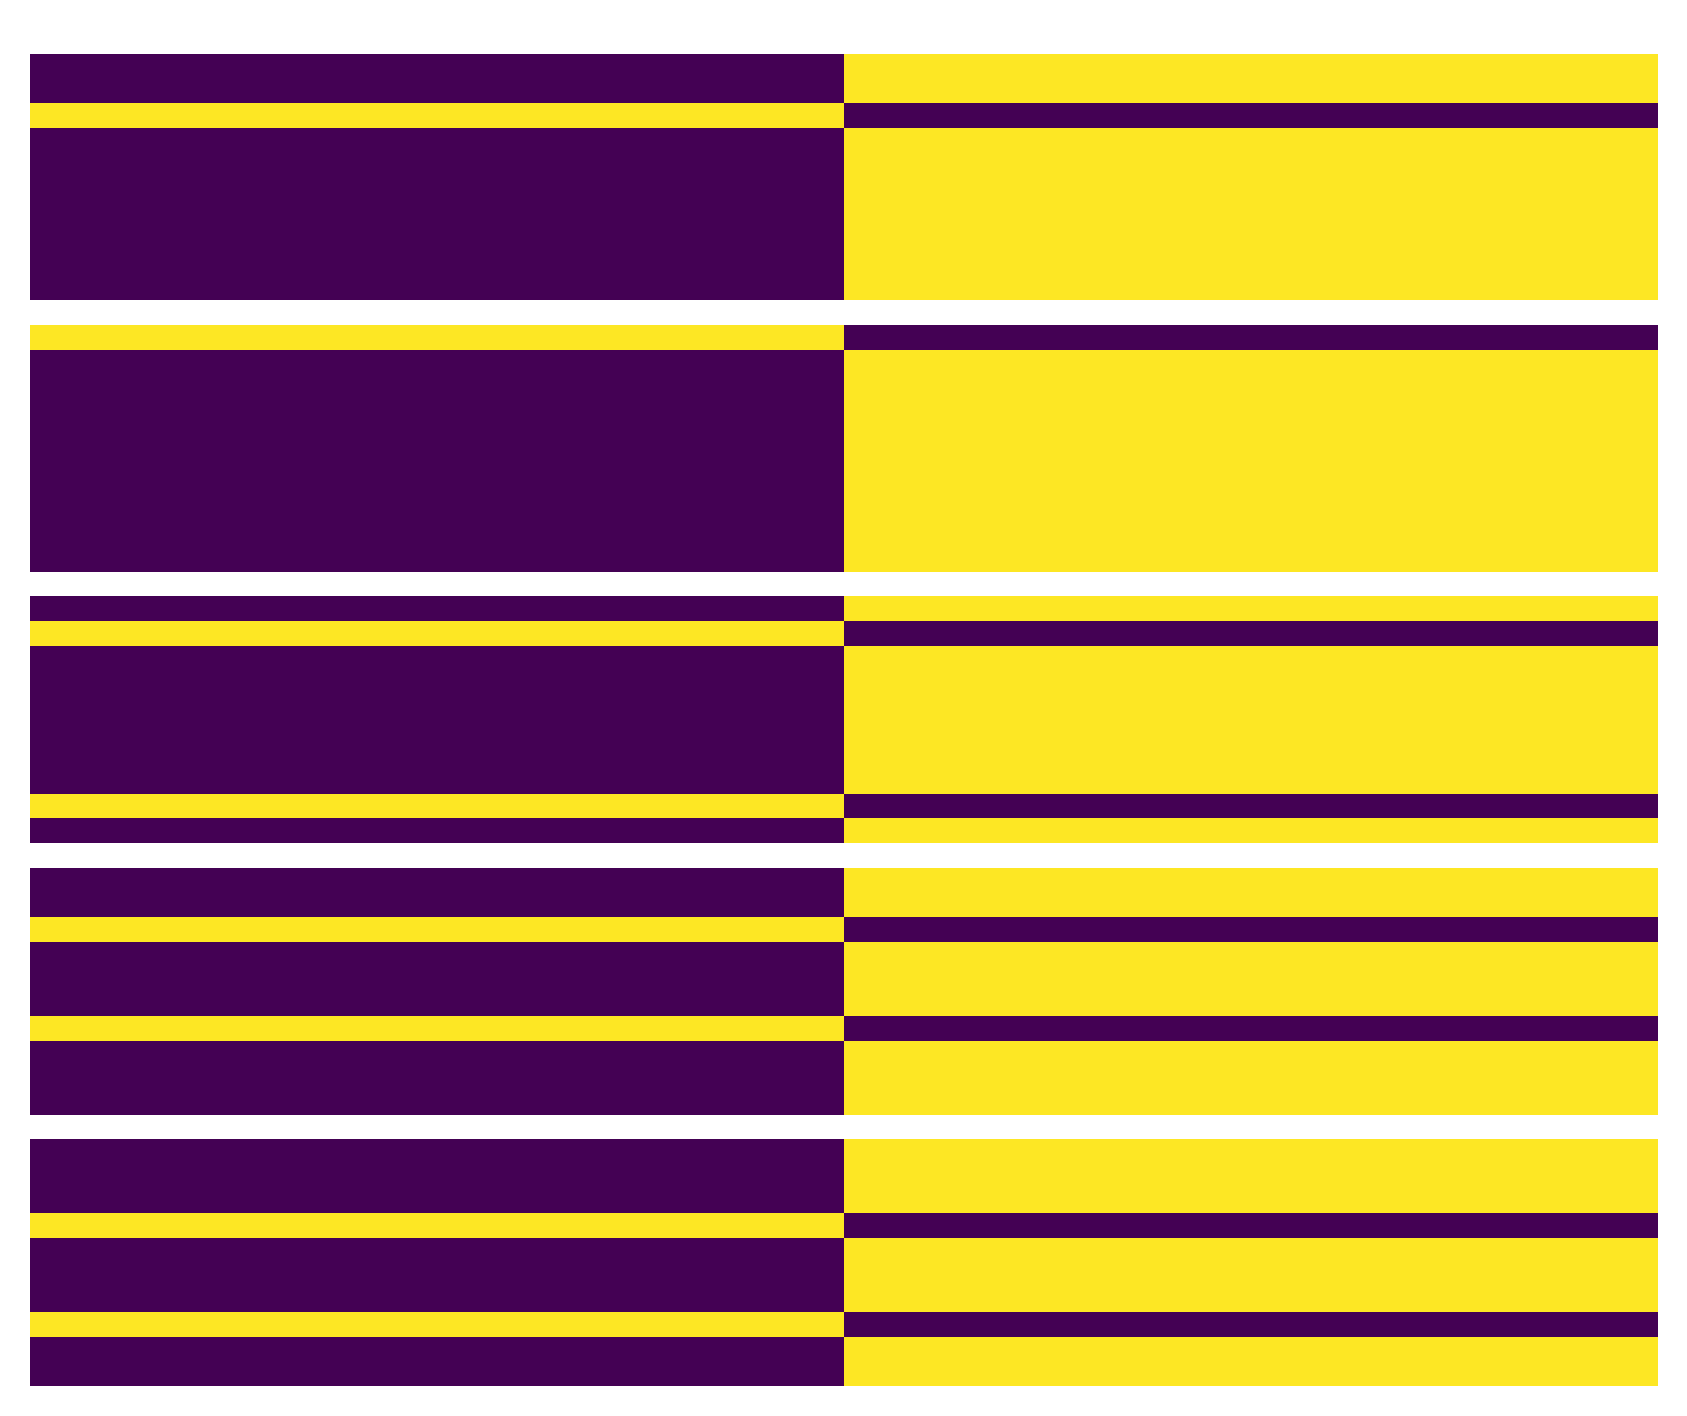

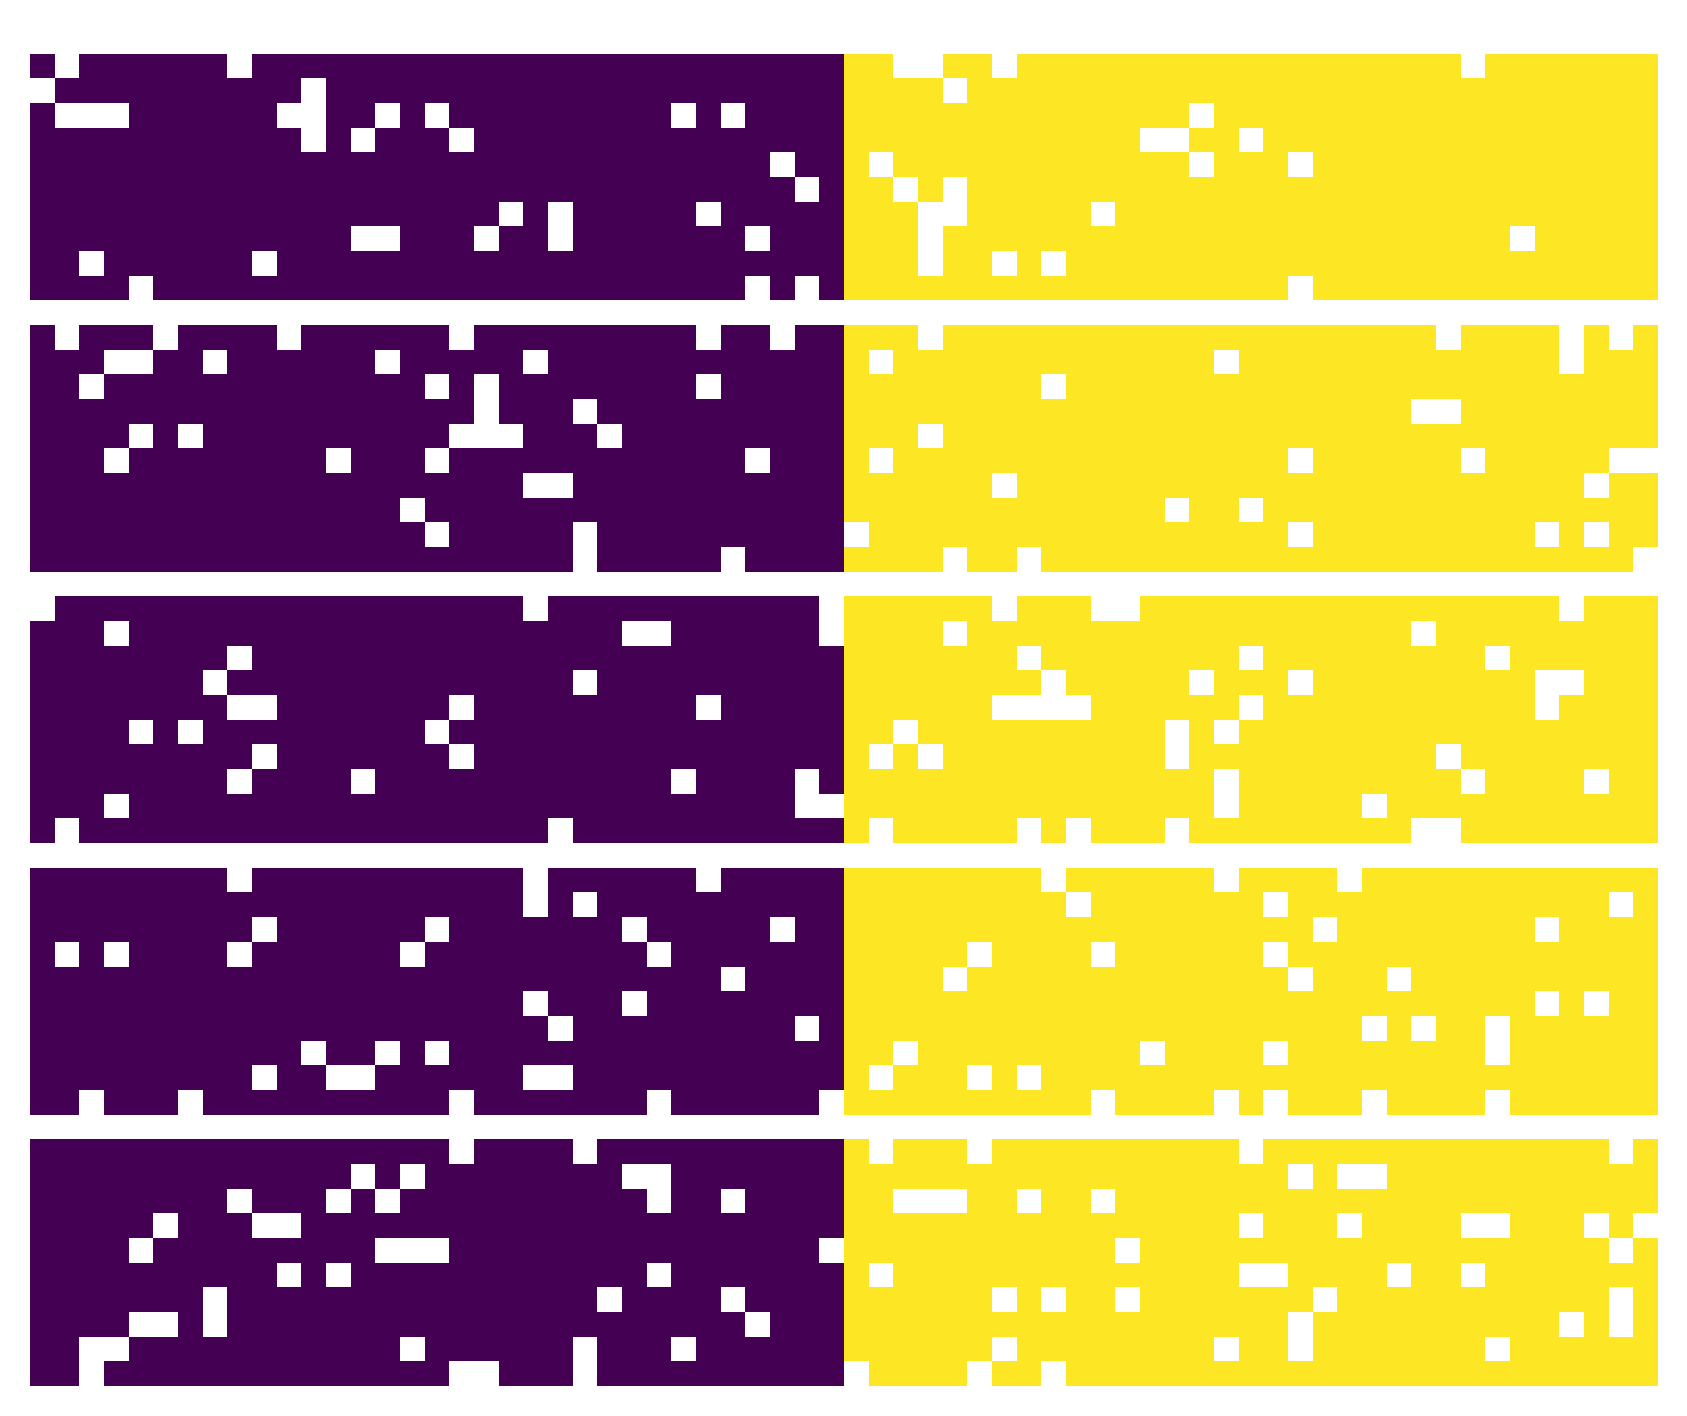

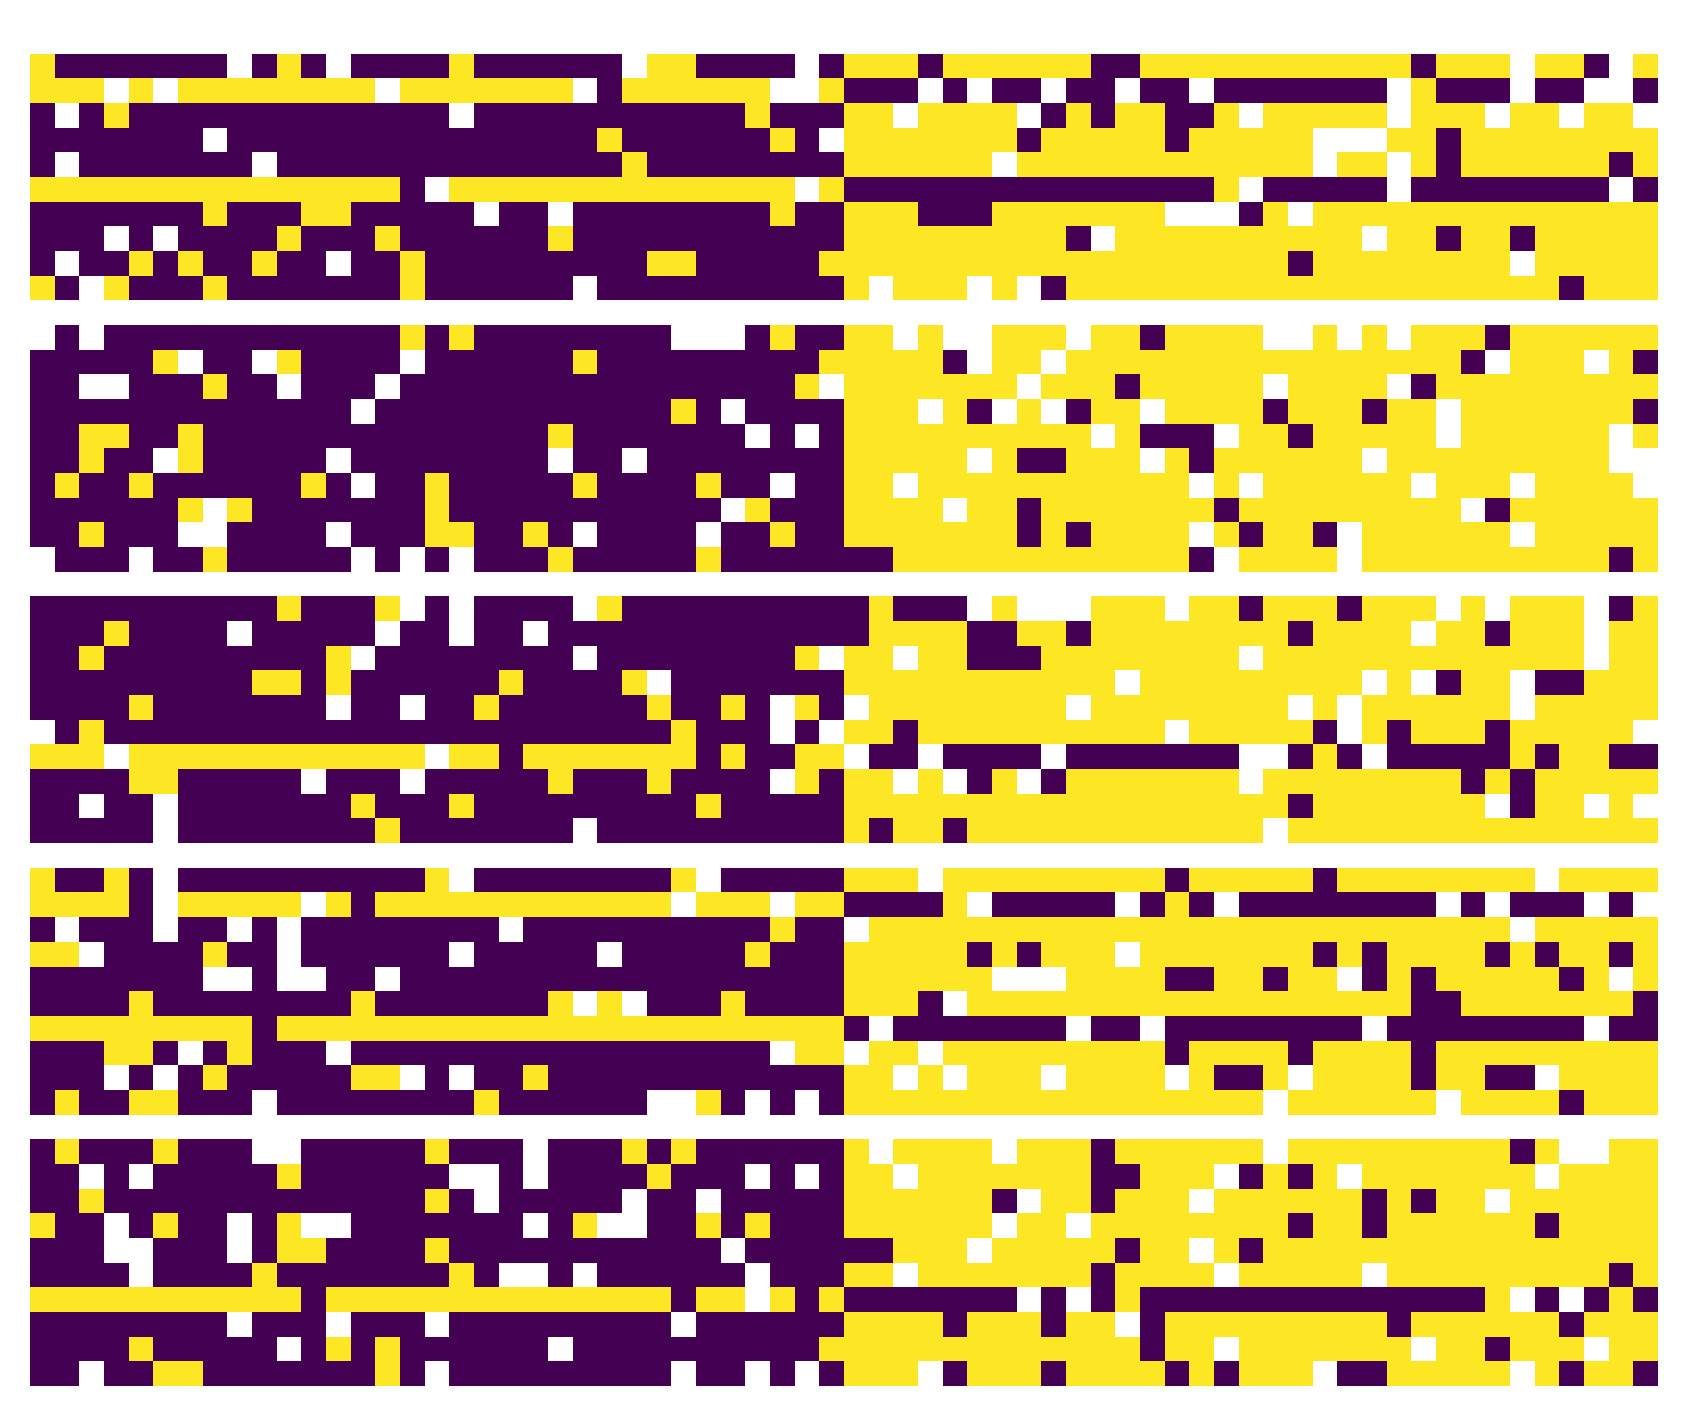

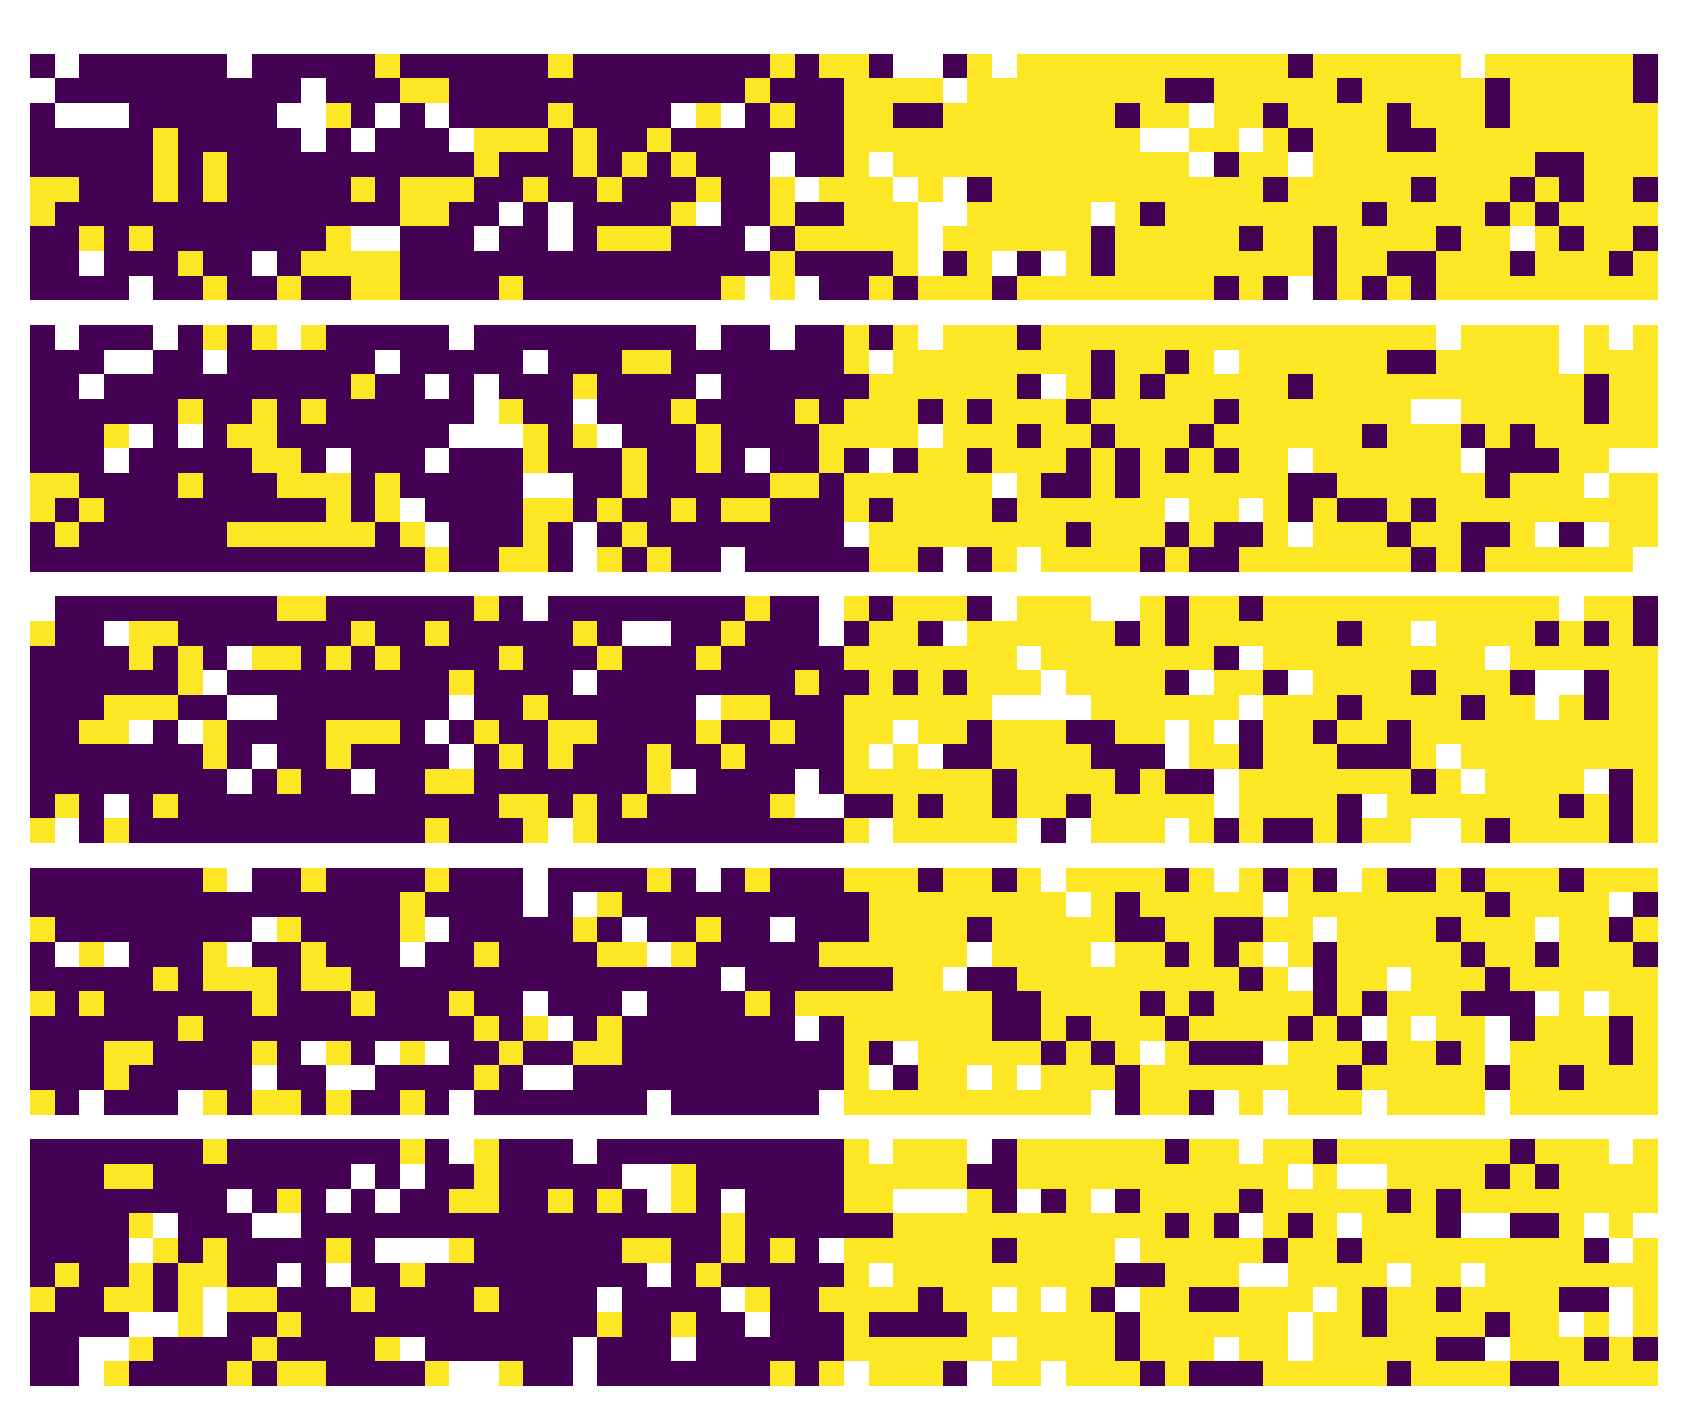

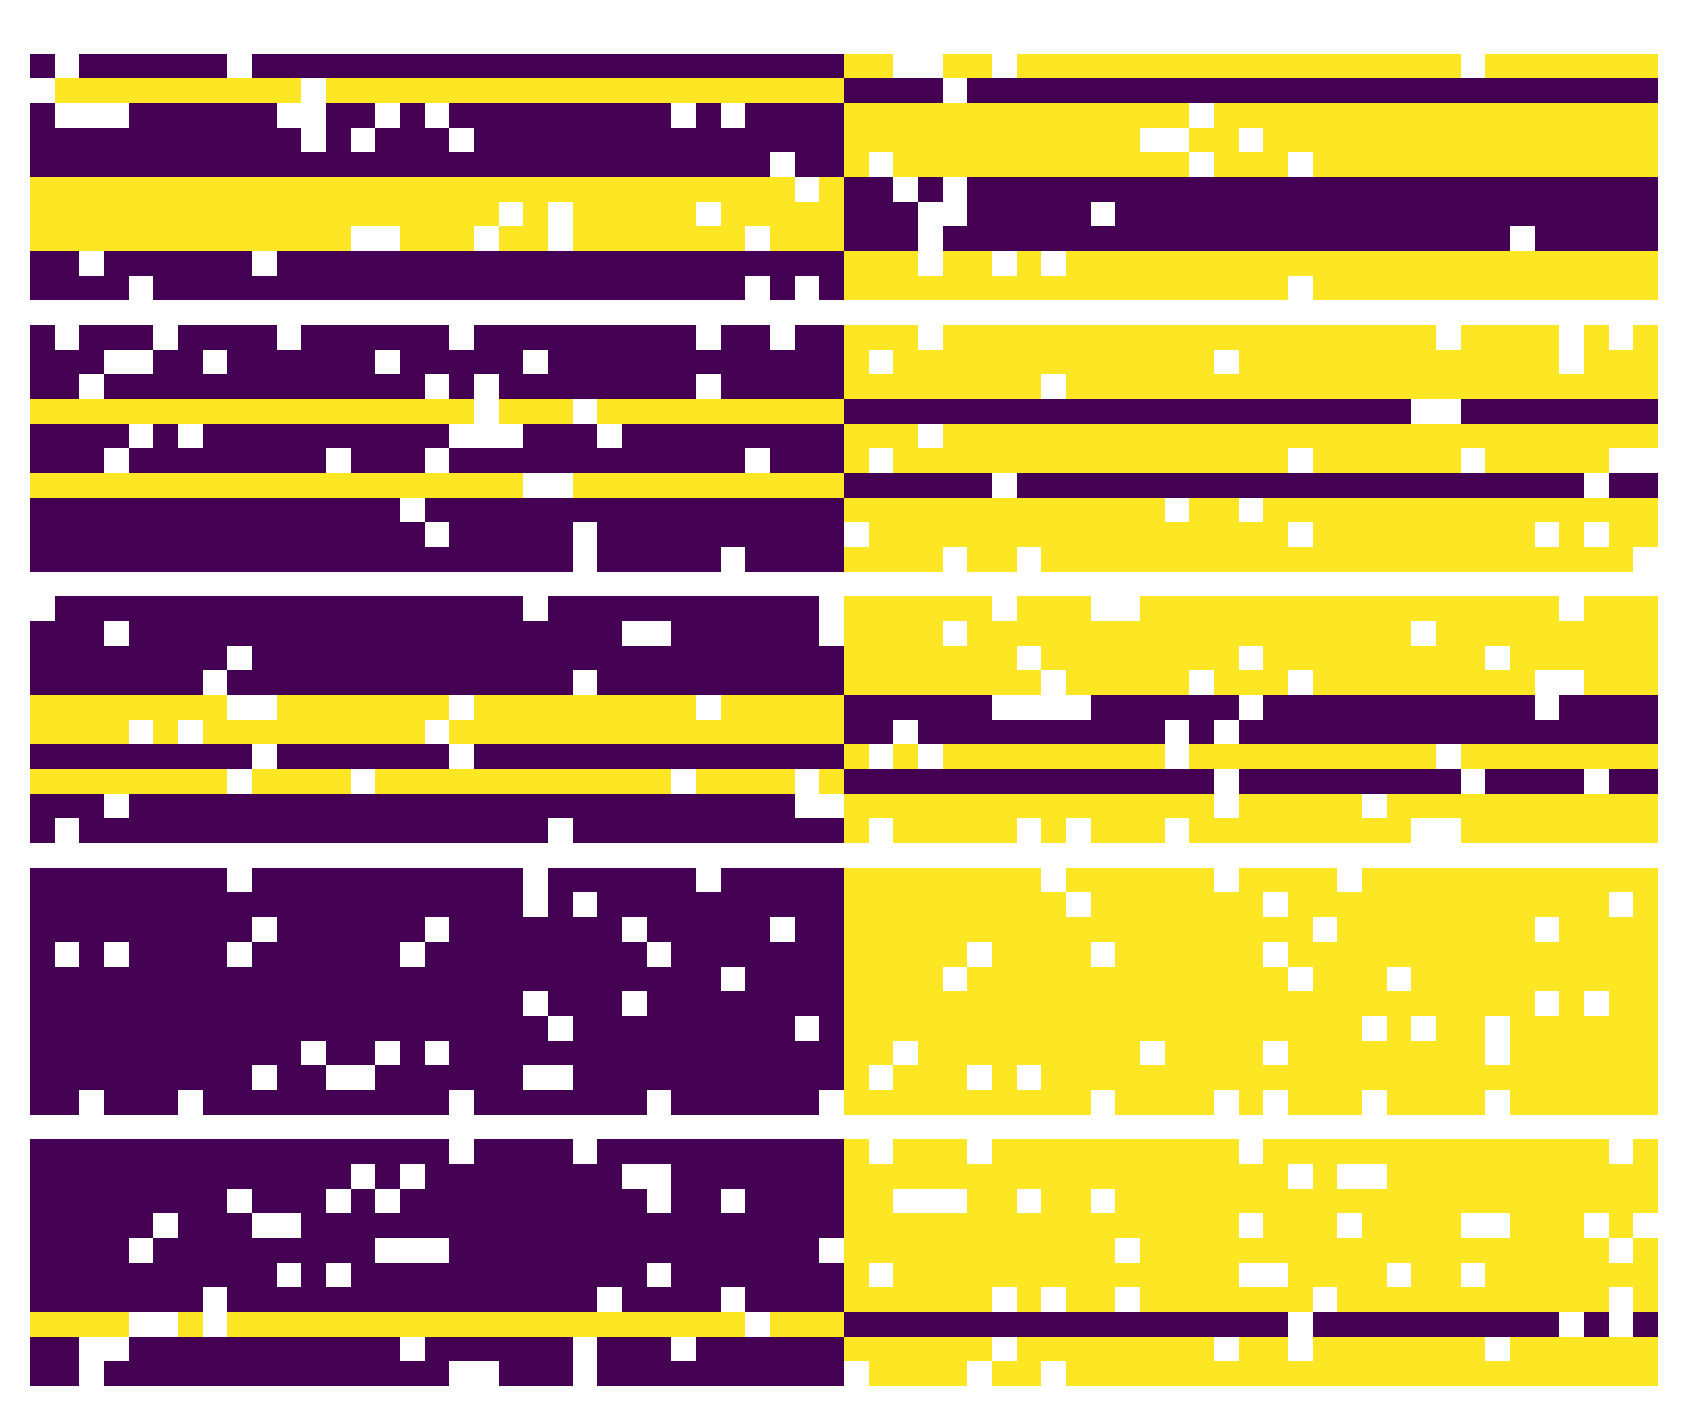

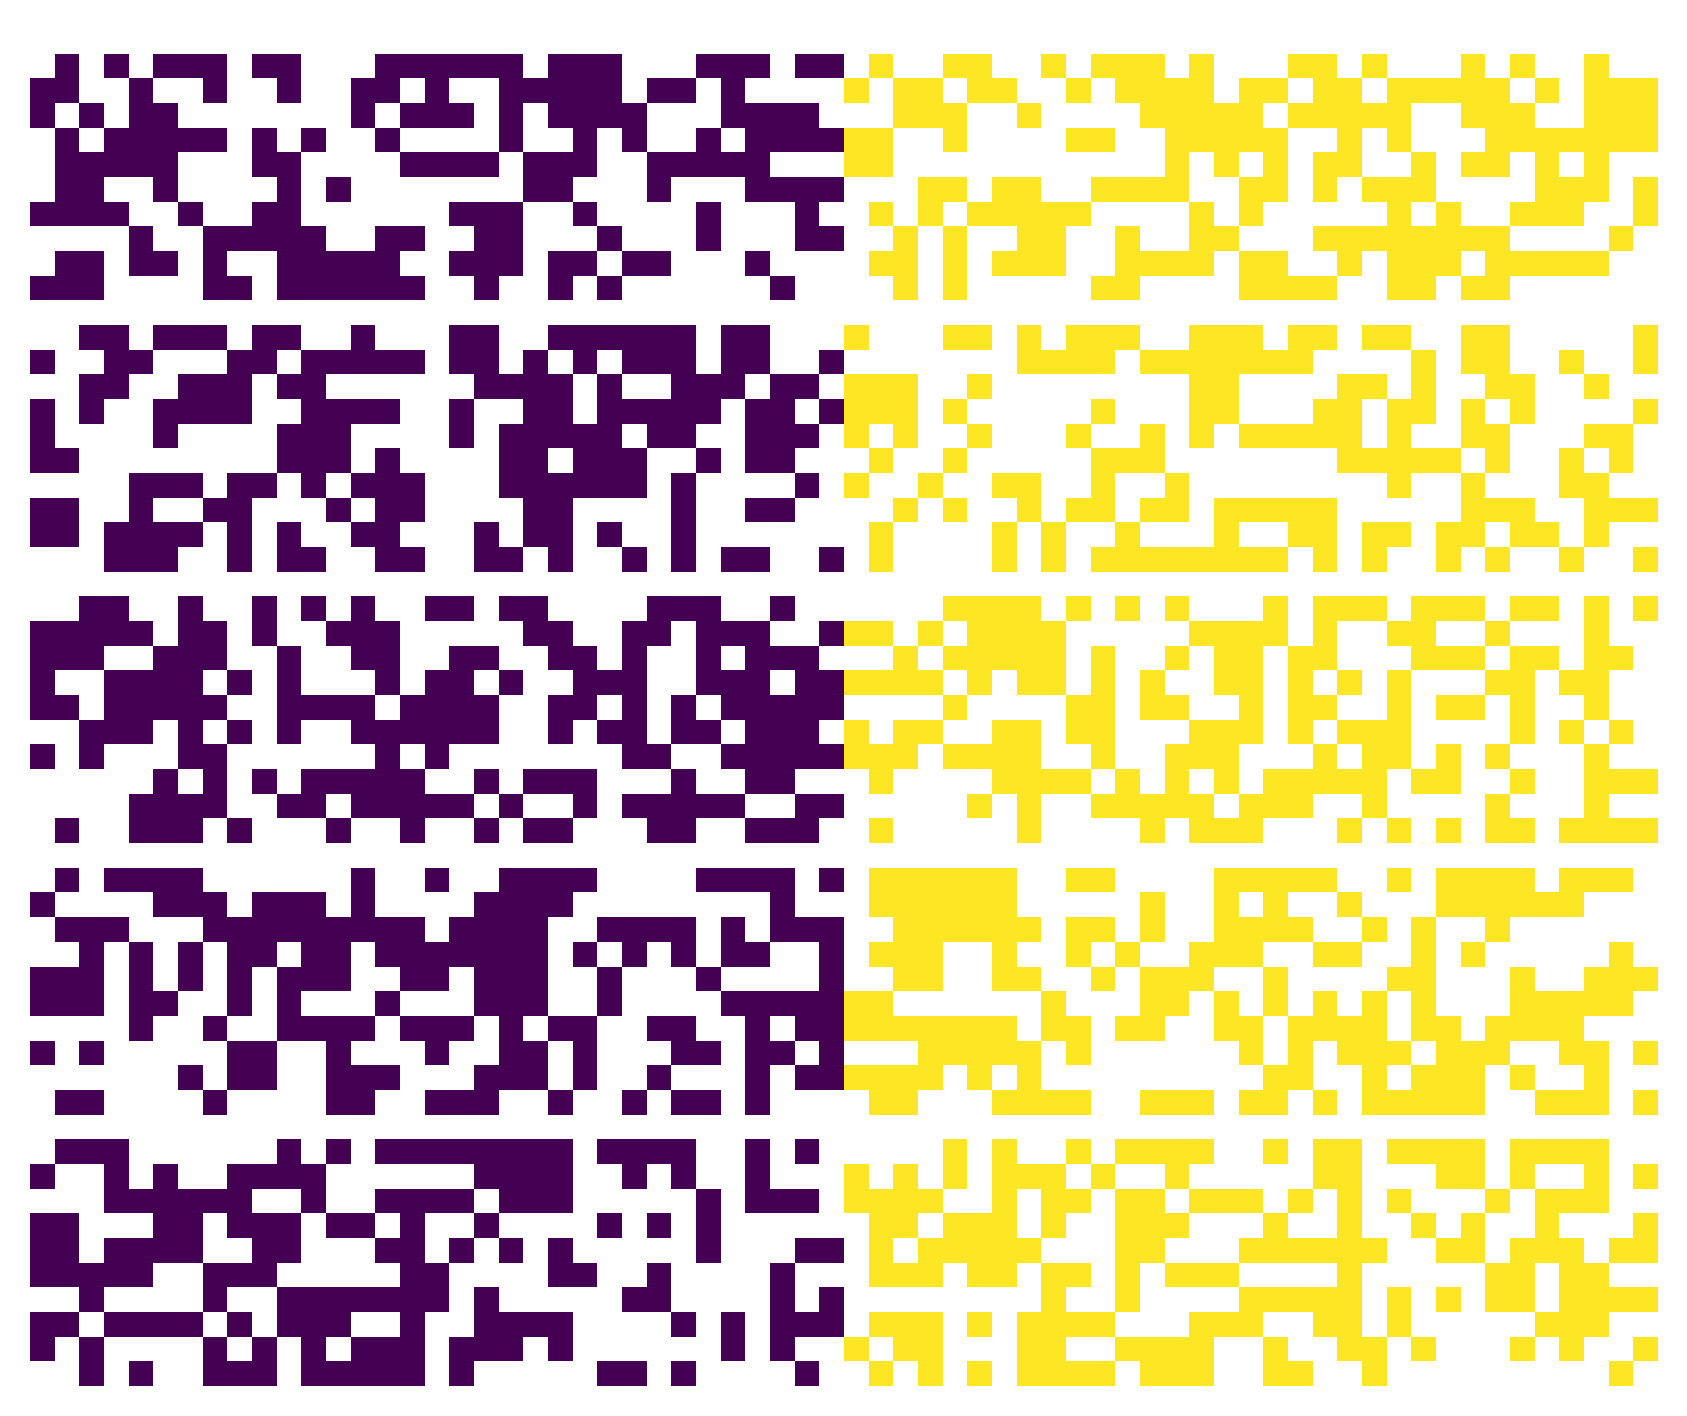

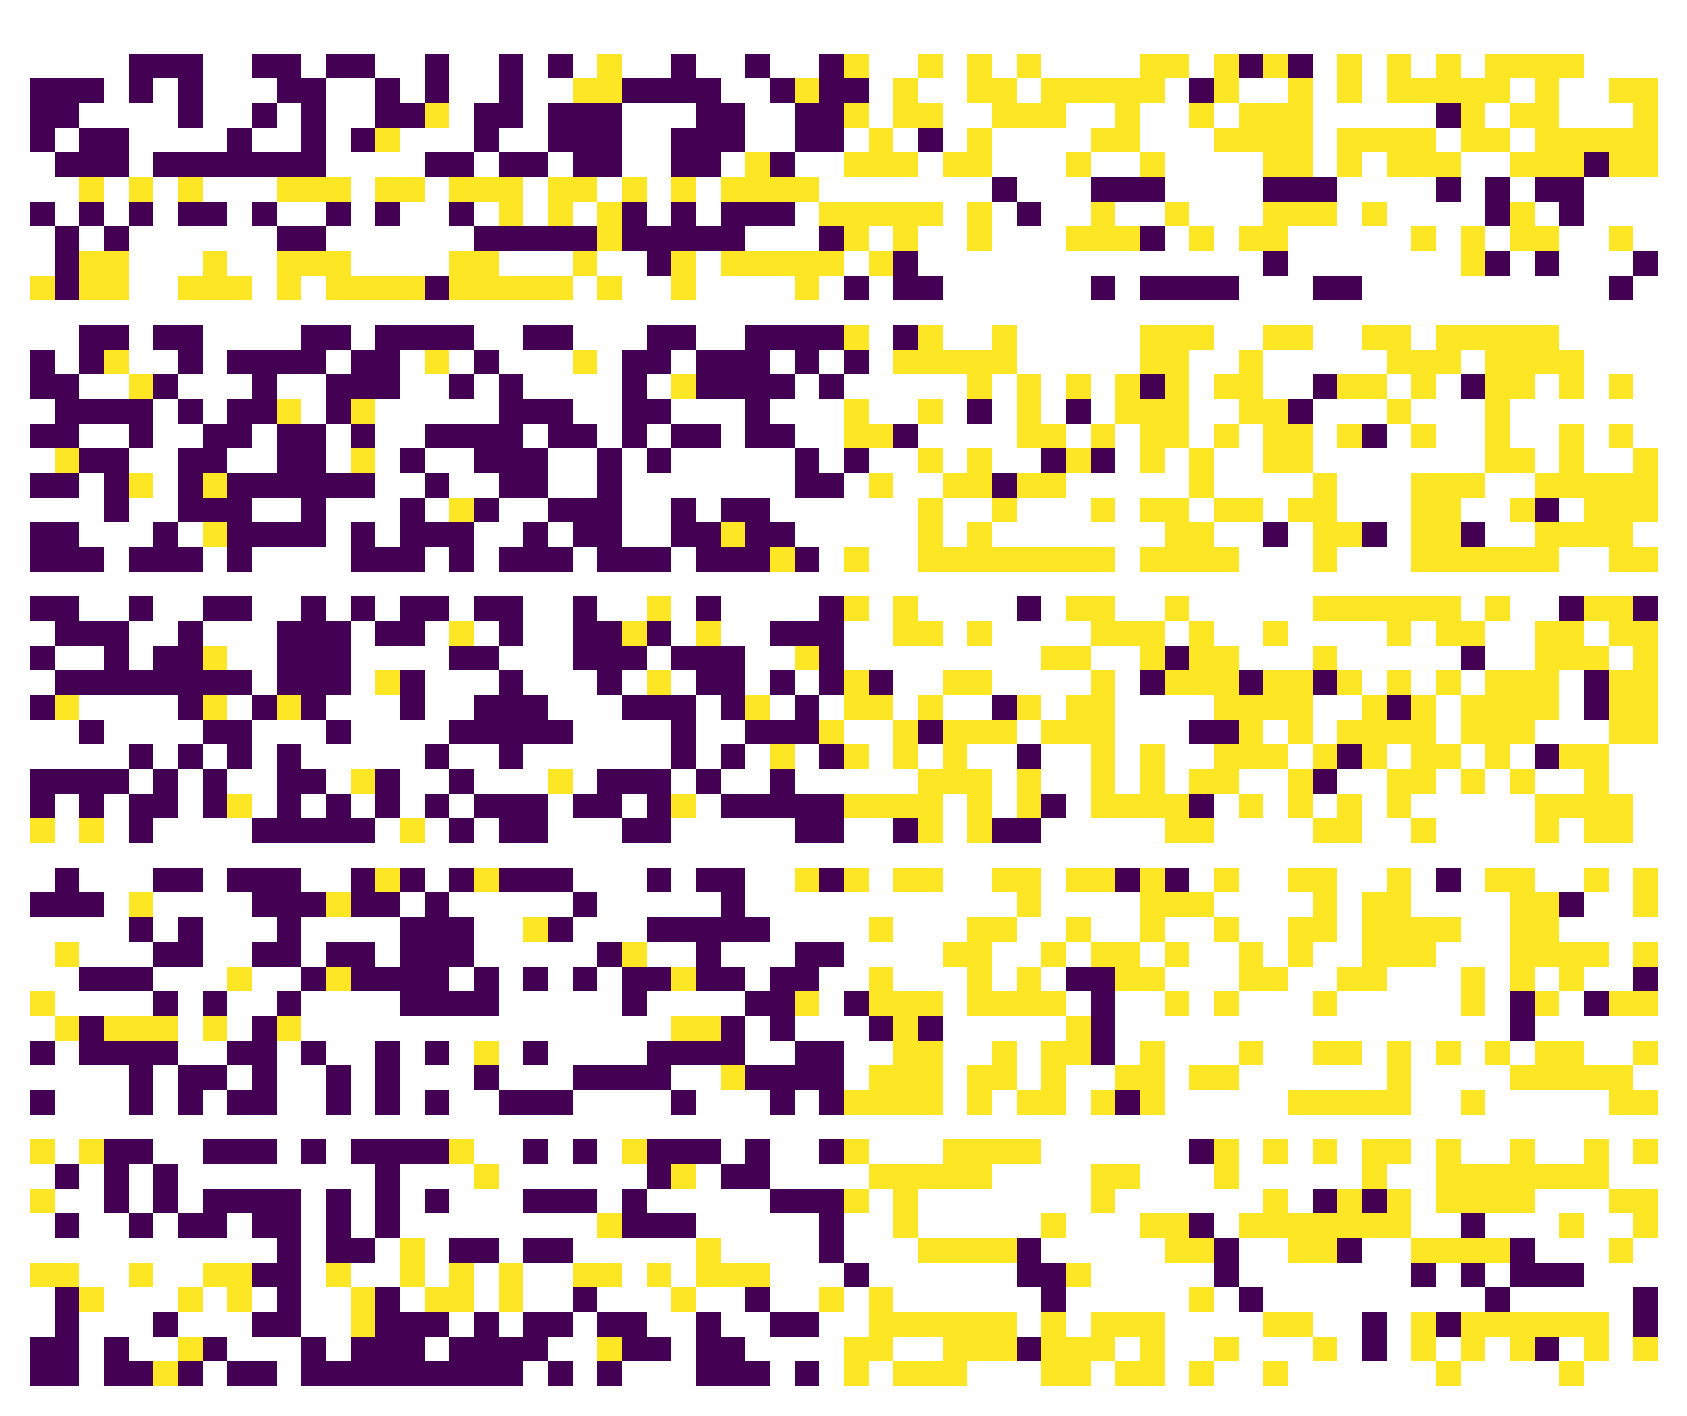

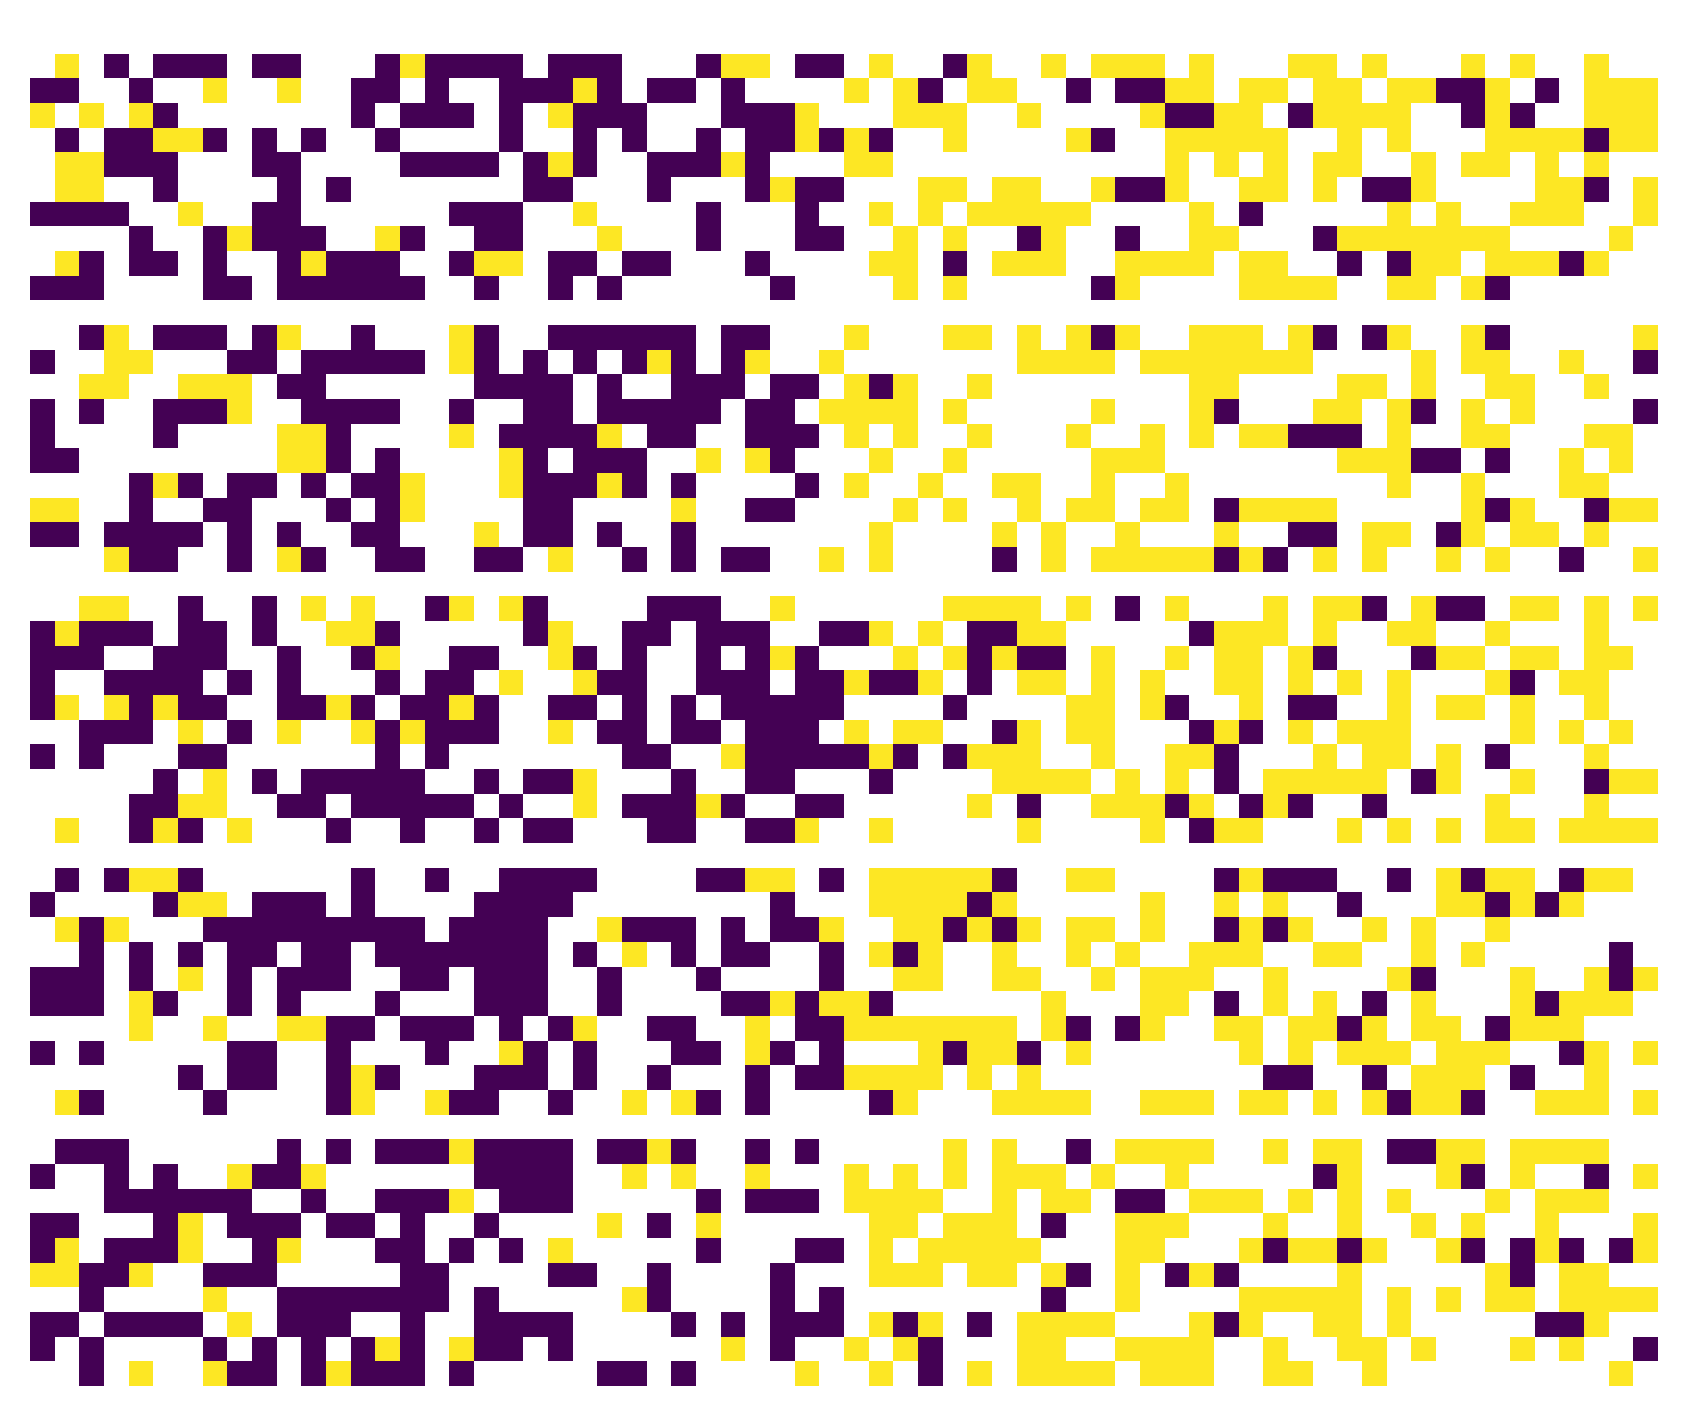

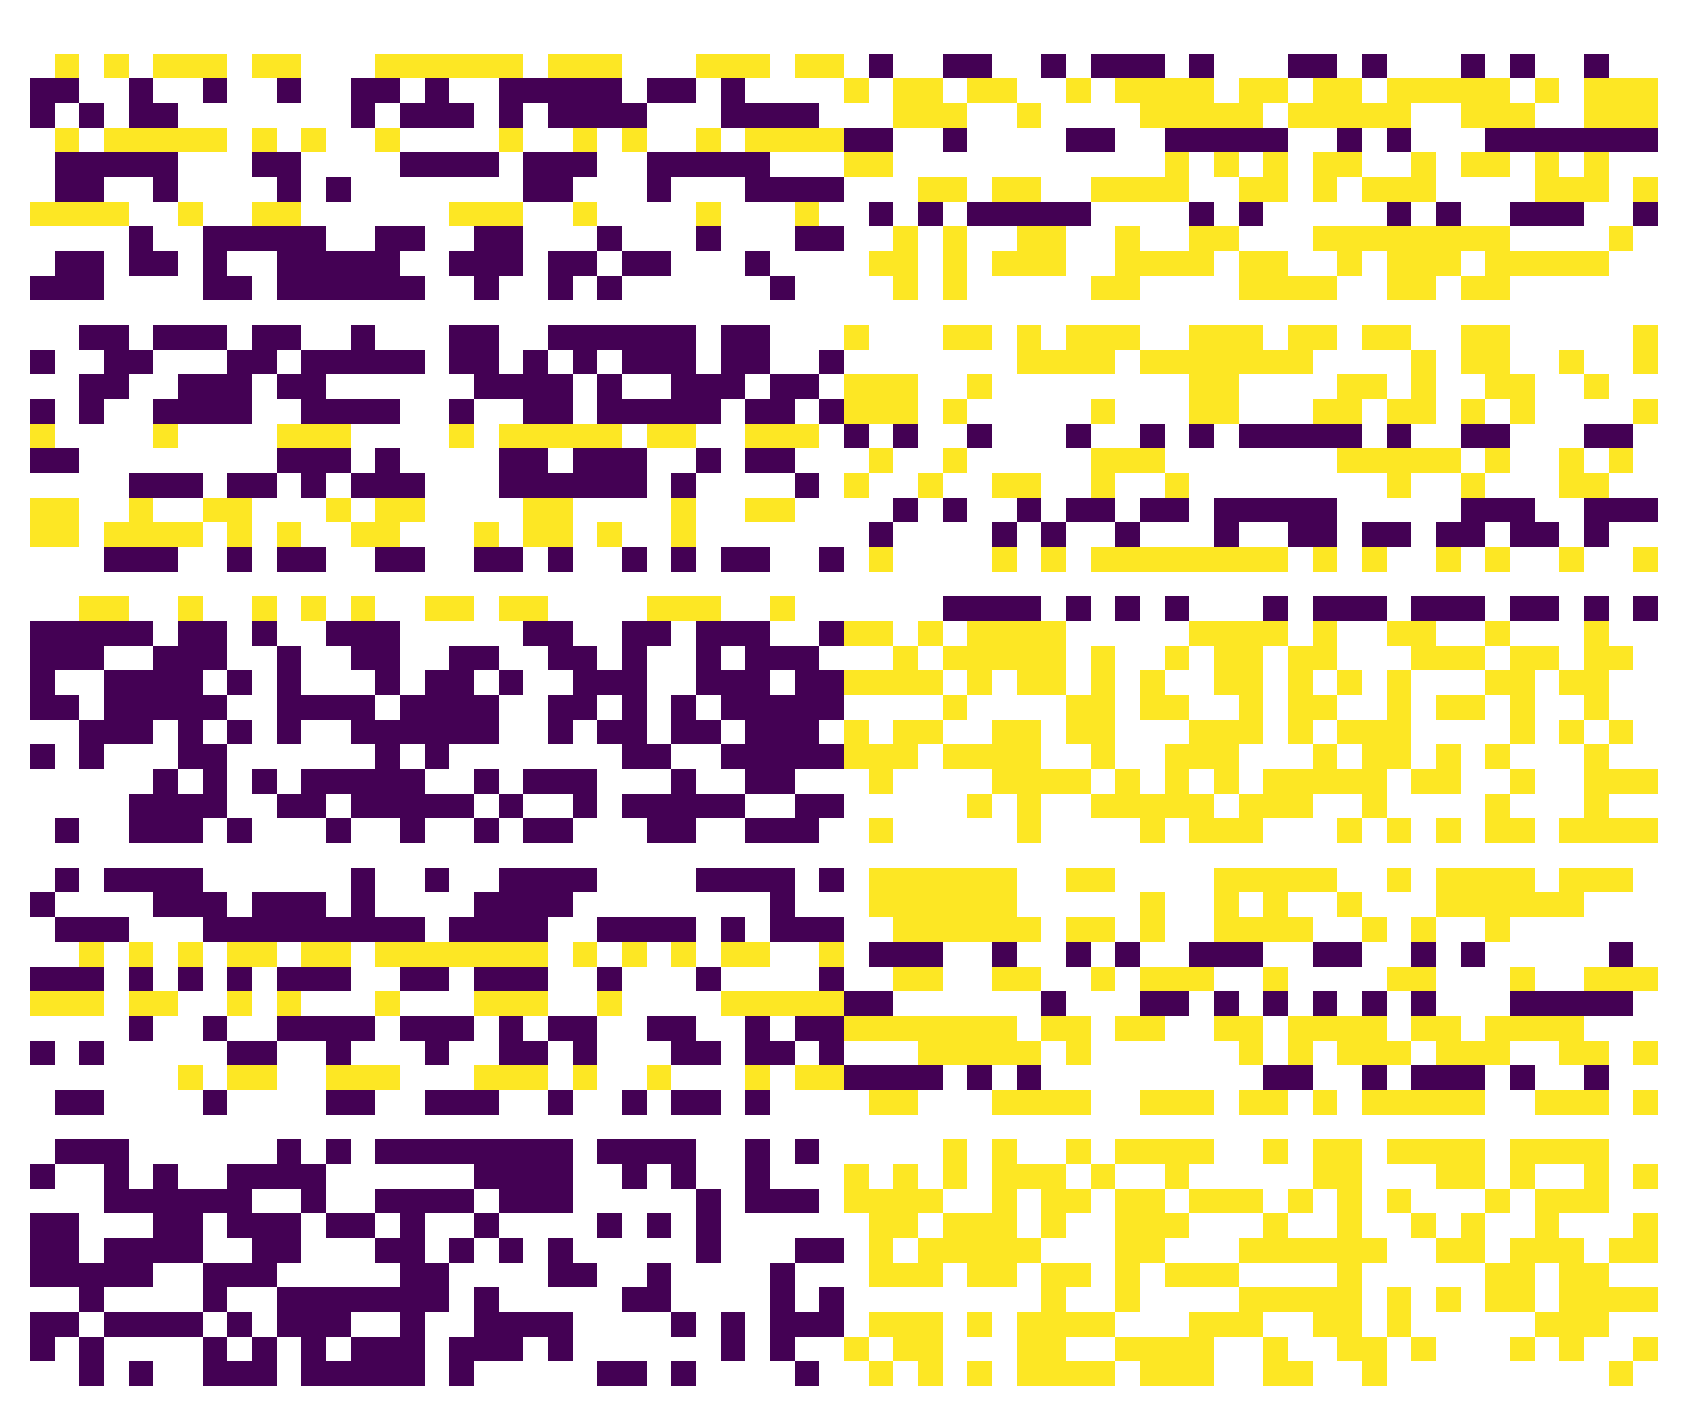

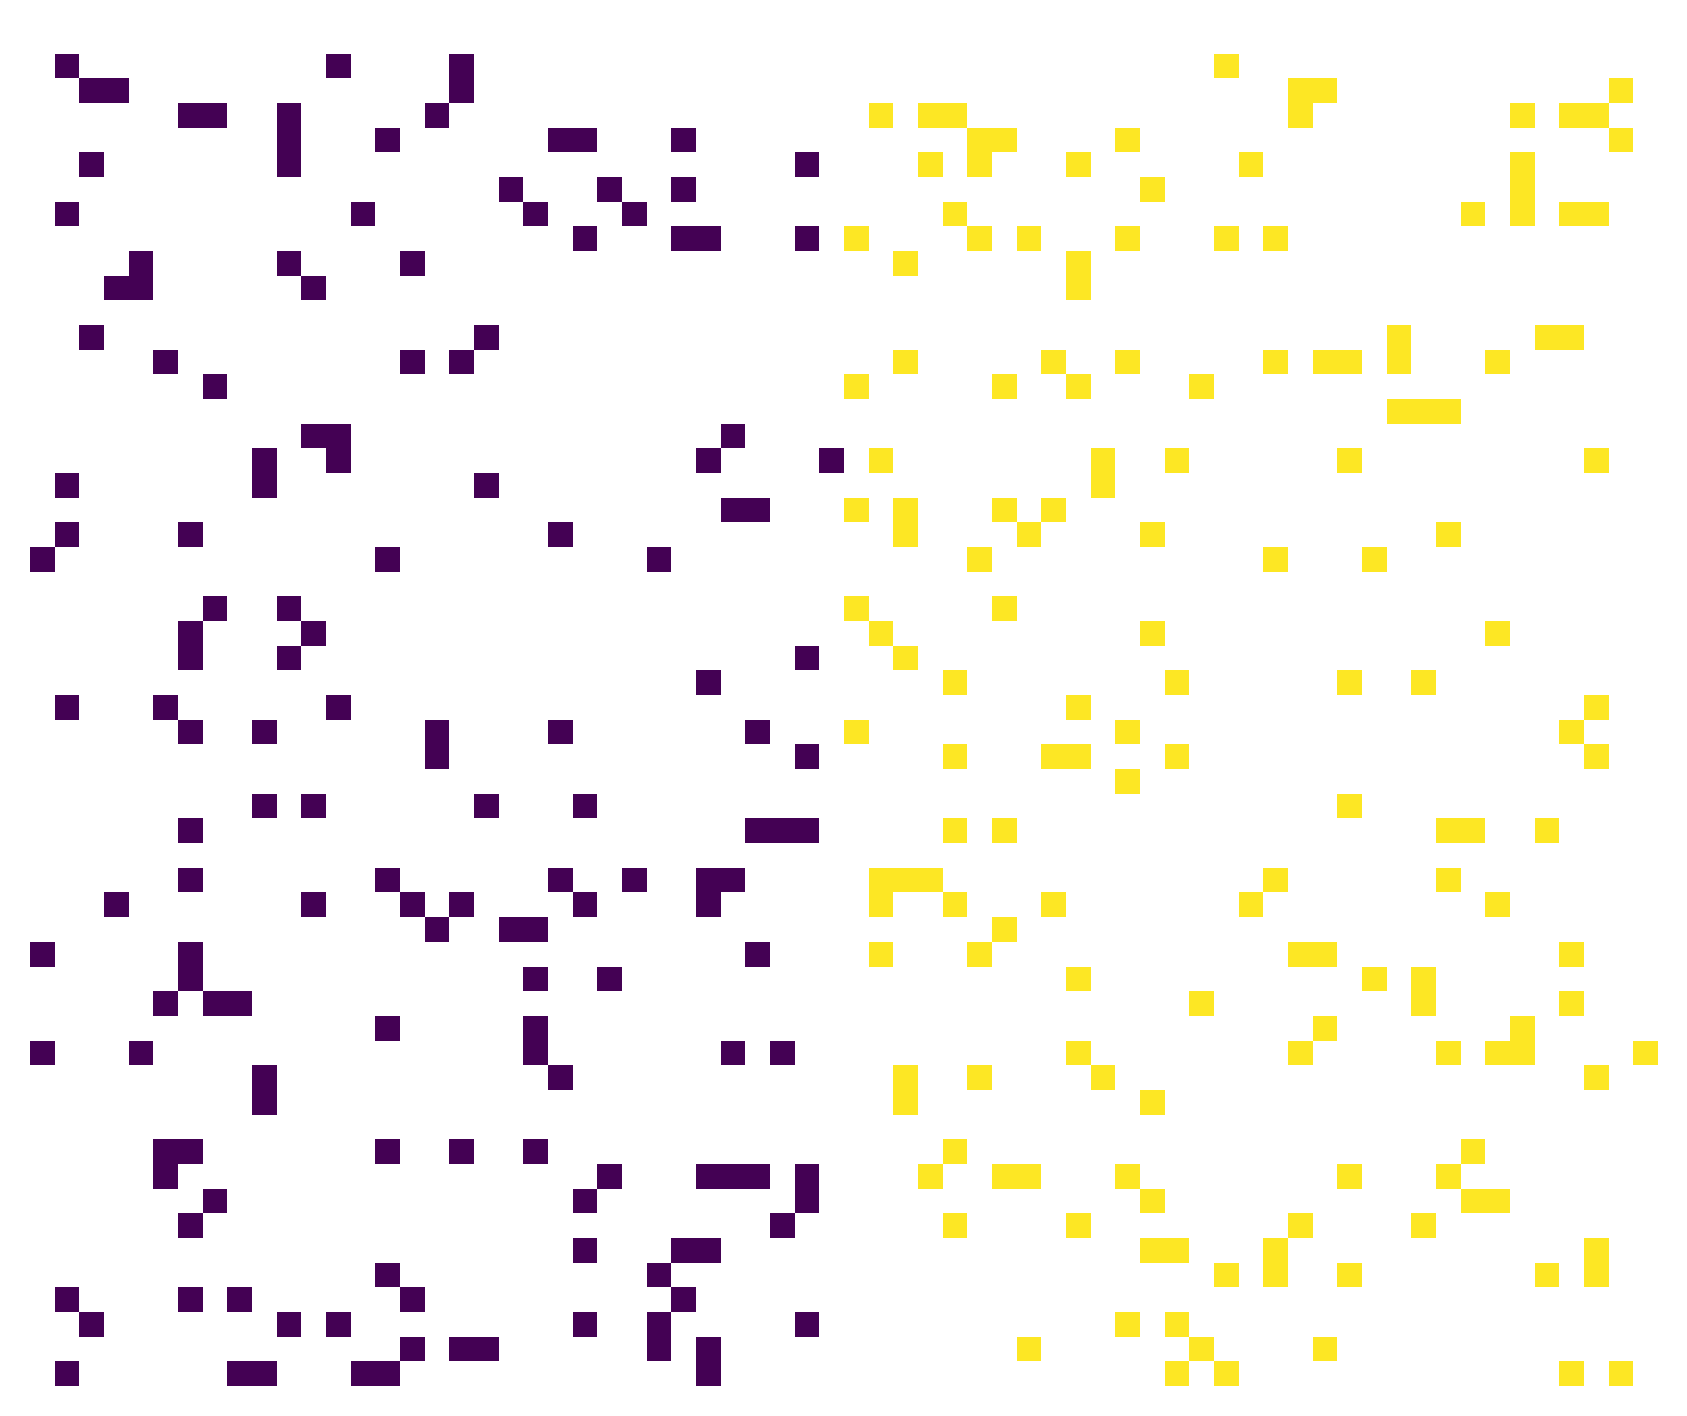

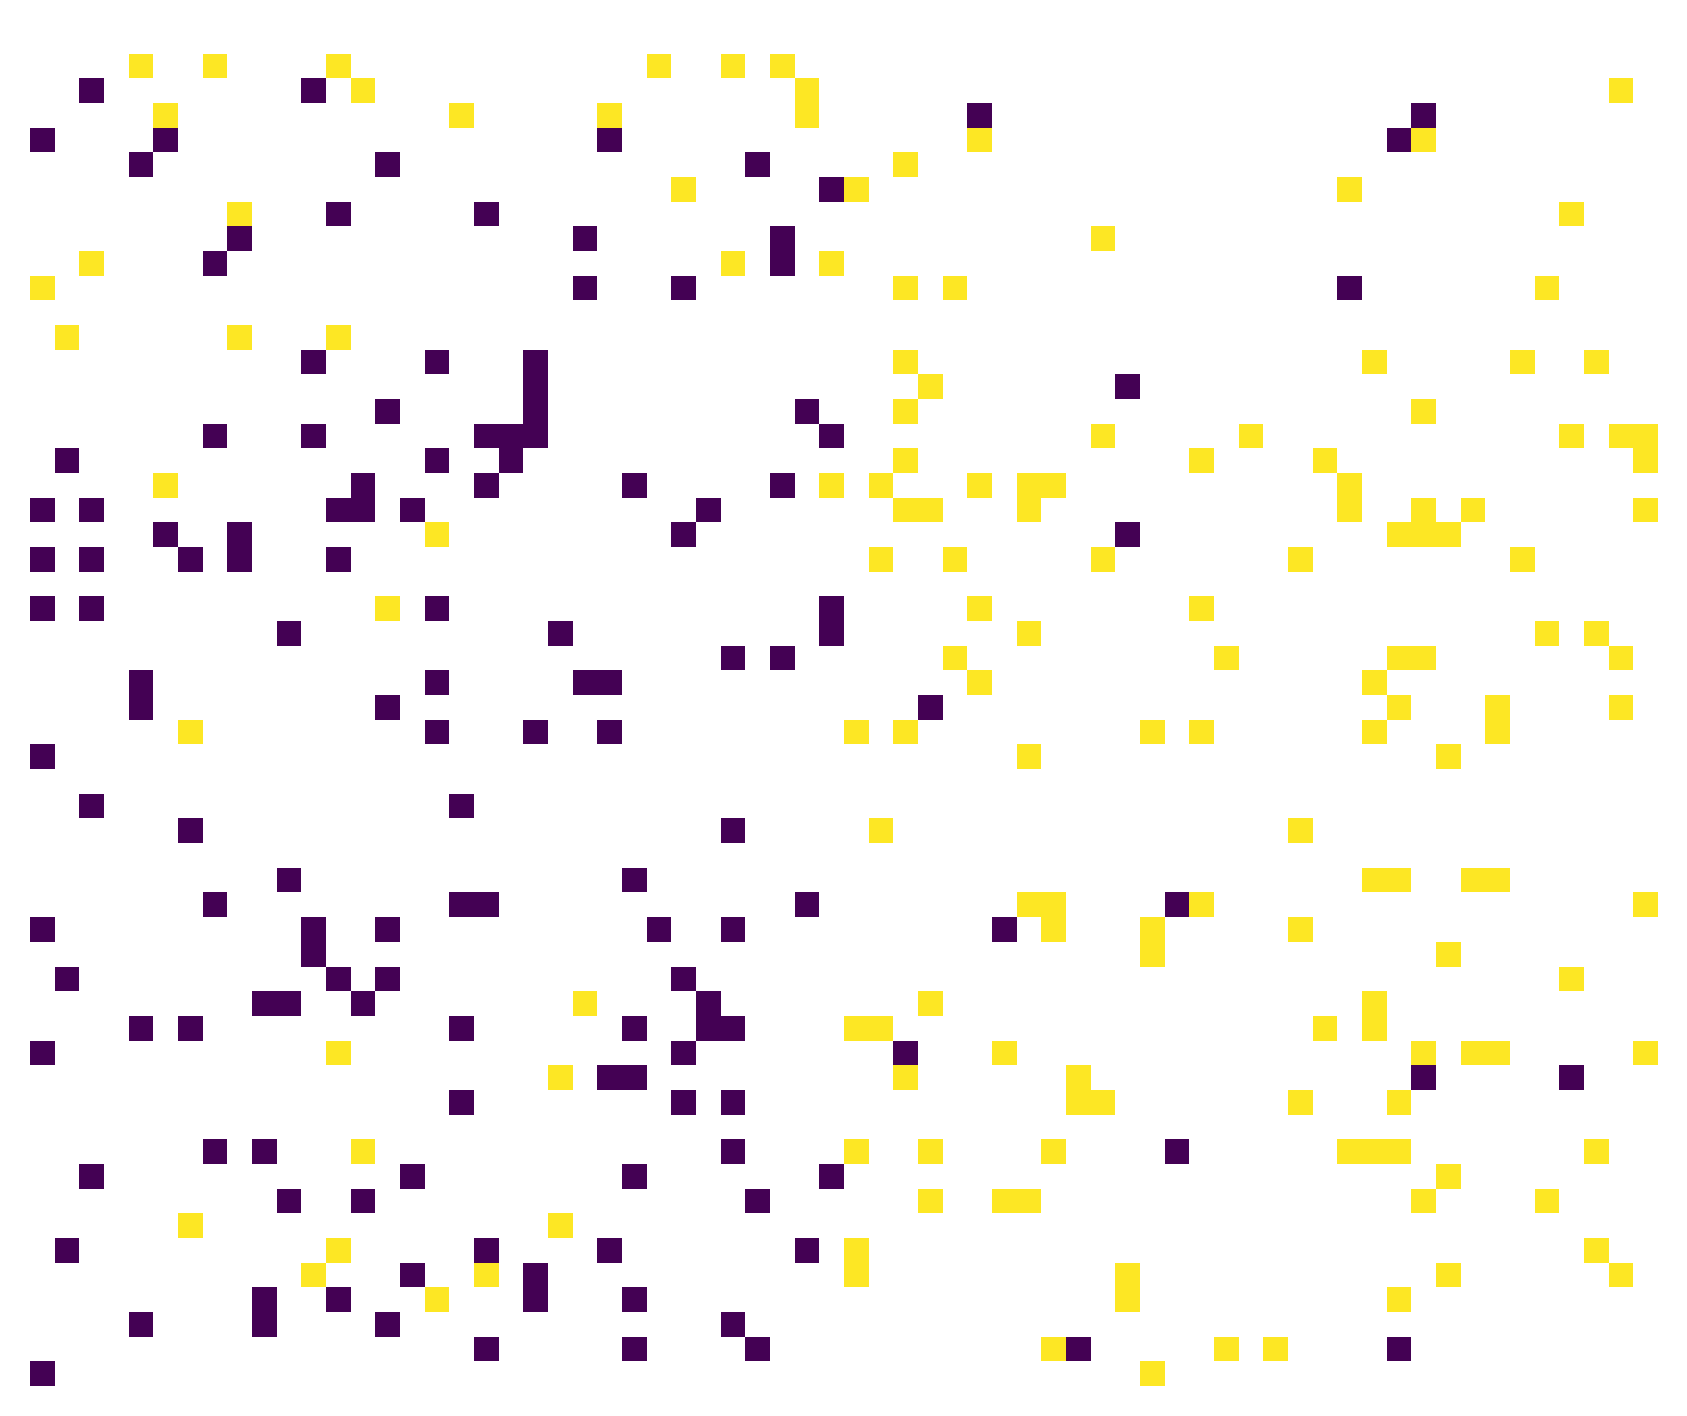

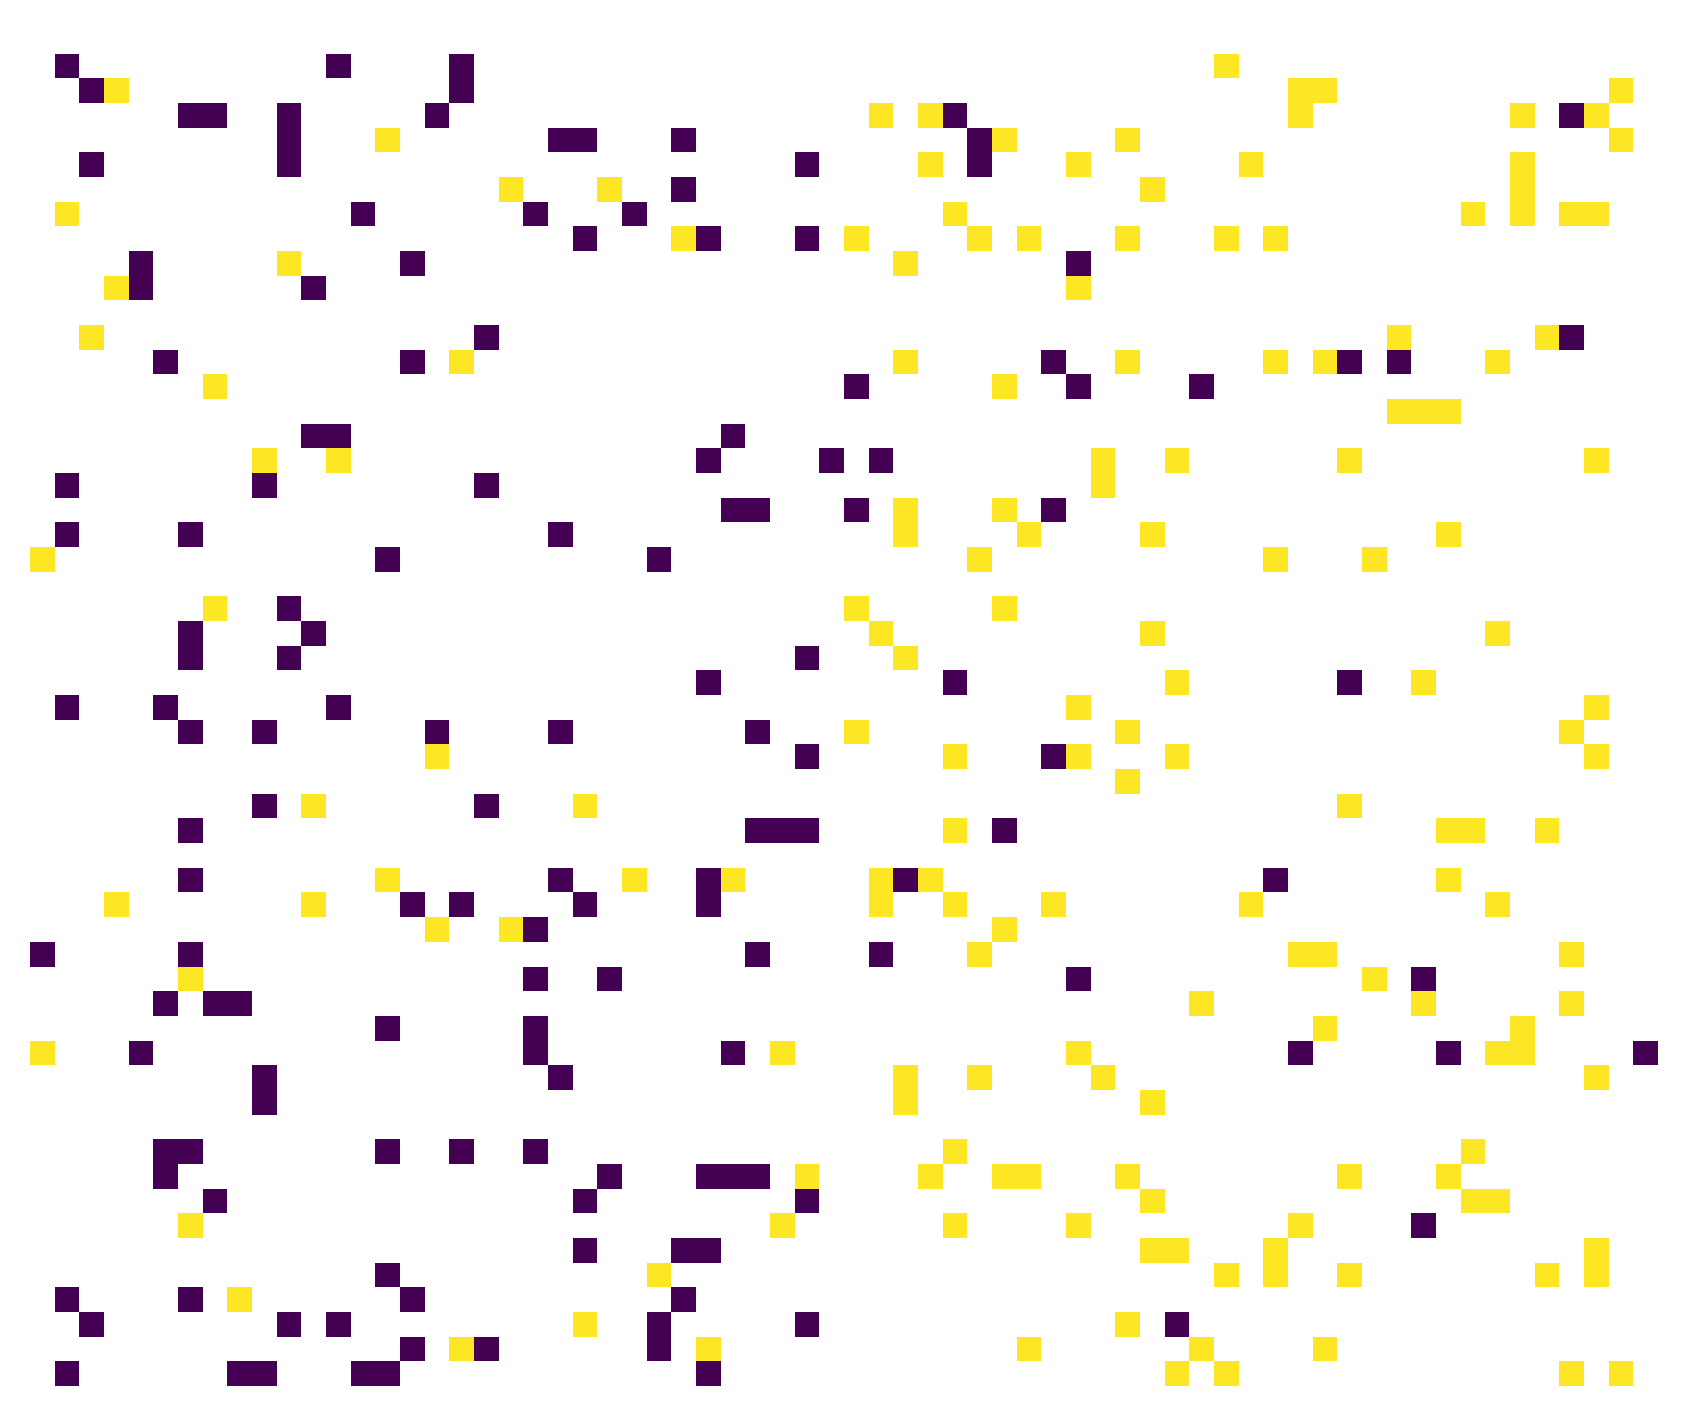

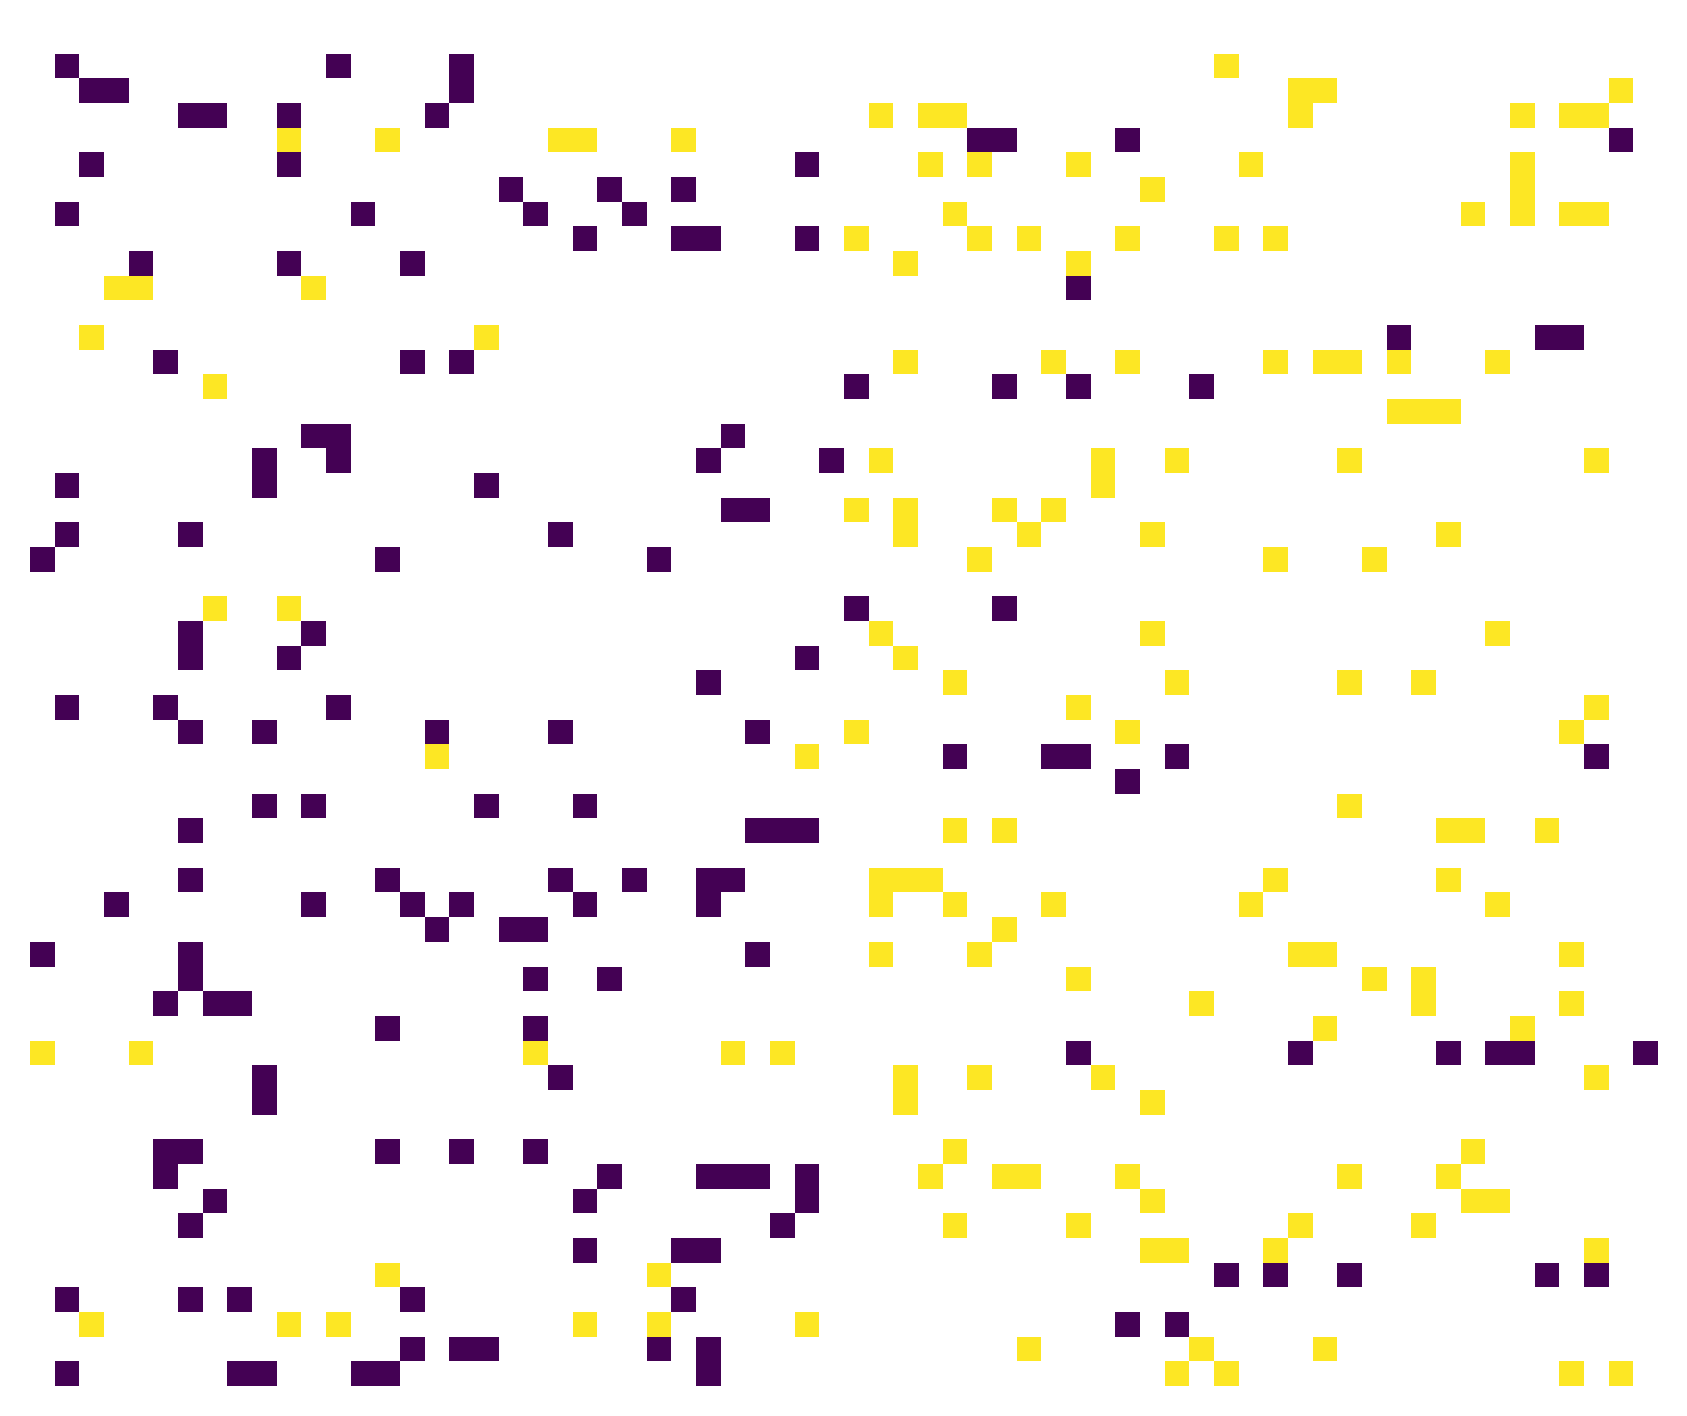

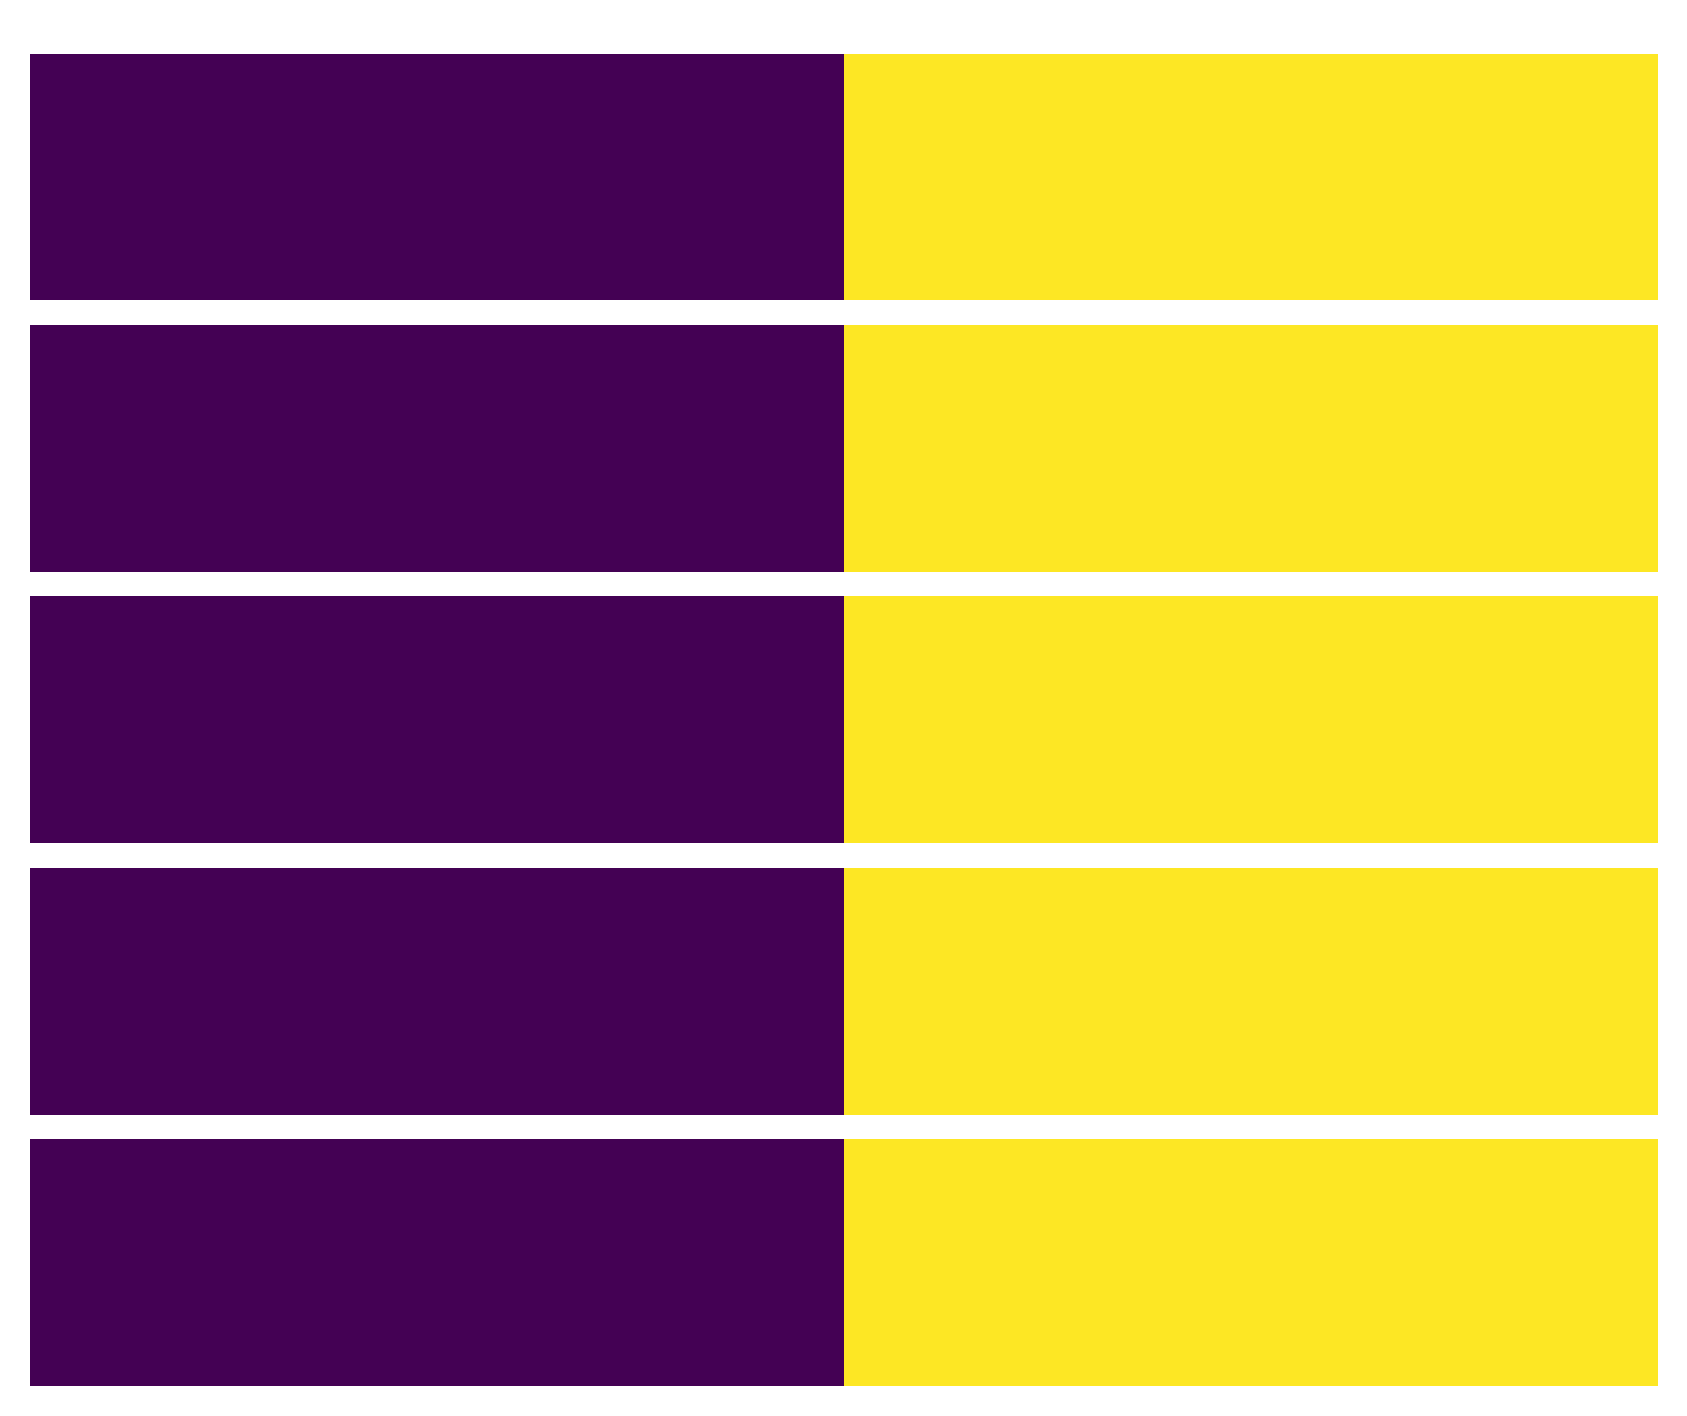

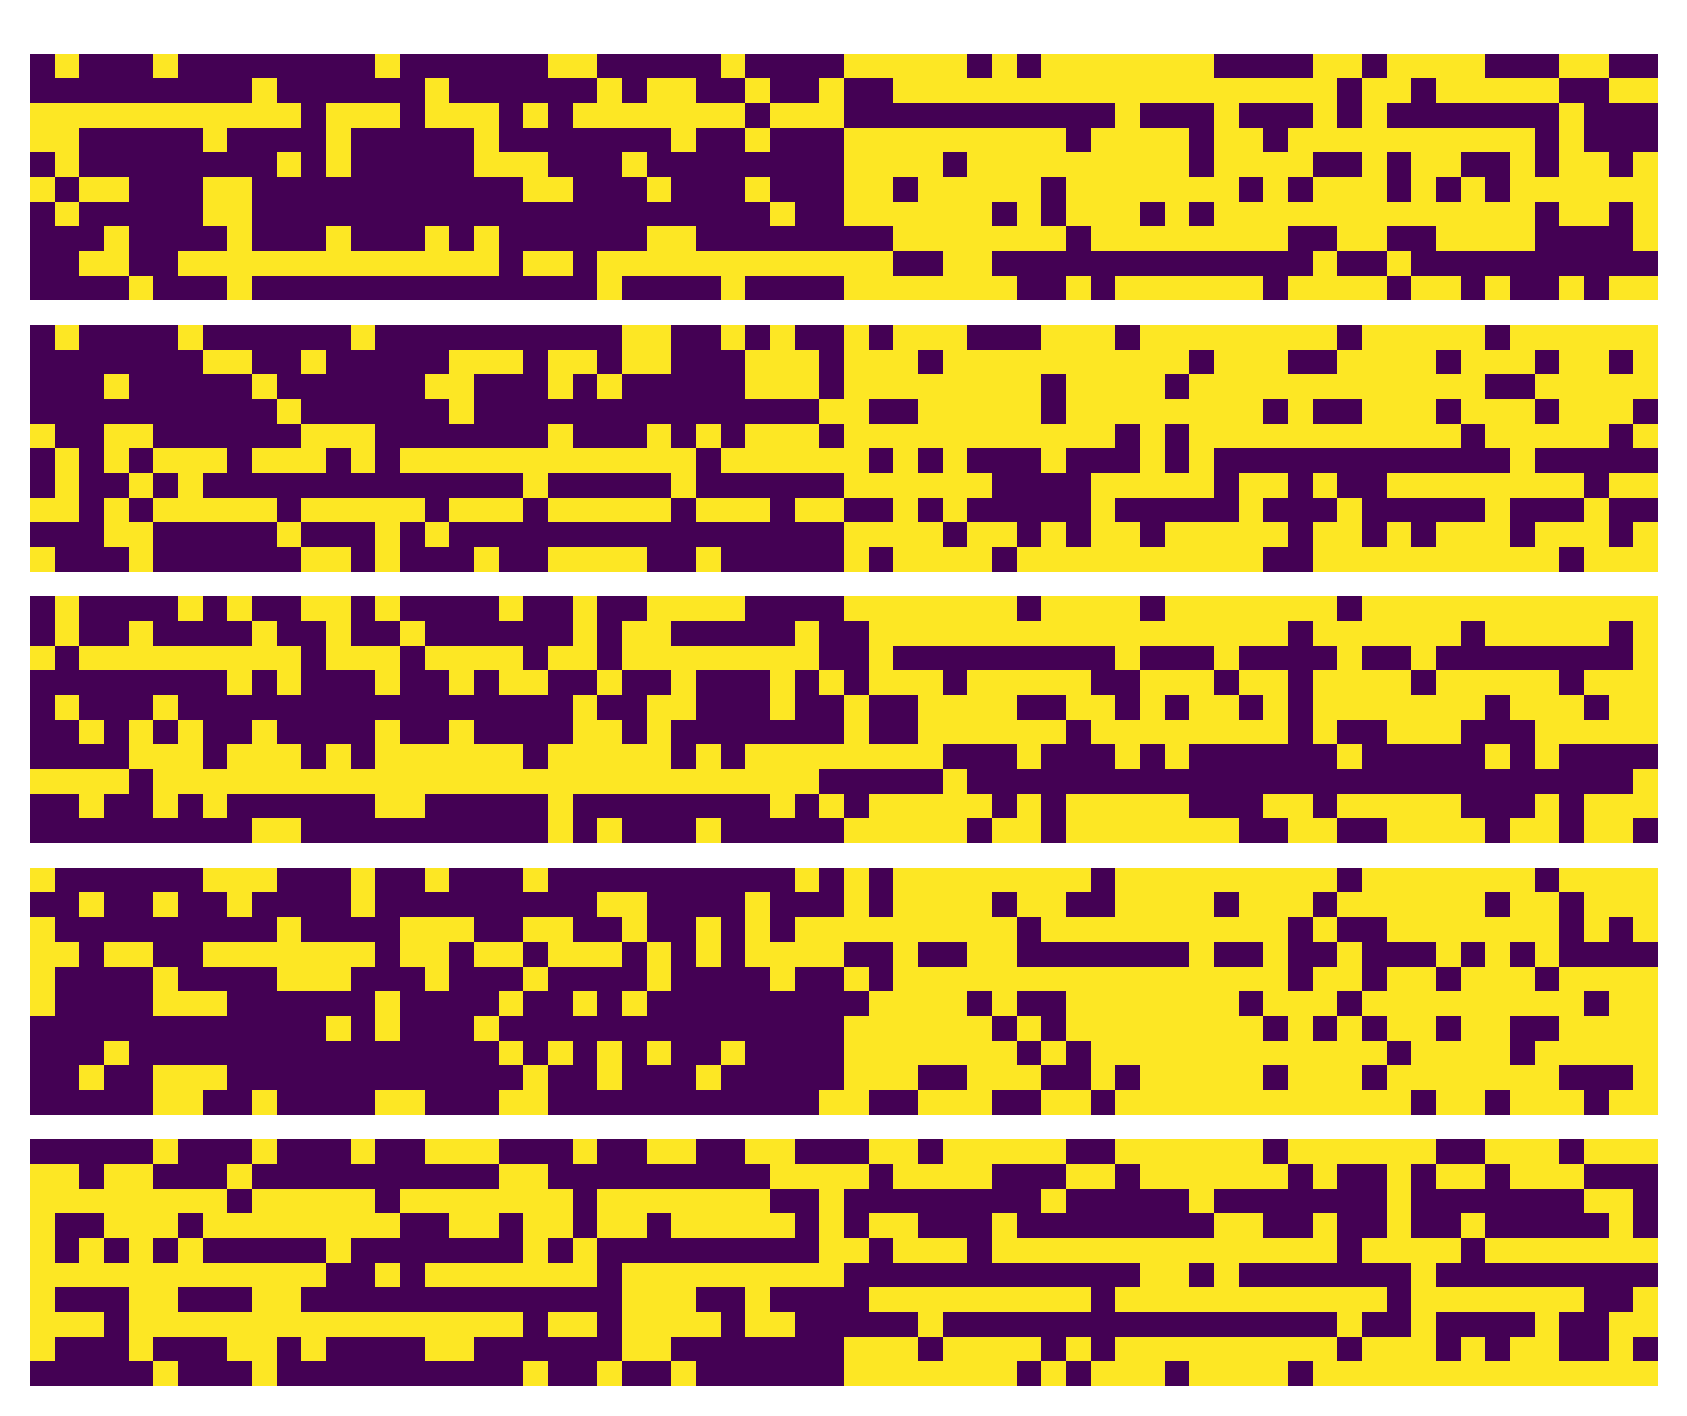

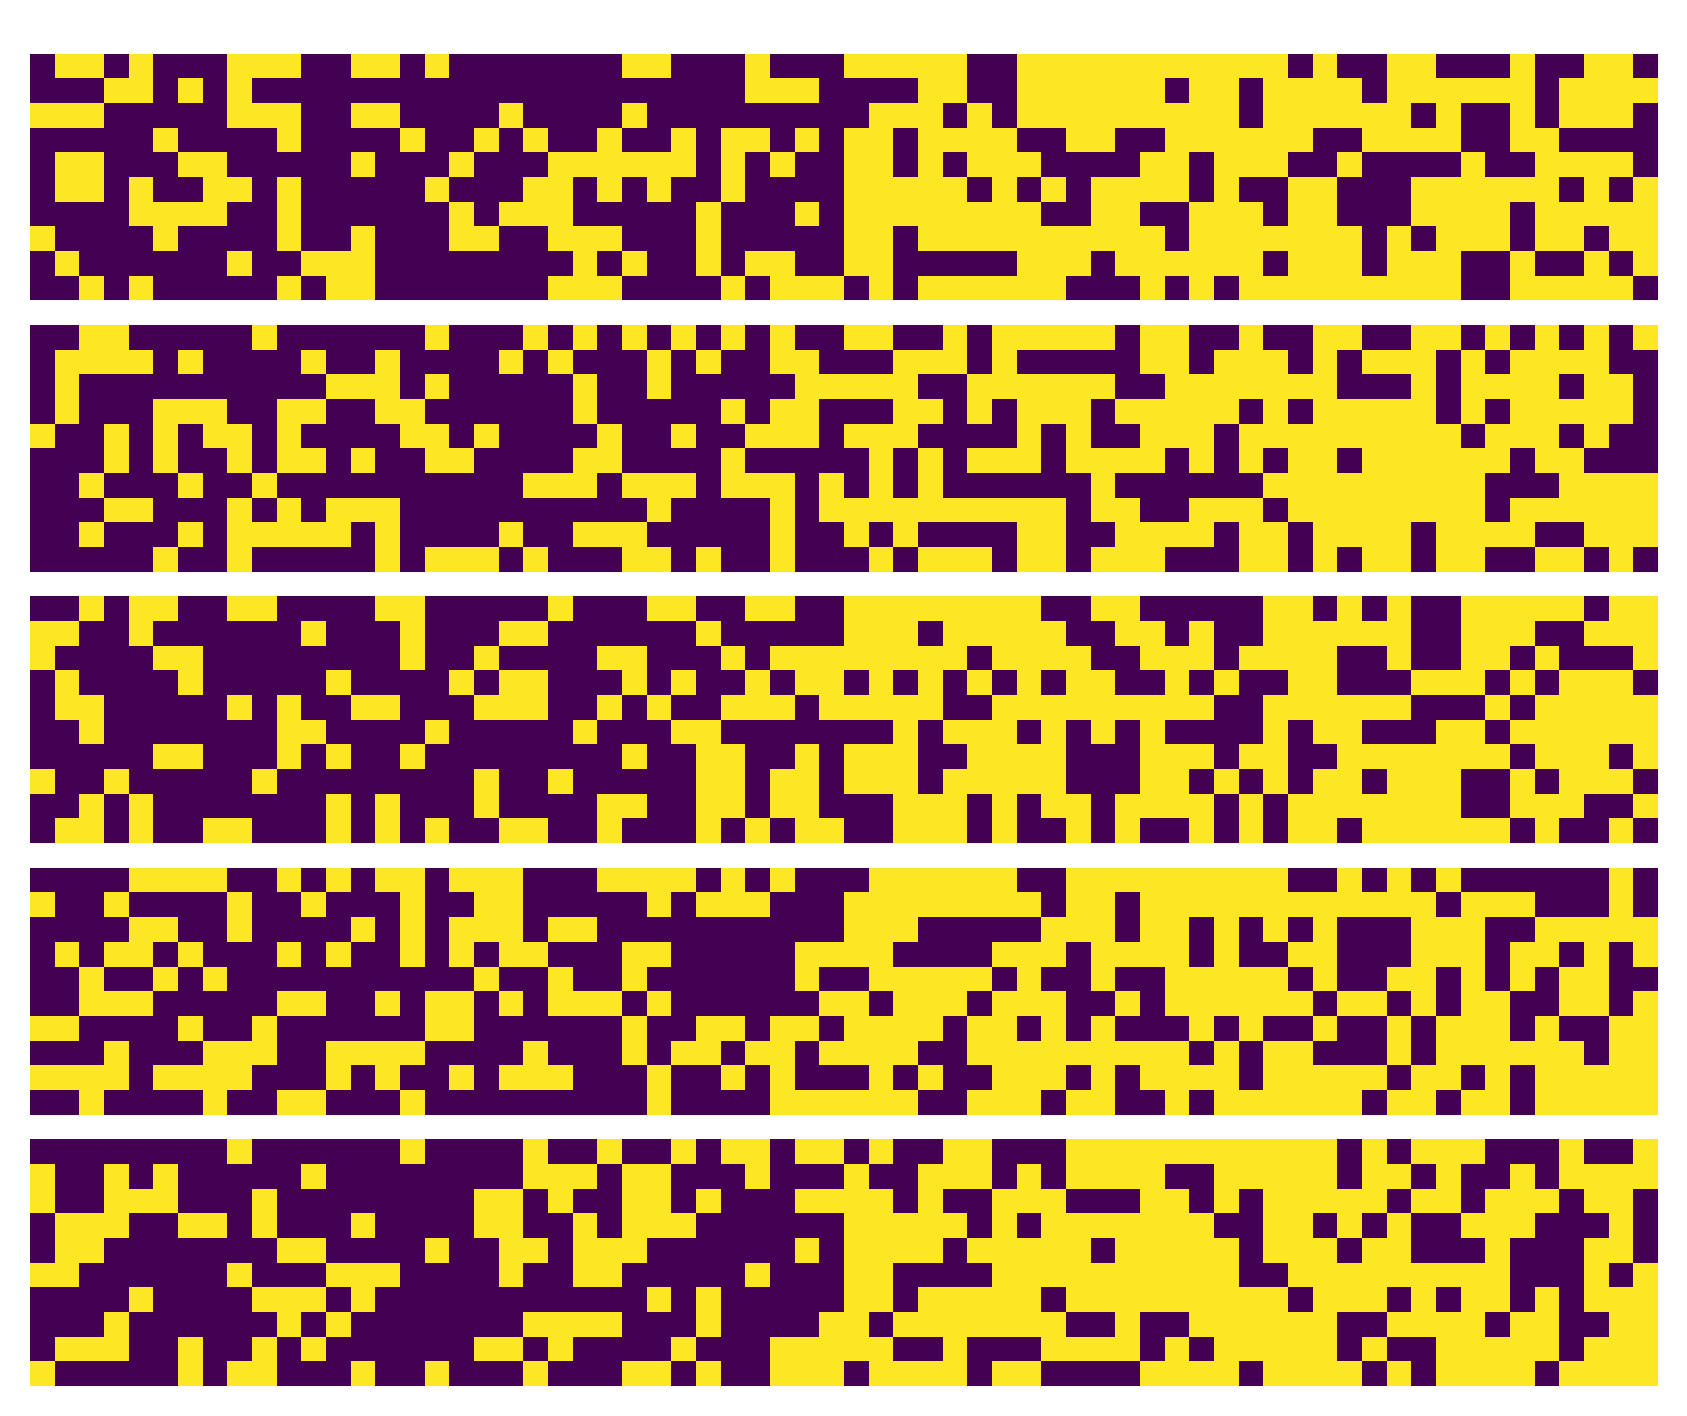

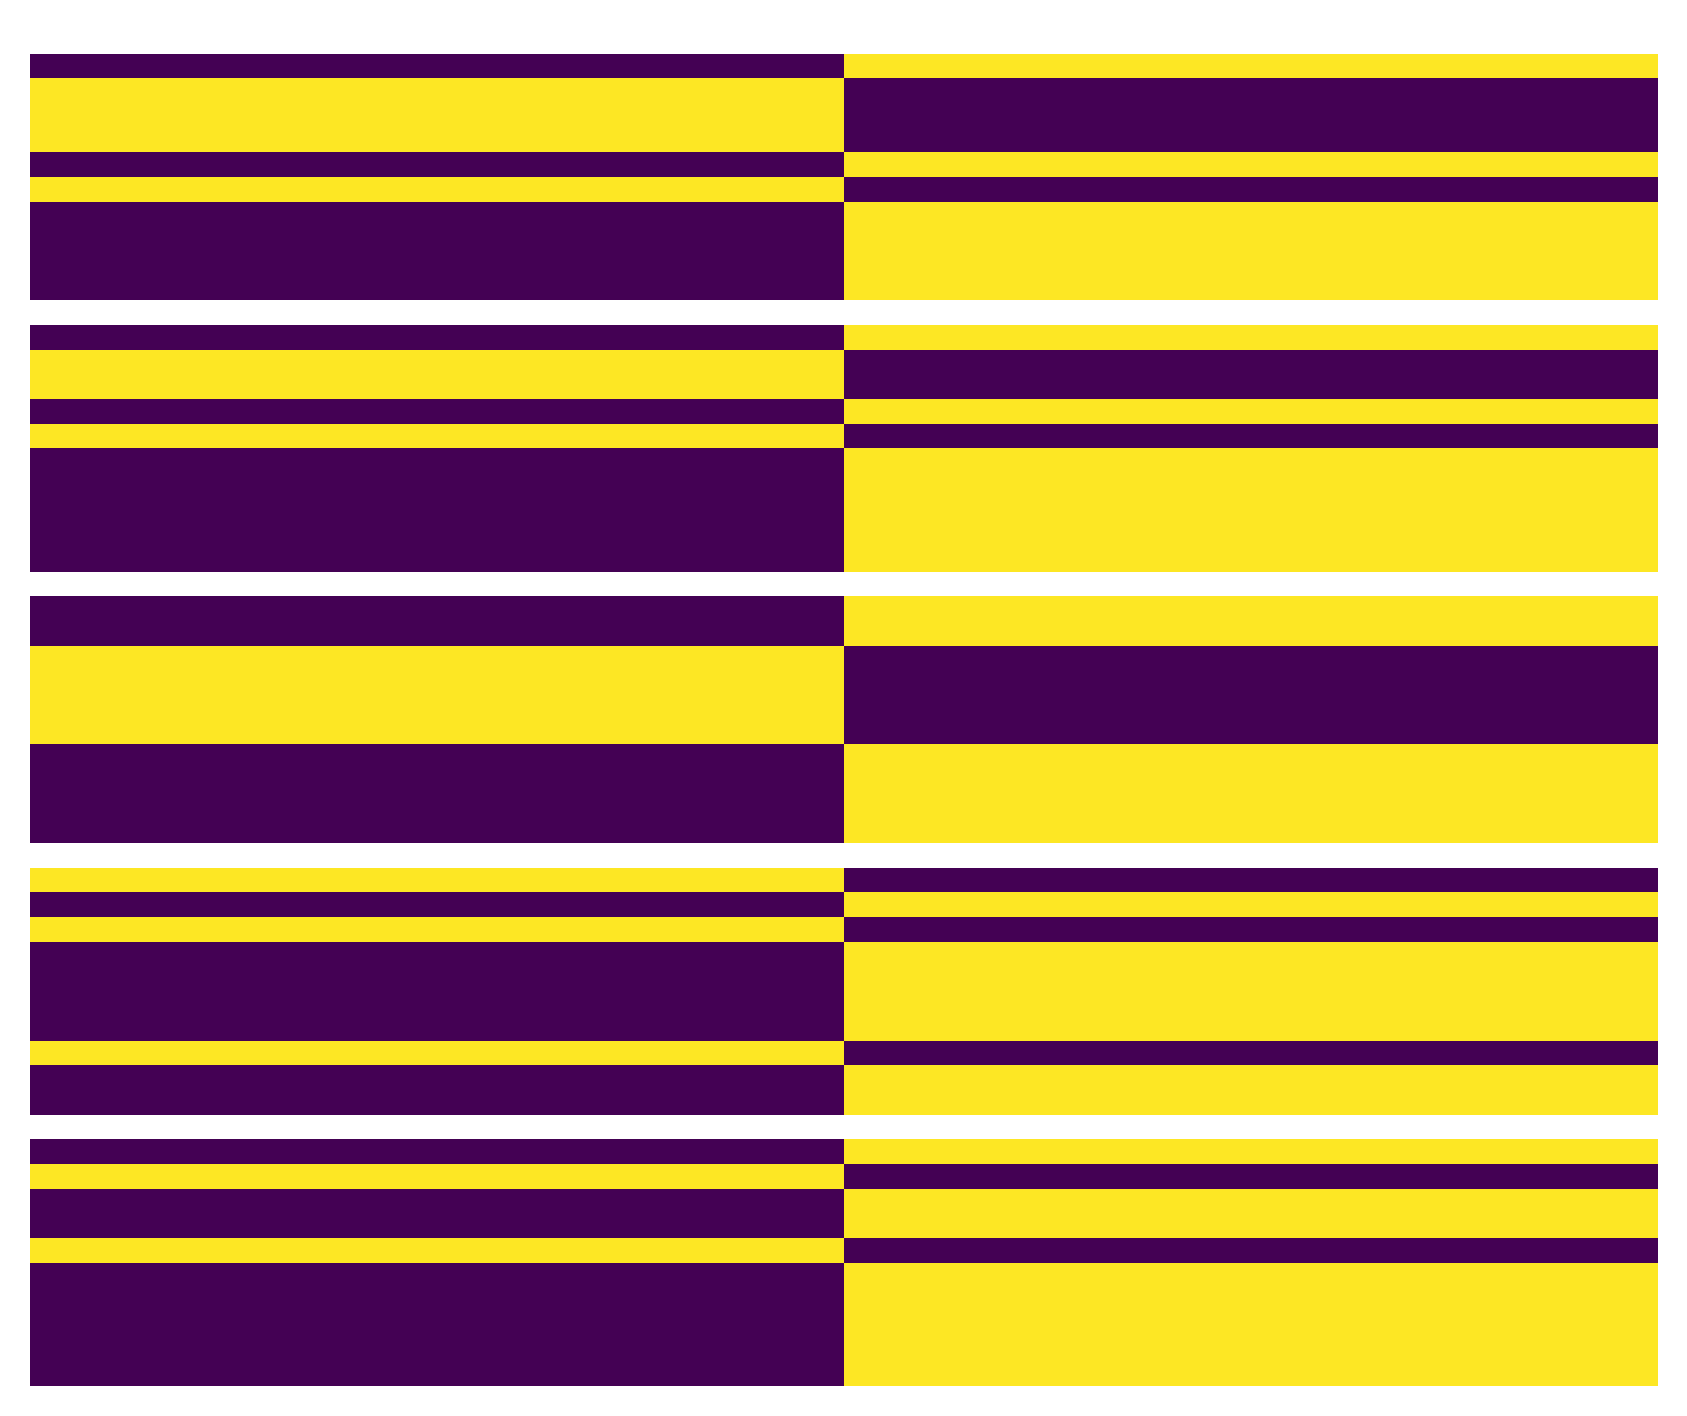

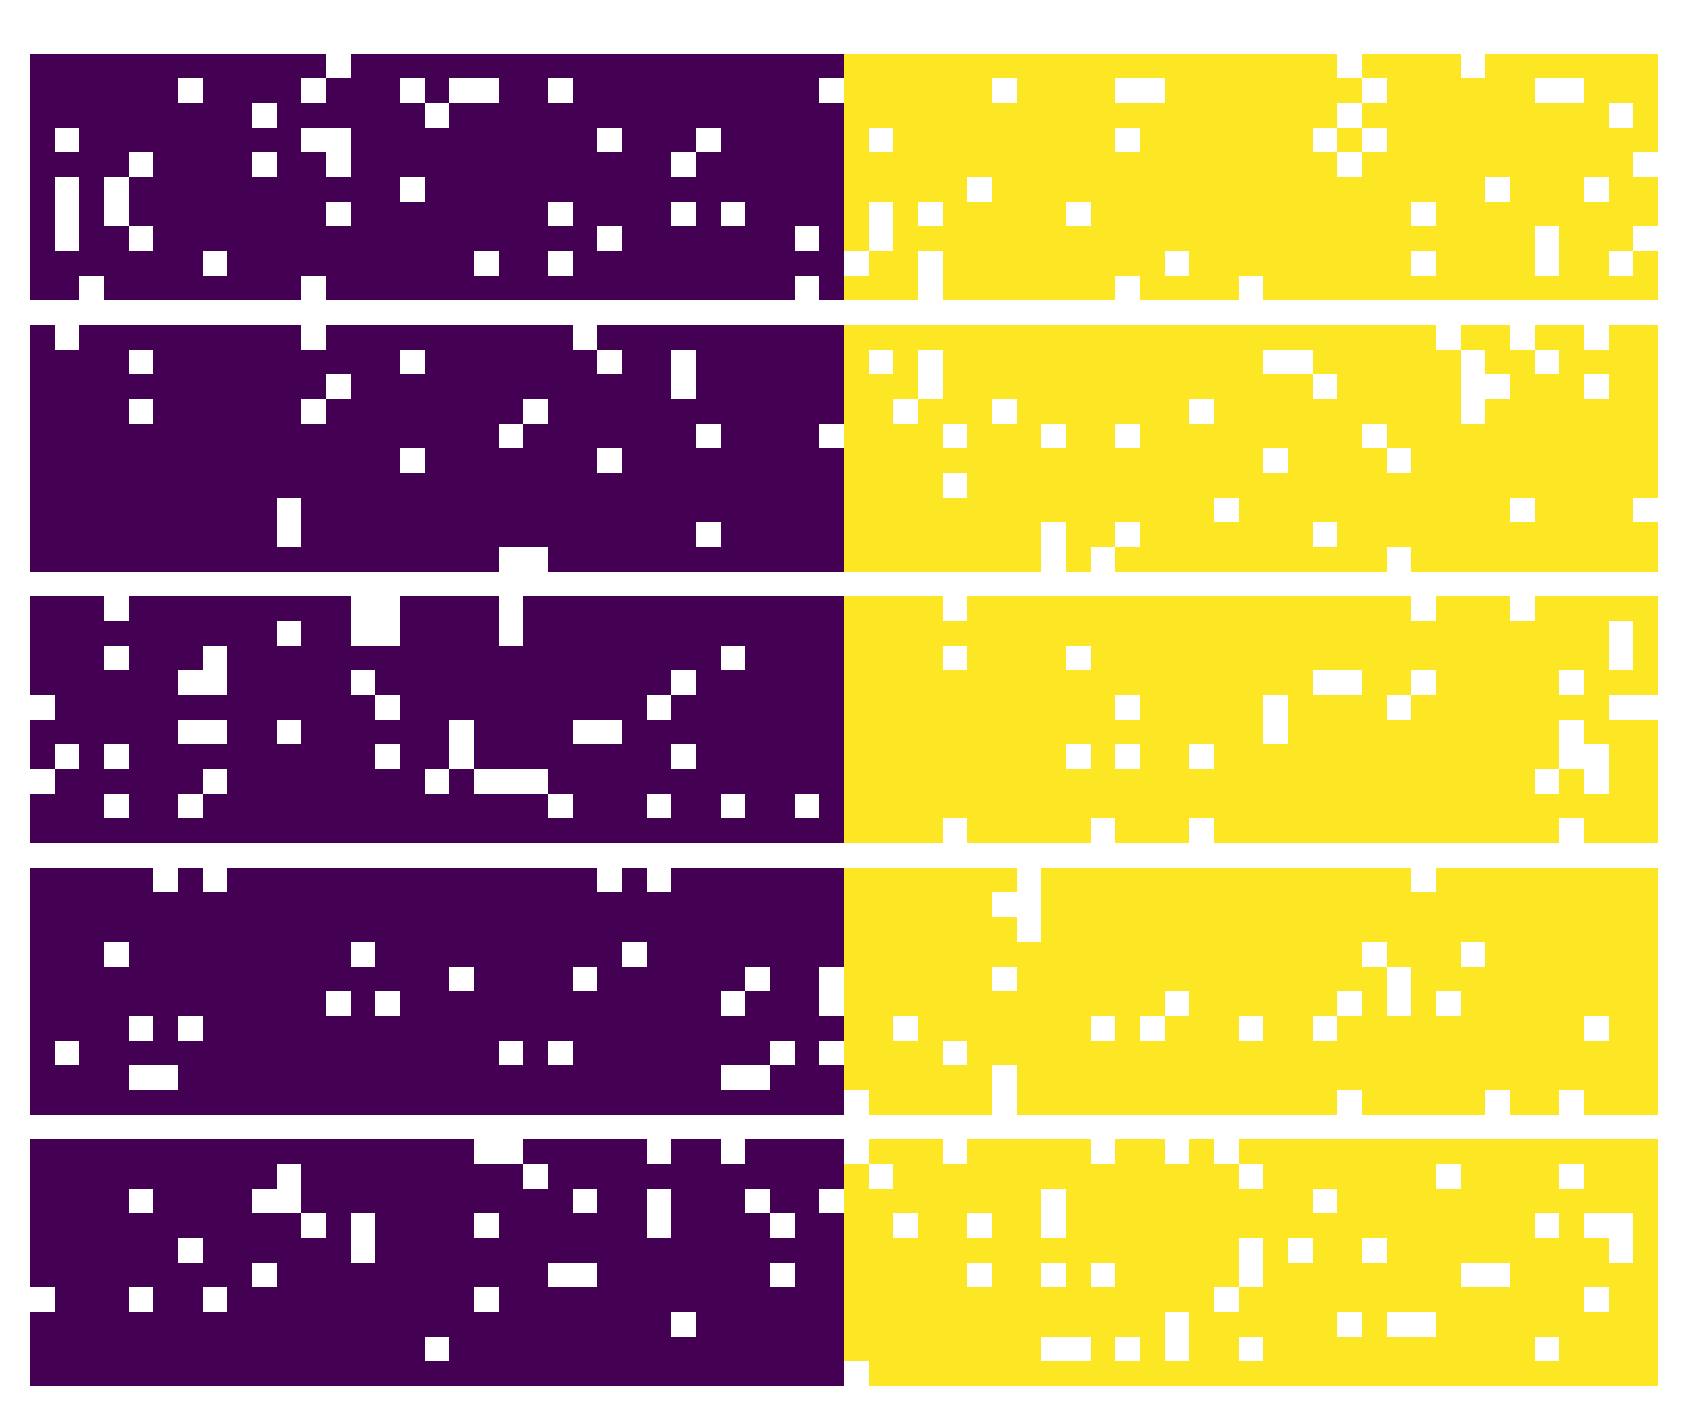

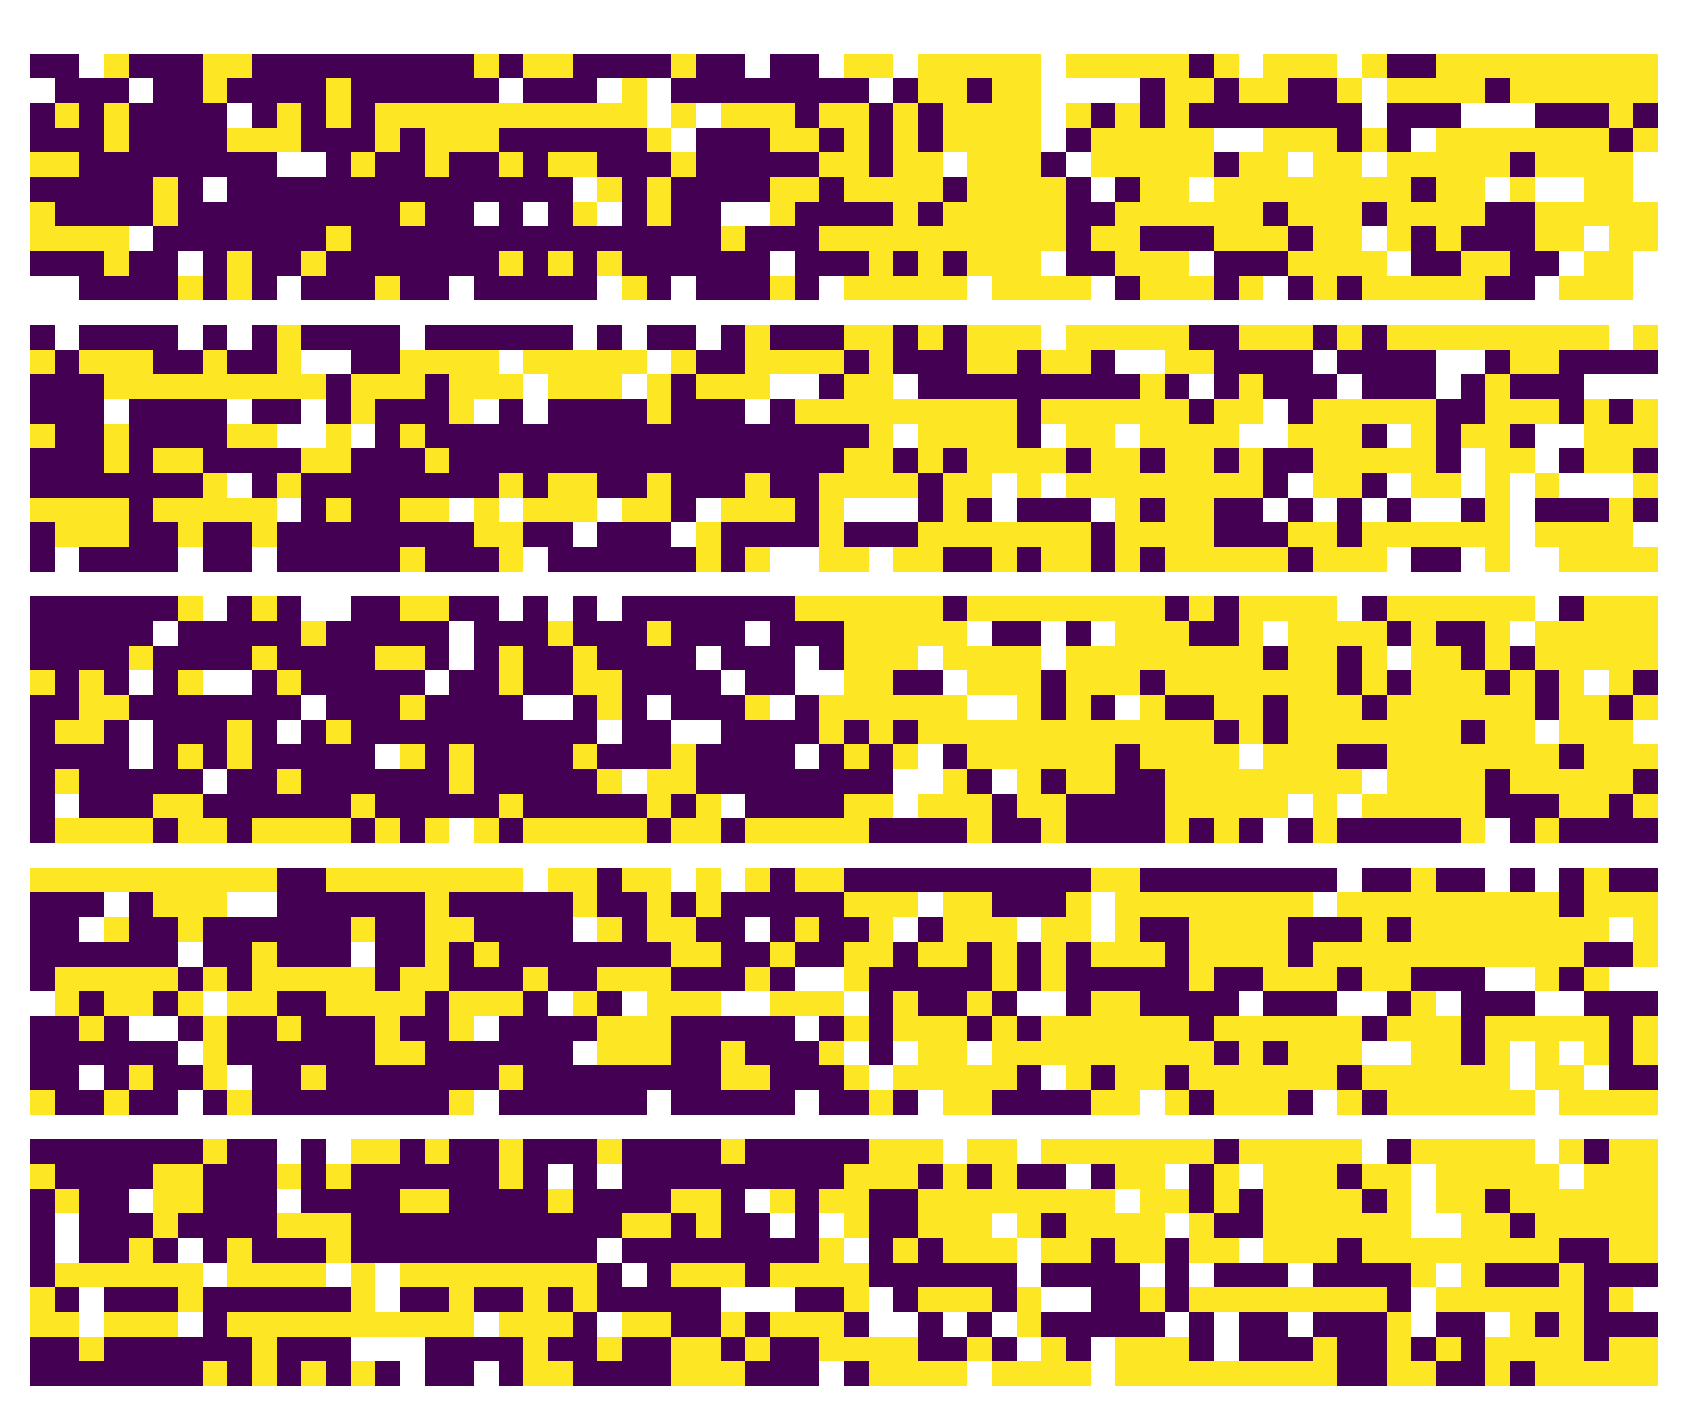

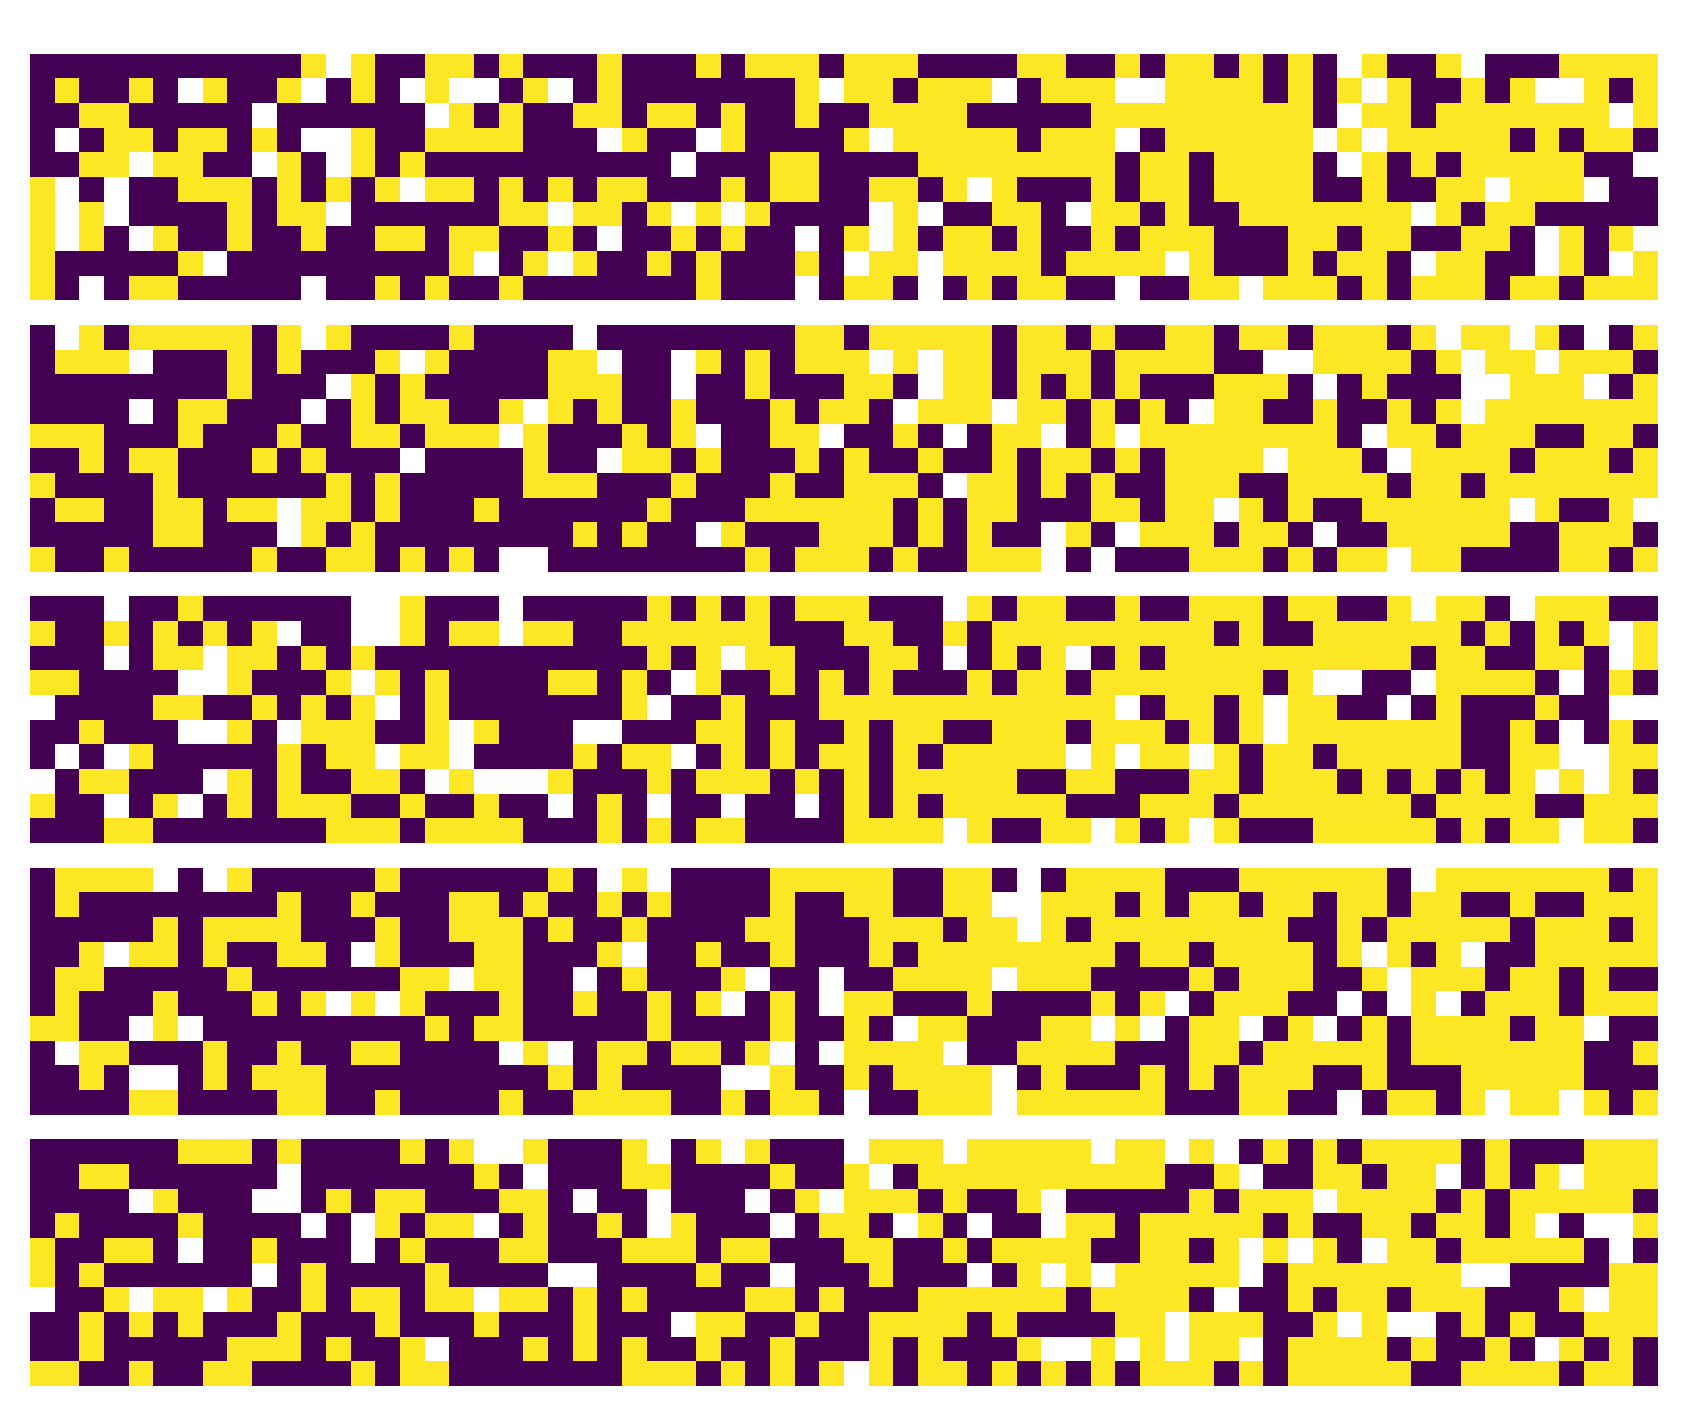

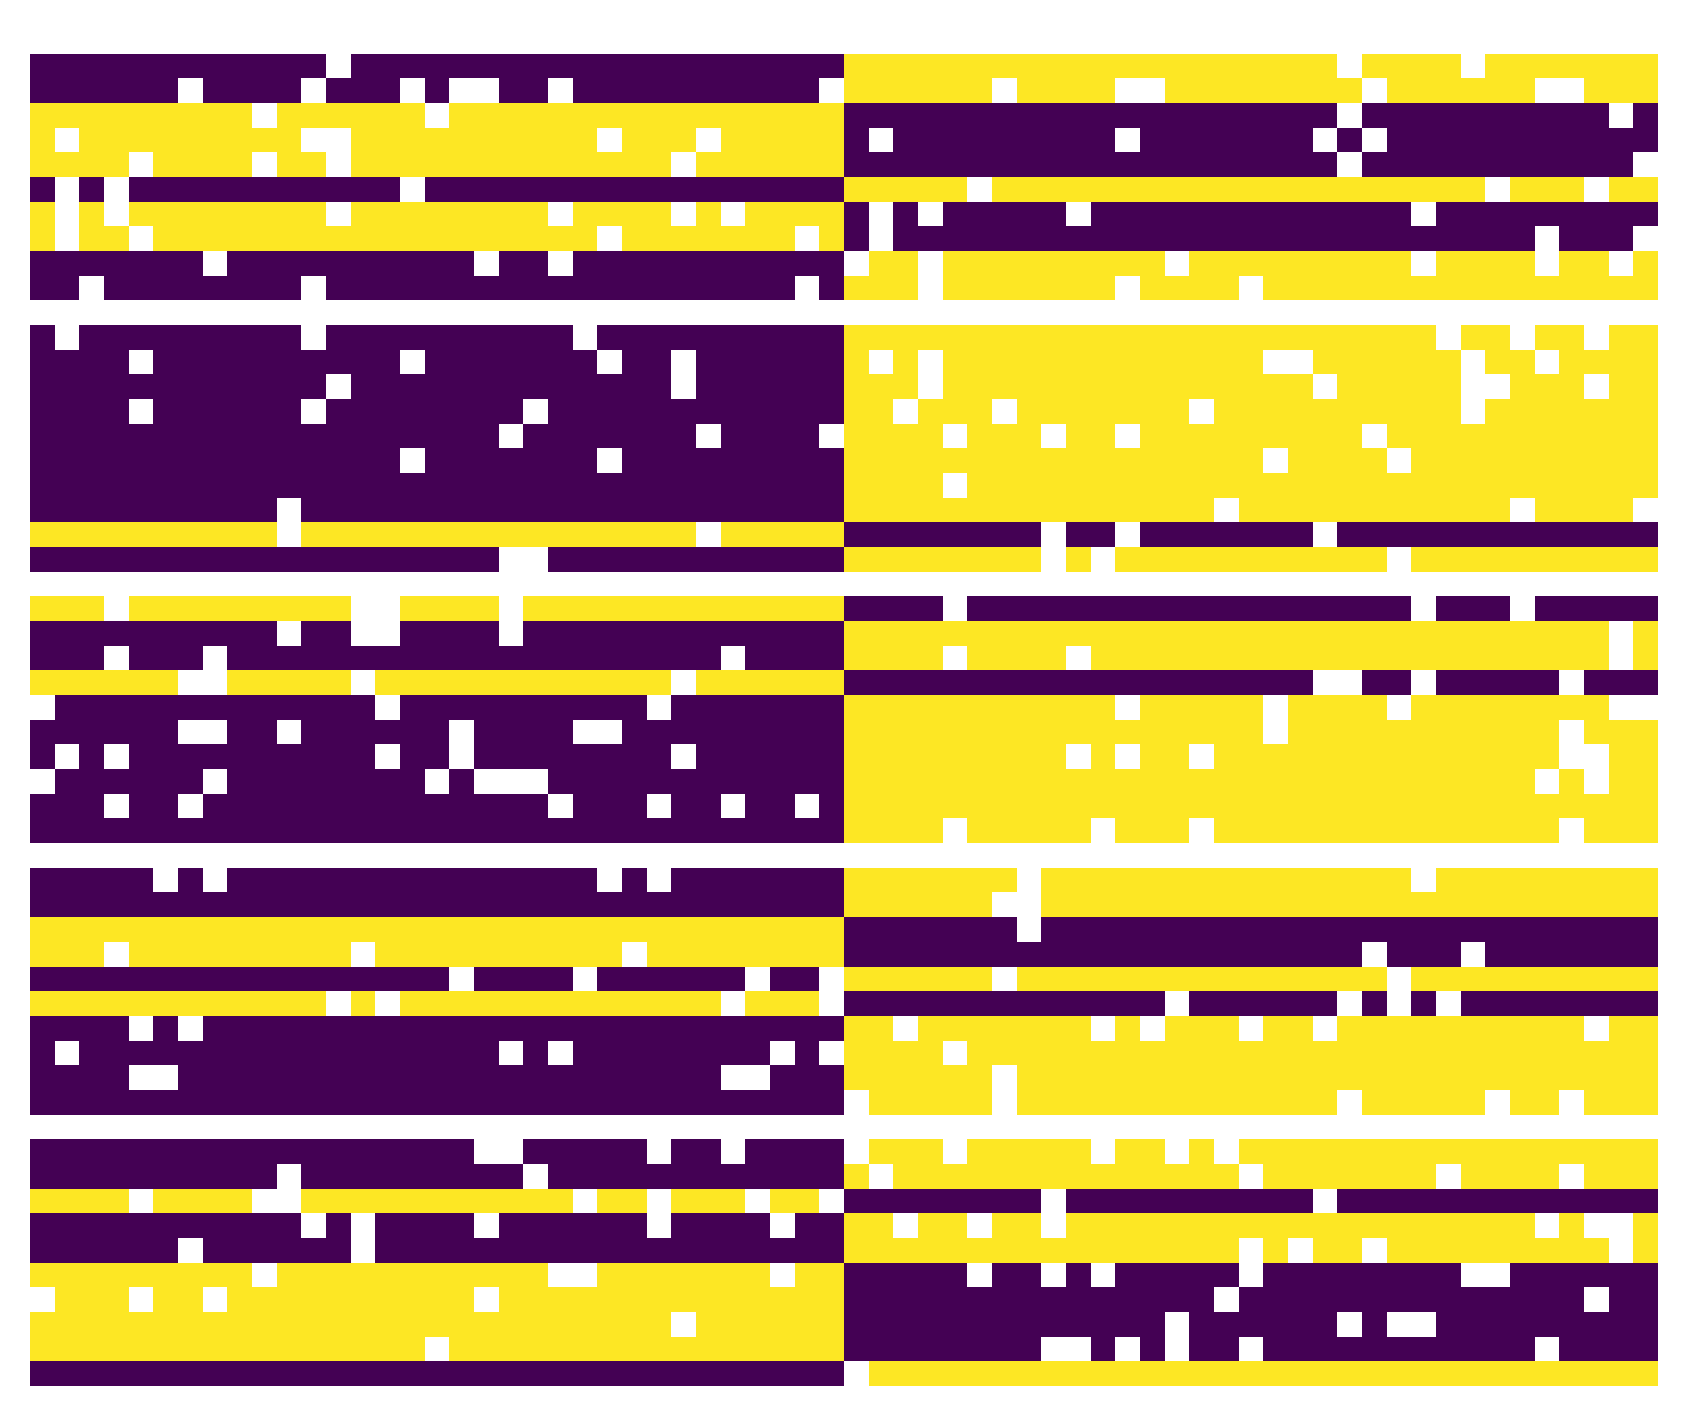

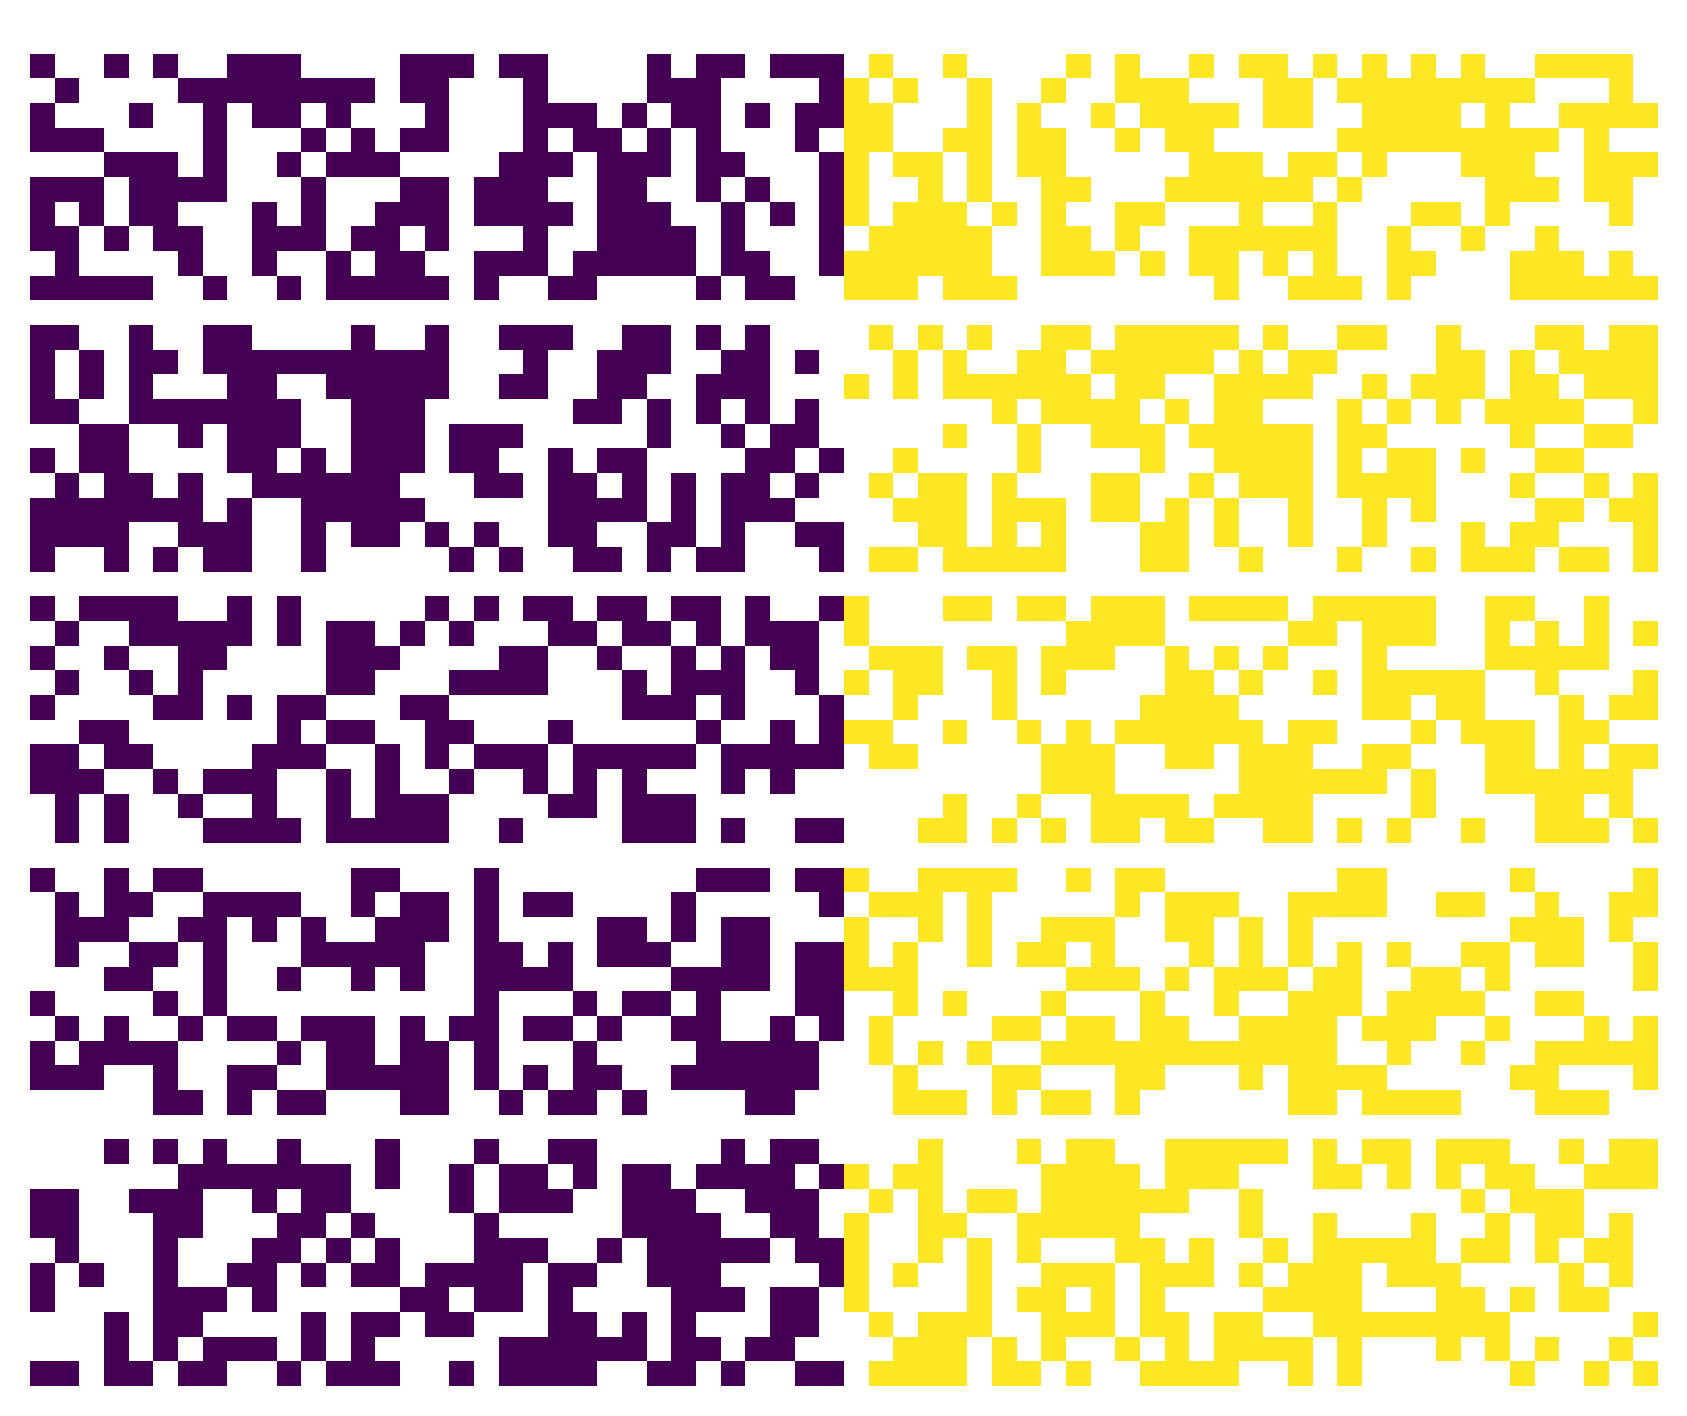

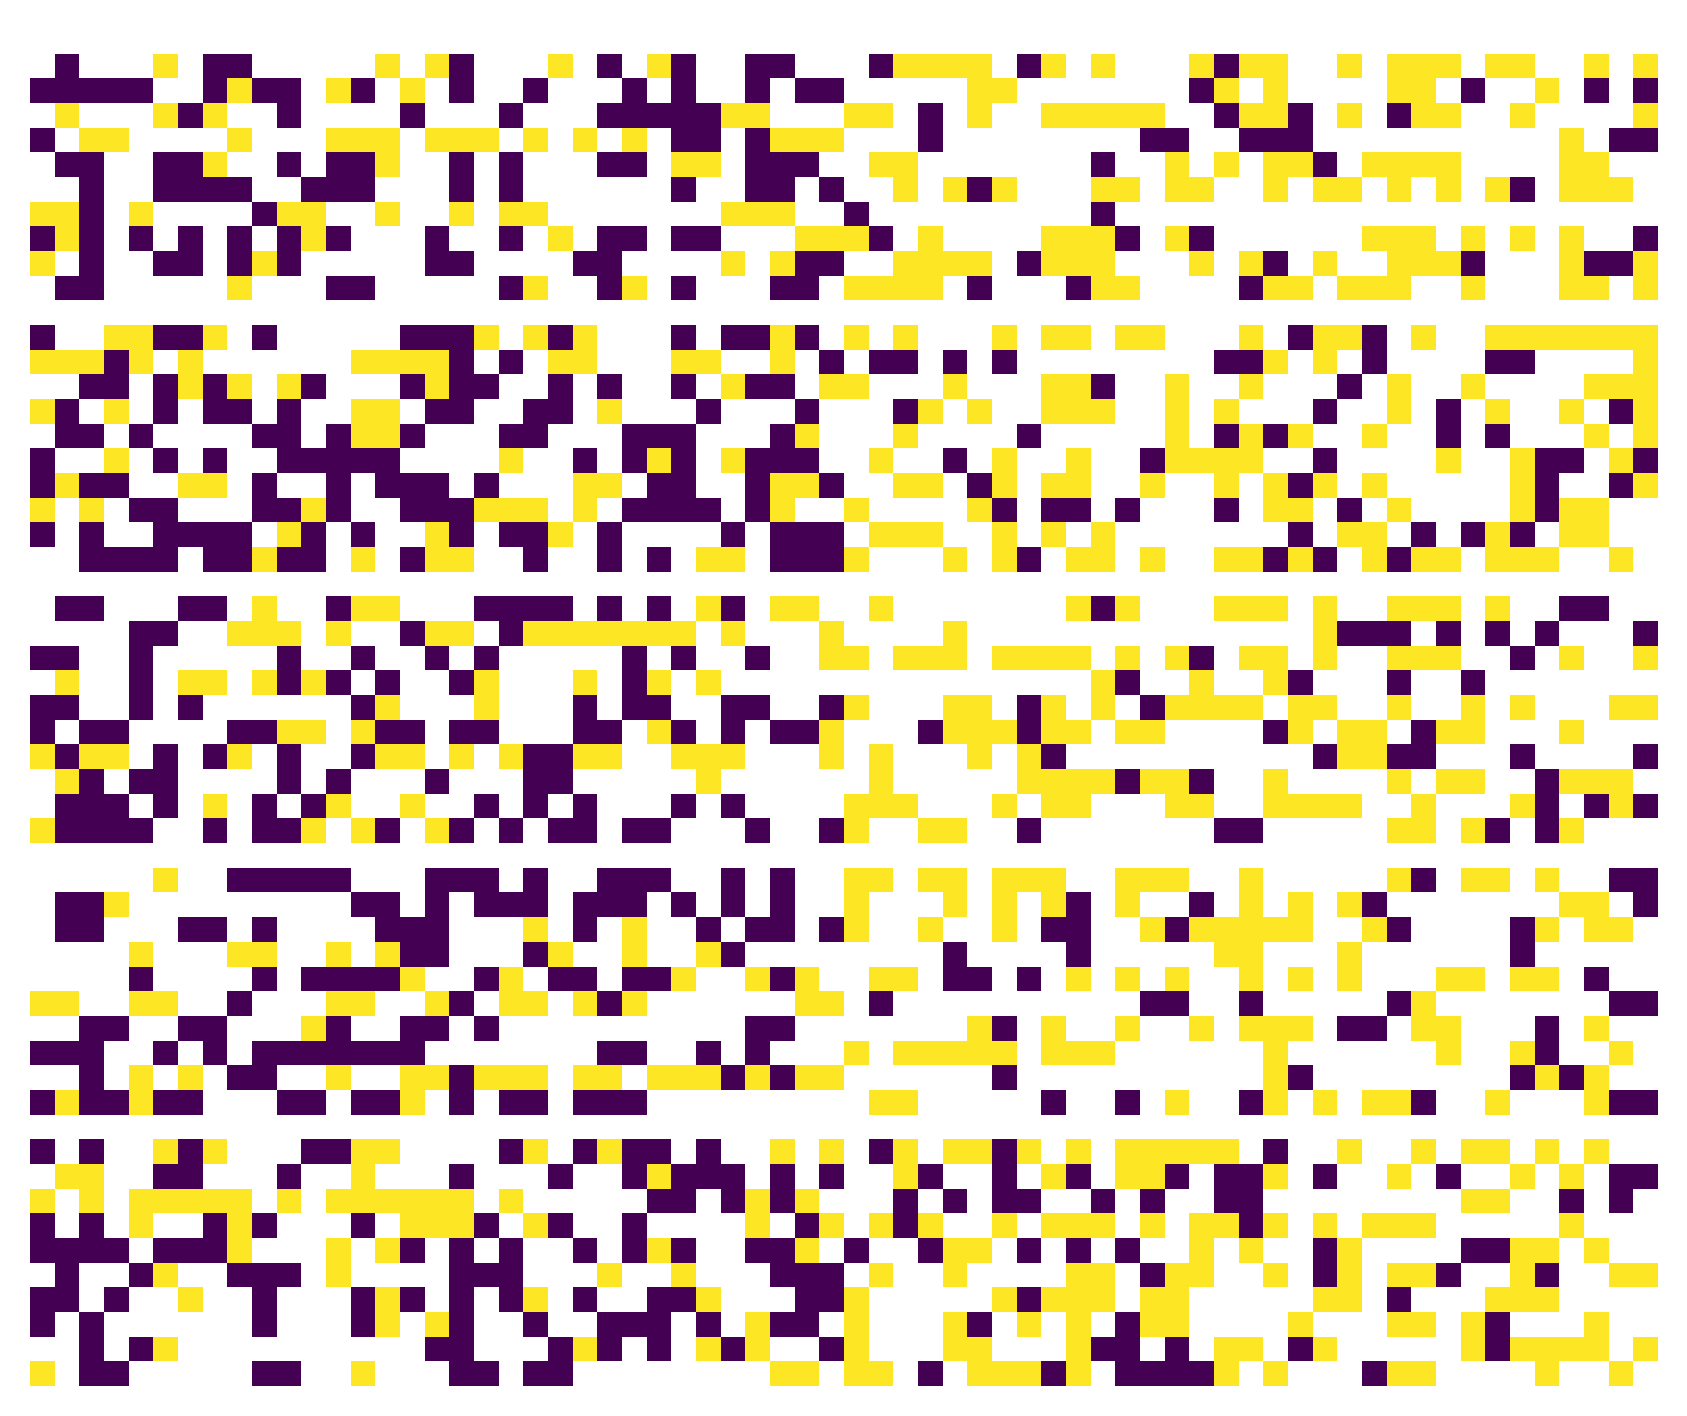

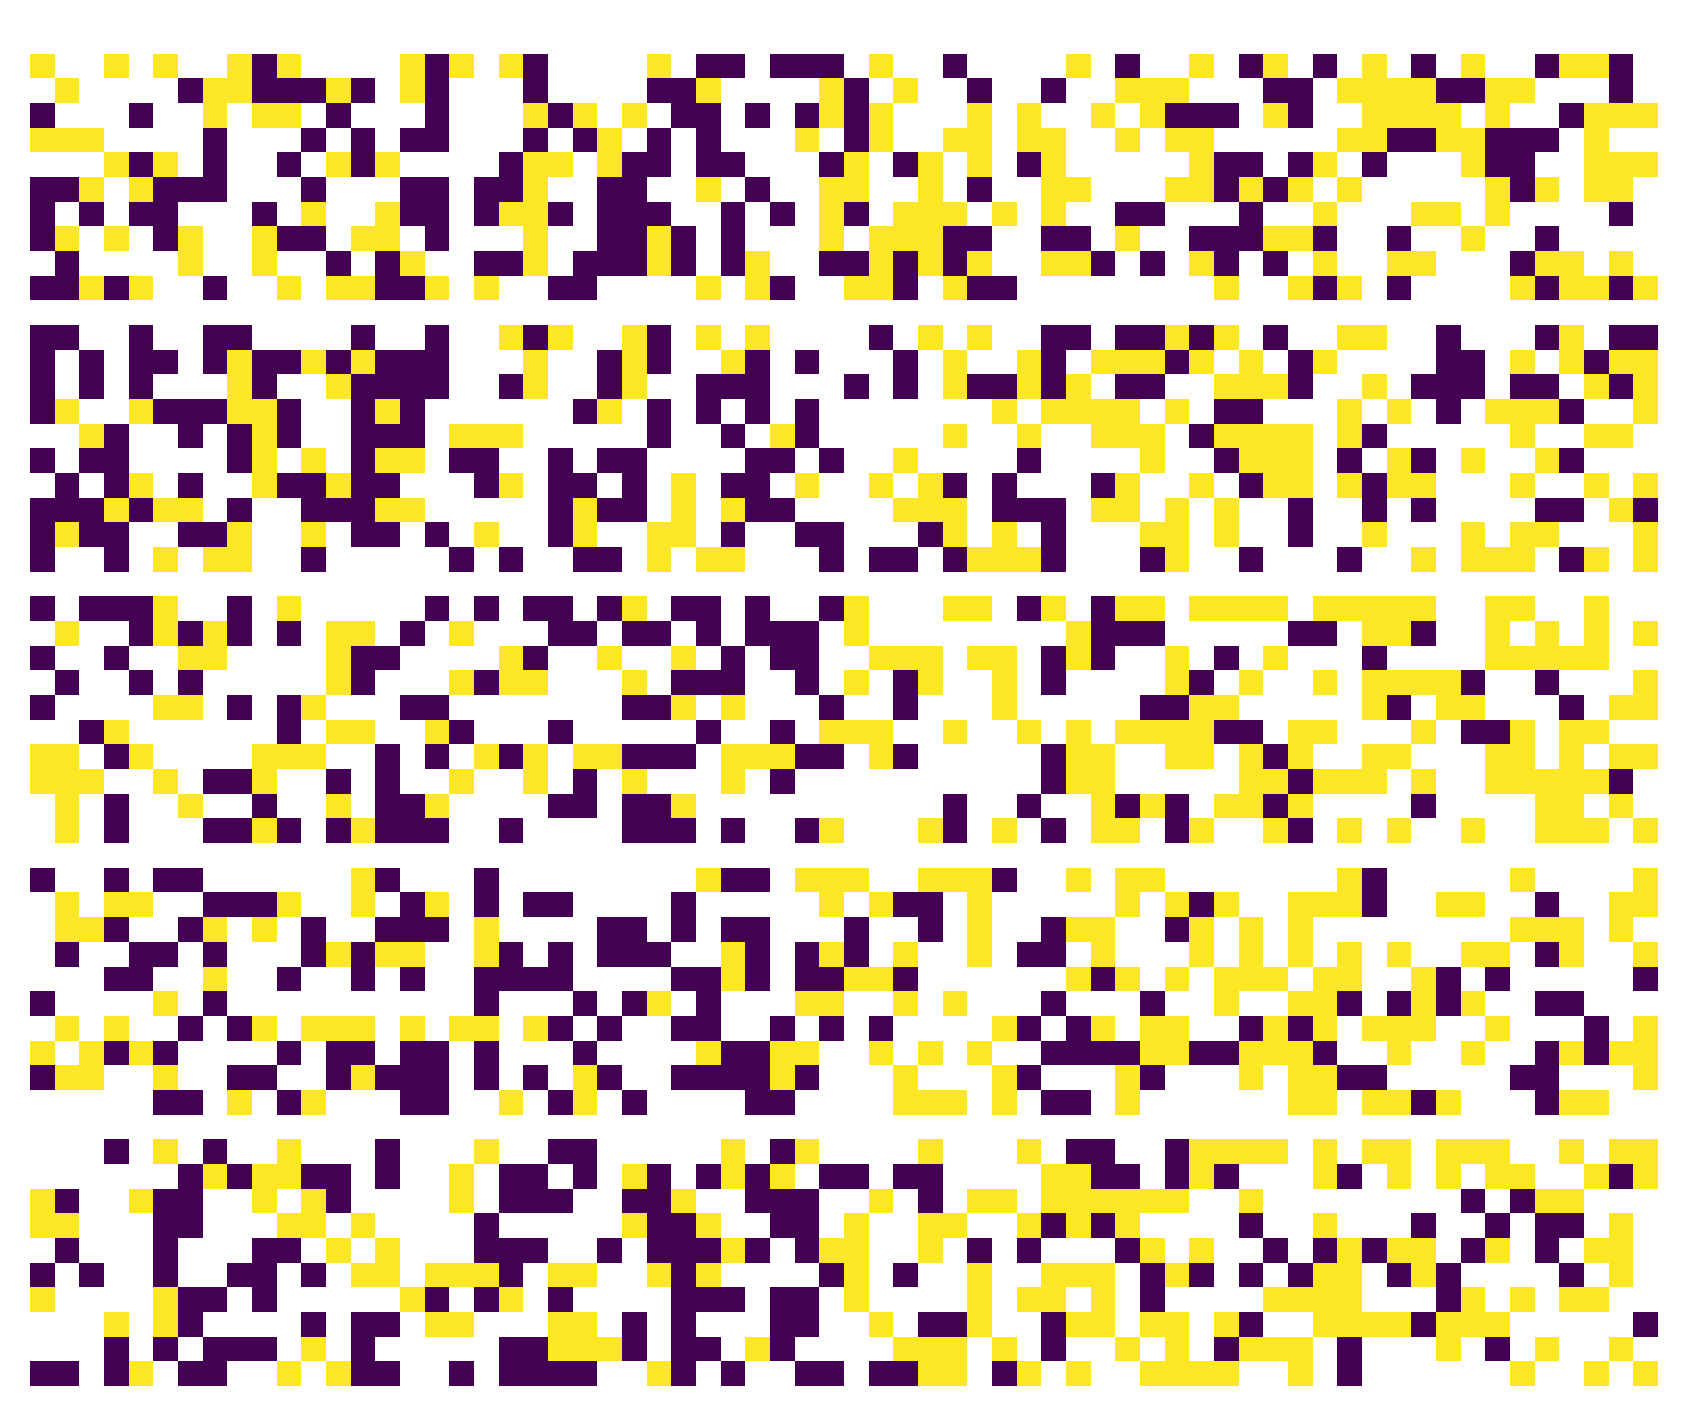

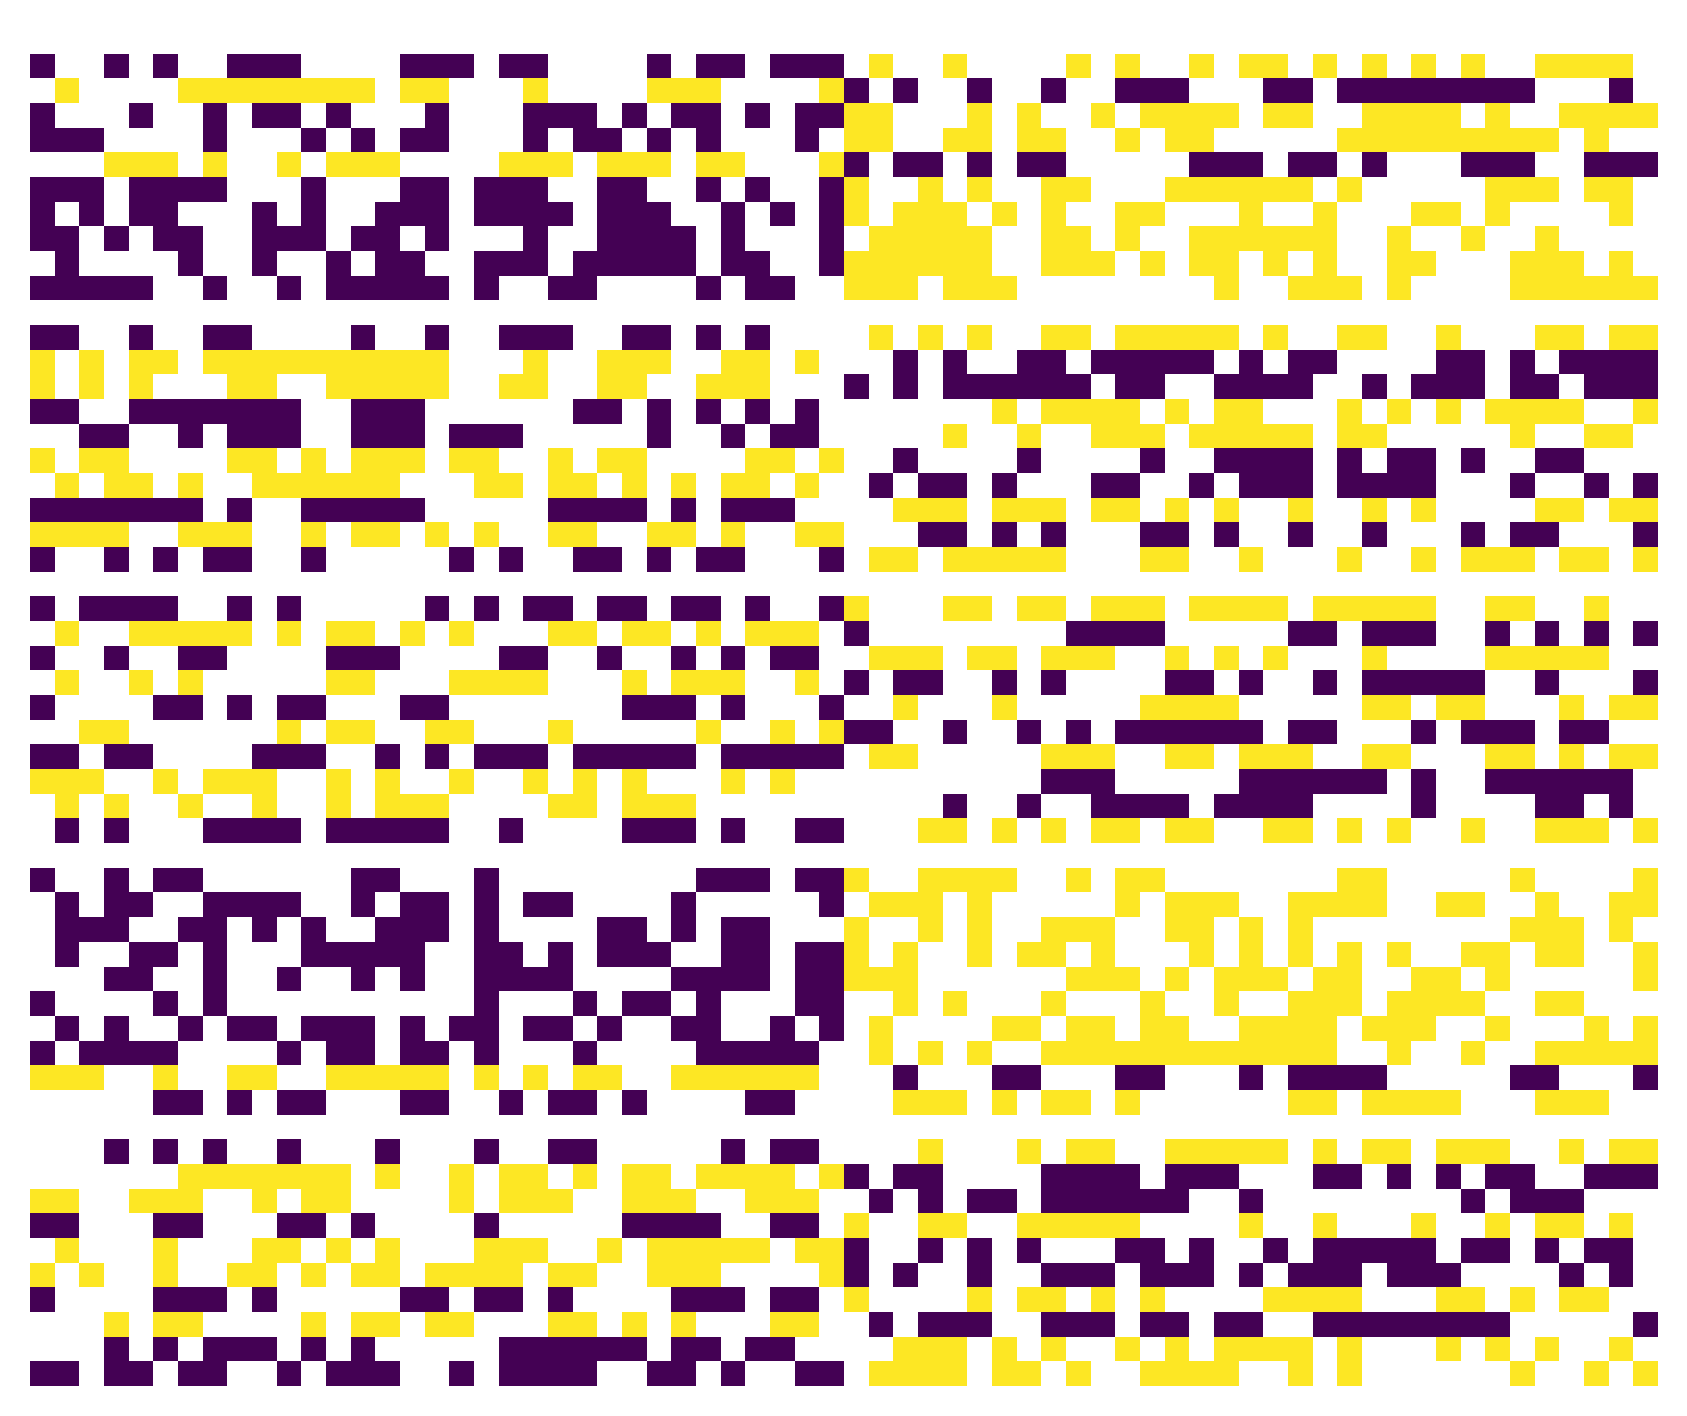

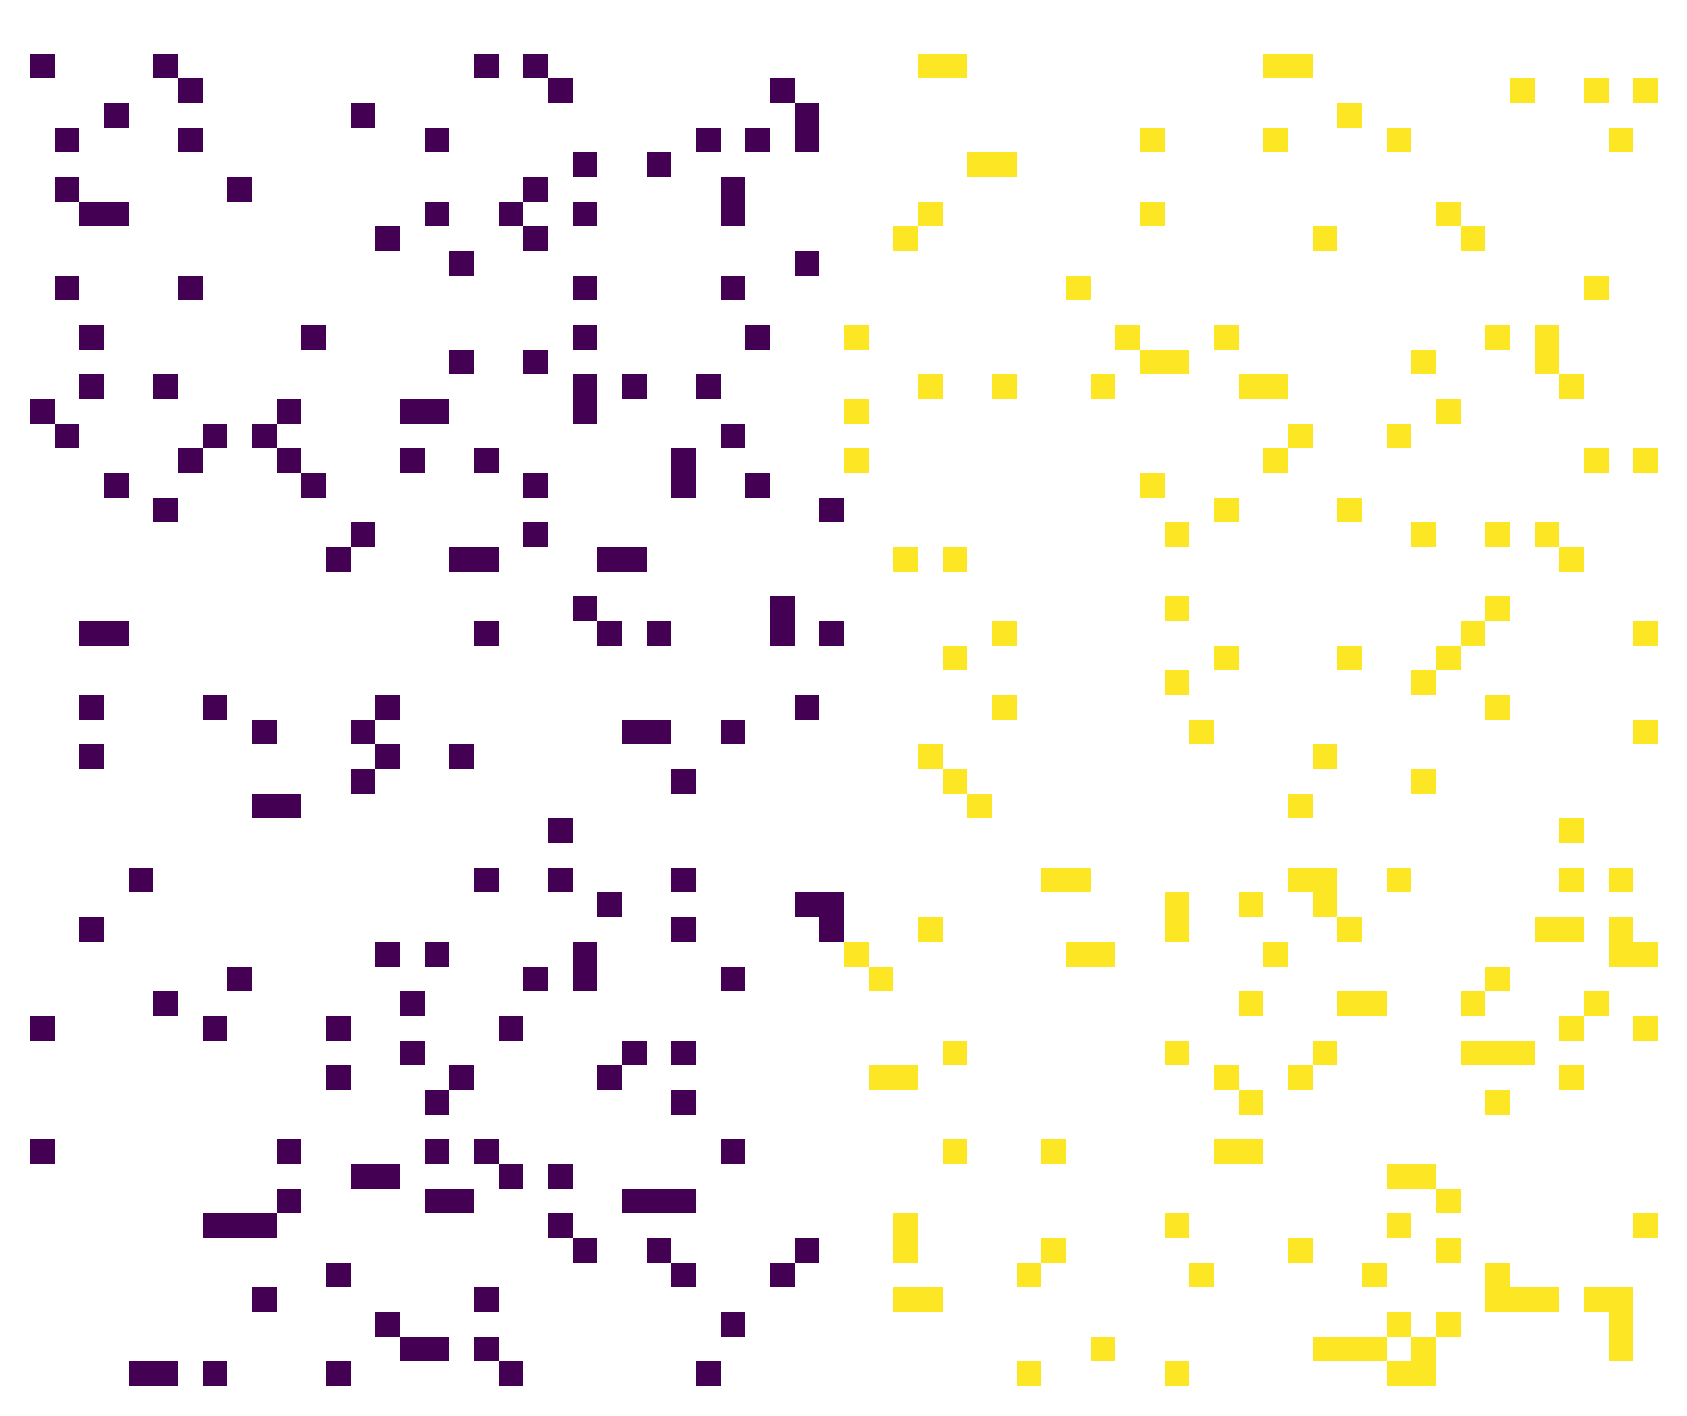

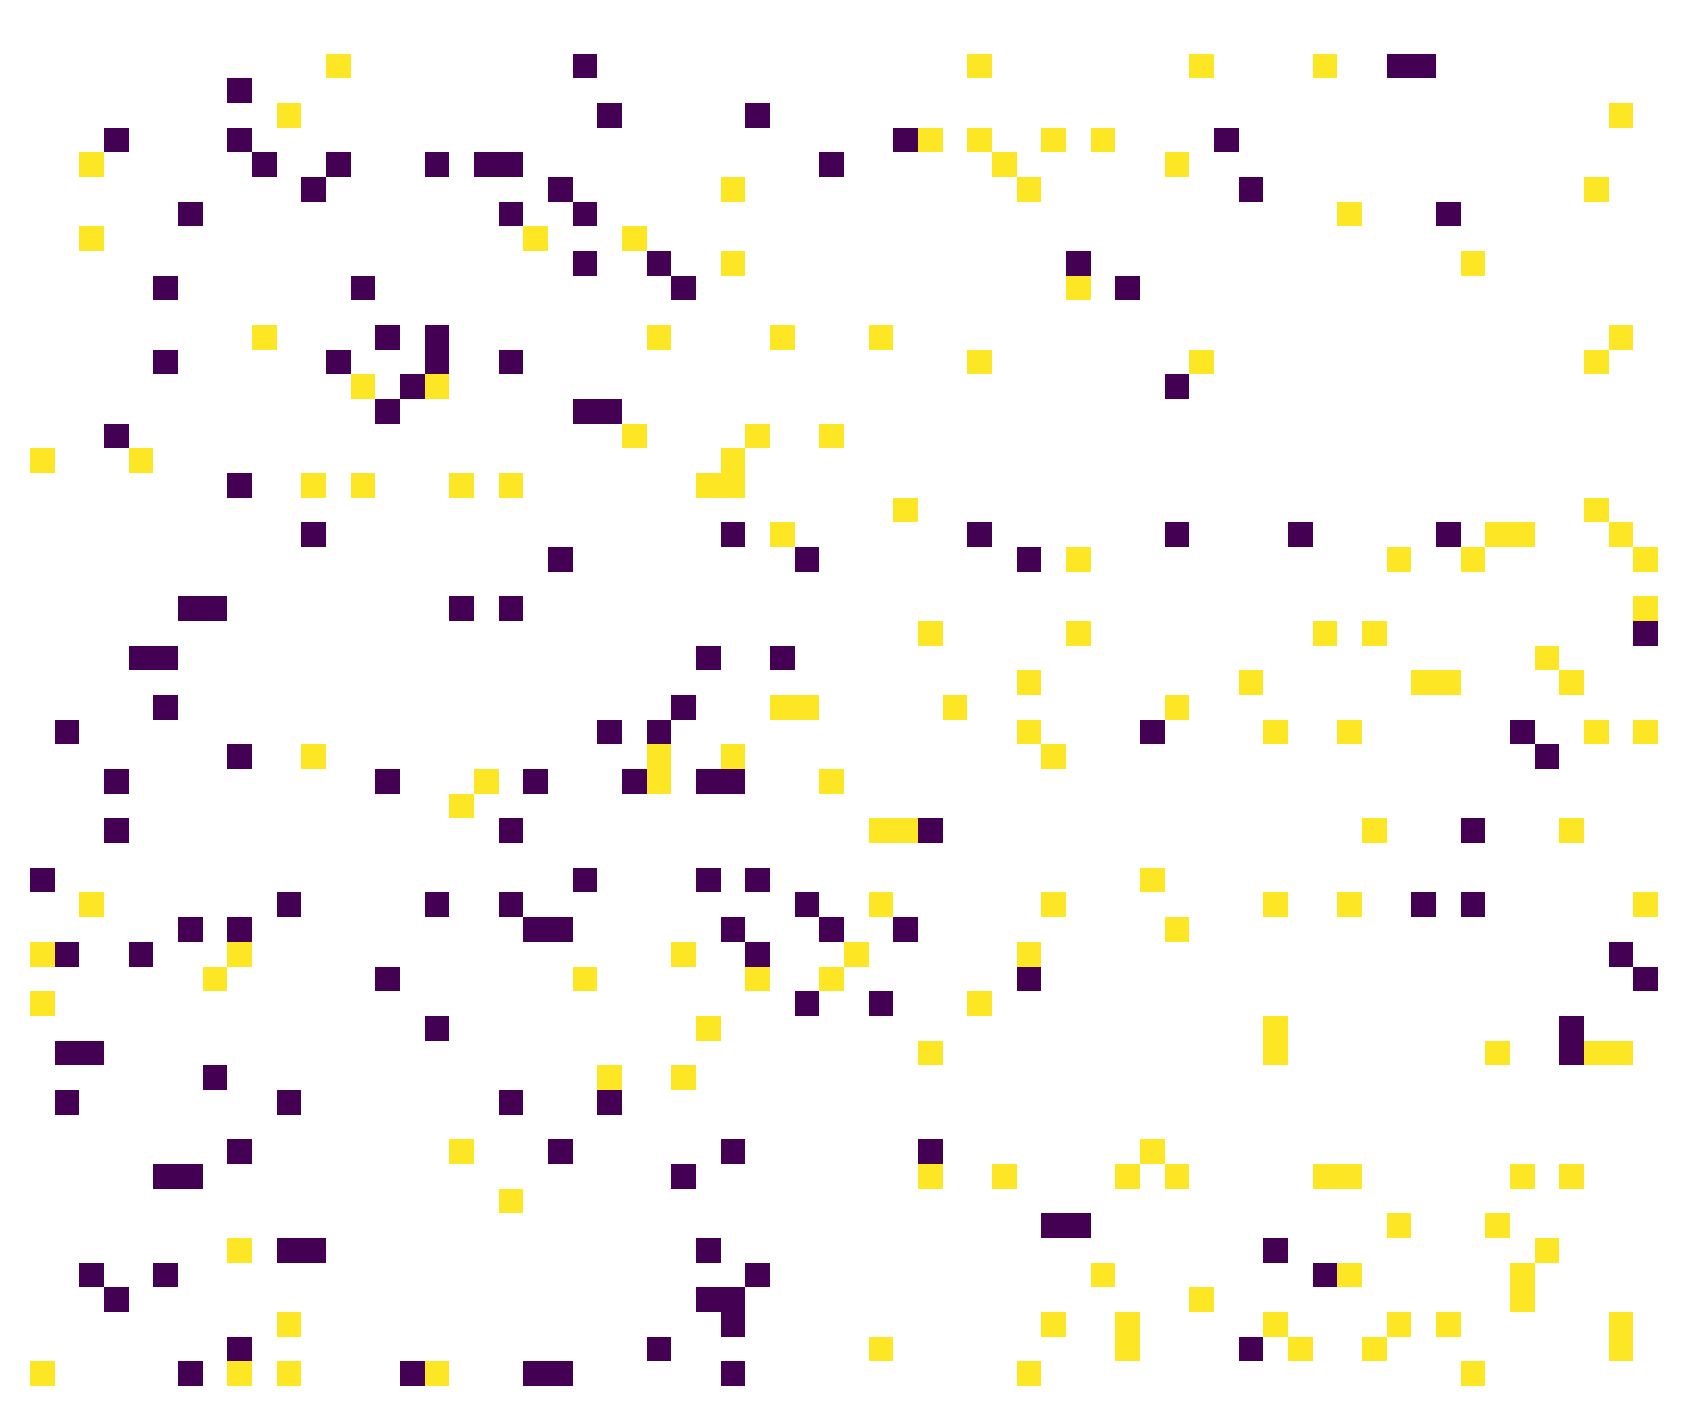

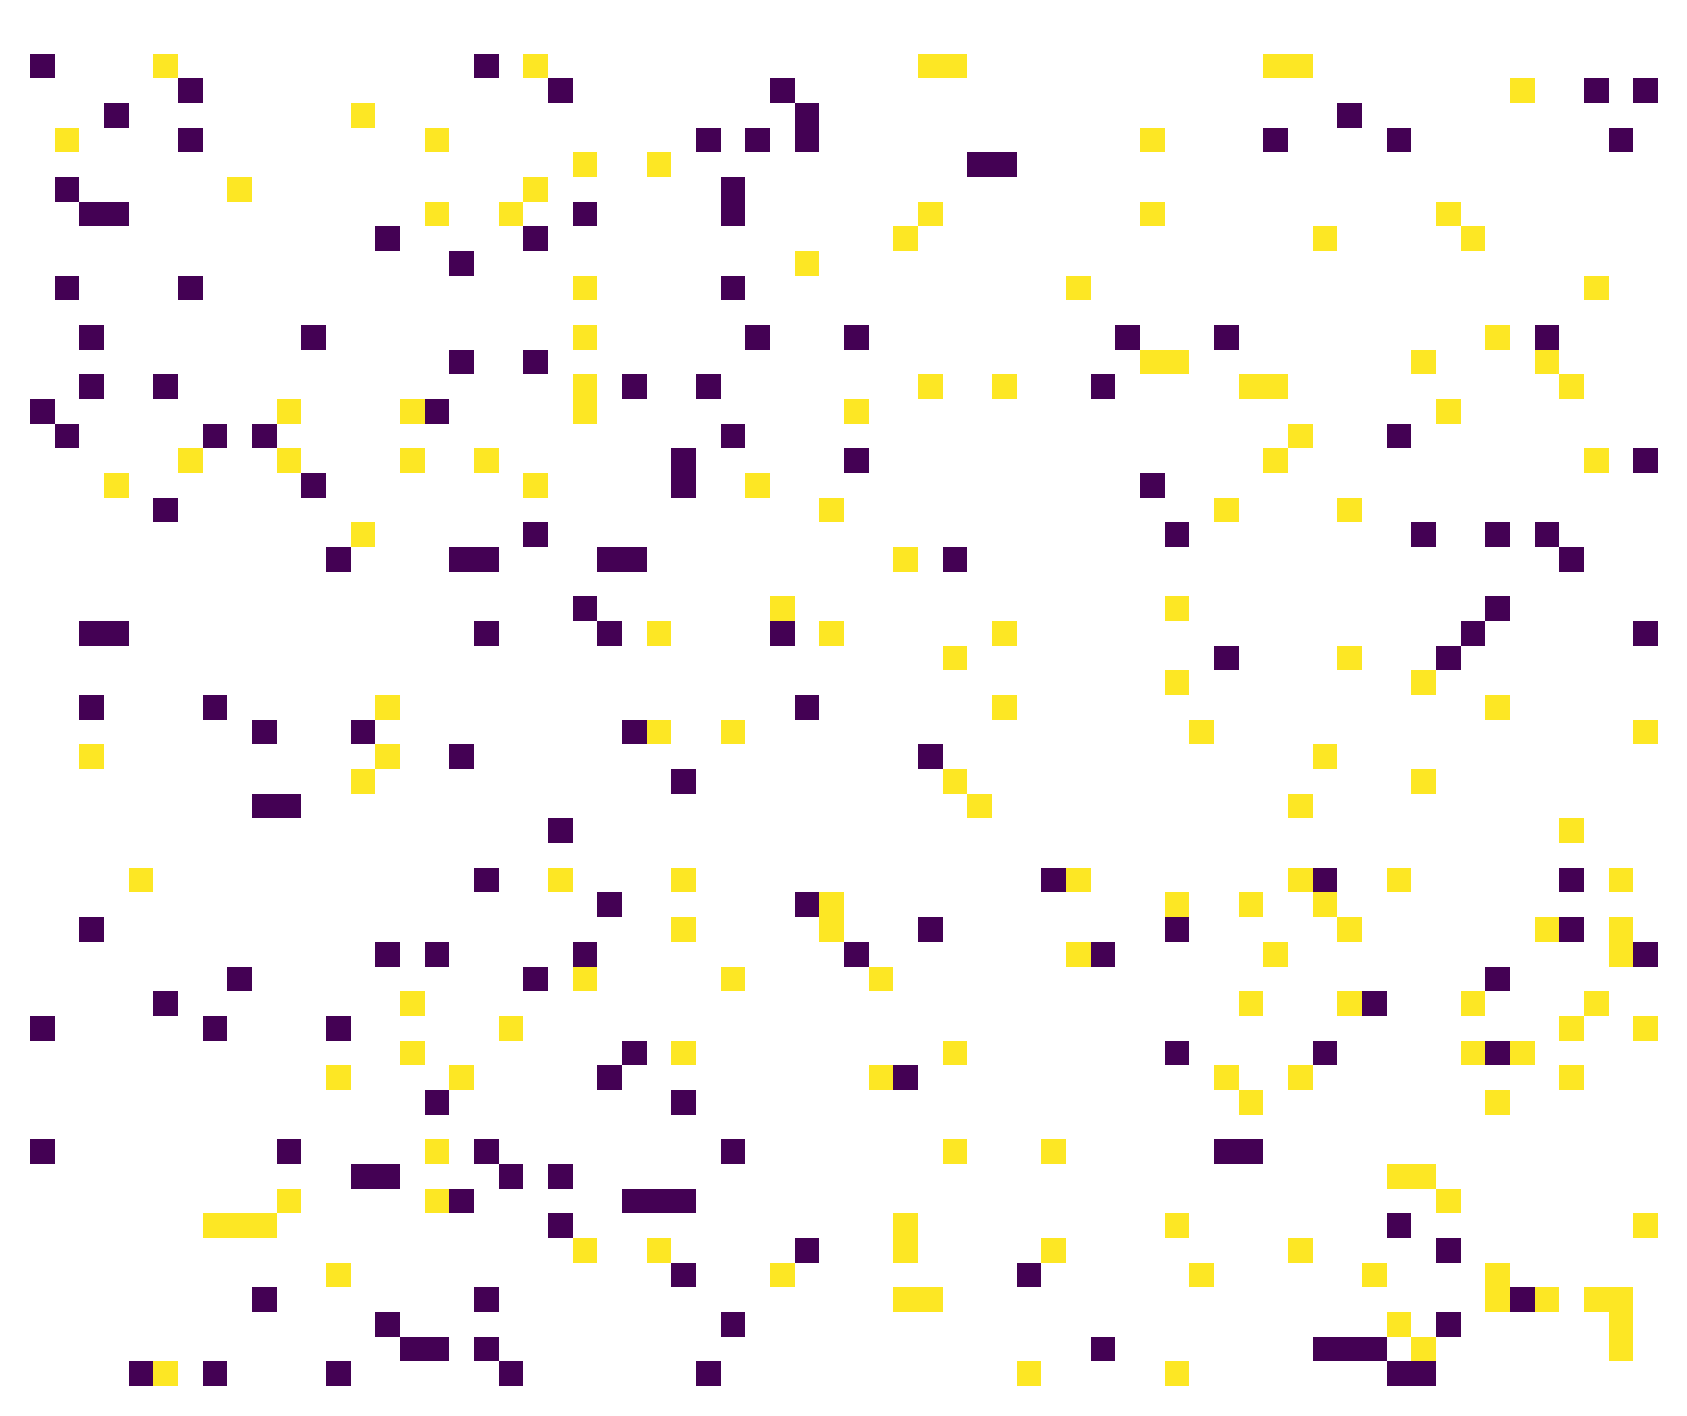

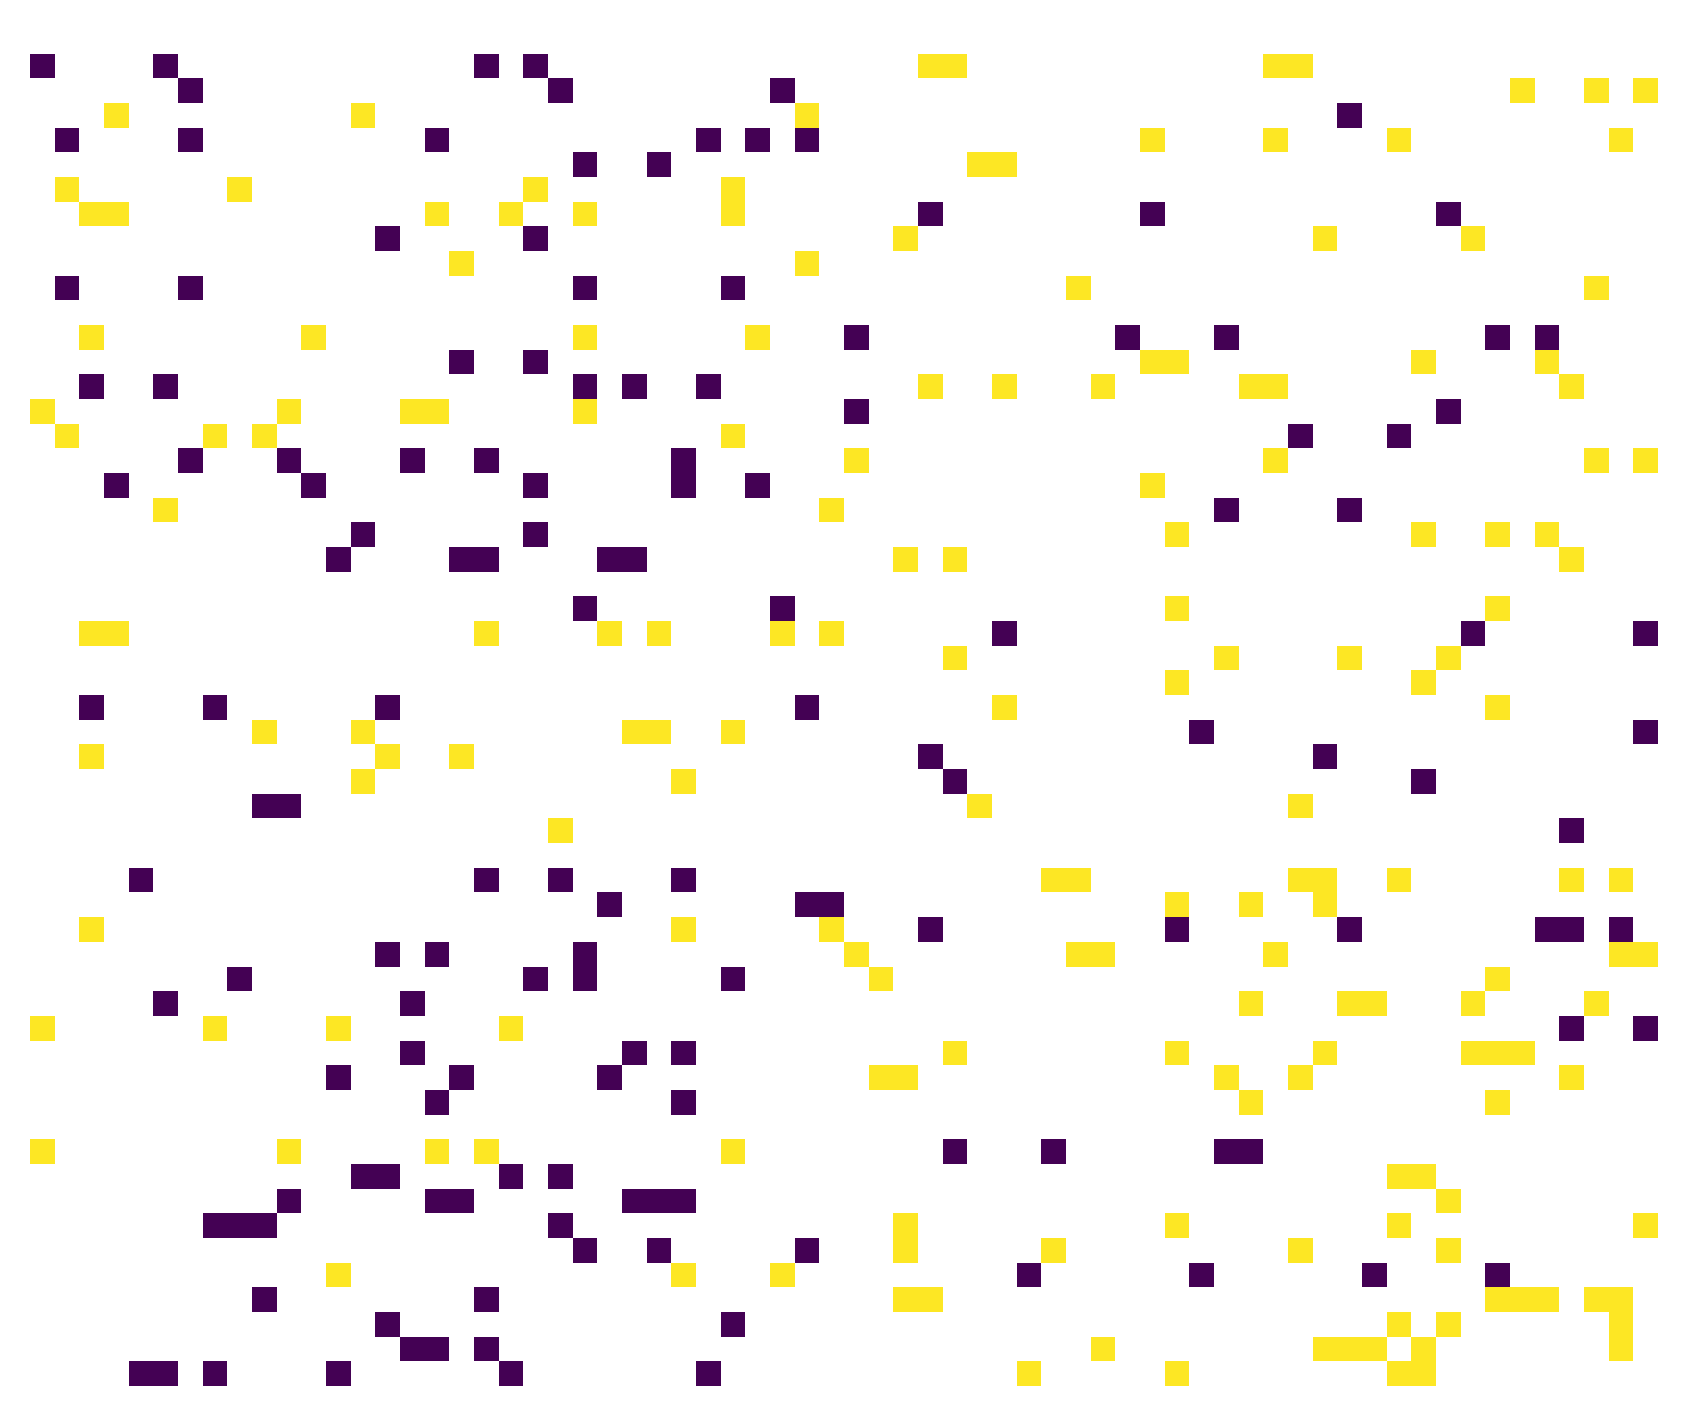

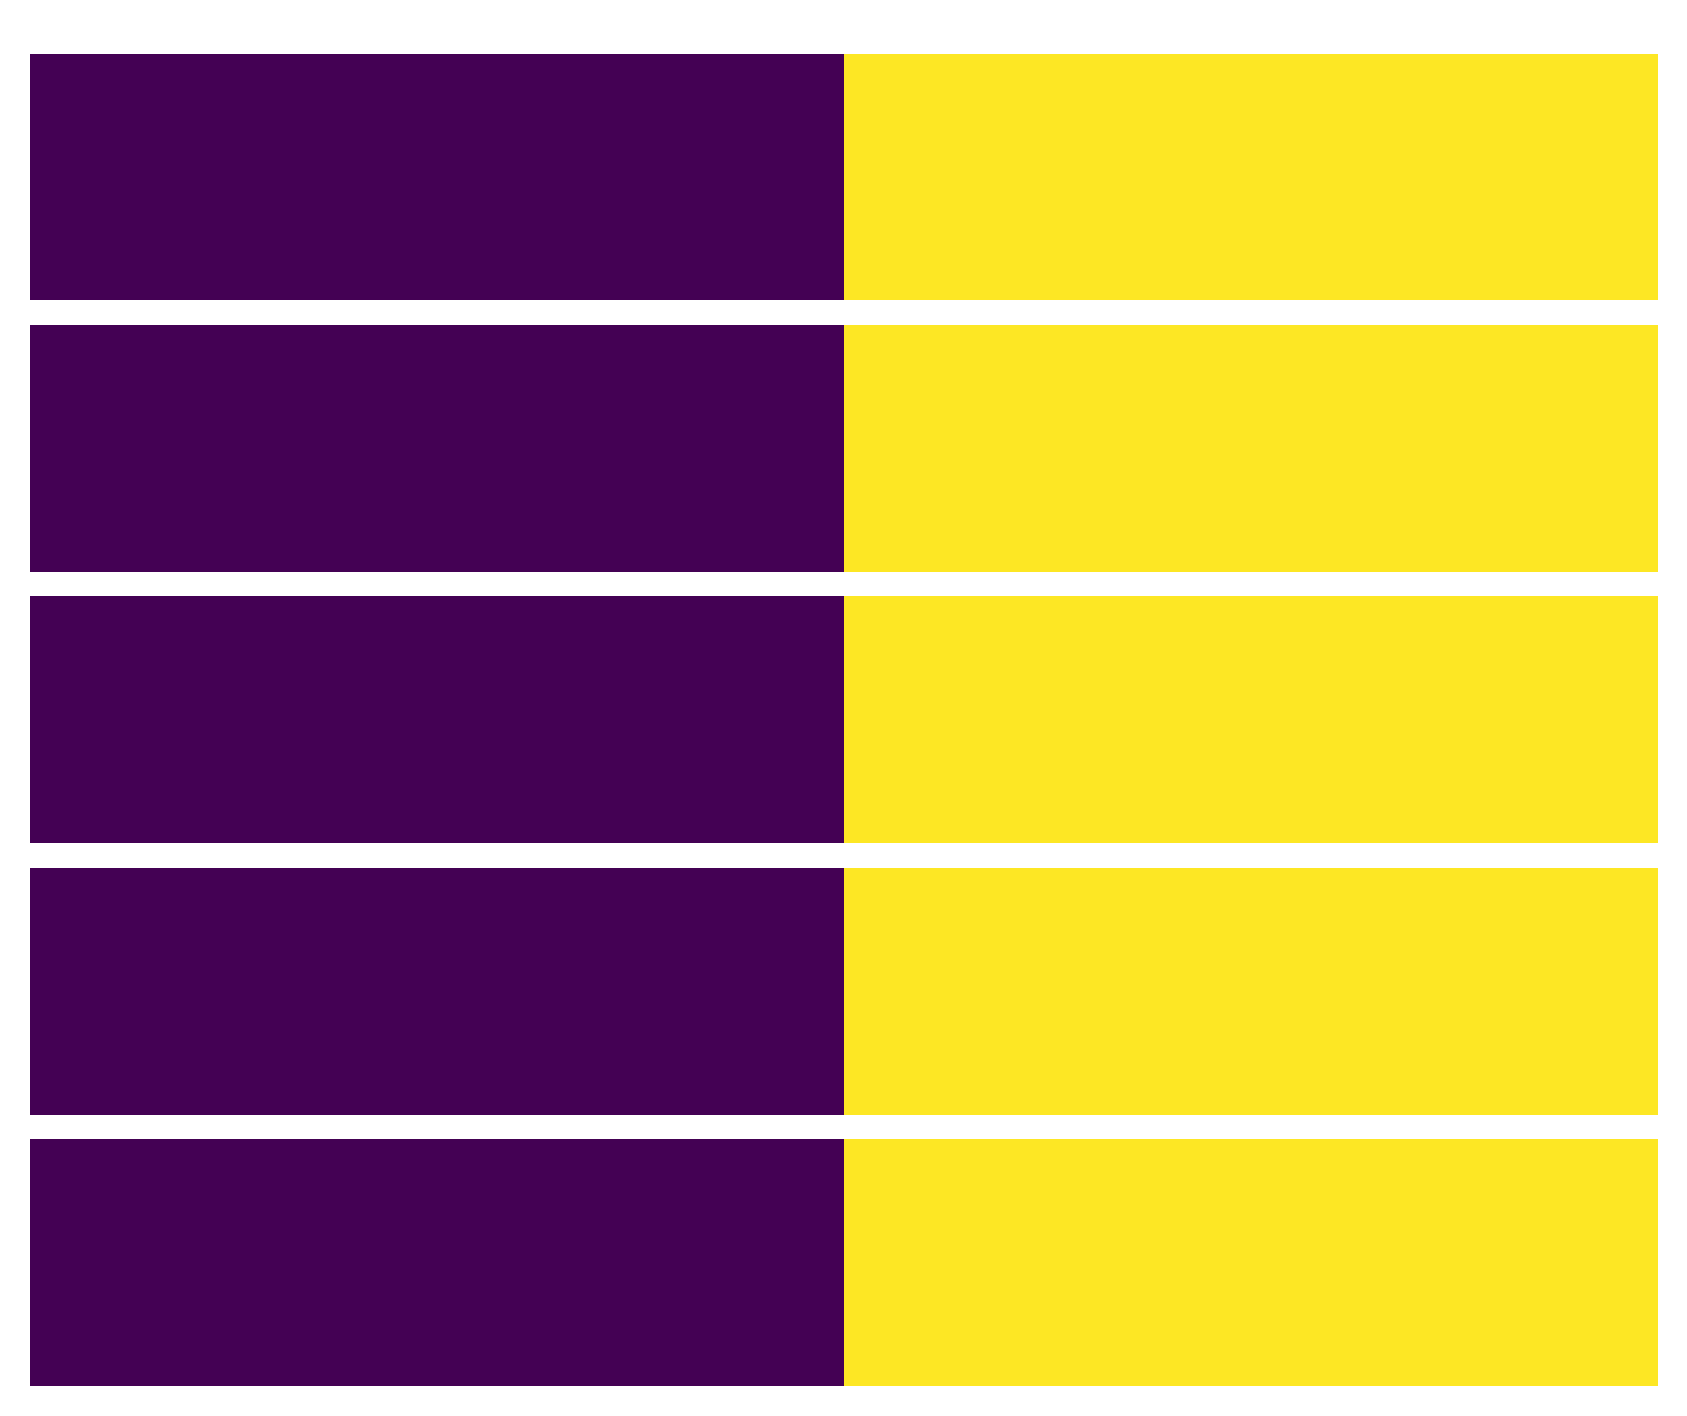

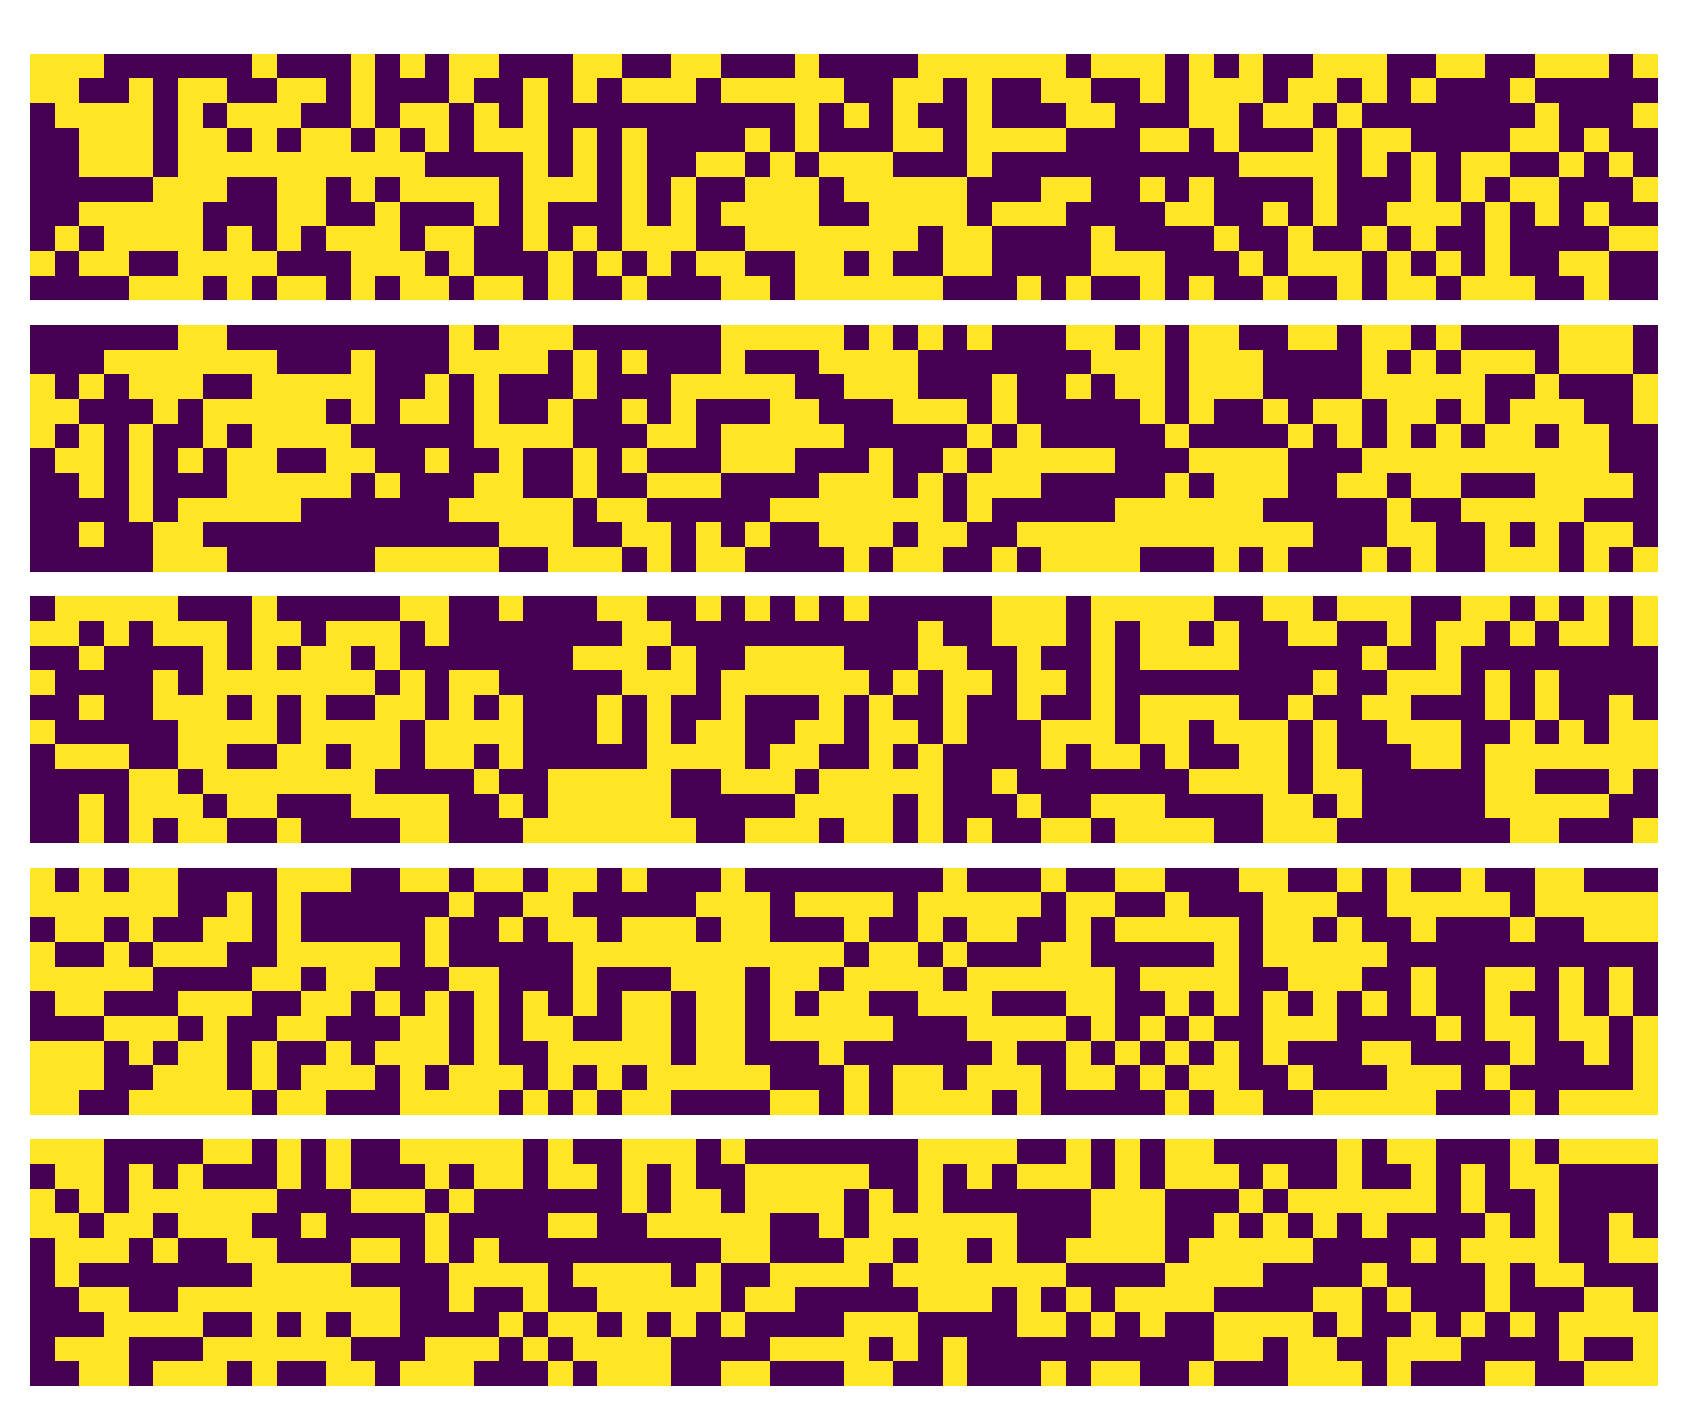

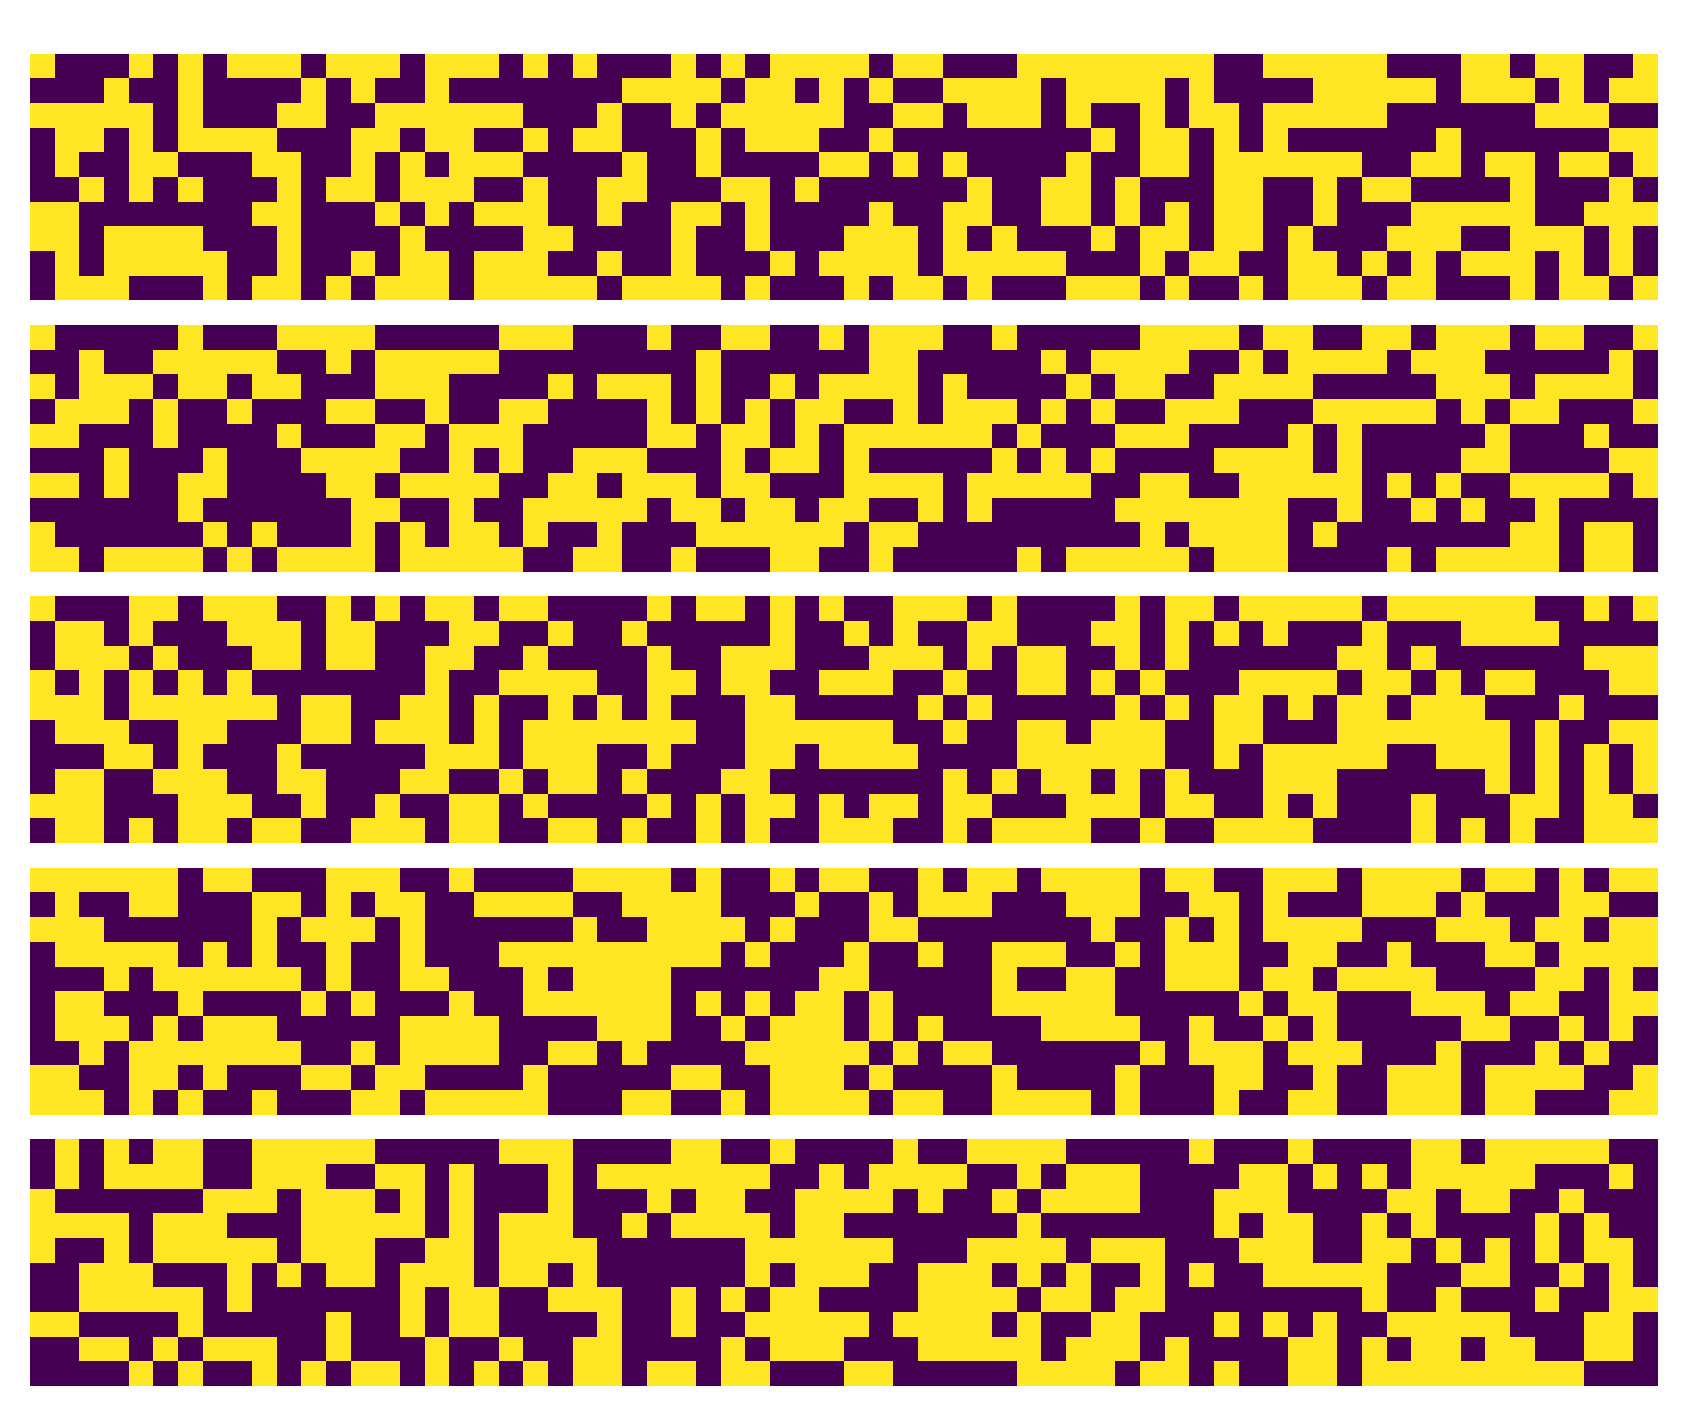

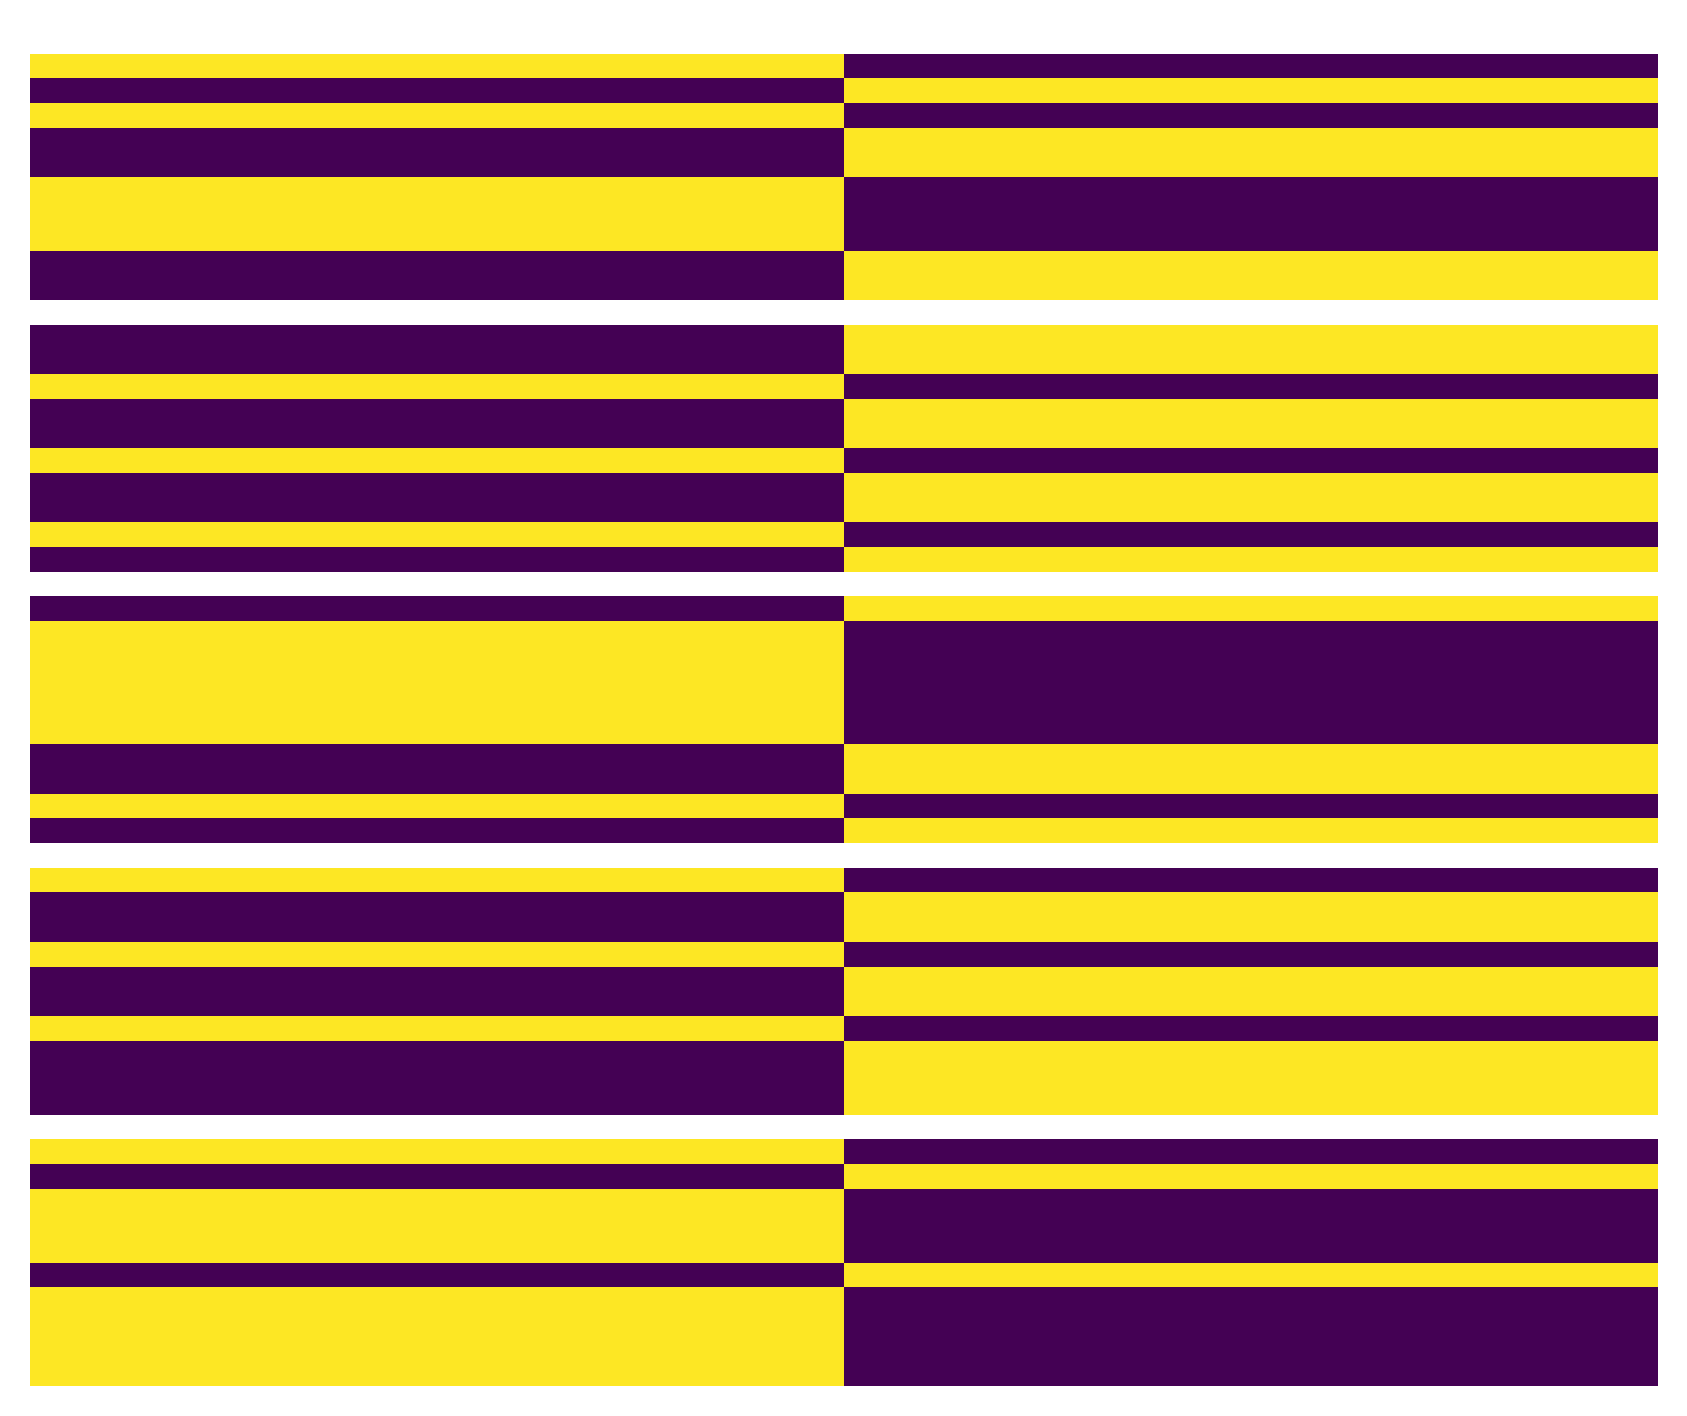

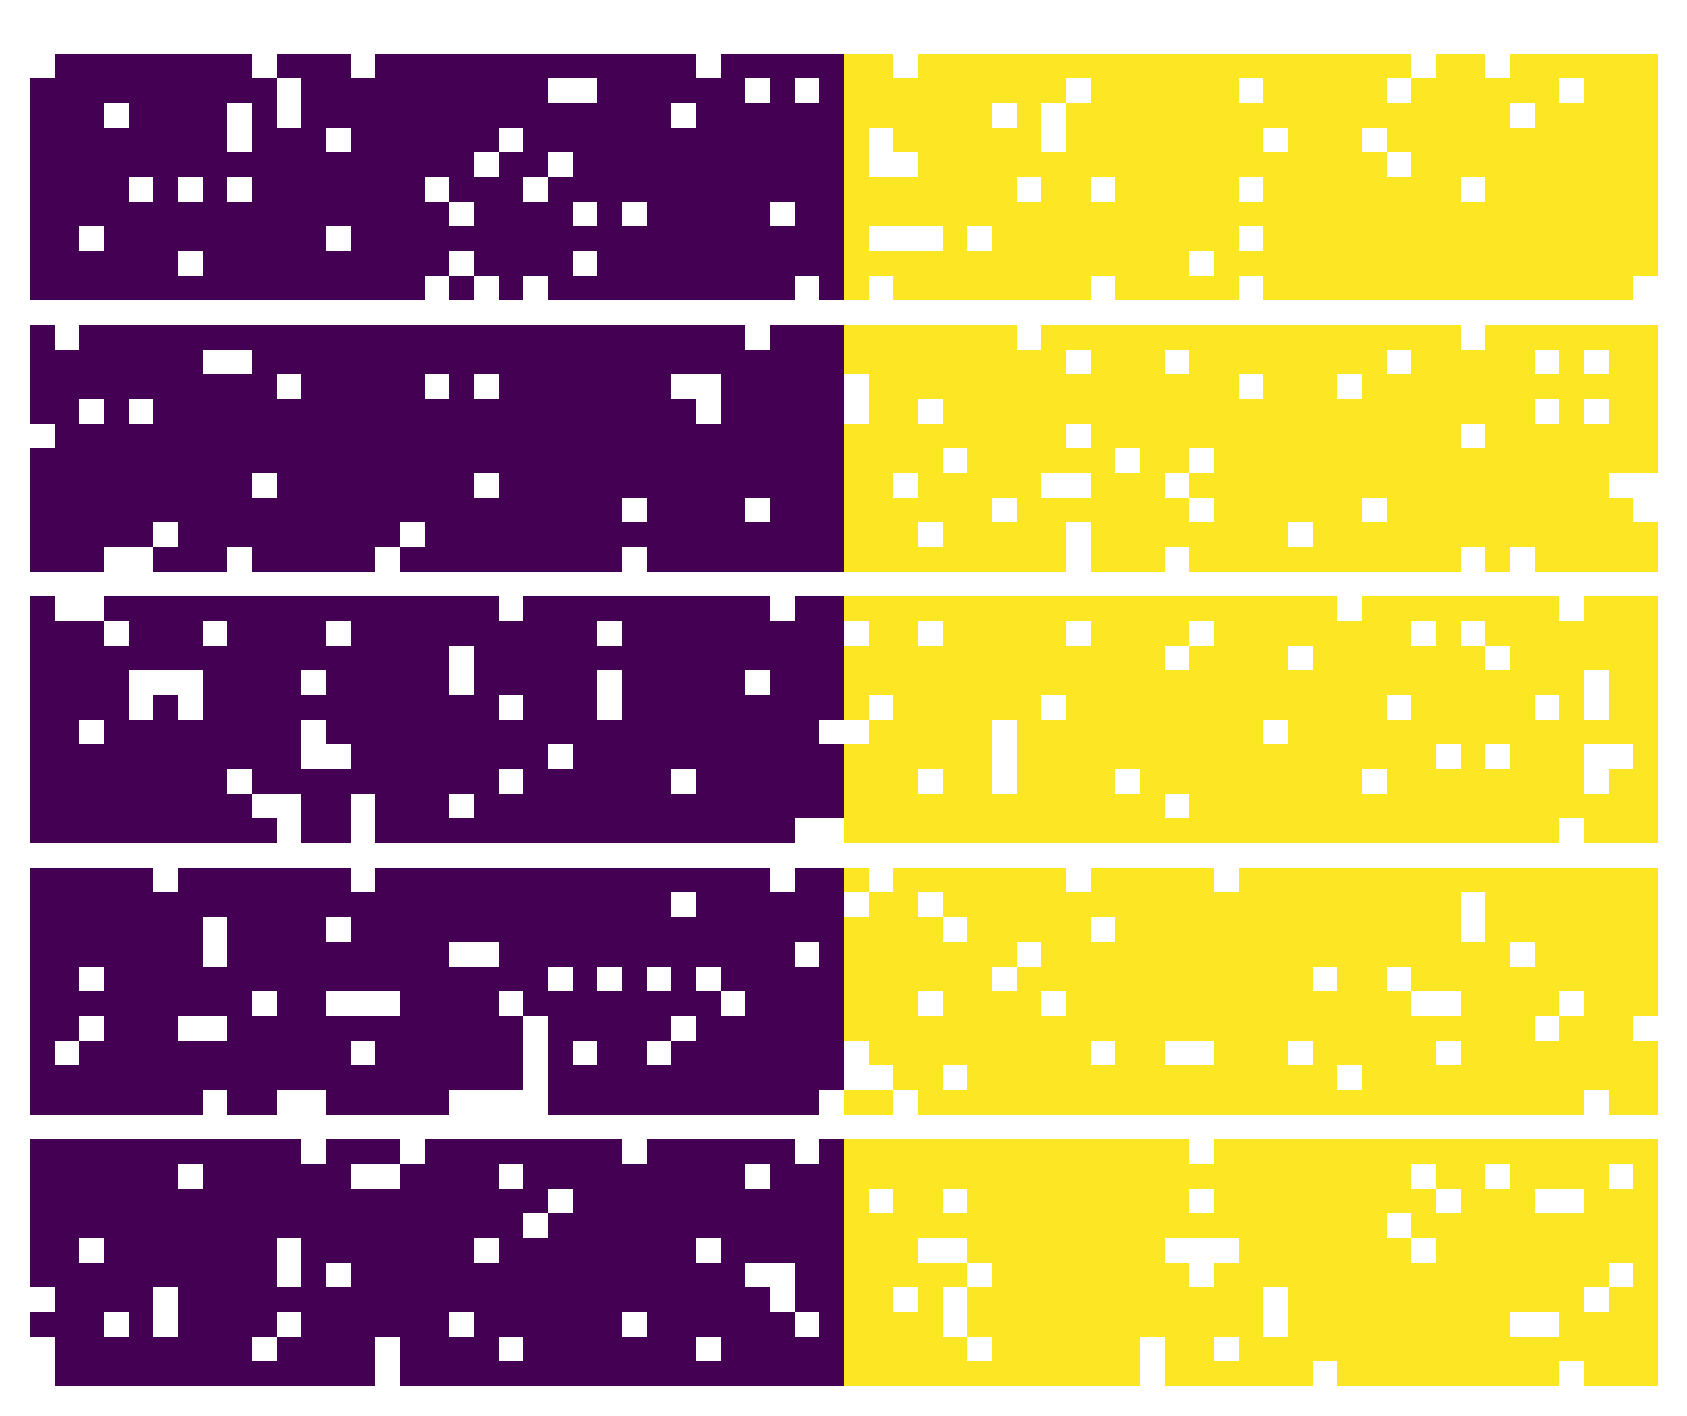

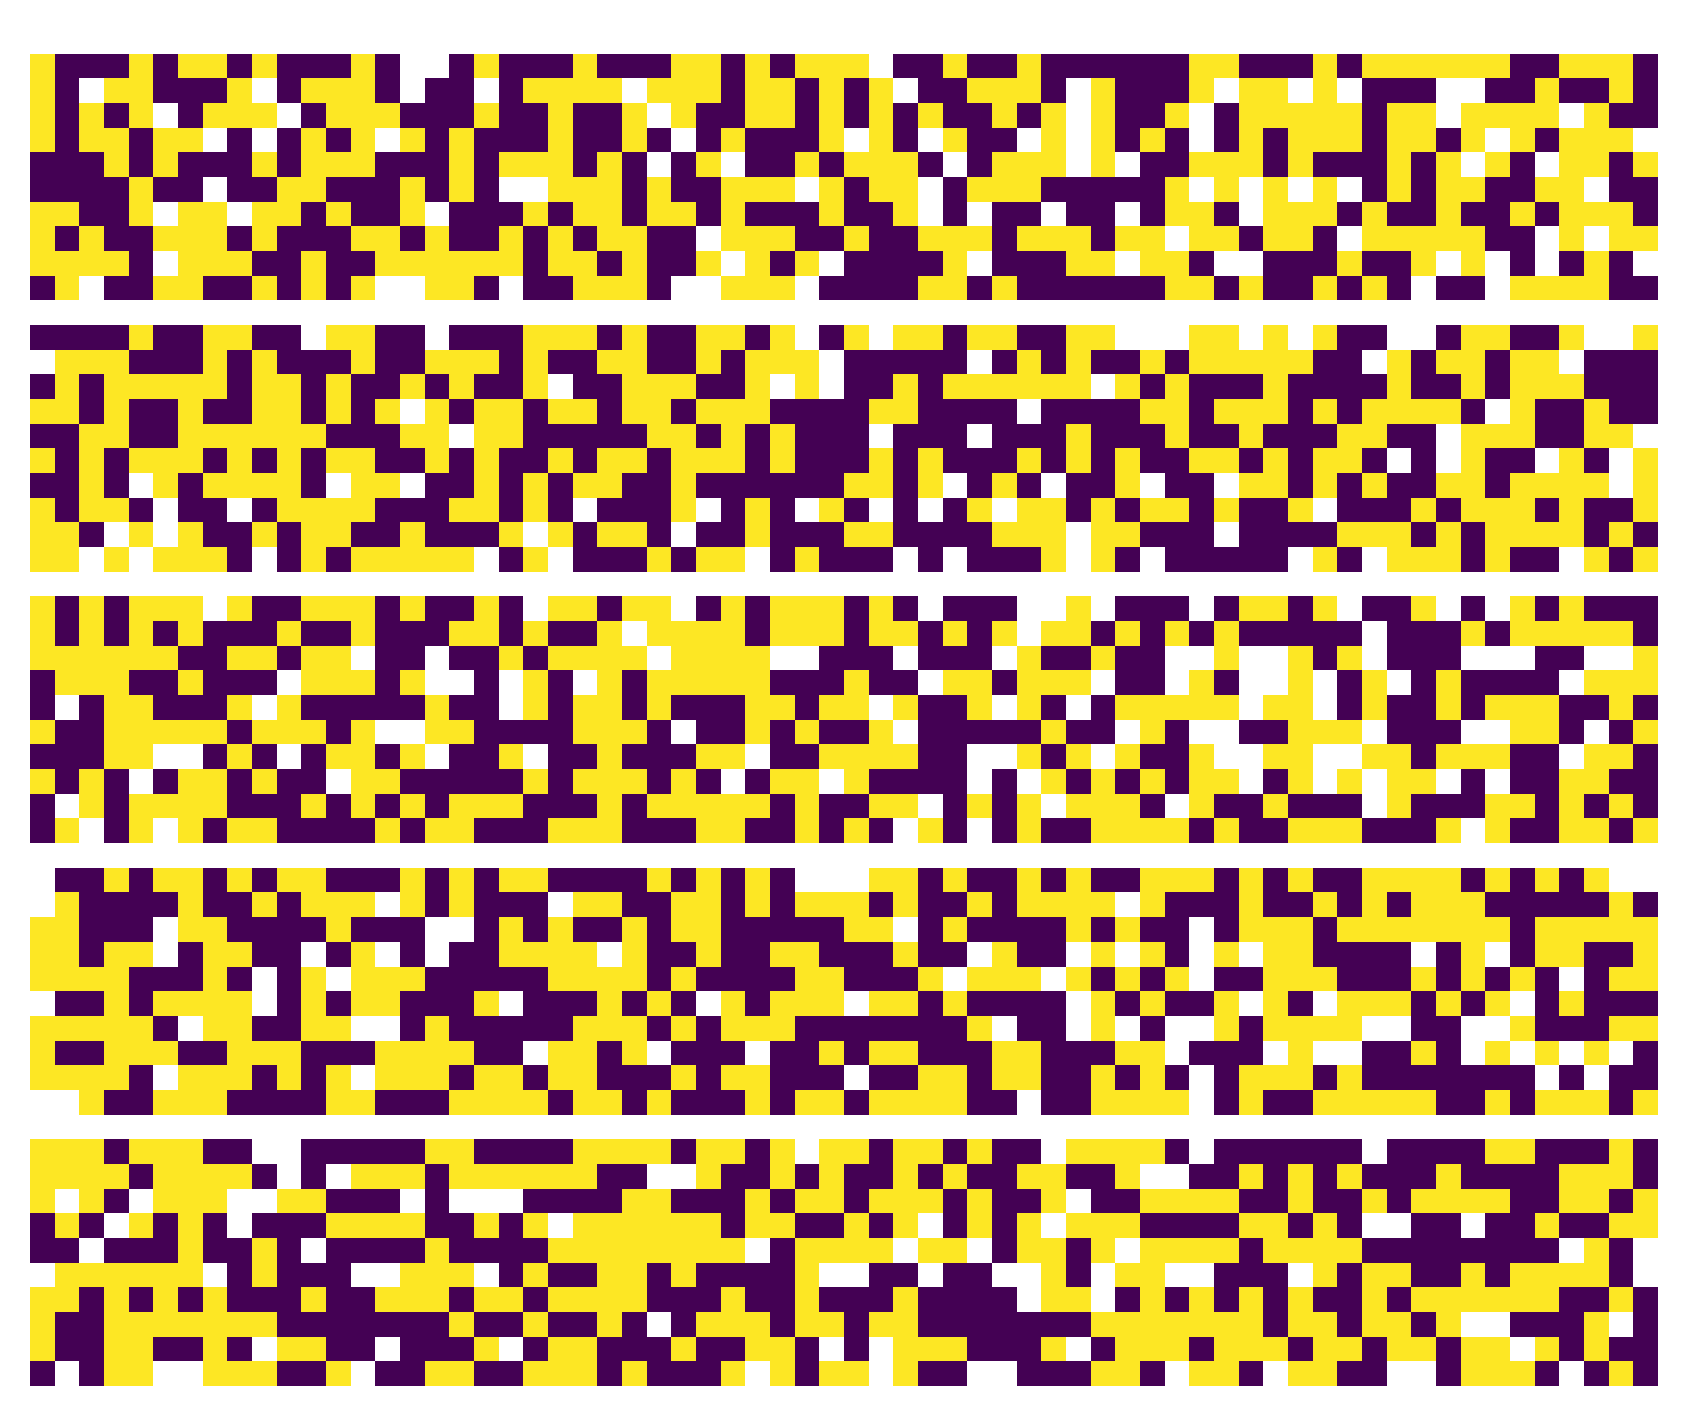

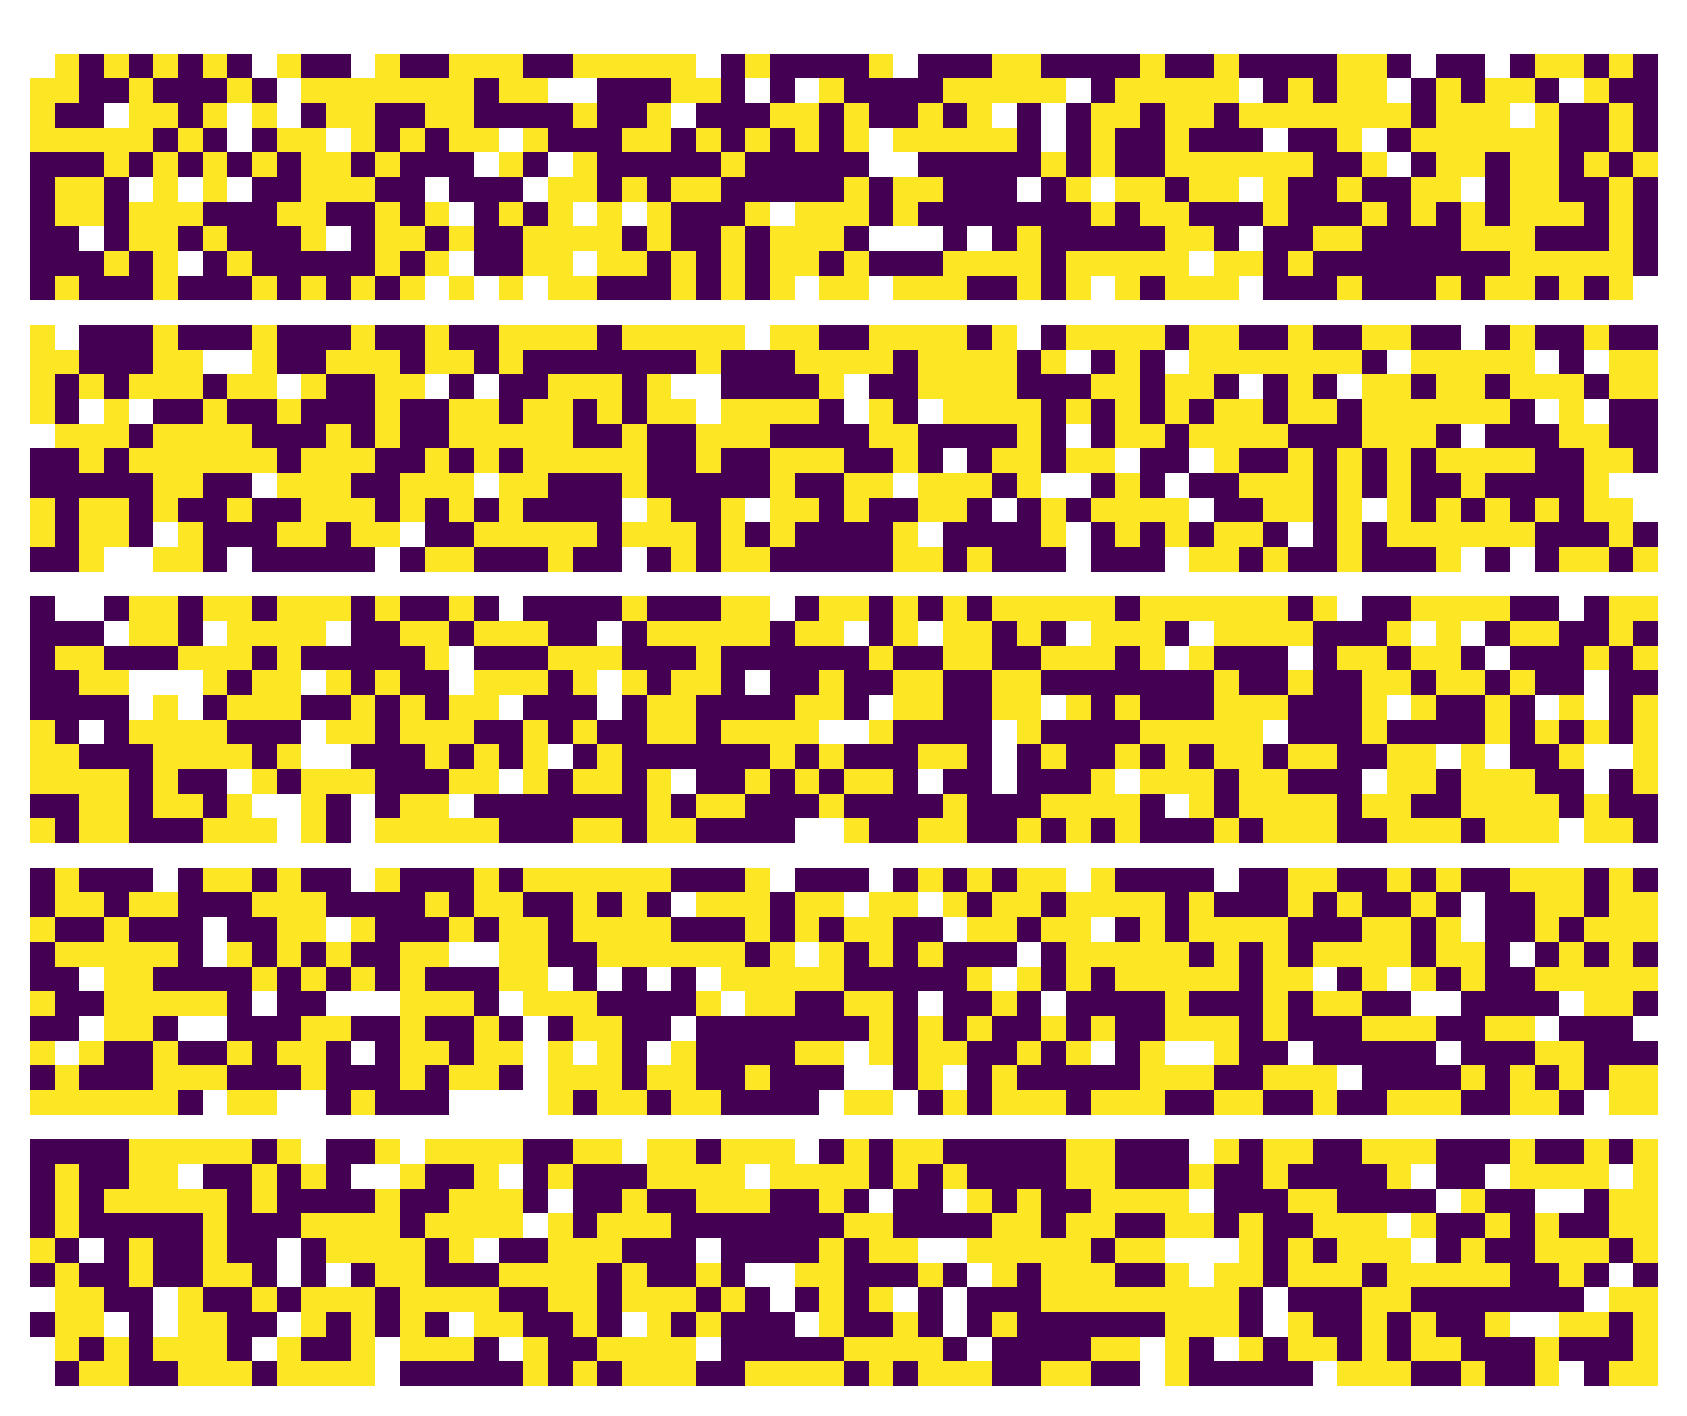

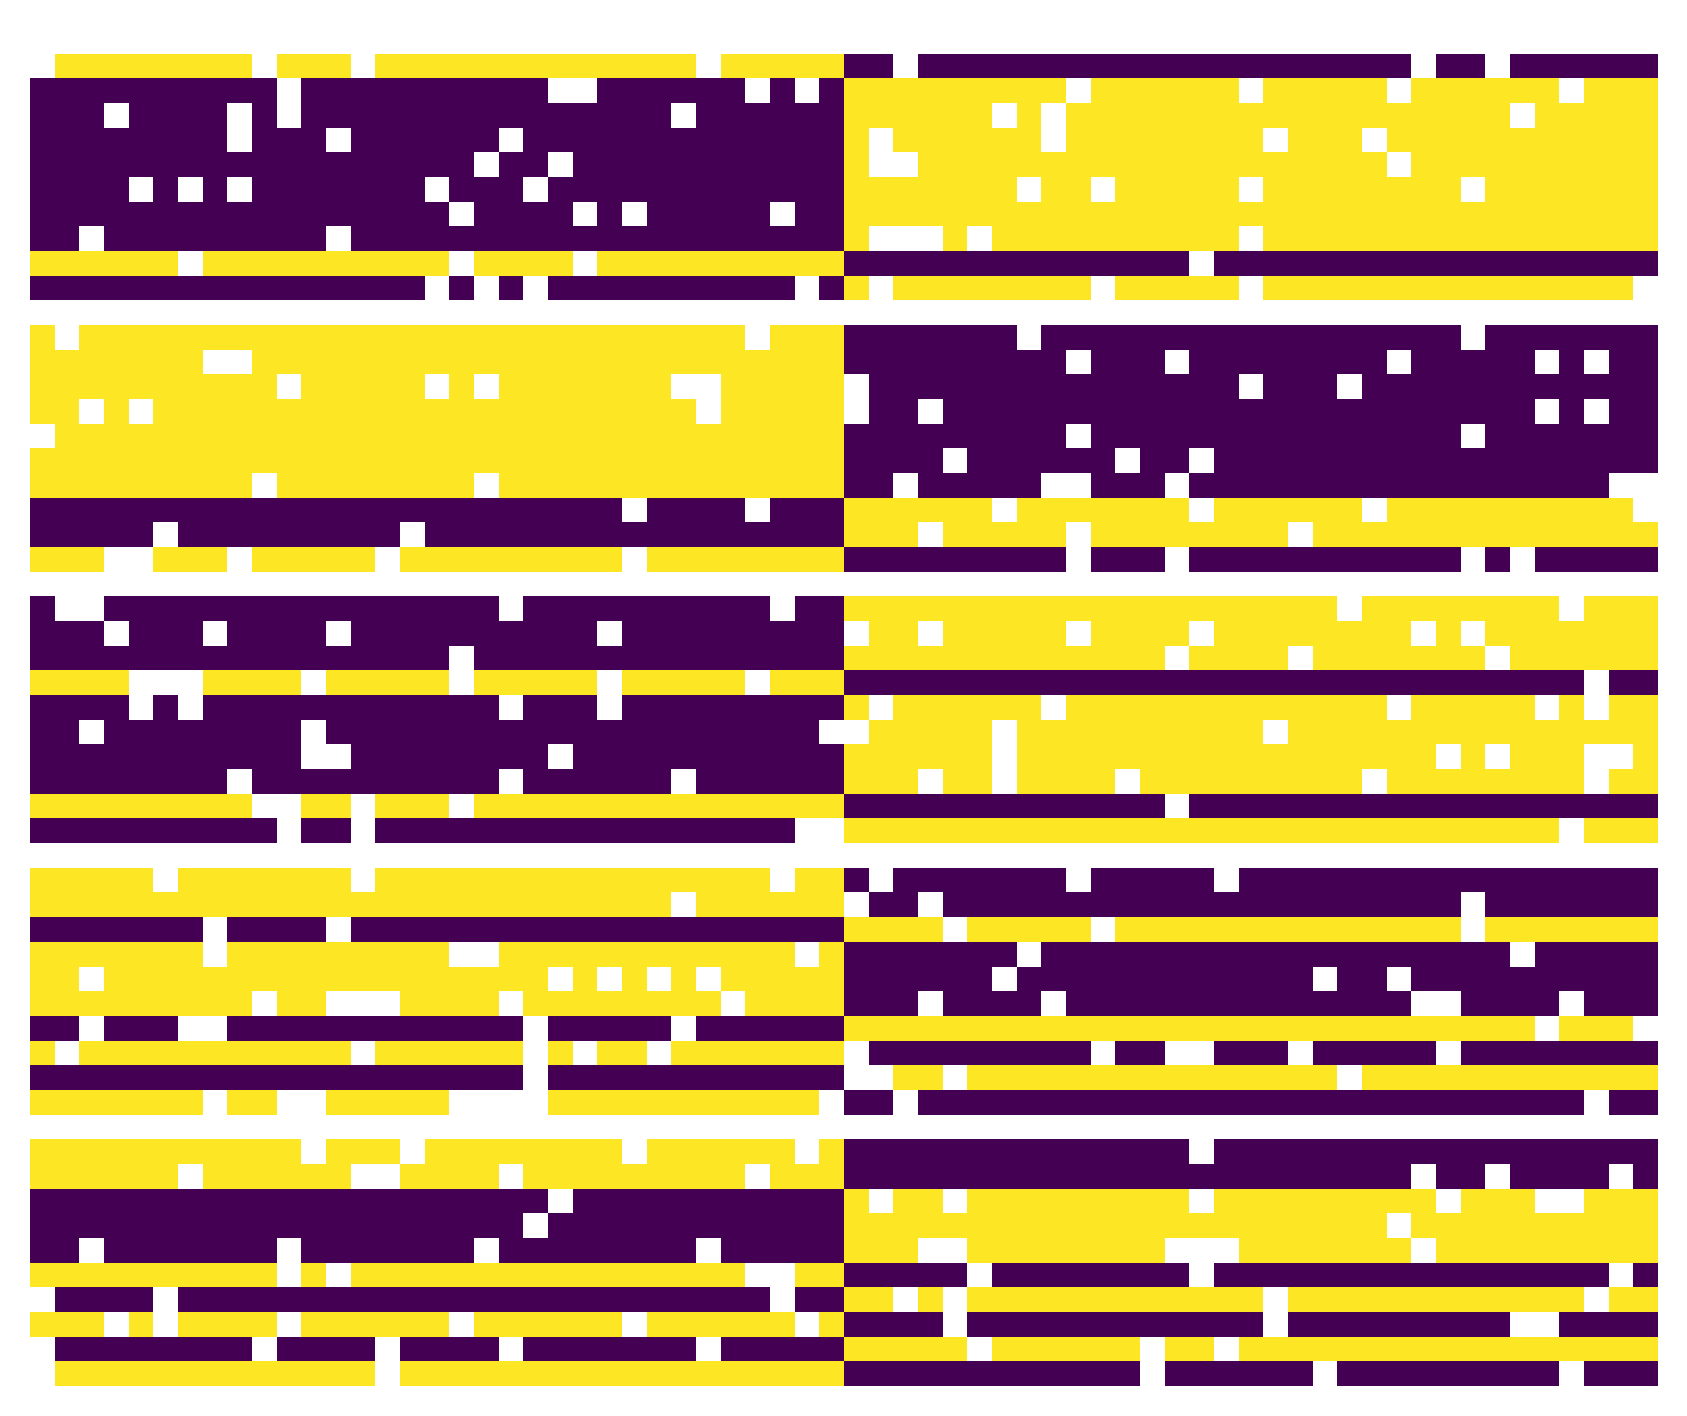

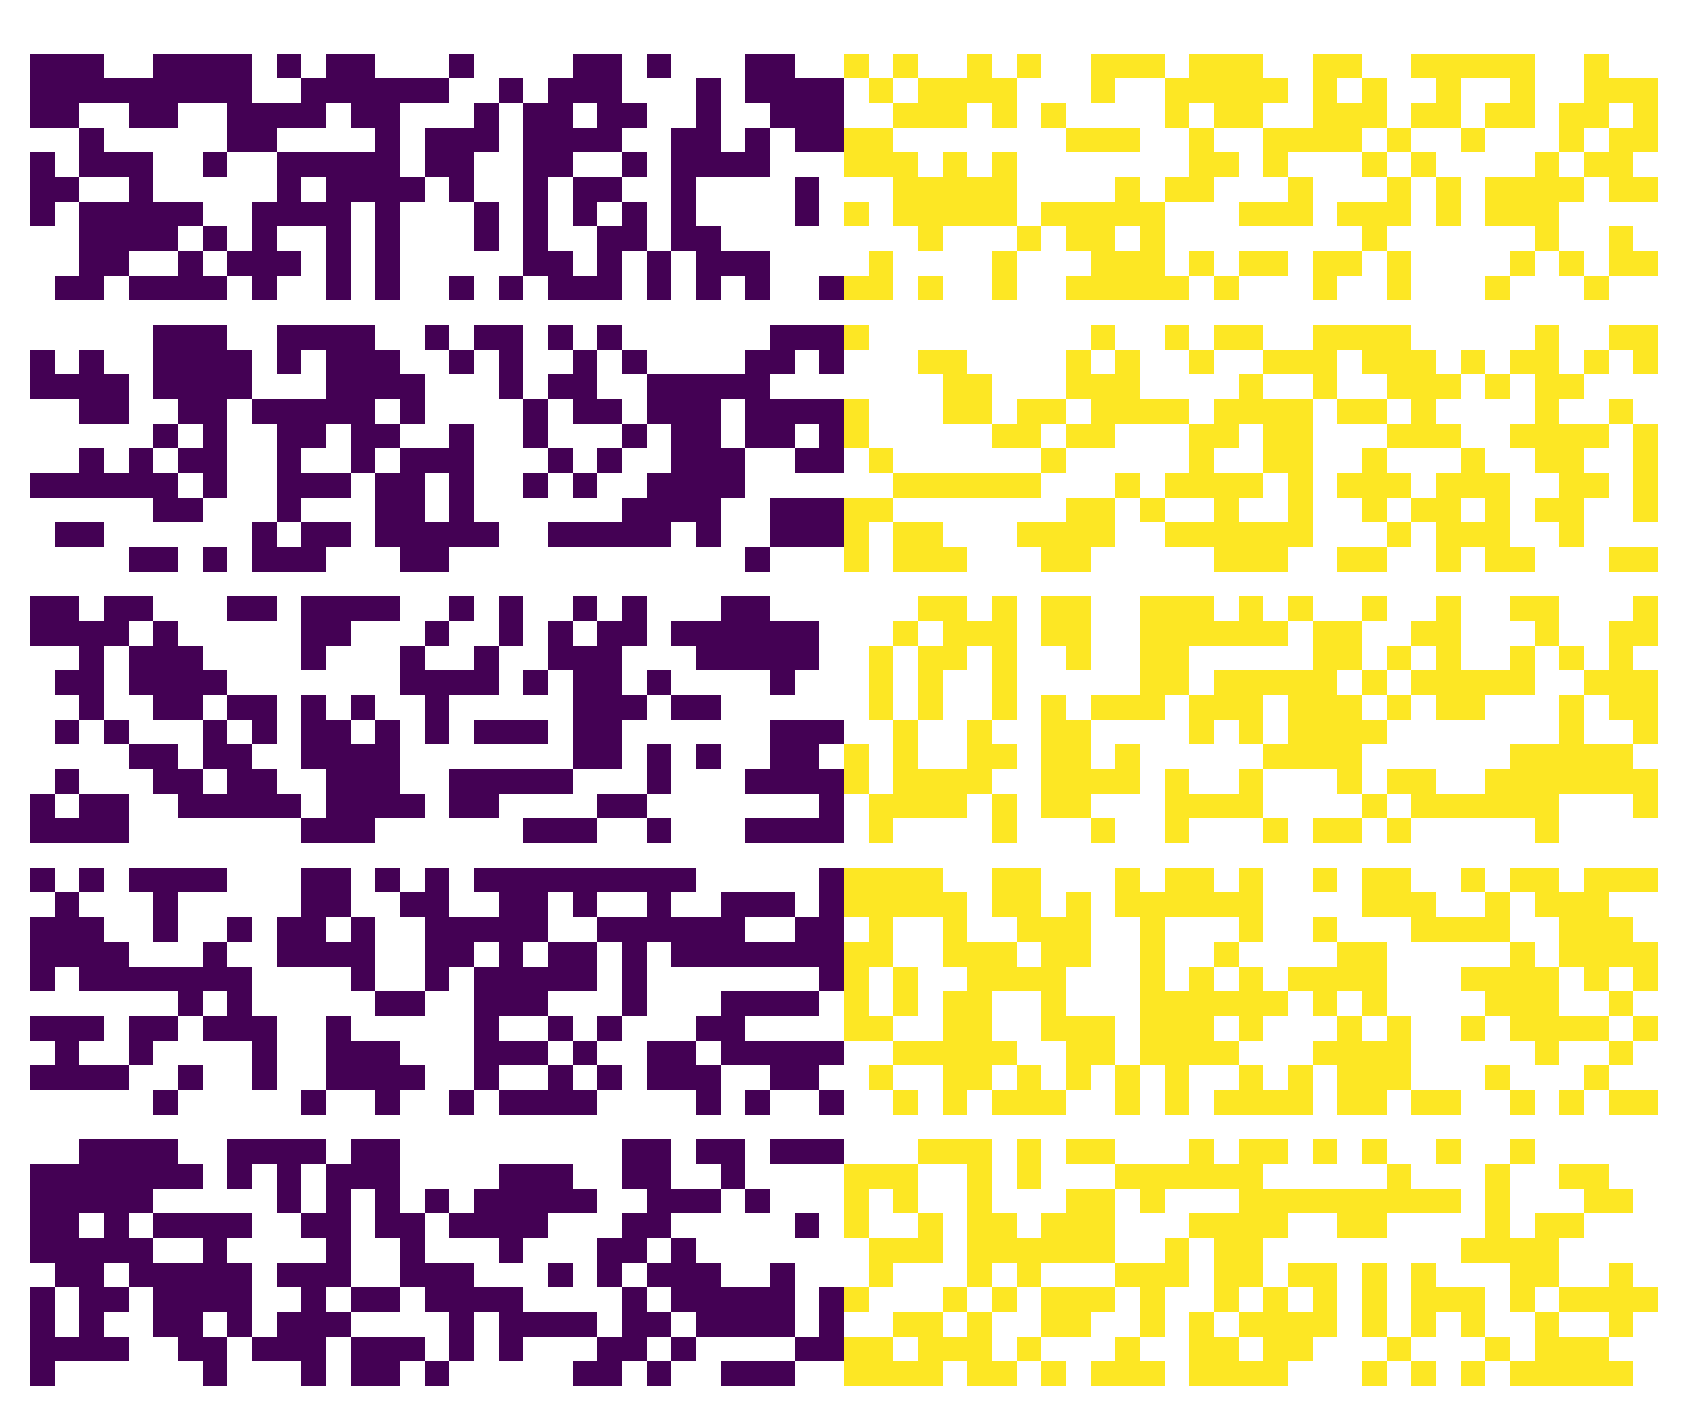

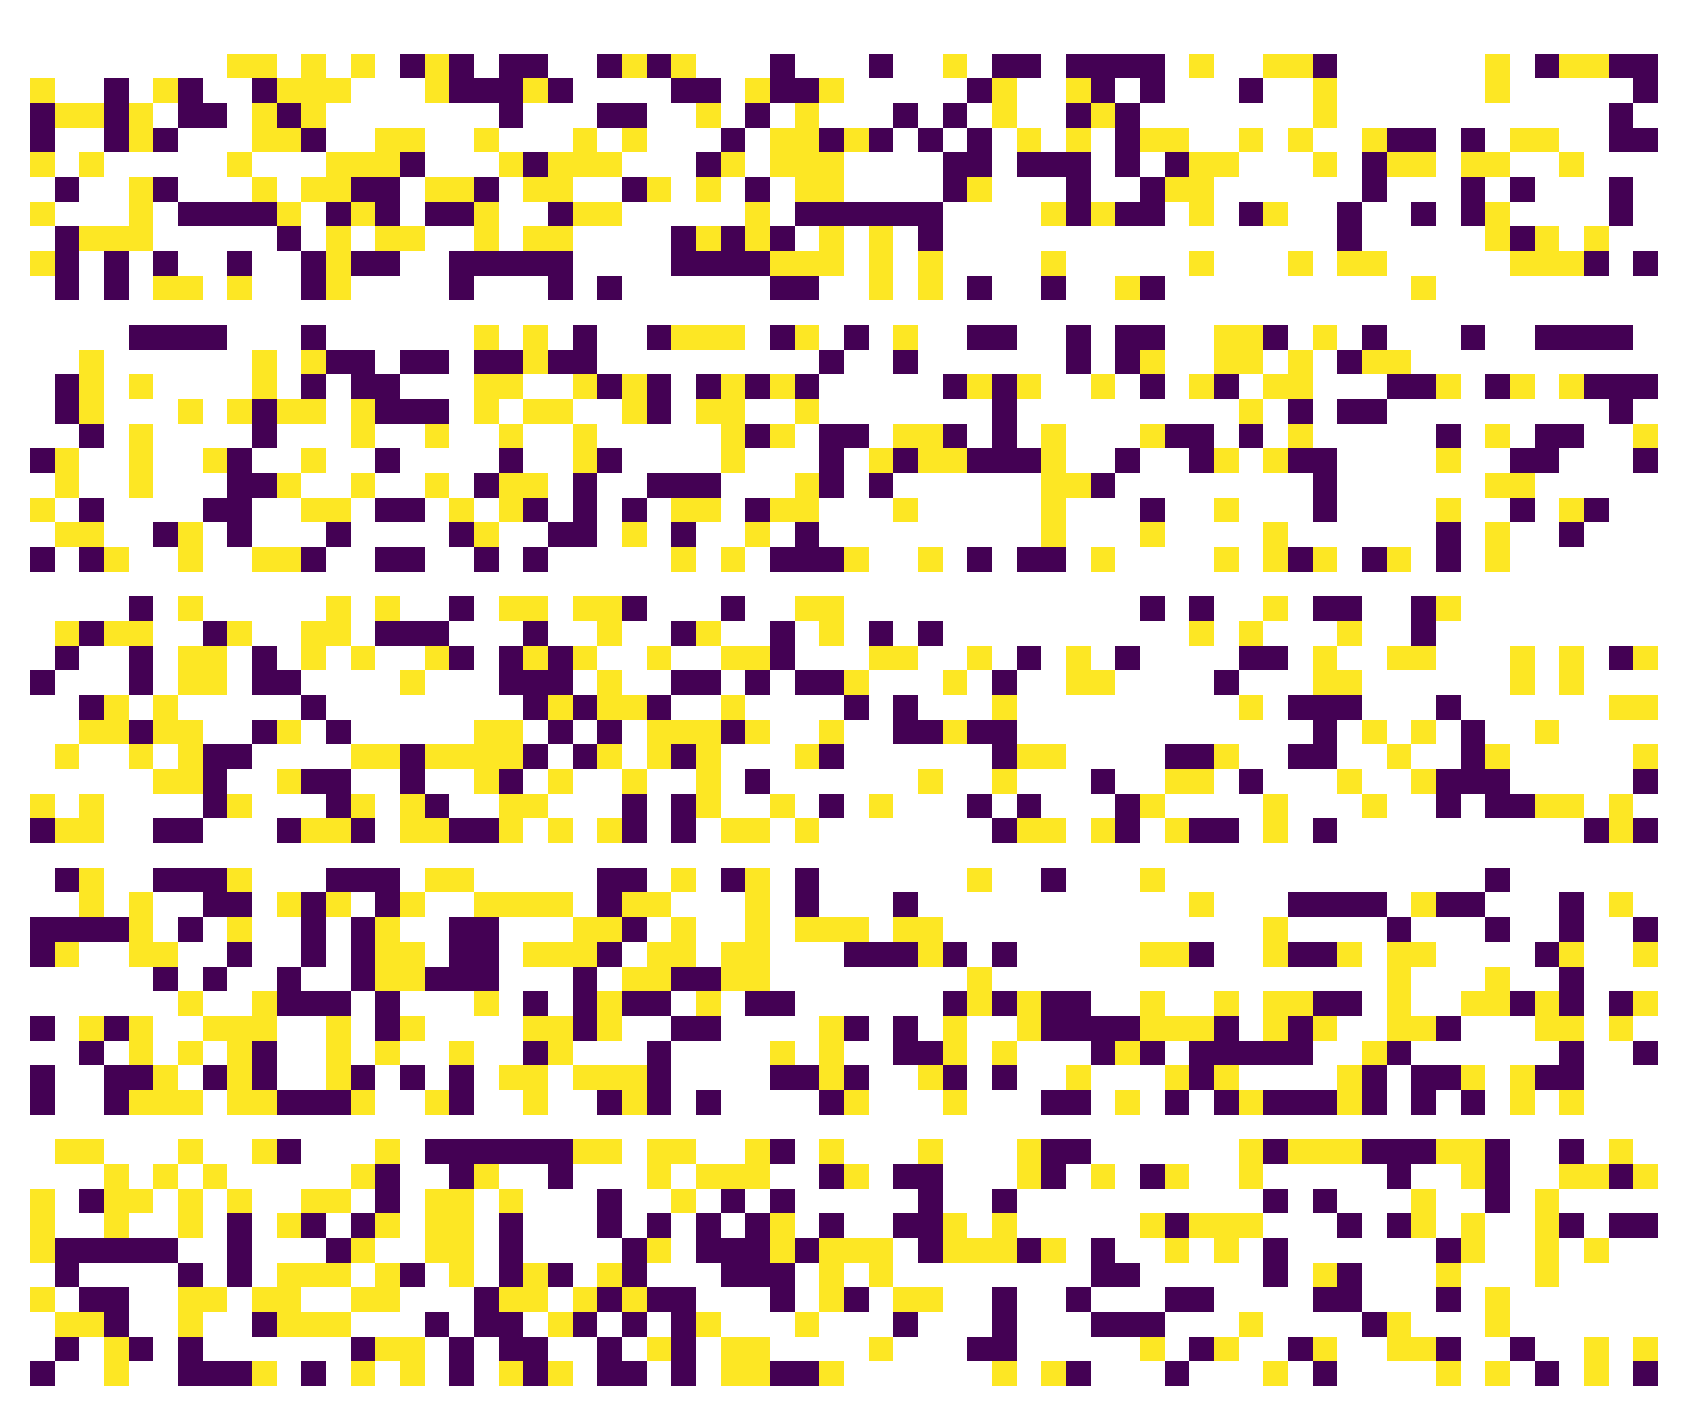

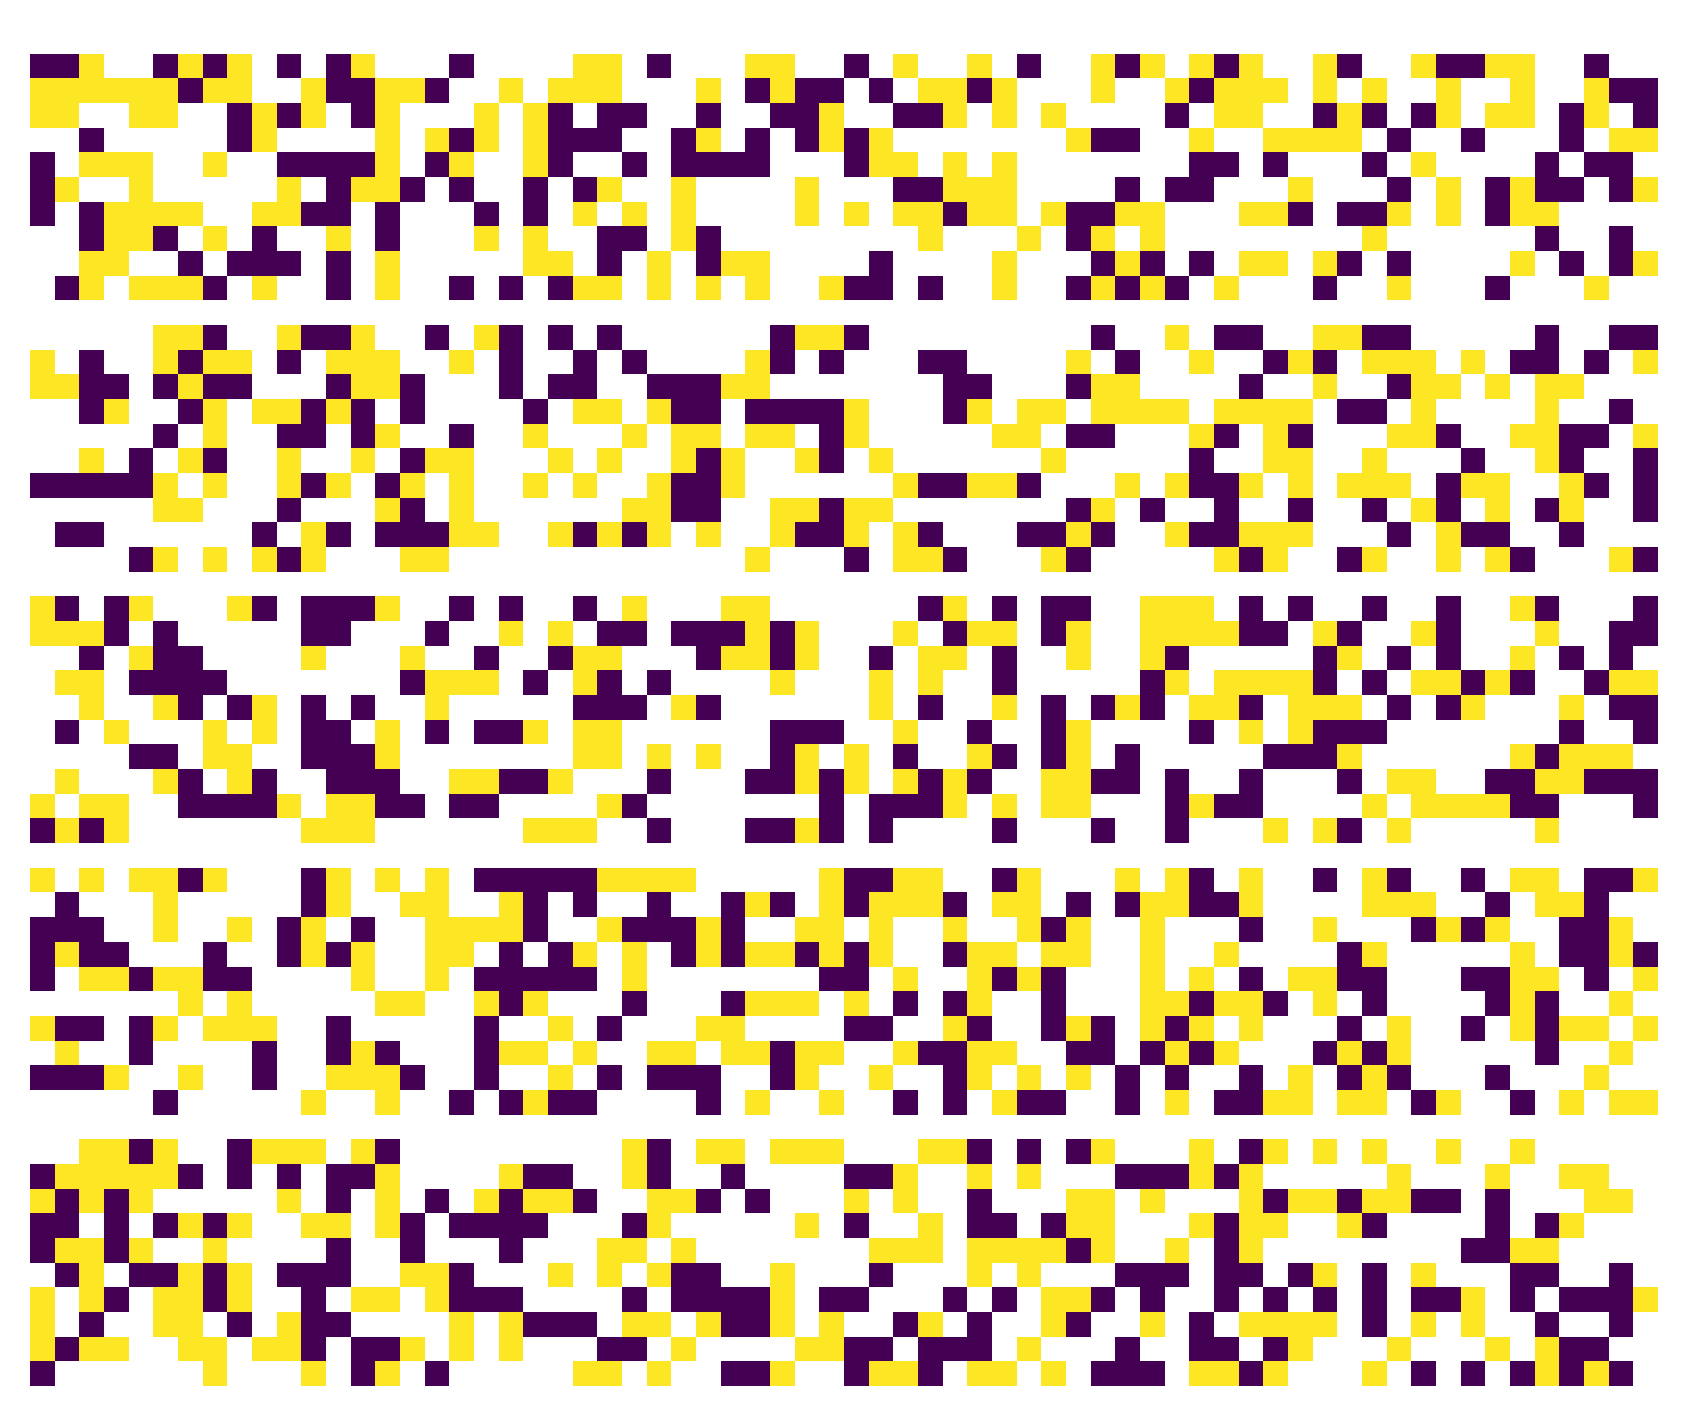

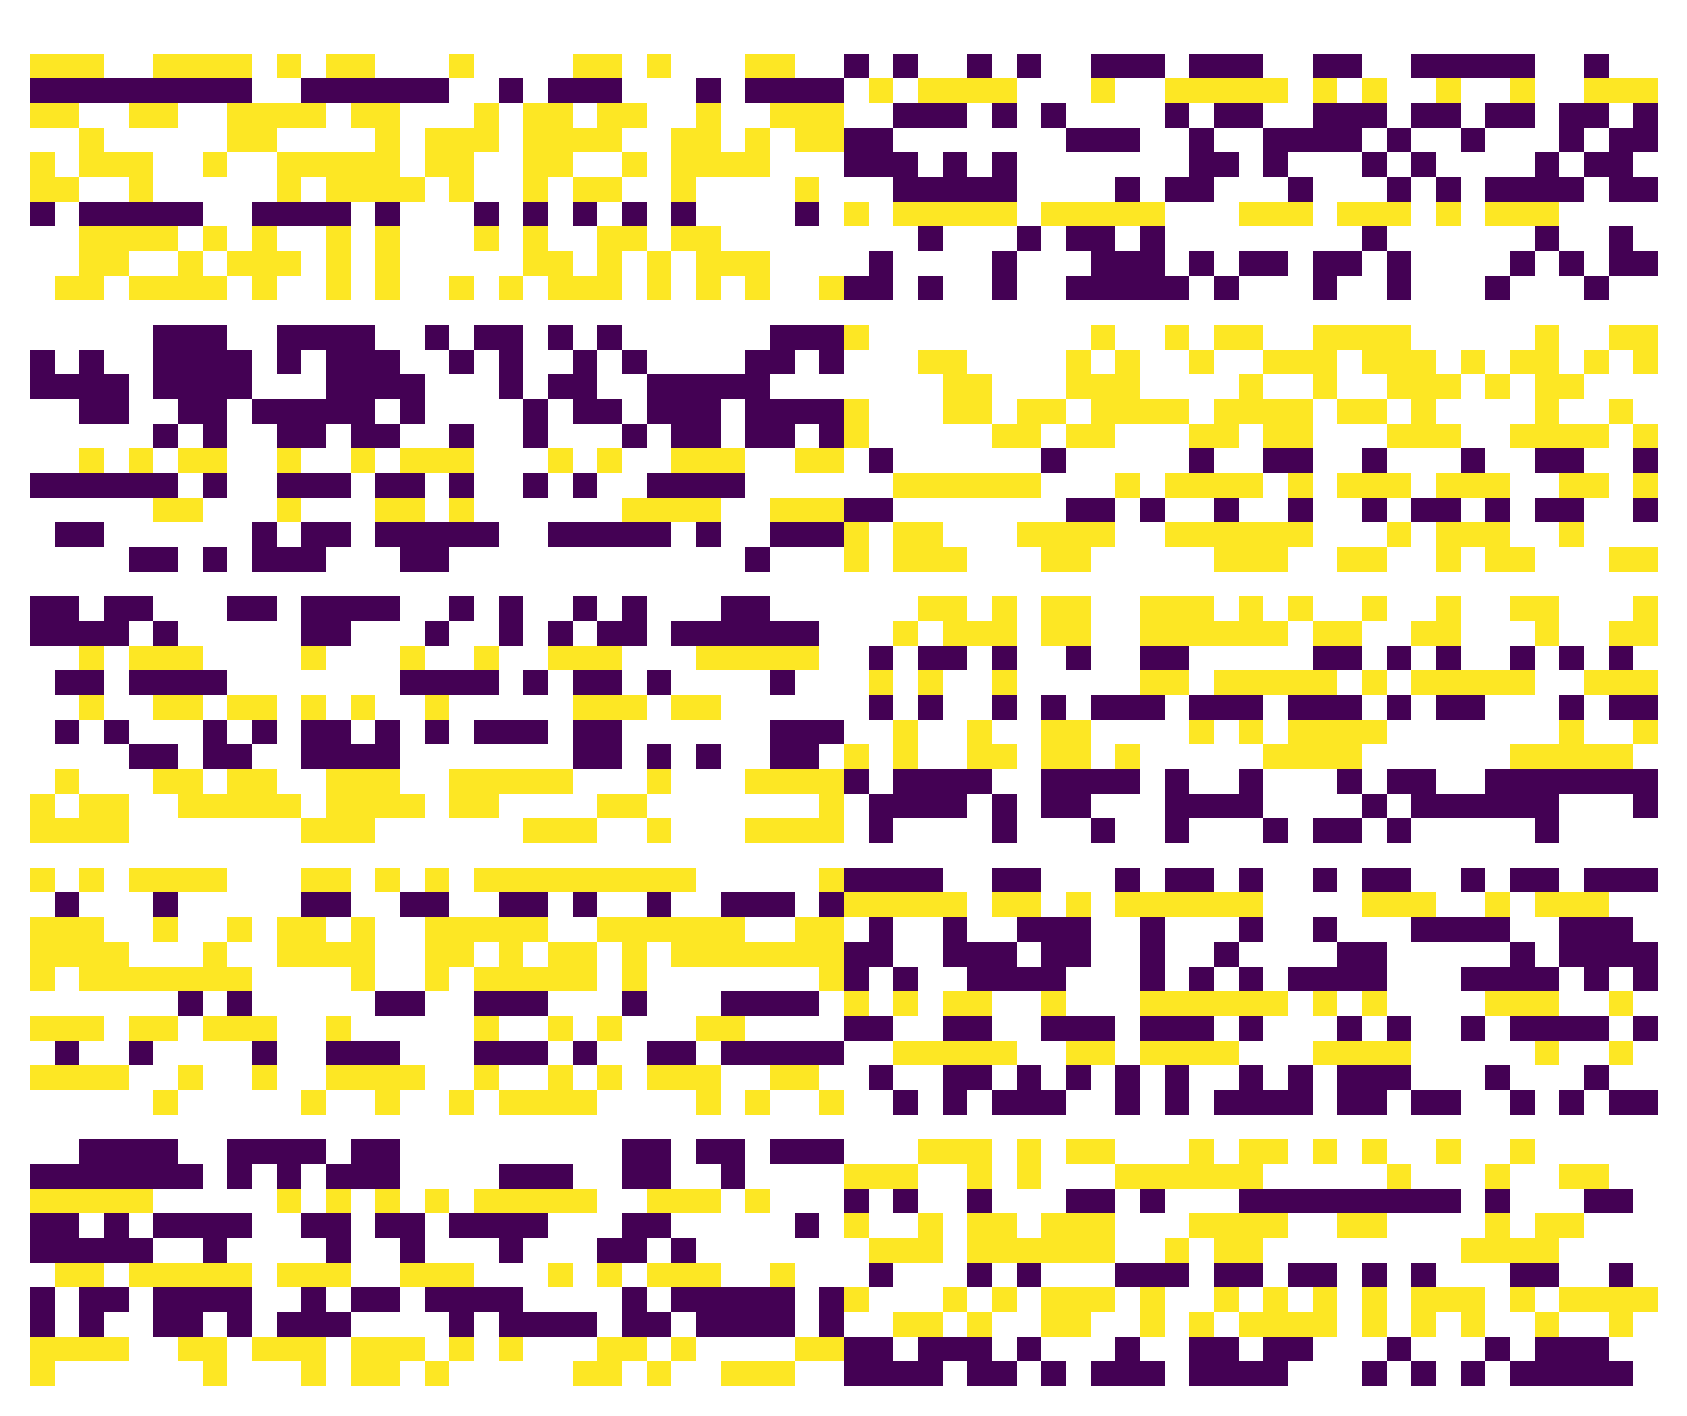

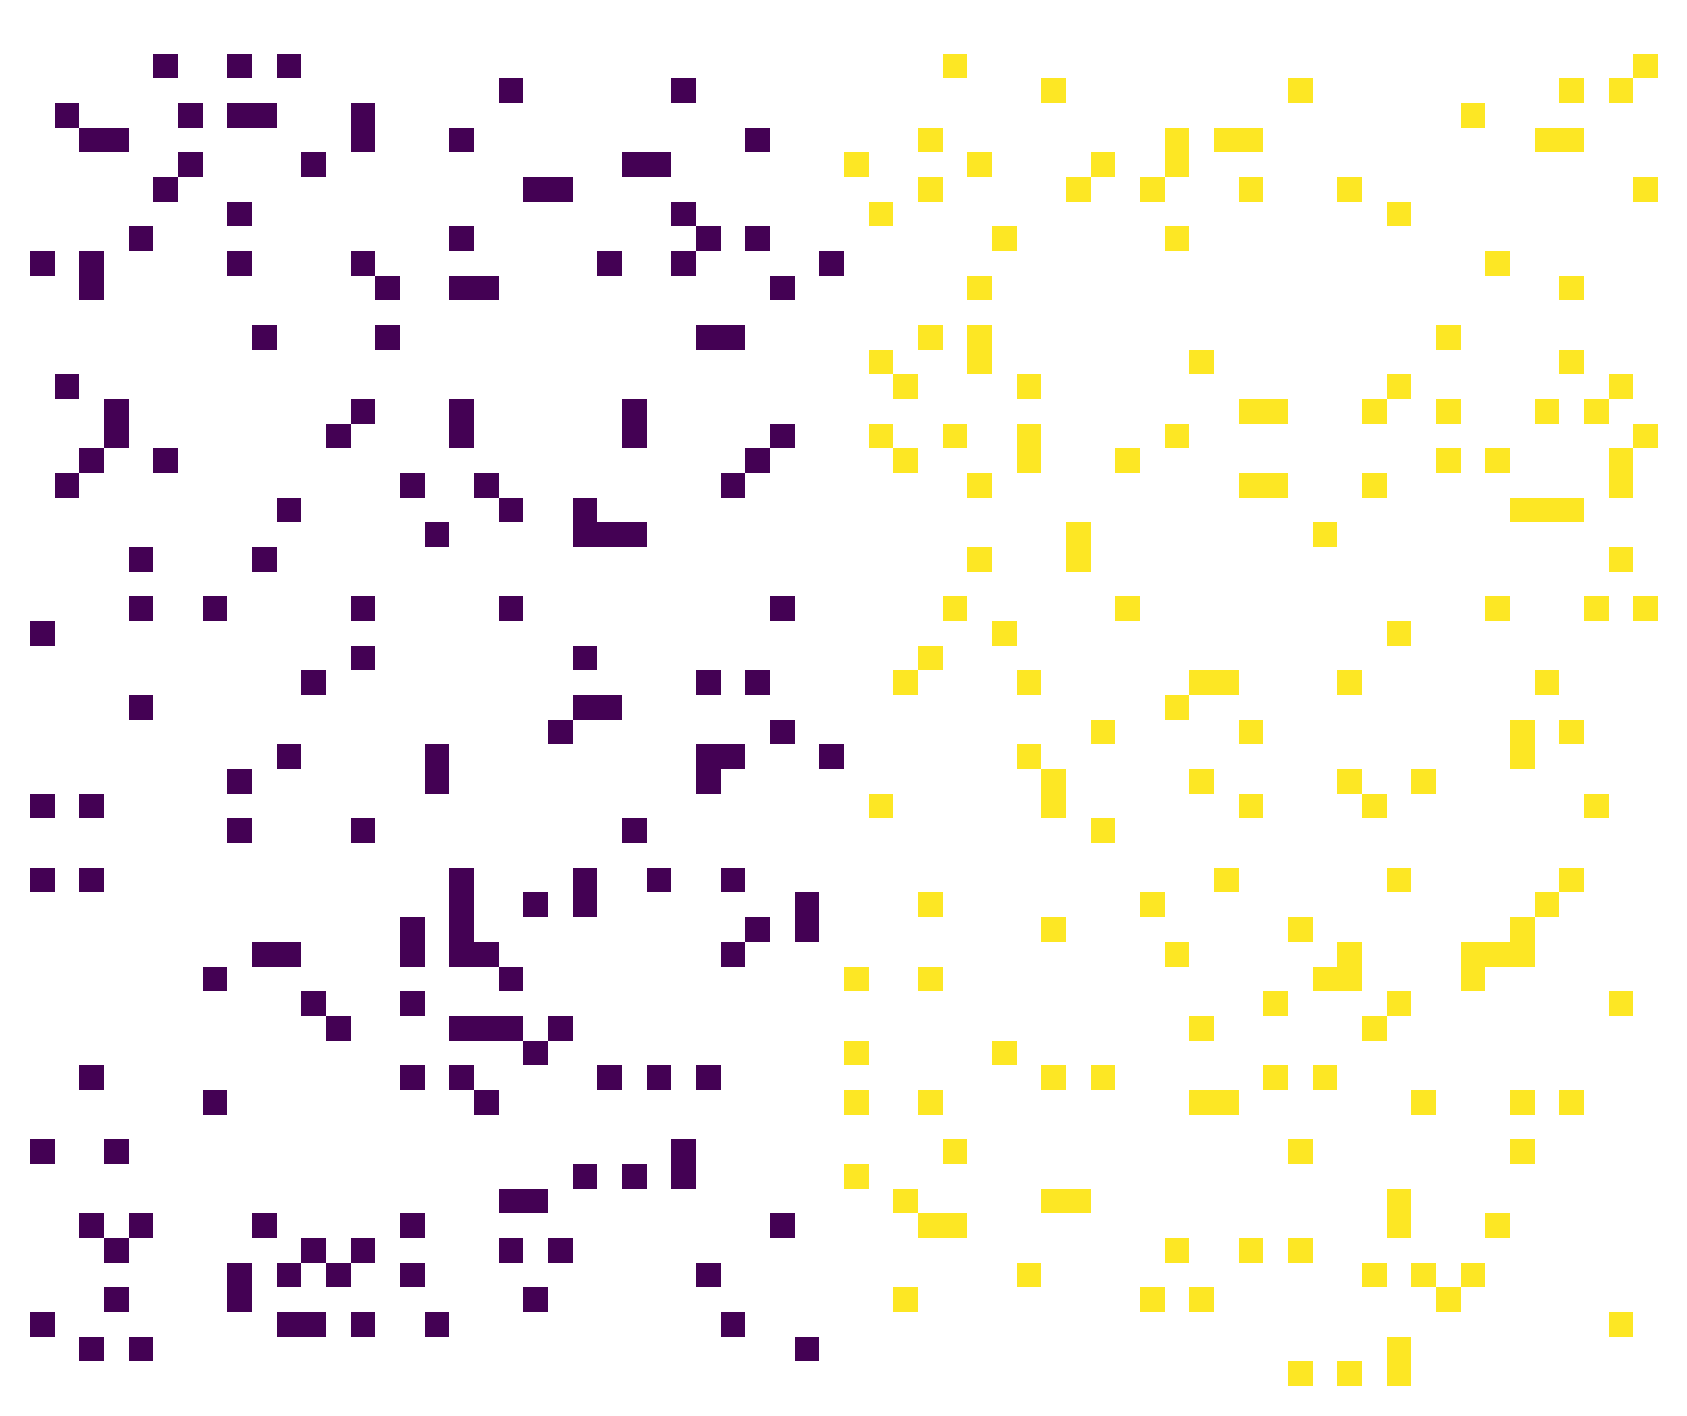

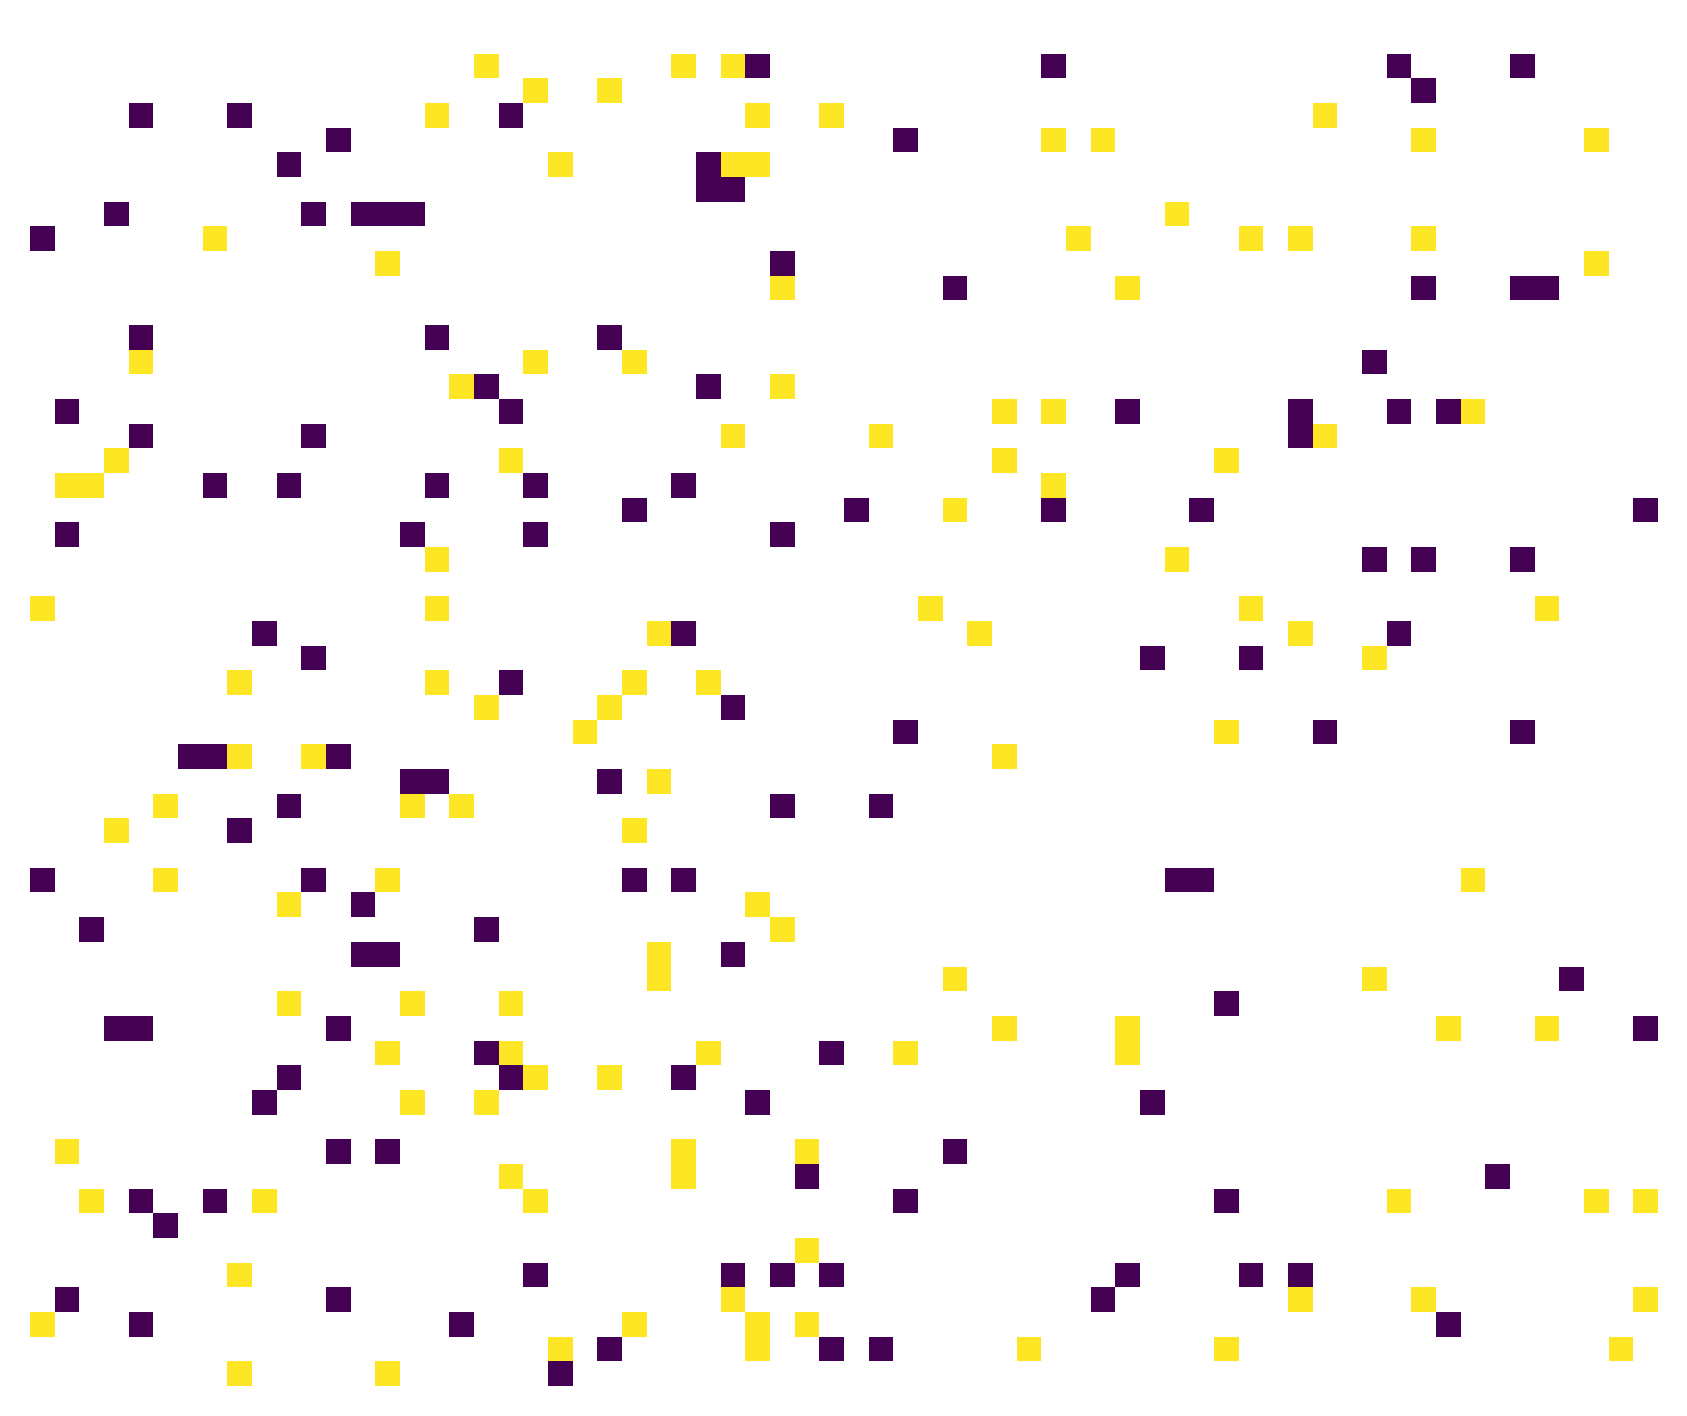

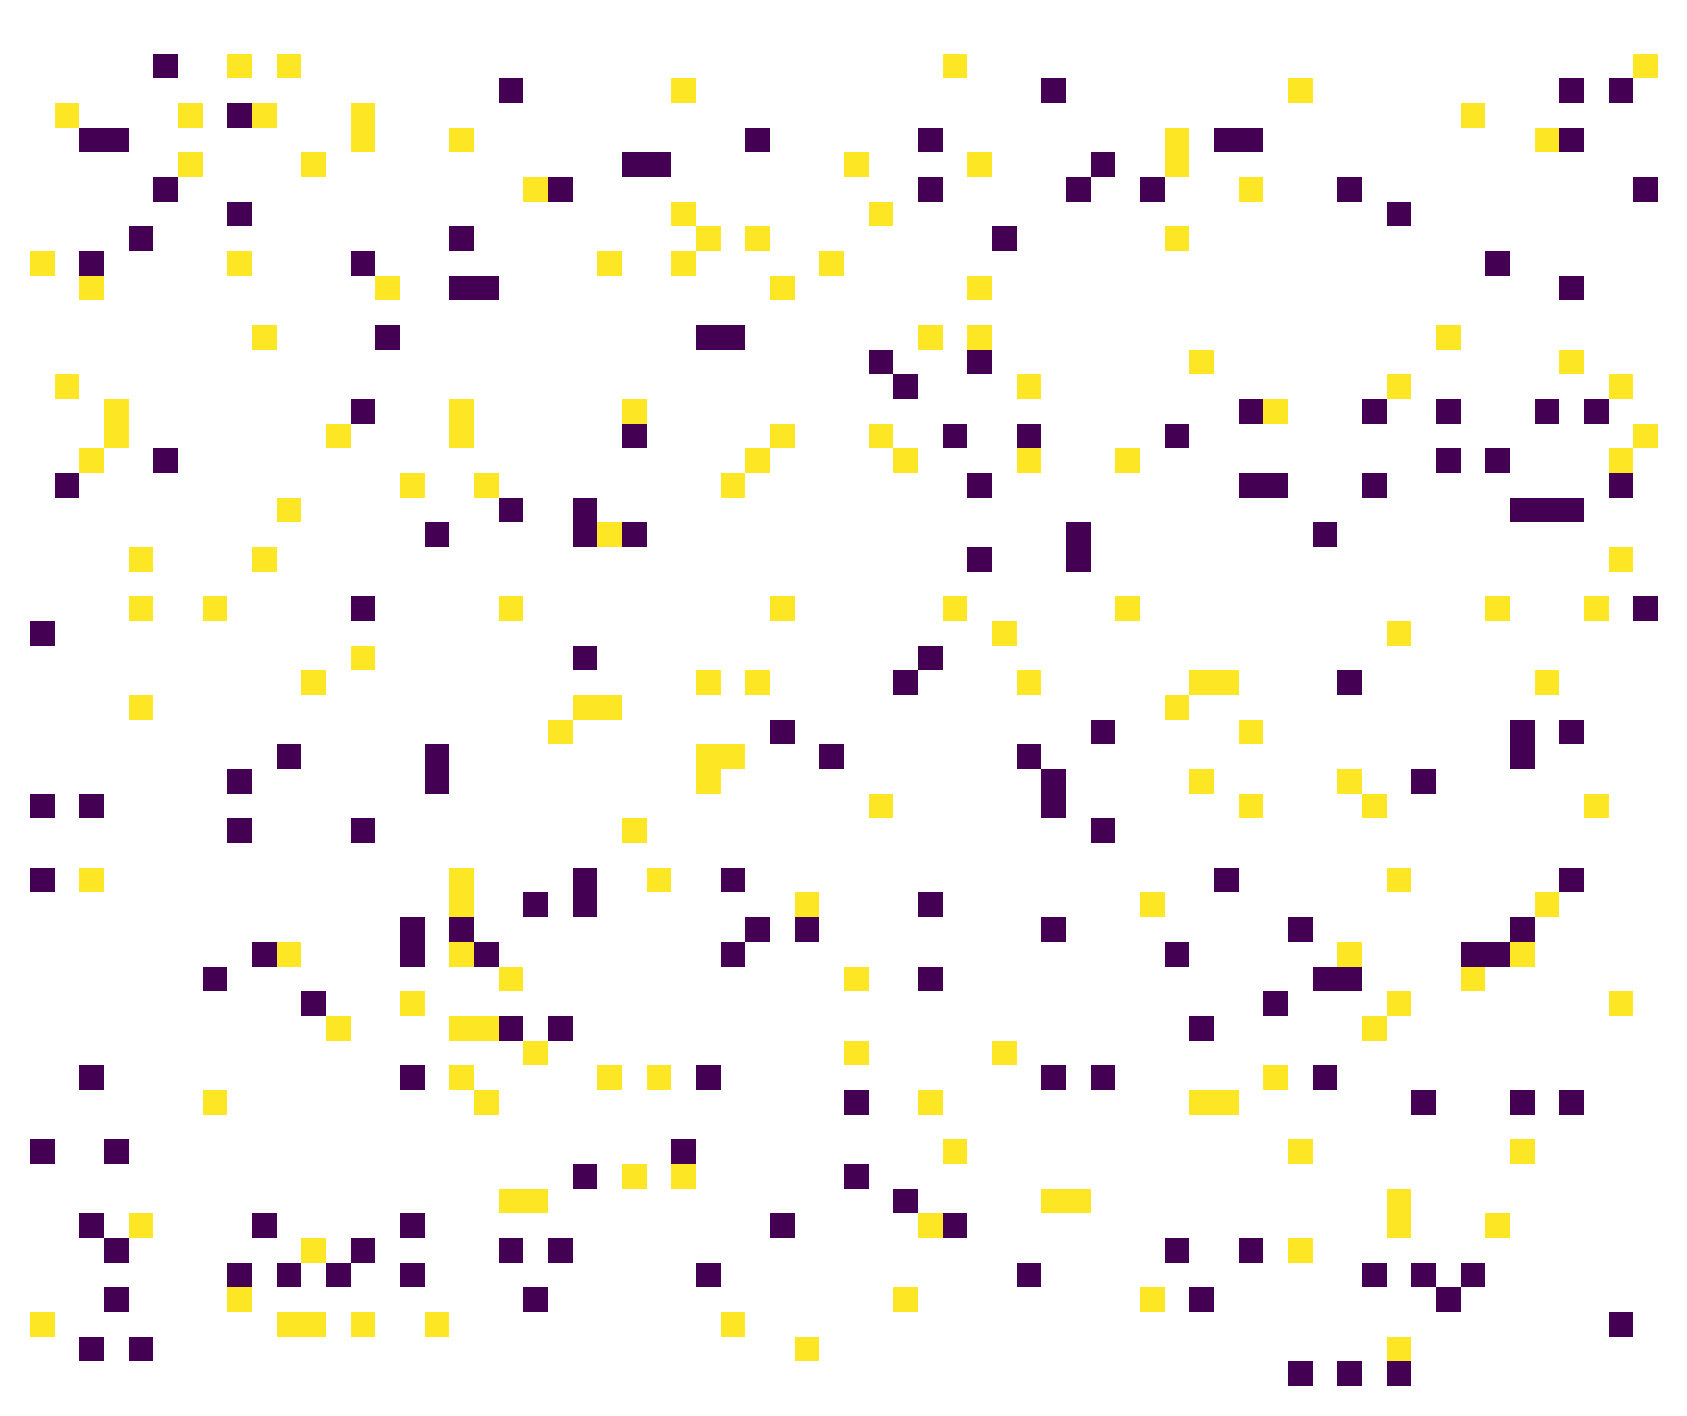

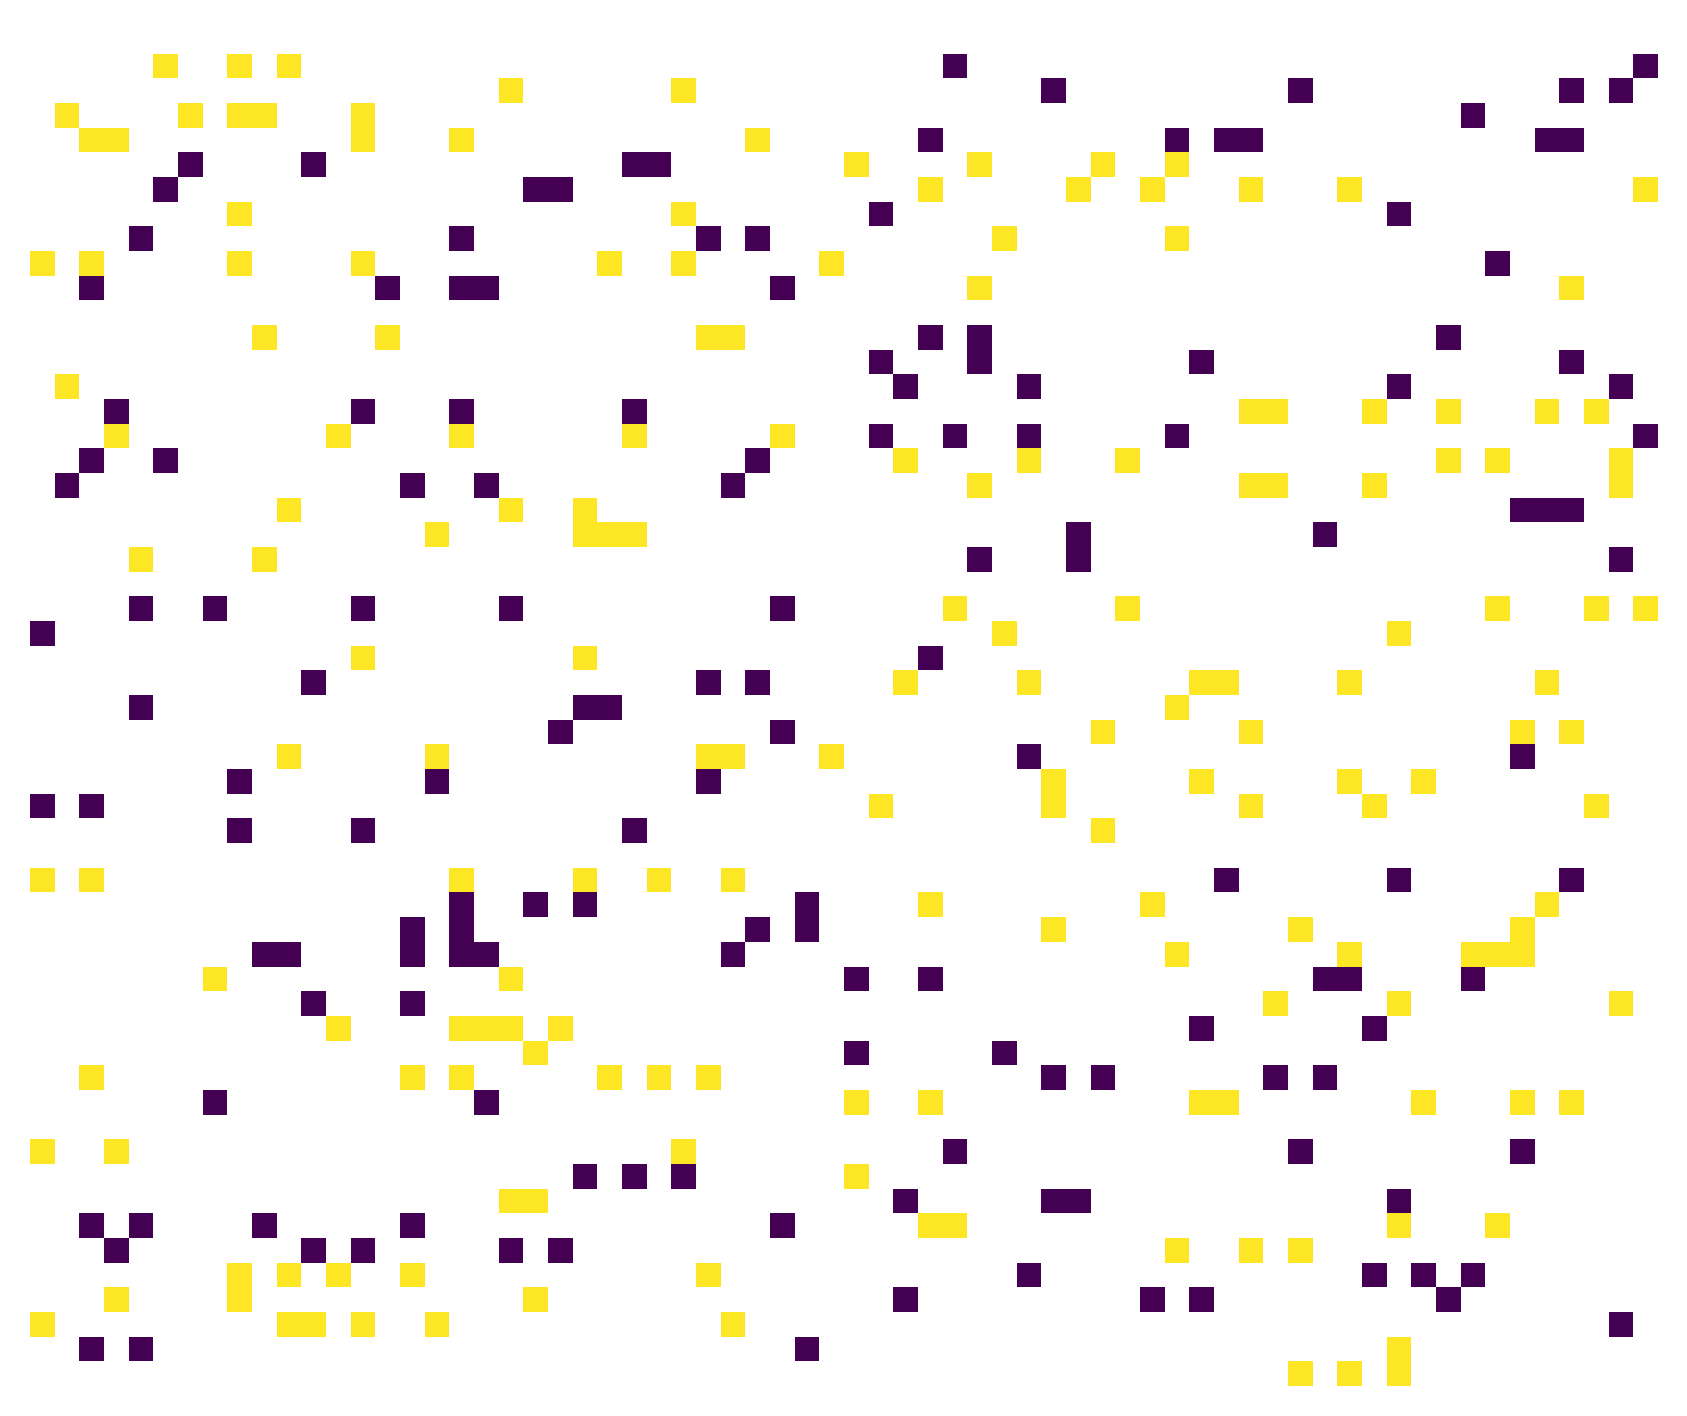

In [249]:
print(simuls.keys())
for key in simuls.keys():
#key = 'Raw_0.5_0.9_False_lines'
    fig = plt.figure(figsize=(7,7),dpi=300)
    fig = plt.imshow(simuls[key])
    # for i in range(S + 1):
    #     plt.plot([0,2*Ng],[CpS * i,CpS * i], color='w', lw=5)    
    plt.axis('off')
    for form in ['png', 'pdf', 'jpg']:
        plt.savefig(f'PICS/{form}/{key}.{form}', format=form, dpi=300)
    # plt.show()

In [ ]:
perc = 0.1

def plot_pics_mix(perc):
    CpS = 10
    S = 5
    N = CpS * S
    y = np.zeros((N,N))
    y2 = np.zeros((N,N)) + 1
    plt.imshow(np.hstack((y, y2)))
    for i in range(S + 1):
        plt.plot([0,2*N],[CpS * i,CpS * i], color='w', lw=5)    
    plt.axis('off')
    plt.show()

    y = np.zeros((N,N))
    y2 = np.zeros((N,N)) + 1
    idx = np.zeros(N*N)
    idx[int(N*N * perc/2.):] = 1
    np.random.shuffle(idx)
    y = (y.flatten() + 1 * idx).reshape((N,N))
    y2 = (y2.flatten() - 1 * idx).reshape((N,N))

    idx = np.zeros(N)

    idx[int(N * perc/2.):] = 1
    np.random.shuffle(idx)
    idx = idx == 1
    y[idx,:] = 1 - y[idx,:]
    y2[idx,:] = 1 - y2[idx,:]

    fig = plt.imshow(np.hstack((y, y2)))
    for i in range(S + 1):
        plt.plot([0,2*N],[CpS * i,CpS * i], color='w', lw=5)    
    plt.axis('off')
    plt.show()

for perc in [0.1, 0.25, 0.5]:
    print(perc)
    plot_pics_mix(perc)